In [1]:
import scanpy as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
os.chdir(os.path.expanduser('/net/scratch2/f30033yc/GPcounts'))
from GPcountsDemo.RNA_seq_GP import rna_seq_gp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

adata = sc.read_h5ad("/net/scratch2/f30033yc/GPcounts/demo_notebooks/sigma_0.5_alpha_0.8.h5ad")
Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                        index=adata.obs_names, 
                        columns=adata.var_names)

spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                    index=adata.obs_names, 
                                    columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

Y = Y.T
X = spatial_locations[['x', 'y']]

aucs = {}
results = {}

ips = np.arange(0, 25.5, 0.5)

for i in ips:
    
    M = int((i * len(X)) // 100)
    
    gene_name = Y.index
    gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf, M=M)
    r1 = gpc1.One_sample_test()
    res = gpc1.calculate_FDR(r1)
    y_true = pd.DataFrame(adata.var['spatially_variable'])
    y_pred = res.loc[:,"spatially_variable"]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    aucs[M] = roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {M} Inducing Points')

    plt.legend()
    plt.savefig(f'{M} Inducing Points')
    results[M] = res

    


KeyboardInterrupt: 

In [261]:
pd.set_option('display.max_rows', 500)
results[125].iloc[100:].sort_values("log_likelihood_ratio")

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value,spatially_variable
gene_156,-11513.637527,-11513.637438,-0.000089,1.000000,1.000000,0
gene_150,-11465.772956,-11465.772949,-0.000008,1.000000,1.000000,0
gene_124,-11476.590879,-11476.590905,0.000026,0.994272,1.000000,0
gene_109,-11470.633685,-11470.633726,0.000040,0.992828,1.000000,0
gene_163,-11460.740233,-11460.740310,0.000077,0.990090,1.000000,0
gene_100,-11425.418146,-11425.418232,0.000086,0.989506,1.000000,0
gene_195,-11484.778411,-11484.778518,0.000107,0.988348,1.000000,0
gene_145,-11520.485928,-11520.486041,0.000113,0.988008,1.000000,0
gene_147,-11483.904622,-11483.904740,0.000118,0.987723,1.000000,0
gene_175,-11523.994693,-11523.994892,0.000200,0.984063,1.000000,0


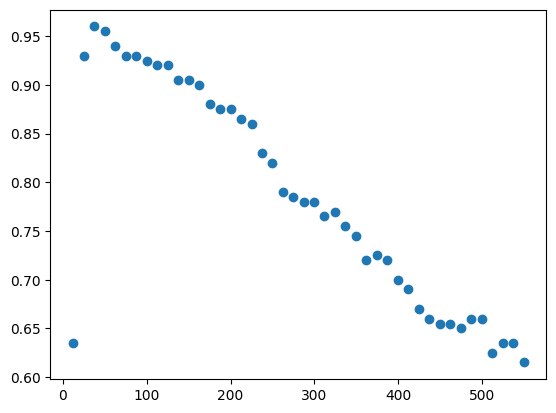

In [221]:
plt.scatter(list(aucs.keys())[1:], list(aucs.values())[1:])

In [236]:
int(12.5)

12

[0.5787954698867472,
 0.8252096302407561,
 0.9059416485412136,
 0.9541303532588317,
 0.9664921623040578,
 0.9873516837920949,
 0.9906382659566491,
 0.992775819395485,
 0.9937448436210906,
 1.0,
 0.9957893947348685,
 0.9961719042976075,
 0.9952868821720544,
 0.9950453761344035,
 0.9945023625590642,
 0.9934613365334135,
 0.9930158253956349,
 0.9914302857571442,
 0.9905752643816096,
 0.989390234755869,
 0.9880132003300084,
 0.9872706817670444,
 0.9866601665041627,
 0.9852801320033001,
 0.9844551113777845,
 0.9828335708392711,
 0.9816920423010577,
 0.9808040201005027,
 0.9806150153753844,
 0.9788299707492688,
 0.9782104552613816,
 0.9766129153228832,
 0.9763354083852098,
 0.9756063901597541,
 0.9746643666091653,
 0.9741498537463438,
 0.9735153378834472,
 0.9717602940073503,
 0.9714047851196281,
 0.970881272031801,
 0.9700862521563041,
 0.9694157353933849,
 0.968526213155329,
 0.967684692117303]

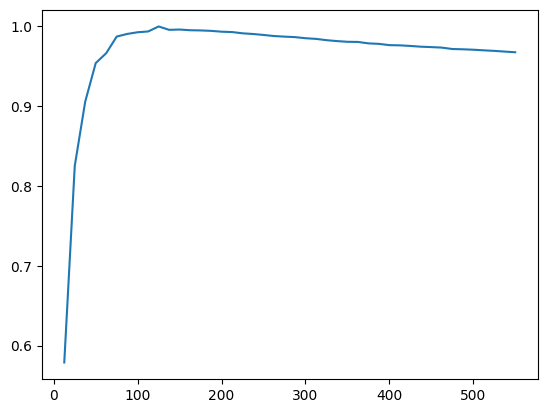

In [252]:
data = list(results.values())
log_likelihoods = []
dynamic_rvals = []
for i in inducing_point_numbers:
    log_likelihoods.append(results[int(i)].log_likelihood_ratio.values)

for i in range(len(inducing_point_numbers)):
    res= scipy.stats.spearmanr(list(log_likelihoods[int(i)]), results[125].log_likelihood_ratio.values)
    dynamic_rvals.append(res.statistic)
plt.plot(inducing_point_numbers[1:], dynamic_rvals[1:])
dynamic_rvals[1:]

[0.9999189979749495,
 0.9999474986874674,
 0.9999519987999701,
 0.9999519987999701,
 0.9999669991749794,
 0.9999699992499814,
 0.9999714992874823,
 0.9999834995874898,
 0.9999879996999926,
 1.0,
 1.0,
 0.9999939998499965,
 0.9999924998124954,
 0.9999879996999926,
 0.9999849996249909,
 0.9999834995874898,
 0.999980499512488,
 0.9999834995874898,
 0.999978999474987,
 0.999980499512488,
 0.9999759993999852,
 0.9999759993999852,
 0.999977499437486,
 0.999977499437486,
 0.9999729993249833,
 0.9999714992874823,
 0.9999714992874823,
 0.9999729993249833,
 0.9999699992499814,
 0.9999699992499814,
 0.9999699992499814,
 0.9999699992499814,
 0.9999684992124804,
 0.9999699992499814,
 0.9999699992499814,
 0.9999699992499814,
 0.9999624990624767,
 0.9999579989499738,
 0.9999609990249757,
 0.9999609990249757,
 0.9999534988374711,
 0.9999519987999701,
 0.9999504987624693,
 0.9999504987624693]

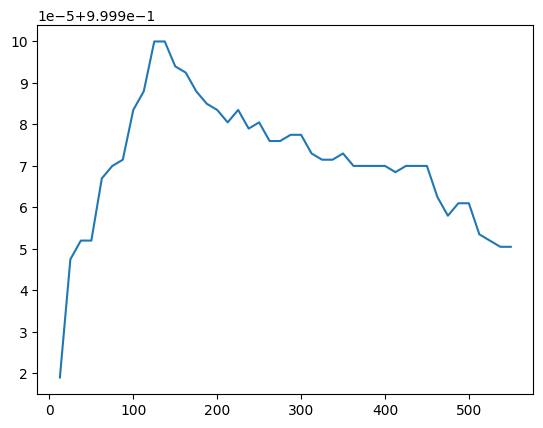

In [249]:
data = list(results.values())
constant_log_likelihoods = []
constant_rvals = []
for i in inducing_point_numbers:
    constant_log_likelihoods.append(results[int(i)].Constant_model_log_likelihood.values)

for i in range(len(inducing_point_numbers)):
    res= scipy.stats.spearmanr(list(constant_log_likelihoods[int(i)]), results[125].Constant_model_log_likelihood.values)
    constant_rvals.append(res.statistic)

    
plt.plot(inducing_point_numbers[1:], constant_rvals[1:])
constant_rvals[1:]

In [201]:
ll = []
for i in np.arange(0, 22.5, 0.5):
    ll.append(data[int(i)].Dynamic_model_log_likelihood.values)
ll[0]

array([-11019.28370329, -10992.46466751, -10926.84262528, -11130.46067321,
       -10941.05634406, -10996.14104229, -10952.44488707, -11068.73681179,
       -10965.05355875, -11035.62550156, -10946.52451145, -10985.30094866,
       -10948.15710441, -11082.72403548, -10942.054392  , -11116.40149514,
       -11037.31348668, -11005.28421944, -10976.60029032, -10968.14955113,
       -10964.35450708, -10969.36134156, -10873.92319018, -11060.2202983 ,
       -10929.97162519, -11140.63578128, -11165.83388029, -10950.48158431,
       -10794.5184048 , -10983.16945237, -10916.50441378, -11133.83639116,
       -11000.48687518, -10966.07441157, -11156.64995692, -10952.41070737,
       -11028.11153291, -10973.86084466, -11005.38114049, -10992.78706932,
       -11101.6272832 , -11100.25712443, -10975.54681738, -11011.35721578,
       -11040.7594143 , -10922.43373401, -10962.96670893, -11027.85003866,
       -11052.13400516, -11094.56110863, -11093.81101879, -11155.26461369,
       -10999.84371679, -

[-11021.210454229951,
 -11020.270862197653,
 -11019.979690475688,
 -11019.724436616378,
 -11019.563007190227,
 -11019.441326834078,
 -11019.369287723765,
 -11019.309549591562,
 -11019.283703287525]

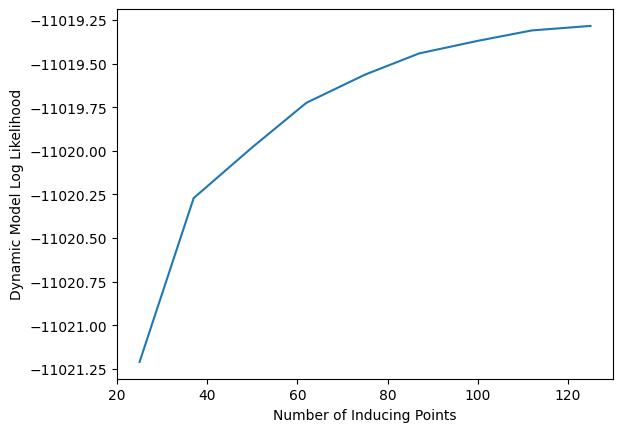

In [46]:
data = list(results.values())
gene_0_stats = [i.iloc[0] for i in data]
gene_0_dynamic = [i.Dynamic_model_log_likelihood for i in gene_0_stats]
gene_0_constant = [i.Constant_model_log_likelihood for i in gene_0_stats]

plt.plot(list(results.keys()), gene_0_dynamic)
plt.ylabel("Dynamic Model Log Likelihood")
plt.xlabel("Number of Inducing Points")
gene_0_dynamic

[0.00030369439446076285,
 2.27245662626774,
 2.649268794346426,
 2.9717840482699103,
 3.1701729095530027,
 3.3188258297050197,
 3.4093970516441914,
 3.483611650819512,
 3.514632623440775]

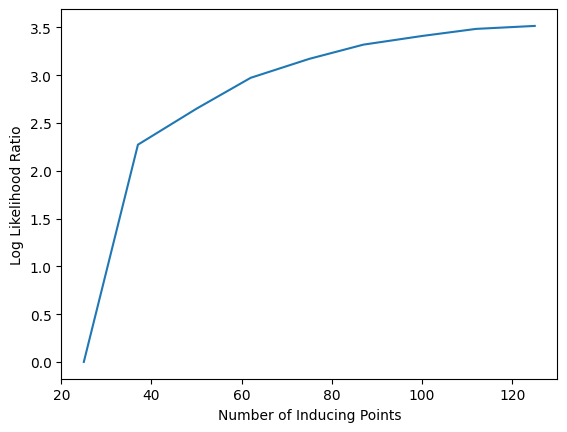

In [48]:
gene_0_llr = [i.log_likelihood_ratio for i in gene_0_stats]
plt.plot(list(results.keys()), gene_0_llr)
plt.ylabel("Log Likelihood Ratio")
plt.xlabel("Number of Inducing Points")
gene_0_llr


In [139]:
import seaborn as sns

test = dict()


    
test


{0: {'dynamic': [-11021.210454229951,
   -11020.270862197653,
   -11019.979690475688,
   -11019.724436616378,
   -11019.563007190227,
   -11019.441326834078,
   -11019.369287723765,
   -11019.309549591562,
   -11019.283703287525],
  'constant': [-11021.210757924346,
   -11022.54331882392,
   -11022.628959270034,
   -11022.696220664648,
   -11022.73318009978,
   -11022.760152663783,
   -11022.778684775409,
   -11022.793161242382,
   -11022.798335910966]},
 1: {'dynamic': [-11002.209374307493,
   -10999.882736652324,
   -10998.161139598042,
   -10996.149516200065,
   -10995.105761583076,
   -10994.354808347509,
   -10993.532975309052,
   -10992.955001870934,
   -10992.464667506187],
  'constant': [-11014.591499562748,
   -11014.66949766786,
   -11014.751637396503,
   -11014.7975974288,
   -11014.830888473813,
   -11014.850533135901,
   -11014.877857755799,
   -11014.89255506973,
   -11014.908557315468]},
 2: {'dynamic': [-10934.23378735857,
   -10930.809571092113,
   -10929.294284375646,

[0.9999992141359964,
 0.999999544601498,
 0.999999731452081,
 0.9999998876303152,
 0.9999999422731864,
 0.9999999704336185,
 0.9999999905549851,
 0.9999999980102684,
 1.0]

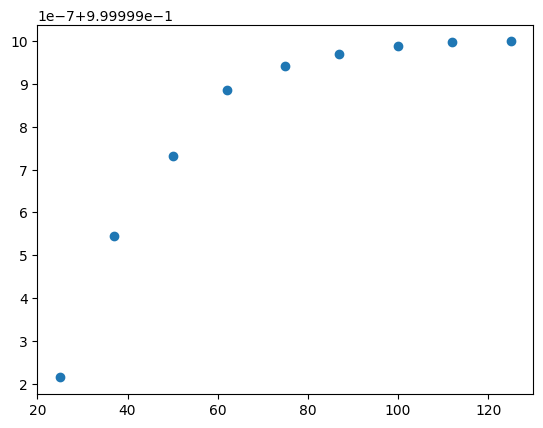

In [66]:

plt.scatter(inducing_points, r_values[1])
r_values[1]

[1.0,
 0.9999999999498546,
 0.9999999997886262,
 0.9999999996498854,
 0.999999999527642,
 0.9999999994469361,
 0.9999999993241,
 0.9999999992529385,
 0.9999999991714095]

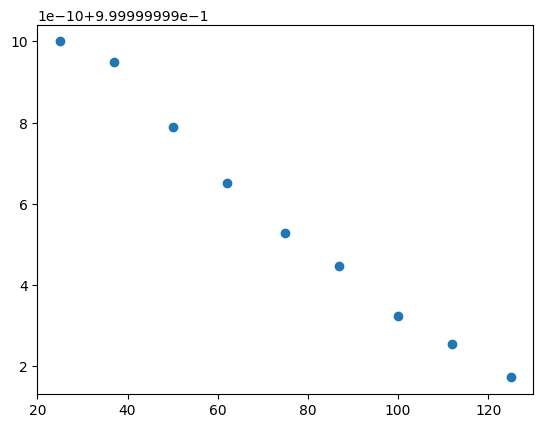

In [72]:

plt.scatter(inducing_points, constant_r_values[1])
constant_r_values[1]

slope: 6.51541635158772e-07, r: 0.804427255568087


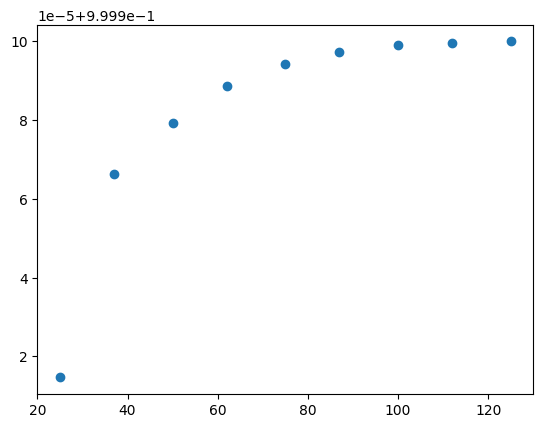

In [116]:
lls = []
ip25 = [test[i]["dynamic"][0] for i in range(200)]
ip37 = [test[i]["dynamic"][1] for i in range(200)]
ip50 = [test[i]["dynamic"][2] for i in range(200)]
ip62 = [test[i]["dynamic"][3] for i in range(200)]
ip75 = [test[i]["dynamic"][4] for i in range(200)]
ip87 = [test[i]["dynamic"][5] for i in range(200)]
ip100 = [test[i]["dynamic"][6] for i in range(200)]
ip112 = [test[i]["dynamic"][7] for i in range(200)]
ip125 = [test[i]["dynamic"][8] for i in range(200)]

lls =[ip25, ip37, ip50, ip62, ip75, ip87, ip100, ip112, ip125]

rvals = []
for i in range(9):
    slope, intercept, r, p, se = scipy.stats.linregress(lls[i], ip125)
    rvals.append(r)
    
plt.scatter(inducing_points, rvals)
slope, intercept, r, p, se = scipy.stats.linregress(inducing_points, rvals)
print(f"slope: {slope}, r: {r}")

slope: 3.2854732938241084e-08, r: 0.8899904084720627


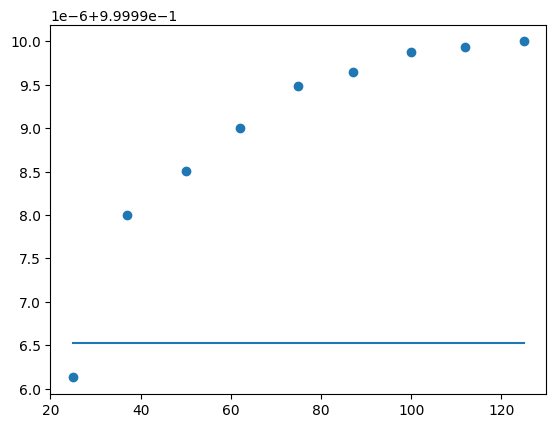

In [128]:
lls = []
ip25 = [test[i]["constant"][0] for i in range(200)]
ip37 = [test[i]["constant"][1] for i in range(200)]
ip50 = [test[i]["constant"][2] for i in range(200)]
ip62 = [test[i]["constant"][3] for i in range(200)]
ip75 = [test[i]["constant"][4] for i in range(200)]
ip87 = [test[i]["constant"][5] for i in range(200)]
ip100 = [test[i]["constant"][6] for i in range(200)]
ip112 = [test[i]["constant"][7] for i in range(200)]
ip125 = [test[i]["constant"][8] for i in range(200)]

lls =[ip25, ip37, ip50, ip62, ip75, ip87, ip100, ip112, ip125]

constant_rvals = []
for i in range(9):
    slope, intercept, r, p, se = scipy.stats.linregress(lls[i], ip125)
    constant_rvals.append(r)
    
plt.scatter(inducing_points, constant_rvals)
plt.plot(inducing_points, yhat)

slope, intercept, r, p, se = scipy.stats.linregress(inducing_points, constant_rvals)
print(f"slope: {slope}, r: {r}")

In [263]:
results[125].q_value

gene_0      1.484968e-02
gene_1      8.694018e-11
gene_2      6.045708e-11
gene_3      2.620434e-10
gene_4      1.040609e-12
gene_5      4.745190e-11
gene_6      1.598721e-14
gene_7      2.642533e-07
gene_8      2.729469e-09
gene_9      2.874041e-06
gene_10     6.457938e-08
gene_11     1.646422e-06
gene_12     2.211561e-06
gene_13     0.000000e+00
gene_14     1.032168e-08
gene_15     3.229163e-13
gene_16     2.012425e-12
gene_17     0.000000e+00
gene_18     2.077646e-05
gene_19     1.422658e-10
gene_20     0.000000e+00
gene_21     0.000000e+00
gene_22     0.000000e+00
gene_23     3.239378e-11
gene_24     4.771089e-04
gene_25     7.581462e-10
gene_26     0.000000e+00
gene_27     1.832626e-11
gene_28     3.968746e-07
gene_29     4.274461e-06
gene_30     2.578883e-10
gene_31     2.532696e-13
gene_32     1.157183e-02
gene_33     9.368775e-08
gene_34     1.750495e-04
gene_35     0.000000e+00
gene_36     0.000000e+00
gene_37     6.601386e-12
gene_38     0.000000e+00
gene_39     2.508752e-09


local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
RBF: alpha = 0.15324981290958908


  0%|          | 1/200 [00:04<15:58,  4.82s/it]

Constant: alpha = 0.15479842374609326
init var = 0.18251461718044104
init var = 0.18251461718044104
RBF: alpha = 0.15522531807470907


  1%|          | 2/200 [00:09<16:12,  4.91s/it]

Constant: alpha = 0.16223149823828747
init var = 0.18000540577120072
init var = 0.18000540577120072
RBF: alpha = 0.15152405083481355


  2%|▏         | 3/200 [00:14<16:05,  4.90s/it]

Constant: alpha = 0.15767915070932076
init var = 0.1921429335440517
init var = 0.1921429335440517
RBF: alpha = 0.16522872132048855


  2%|▏         | 4/200 [00:19<16:15,  4.98s/it]

Constant: alpha = 0.17122564993907302
init var = 0.1887938826065735
init var = 0.1887938826065735
RBF: alpha = 0.15585151392504332


  2%|▎         | 5/200 [00:25<16:37,  5.12s/it]

Constant: alpha = 0.16439319990796183
init var = 0.18737822723402664
init var = 0.18737822723402664
RBF: alpha = 0.15846706499608285


  3%|▎         | 6/200 [00:30<16:32,  5.11s/it]

Constant: alpha = 0.16478217035970677
init var = 0.18732651649812093
init var = 0.18732651649812093
RBF: alpha = 0.15811407650208176


  4%|▎         | 7/200 [00:35<16:21,  5.08s/it]

Constant: alpha = 0.16626168769075397
init var = 0.19354170487427427
init var = 0.19354170487427427
RBF: alpha = 0.16658115279456037


  4%|▍         | 8/200 [00:40<16:26,  5.14s/it]

Constant: alpha = 0.17080473397792237
init var = 0.1923241018126761
init var = 0.1923241018126761
RBF: alpha = 0.1641508242733693


  4%|▍         | 9/200 [00:45<16:17,  5.12s/it]

Constant: alpha = 0.16979505340661766
init var = 0.18638064347084013
init var = 0.18638064347084013
RBF: alpha = 0.1588625061461989


  5%|▌         | 10/200 [00:50<16:17,  5.15s/it]

Constant: alpha = 0.162697193259891
init var = 0.177992338582621
init var = 0.177992338582621
RBF: alpha = 0.15271231221115386


  6%|▌         | 11/200 [00:56<16:19,  5.18s/it]

Constant: alpha = 0.15651089671268684
init var = 0.18447085534053428
init var = 0.18447085534053428
RBF: alpha = 0.1596446156636176


  6%|▌         | 12/200 [01:01<16:03,  5.13s/it]

Constant: alpha = 0.16481117923422434
init var = 0.1902721063236217
init var = 0.1902721063236217
RBF: alpha = 0.16317139185232113


  6%|▋         | 13/200 [01:06<15:48,  5.07s/it]

Constant: alpha = 0.16805443202285464
init var = 0.1849184529630658
init var = 0.1849184529630658
RBF: alpha = 0.14654398200215696


  7%|▋         | 14/200 [01:11<15:53,  5.13s/it]

Constant: alpha = 0.16401081448034543
init var = 0.18444693157085426
init var = 0.18444693157085426
RBF: alpha = 0.16045664181927793


  8%|▊         | 15/200 [01:16<15:38,  5.07s/it]

Constant: alpha = 0.16536891126555964
init var = 0.19873891074175937
init var = 0.19873891074175937
RBF: alpha = 0.16521805933179


  8%|▊         | 16/200 [01:21<15:32,  5.07s/it]

Constant: alpha = 0.17347083180097198
init var = 0.17764990330326758
init var = 0.17764990330326758
RBF: alpha = 0.1489920438788522


  8%|▊         | 17/200 [01:26<15:23,  5.04s/it]

Constant: alpha = 0.15693372600756963
init var = 0.18153544791815612
init var = 0.18153544791815612
RBF: alpha = 0.15390478873612737


  9%|▉         | 18/200 [01:31<15:21,  5.07s/it]

Constant: alpha = 0.16252699693867814
init var = 0.18524483308882922
init var = 0.18524483308882922
RBF: alpha = 0.16057233418917888


 10%|▉         | 19/200 [01:36<15:18,  5.07s/it]

Constant: alpha = 0.16459040623904397
init var = 0.18572068182867993
init var = 0.18572068182867993
RBF: alpha = 0.15750898587685508


 10%|█         | 20/200 [01:41<15:05,  5.03s/it]

Constant: alpha = 0.16379315255674404
init var = 0.19139597729186733
init var = 0.19139597729186733
RBF: alpha = 0.16030752718026314


 10%|█         | 21/200 [01:46<15:07,  5.07s/it]

Constant: alpha = 0.1695436279194824
init var = 0.19780558868161255
init var = 0.19780558868161255
RBF: alpha = 0.16104935347286015


 11%|█         | 22/200 [01:51<15:15,  5.14s/it]

Constant: alpha = 0.17372575020649889
init var = 0.18453820177869465
init var = 0.18453820177869465
RBF: alpha = 0.15178831829424638


 12%|█▏        | 23/200 [01:57<15:35,  5.29s/it]

Constant: alpha = 0.16128242367931483
init var = 0.19186909835028979
init var = 0.19186909835028979
RBF: alpha = 0.1616419518389588


 12%|█▏        | 24/200 [02:02<15:22,  5.24s/it]

Constant: alpha = 0.1683397478896238
init var = 0.1889005655829684
init var = 0.1889005655829684
RBF: alpha = 0.16360285699593818


 12%|█▎        | 25/200 [02:07<15:10,  5.20s/it]

Constant: alpha = 0.16575788951445808
init var = 0.18072864509513253
init var = 0.18072864509513253
RBF: alpha = 0.15370493398234503


 13%|█▎        | 26/200 [02:13<15:10,  5.23s/it]

Constant: alpha = 0.15974871556020442
init var = 0.2009816248959529
init var = 0.2009816248959529
RBF: alpha = 0.16237110664630838


 14%|█▎        | 27/200 [02:18<15:06,  5.24s/it]

Constant: alpha = 0.17967045905662482
init var = 0.1838415573093989
init var = 0.1838415573093989
RBF: alpha = 0.15644700240637324


 14%|█▍        | 28/200 [02:23<14:52,  5.19s/it]

Constant: alpha = 0.16235066813326832
init var = 0.1817310817419547
init var = 0.1817310817419547
RBF: alpha = 0.1542884020038207


 14%|█▍        | 29/200 [02:28<14:39,  5.15s/it]

Constant: alpha = 0.15942192389618368
init var = 0.17625381988203034
init var = 0.17625381988203034
RBF: alpha = 0.15080800363549268


 15%|█▌        | 30/200 [02:33<14:30,  5.12s/it]

Constant: alpha = 0.1550240461015152
init var = 0.18553700784835195
init var = 0.18553700784835195
RBF: alpha = 0.1562196475947376


 16%|█▌        | 31/200 [02:38<14:42,  5.22s/it]

Constant: alpha = 0.16247260592347615
init var = 0.19236641528719614
init var = 0.19236641528719614
RBF: alpha = 0.16306891265004303


 16%|█▌        | 32/200 [02:44<14:32,  5.20s/it]

Constant: alpha = 0.17128908043382055
init var = 0.18228659248098908
init var = 0.18228659248098908
RBF: alpha = 0.1576479489714952


 16%|█▋        | 33/200 [02:48<14:12,  5.11s/it]

Constant: alpha = 0.15961207358500656
init var = 0.19047177164061346
init var = 0.19047177164061346
RBF: alpha = 0.16214447600642692


 17%|█▋        | 34/200 [02:53<14:02,  5.07s/it]

Constant: alpha = 0.16712739956305883
init var = 0.20202173923435887
init var = 0.20202173923435887
RBF: alpha = 0.1770720700127298


 18%|█▊        | 35/200 [02:58<13:41,  4.98s/it]

Constant: alpha = 0.1802002336239688
init var = 0.1935189554064219
init var = 0.1935189554064219
RBF: alpha = 0.16135250962359282


 18%|█▊        | 36/200 [03:03<13:38,  4.99s/it]

Constant: alpha = 0.17083192820134474
init var = 0.19467594187965717
init var = 0.19467594187965717
RBF: alpha = 0.16515732435196986


 18%|█▊        | 37/200 [03:08<13:31,  4.98s/it]

Constant: alpha = 0.17505386837245393
init var = 0.18847907645774553
init var = 0.18847907645774553
RBF: alpha = 0.15926026038578314


 19%|█▉        | 38/200 [03:13<13:37,  5.04s/it]

Constant: alpha = 0.16572020734687617
init var = 0.19355017489076787
init var = 0.19355017489076787
RBF: alpha = 0.1636918516376239


 20%|█▉        | 39/200 [03:18<13:33,  5.05s/it]

Constant: alpha = 0.1753159723138709
init var = 0.1913045872591859
init var = 0.1913045872591859
RBF: alpha = 0.16204862250562163


 20%|██        | 40/200 [03:23<13:22,  5.02s/it]

Constant: alpha = 0.16765830606482895
init var = 0.18457299616846984
init var = 0.18457299616846984
RBF: alpha = 0.1586154036670835


 20%|██        | 41/200 [03:29<13:40,  5.16s/it]

Constant: alpha = 0.16296713000381657
init var = 0.1820636409477672
init var = 0.1820636409477672
RBF: alpha = 0.15991637627917332


 21%|██        | 42/200 [03:34<13:44,  5.22s/it]

Constant: alpha = 0.1652710085773012
init var = 0.18804719416997015
init var = 0.18804719416997015
RBF: alpha = 0.15264583122779113


 22%|██▏       | 43/200 [03:39<13:36,  5.20s/it]

Constant: alpha = 0.16321690415465825
init var = 0.177299570879259
init var = 0.177299570879259
RBF: alpha = 0.14865482531192412


 22%|██▏       | 44/200 [03:44<13:17,  5.12s/it]

Constant: alpha = 0.1567059987610894
init var = 0.19255487686240394
init var = 0.19255487686240394
RBF: alpha = 0.16570793291279315


 22%|██▎       | 45/200 [03:50<13:20,  5.16s/it]

Constant: alpha = 0.1721898936707322
init var = 0.1765970923511116
init var = 0.1765970923511116
RBF: alpha = 0.15108664044904338


 23%|██▎       | 46/200 [03:55<13:03,  5.09s/it]

Constant: alpha = 0.15433101485192488
init var = 0.18769385603696961
init var = 0.18769385603696961
RBF: alpha = 0.1562041296462048


 24%|██▎       | 47/200 [04:00<13:08,  5.15s/it]

Constant: alpha = 0.1634351514707157
init var = 0.18984293832684115
init var = 0.18984293832684115
RBF: alpha = 0.16348655258980566


 24%|██▍       | 48/200 [04:05<13:05,  5.17s/it]

Constant: alpha = 0.1694368510179278
init var = 0.1884007141926594
init var = 0.1884007141926594
RBF: alpha = 0.1597264853621157


 24%|██▍       | 49/200 [04:10<12:57,  5.15s/it]

Constant: alpha = 0.16642264935355192
init var = 0.19615933672280747
init var = 0.19615933672280747
RBF: alpha = 0.1653305880679979


 25%|██▌       | 50/200 [04:15<12:42,  5.08s/it]

Constant: alpha = 0.17481313876071164
init var = 0.20201470484454842
init var = 0.20201470484454842
RBF: alpha = 0.1730779731770924


 26%|██▌       | 51/200 [04:20<12:43,  5.13s/it]

Constant: alpha = 0.17898632818043175
init var = 0.19463762723792183
init var = 0.19463762723792183
RBF: alpha = 0.16404487807277945


 26%|██▌       | 52/200 [04:26<12:43,  5.16s/it]

Constant: alpha = 0.17247878119399643
init var = 0.19098503329883548
init var = 0.19098503329883548
RBF: alpha = 0.16003552237808294


 26%|██▋       | 53/200 [04:30<12:26,  5.08s/it]

Constant: alpha = 0.165237816773368
init var = 0.18712982968275874
init var = 0.18712982968275874
RBF: alpha = 0.15961812776499268


 27%|██▋       | 54/200 [04:35<12:17,  5.05s/it]

Constant: alpha = 0.16640400902972133
init var = 0.18744691883764936
init var = 0.18744691883764936
RBF: alpha = 0.1615715360276062


 28%|██▊       | 55/200 [04:40<12:07,  5.02s/it]

Constant: alpha = 0.16598997233827992
init var = 0.19139035078235467
init var = 0.19139035078235467
RBF: alpha = 0.15963868979364323


 28%|██▊       | 56/200 [04:45<12:06,  5.04s/it]

Constant: alpha = 0.16834431680145812
init var = 0.18500353552243082
init var = 0.18500353552243082
RBF: alpha = 0.15691257042707138


 28%|██▊       | 57/200 [04:50<11:55,  5.00s/it]

Constant: alpha = 0.165165752205624
init var = 0.19212405939913216
init var = 0.19212405939913216
RBF: alpha = 0.16330788060446846


 29%|██▉       | 58/200 [04:56<12:00,  5.07s/it]

Constant: alpha = 0.16894764663782702
init var = 0.18615977908643203
init var = 0.18615977908643203
RBF: alpha = 0.16359257043035386


 30%|██▉       | 59/200 [05:01<12:08,  5.17s/it]

Constant: alpha = 0.1653865081168571
init var = 0.17855720455888277
init var = 0.17855720455888277
RBF: alpha = 0.15146346360173468


 30%|███       | 60/200 [05:06<12:06,  5.19s/it]

Constant: alpha = 0.1568550341143958
init var = 0.187905604589803
init var = 0.187905604589803
RBF: alpha = 0.1618319862195244


 30%|███       | 61/200 [05:11<11:52,  5.12s/it]

Constant: alpha = 0.16725210589702844
init var = 0.19134614729784766
init var = 0.19134614729784766
RBF: alpha = 0.16062830698326283


 31%|███       | 62/200 [05:17<12:00,  5.22s/it]

Constant: alpha = 0.1690110484769047
init var = 0.19189906313280275
init var = 0.19189906313280275
RBF: alpha = 0.16098250262471578


 32%|███▏      | 63/200 [05:22<12:04,  5.29s/it]

Constant: alpha = 0.16932365366480187
init var = 0.18712470334654238
init var = 0.18712470334654238
RBF: alpha = 0.1607783001191227


 32%|███▏      | 64/200 [05:27<11:58,  5.29s/it]

Constant: alpha = 0.16517874178228314
init var = 0.19439237761994174
init var = 0.19439237761994174
RBF: alpha = 0.16727910106911623


 32%|███▎      | 65/200 [05:33<11:50,  5.26s/it]

Constant: alpha = 0.17288073275220642
init var = 0.19138408821344913
init var = 0.19138408821344913
RBF: alpha = 0.15590916401792362


 33%|███▎      | 66/200 [05:38<11:54,  5.33s/it]

Constant: alpha = 0.16935909605238025
init var = 0.18513405506523897
init var = 0.18513405506523897
RBF: alpha = 0.1597839670937656


 34%|███▎      | 67/200 [05:43<11:25,  5.16s/it]

Constant: alpha = 0.16449652129296882
init var = 0.17700980984565523
init var = 0.17700980984565523
RBF: alpha = 0.1523033188067974


 34%|███▍      | 68/200 [05:48<11:28,  5.22s/it]

Constant: alpha = 0.1553587867870876
init var = 0.18050577785314337
init var = 0.18050577785314337
RBF: alpha = 0.15082153391462227


 34%|███▍      | 69/200 [05:53<11:23,  5.21s/it]

Constant: alpha = 0.15763161837192935
init var = 0.1871306327538262
init var = 0.1871306327538262
RBF: alpha = 0.15721658023836355


 35%|███▌      | 70/200 [05:58<11:08,  5.14s/it]

Constant: alpha = 0.16175743809232987
init var = 0.1937282793998751
init var = 0.1937282793998751
RBF: alpha = 0.16048512256091443


 36%|███▌      | 71/200 [06:04<11:04,  5.15s/it]

Constant: alpha = 0.16773488015814667
init var = 0.18077769827211718
init var = 0.18077769827211718
RBF: alpha = 0.14941446760588598


 36%|███▌      | 72/200 [06:09<10:53,  5.11s/it]

Constant: alpha = 0.15770761587693763
init var = 0.19934288541023323
init var = 0.19934288541023323
RBF: alpha = 0.16944649930923364


 36%|███▋      | 73/200 [06:14<10:47,  5.10s/it]

Constant: alpha = 0.17307423657852322
init var = 0.1812393572341548
init var = 0.1812393572341548
RBF: alpha = 0.1513559298548547


 37%|███▋      | 74/200 [06:19<10:51,  5.17s/it]

Constant: alpha = 0.16118624283574753
init var = 0.18118803996273408
init var = 0.18118803996273408
RBF: alpha = 0.15708658836055142


 38%|███▊      | 75/200 [06:24<10:51,  5.21s/it]

Constant: alpha = 0.16021105023878238
init var = 0.1946824148352581
init var = 0.1946824148352581
RBF: alpha = 0.16988707633494887


 38%|███▊      | 76/200 [06:29<10:40,  5.17s/it]

Constant: alpha = 0.1754800292603443
init var = 0.1928627990940652
init var = 0.1928627990940652
RBF: alpha = 0.16807199216690916


 38%|███▊      | 77/200 [06:34<10:29,  5.12s/it]

Constant: alpha = 0.17047547415593242
init var = 0.18950380636391354
init var = 0.18950380636391354
RBF: alpha = 0.15719216096237792


 39%|███▉      | 78/200 [06:40<10:42,  5.27s/it]

Constant: alpha = 0.1679641602707269
init var = 0.17661892455398379
init var = 0.17661892455398379
RBF: alpha = 0.15025813085394307


 40%|███▉      | 79/200 [06:45<10:33,  5.23s/it]

Constant: alpha = 0.15520059533853295
init var = 0.19723990422634793
init var = 0.19723990422634793
RBF: alpha = 0.16702838857839047


 40%|████      | 80/200 [06:50<10:27,  5.23s/it]

Constant: alpha = 0.17167186858579522
init var = 0.19027795894115634
init var = 0.19027795894115634
RBF: alpha = 0.16246790974249783


 40%|████      | 81/200 [06:55<10:16,  5.18s/it]

Constant: alpha = 0.1683053848217619
init var = 0.1879455569989547
init var = 0.1879455569989547
RBF: alpha = 0.15969874382073085


 41%|████      | 82/200 [07:00<10:00,  5.09s/it]

Constant: alpha = 0.16566707378278184
init var = 0.18236320995023894
init var = 0.18236320995023894
RBF: alpha = 0.1544870822427353


 42%|████▏     | 83/200 [07:05<09:51,  5.05s/it]

Constant: alpha = 0.16275102264313407
init var = 0.17965925674475883
init var = 0.17965925674475883
RBF: alpha = 0.1530061506763965


 42%|████▏     | 84/200 [07:10<09:39,  5.00s/it]

Constant: alpha = 0.15677654489027104
init var = 0.19986860116046415
init var = 0.19986860116046415
RBF: alpha = 0.16575400806338328


 42%|████▎     | 85/200 [07:15<09:35,  5.00s/it]

Constant: alpha = 0.17338475638759898
init var = 0.18643878548815637
init var = 0.18643878548815637
RBF: alpha = 0.15876558650552194


 43%|████▎     | 86/200 [07:20<09:34,  5.04s/it]

Constant: alpha = 0.16277314894169234
init var = 0.19556701897434078
init var = 0.19556701897434078
RBF: alpha = 0.15762590973596077


 44%|████▎     | 87/200 [07:25<09:28,  5.03s/it]

Constant: alpha = 0.171492867472185
init var = 0.19426152981215236
init var = 0.19426152981215236
RBF: alpha = 0.16466184304112602


 44%|████▍     | 88/200 [07:30<09:26,  5.06s/it]

Constant: alpha = 0.17046036717343224
init var = 0.1911426452140504
init var = 0.1911426452140504
RBF: alpha = 0.16411469578321858


 44%|████▍     | 89/200 [07:36<09:26,  5.11s/it]

Constant: alpha = 0.16839373776159355
init var = 0.18481070816440756
init var = 0.18481070816440756
RBF: alpha = 0.15936570699242067


 45%|████▌     | 90/200 [07:41<09:27,  5.16s/it]

Constant: alpha = 0.1635993504099898
init var = 0.19173431483439168
init var = 0.19173431483439168
RBF: alpha = 0.15948004455428513


 46%|████▌     | 91/200 [07:48<10:14,  5.63s/it]

Constant: alpha = 0.16800382227918292
init var = 0.19224626624249794
init var = 0.19224626624249794
RBF: alpha = 0.16729983491243383


 46%|████▌     | 92/200 [07:53<09:58,  5.54s/it]

Constant: alpha = 0.17196932994545103
init var = 0.17678398557556924
init var = 0.17678398557556924
RBF: alpha = 0.15082008014111745


 46%|████▋     | 93/200 [07:59<09:55,  5.56s/it]

Constant: alpha = 0.15742317462686928
init var = 0.19169658675863435
init var = 0.19169658675863435
RBF: alpha = 0.16405267619306269


 47%|████▋     | 94/200 [08:04<09:38,  5.46s/it]

Constant: alpha = 0.1696340547385394
init var = 0.1897264007196931
init var = 0.1897264007196931
RBF: alpha = 0.157992261030268


 48%|████▊     | 95/200 [08:09<09:31,  5.44s/it]

Constant: alpha = 0.1647284641206621
init var = 0.1996002208094495
init var = 0.1996002208094495
RBF: alpha = 0.16198121291228137


 48%|████▊     | 96/200 [08:15<09:25,  5.44s/it]

Constant: alpha = 0.17492535789767275
init var = 0.19207613869801285
init var = 0.19207613869801285
RBF: alpha = 0.16597639691276733


 48%|████▊     | 97/200 [08:20<09:09,  5.33s/it]

Constant: alpha = 0.17212161442065216
init var = 0.18026366288436121
init var = 0.18026366288436121
RBF: alpha = 0.15538831799582495


 49%|████▉     | 98/200 [08:25<08:59,  5.29s/it]

Constant: alpha = 0.15879305437099178
init var = 0.1915906854044125
init var = 0.1915906854044125
RBF: alpha = 0.1576180594753442


 50%|████▉     | 99/200 [08:30<08:51,  5.26s/it]

Constant: alpha = 0.1700539325234627
init var = 0.1817185952749986
init var = 0.1817185952749986
RBF: alpha = 0.14821588674410896


 50%|█████     | 100/200 [08:35<08:47,  5.27s/it]

Constant: alpha = 0.15856814294559998
init var = 0.24754831416919856
init var = 0.24754831416919856
RBF: alpha = 0.22515014878155595


 50%|█████     | 101/200 [08:40<08:17,  5.03s/it]

Constant: alpha = 0.2251657773276829
init var = 0.27070996502769
init var = 0.27070996502769
RBF: alpha = 0.24466794191586502


 51%|█████     | 102/200 [08:45<08:13,  5.04s/it]

Constant: alpha = 0.24582067599245327
init var = 0.259533520129815
init var = 0.259533520129815
RBF: alpha = 0.23416593259603533


 52%|█████▏    | 103/200 [08:50<08:08,  5.03s/it]

Constant: alpha = 0.2356285963928726
init var = 0.2726707165969728
init var = 0.2726707165969728
RBF: alpha = 0.2426169619184586


 52%|█████▏    | 104/200 [08:55<08:03,  5.04s/it]

Constant: alpha = 0.24549863508867506
init var = 0.2847883074191565
init var = 0.2847883074191565
RBF: alpha = 0.25749876858437787


 52%|█████▎    | 105/200 [09:00<07:49,  4.94s/it]

Constant: alpha = 0.2575351312389038
init var = 0.25888862758786635
init var = 0.25888862758786635
RBF: alpha = 0.23762934735619348


 53%|█████▎    | 106/200 [09:04<07:34,  4.84s/it]

Constant: alpha = 0.2378834705399368
init var = 0.25287073283496503
init var = 0.25287073283496503
RBF: alpha = 0.22733845882988896


 54%|█████▎    | 107/200 [09:10<07:46,  5.02s/it]

Constant: alpha = 0.22928335473729775
init var = 0.2581356228386315
init var = 0.2581356228386315
RBF: alpha = 0.23507210283283494


 54%|█████▍    | 108/200 [09:15<07:39,  4.99s/it]

Constant: alpha = 0.23647333605528004
init var = 0.27270522961818244
init var = 0.27270522961818244
RBF: alpha = 0.24720805787840508


 55%|█████▍    | 109/200 [09:19<07:30,  4.95s/it]

Constant: alpha = 0.24825609620520797
init var = 0.267723275748422
init var = 0.267723275748422
RBF: alpha = 0.24152072749076572


 55%|█████▌    | 110/200 [09:24<07:16,  4.85s/it]

Constant: alpha = 0.24151984417280897
init var = 0.26235340469849927
init var = 0.26235340469849927
RBF: alpha = 0.23665174662034405


 56%|█████▌    | 111/200 [09:29<07:11,  4.85s/it]

Constant: alpha = 0.2371580848012718
init var = 0.2630835125392173
init var = 0.2630835125392173
RBF: alpha = 0.23762905916947927


 56%|█████▌    | 112/200 [09:33<06:53,  4.70s/it]

Constant: alpha = 0.23766867982124903
init var = 0.27673341112442473
init var = 0.27673341112442473
RBF: alpha = 0.2534089762234735


 56%|█████▋    | 113/200 [09:38<06:43,  4.64s/it]

Constant: alpha = 0.25353466363022836
init var = 0.2736877114899321
init var = 0.2736877114899321
RBF: alpha = 0.24934230891020848


 57%|█████▋    | 114/200 [09:42<06:39,  4.64s/it]

Constant: alpha = 0.24990530664409583
init var = 0.2585729934586864
init var = 0.2585729934586864
RBF: alpha = 0.23945193286867456


 57%|█████▊    | 115/200 [09:48<06:45,  4.77s/it]

Constant: alpha = 0.2400103148622513
init var = 0.270269751498405
init var = 0.270269751498405
RBF: alpha = 0.24637388441174302


 58%|█████▊    | 116/200 [09:52<06:32,  4.67s/it]

Constant: alpha = 0.24640521913141192
init var = 0.26395550486170927
init var = 0.26395550486170927
RBF: alpha = 0.23476980561433008


 58%|█████▊    | 117/200 [09:57<06:30,  4.71s/it]

Constant: alpha = 0.2362366855714556
init var = 0.26842063217072093
init var = 0.26842063217072093
RBF: alpha = 0.24076304696563275


 59%|█████▉    | 118/200 [10:02<06:30,  4.77s/it]

Constant: alpha = 0.24397728772302757
init var = 0.2652369141470639
init var = 0.2652369141470639
RBF: alpha = 0.23444387274294026


 60%|█████▉    | 119/200 [10:06<06:24,  4.75s/it]

Constant: alpha = 0.2345838958282864
init var = 0.27431036807204234
init var = 0.27431036807204234
RBF: alpha = 0.24615276733927383


 60%|██████    | 120/200 [10:11<06:20,  4.75s/it]

Constant: alpha = 0.2470728415329913
init var = 0.2484928768979747
init var = 0.2484928768979747
RBF: alpha = 0.22508962040575015


 60%|██████    | 121/200 [10:16<06:08,  4.66s/it]

Constant: alpha = 0.22512154647683355
init var = 0.2572872810956378
init var = 0.2572872810956378
RBF: alpha = 0.23209066503064787


 61%|██████    | 122/200 [10:21<06:23,  4.92s/it]

Constant: alpha = 0.2346287724800544
init var = 0.2743254842045989
init var = 0.2743254842045989
RBF: alpha = 0.2494458554978375


 62%|██████▏   | 123/200 [10:26<06:20,  4.94s/it]

Constant: alpha = 0.2500925739733522
init var = 0.25354278072497166
init var = 0.25354278072497166
RBF: alpha = 0.22920226454936182


 62%|██████▏   | 124/200 [10:31<06:11,  4.89s/it]

Constant: alpha = 0.22923000841494767
init var = 0.26314084004905114
init var = 0.26314084004905114
RBF: alpha = 0.23979624935741006


 62%|██████▎   | 125/200 [10:35<05:56,  4.75s/it]

Constant: alpha = 0.23978441210244253
init var = 0.26291934438975806
init var = 0.26291934438975806
RBF: alpha = 0.2339135498463556


 63%|██████▎   | 126/200 [10:41<06:08,  4.98s/it]

Constant: alpha = 0.23429648017578403
init var = 0.2613391926805992
init var = 0.2613391926805992
RBF: alpha = 0.23795166792581393


 64%|██████▎   | 127/200 [10:46<06:01,  4.95s/it]

Constant: alpha = 0.23892522309720016
init var = 0.26445832528129154
init var = 0.26445832528129154
RBF: alpha = 0.23620927635003447


 64%|██████▍   | 128/200 [10:51<05:54,  4.93s/it]

Constant: alpha = 0.2374014175460781
init var = 0.2682535567882799
init var = 0.2682535567882799
RBF: alpha = 0.23968691758147792


 64%|██████▍   | 129/200 [10:55<05:40,  4.79s/it]

Constant: alpha = 0.23970424291602635
init var = 0.25971518639820923
init var = 0.25971518639820923
RBF: alpha = 0.23202965205119402


 65%|██████▌   | 130/200 [11:00<05:38,  4.84s/it]

Constant: alpha = 0.23593093271815035
init var = 0.2677535777461697
init var = 0.2677535777461697
RBF: alpha = 0.247054752045737


 66%|██████▌   | 131/200 [11:05<05:34,  4.85s/it]

Constant: alpha = 0.24813826385663984
init var = 0.274012594814589
init var = 0.274012594814589
RBF: alpha = 0.24353486222862095


 66%|██████▌   | 132/200 [11:09<05:25,  4.79s/it]

Constant: alpha = 0.24355785329078802
init var = 0.27202227021177317
init var = 0.27202227021177317
RBF: alpha = 0.24172728171279245


 66%|██████▋   | 133/200 [11:14<05:15,  4.71s/it]

Constant: alpha = 0.24175493998951803
init var = 0.26924059965330865
init var = 0.26924059965330865
RBF: alpha = 0.24951062991499026


 67%|██████▋   | 134/200 [11:19<05:07,  4.66s/it]

Constant: alpha = 0.24970991104016893
init var = 0.27095682300694146
init var = 0.27095682300694146
RBF: alpha = 0.2438364157357612


 68%|██████▊   | 135/200 [11:23<05:01,  4.64s/it]

Constant: alpha = 0.24384699811029842
init var = 0.27395243151846166
init var = 0.27395243151846166
RBF: alpha = 0.24862107081936868


 68%|██████▊   | 136/200 [11:28<05:01,  4.71s/it]

Constant: alpha = 0.24878240061363127
init var = 0.26093133809202884
init var = 0.26093133809202884
RBF: alpha = 0.23315969400416772


 68%|██████▊   | 137/200 [11:32<04:51,  4.62s/it]

Constant: alpha = 0.23313969531544465
init var = 0.2790149294451515
init var = 0.2790149294451515
RBF: alpha = 0.25162068946028393


 69%|██████▉   | 138/200 [11:37<04:50,  4.69s/it]

Constant: alpha = 0.25254768204264205
init var = 0.27667499432067677
init var = 0.27667499432067677
RBF: alpha = 0.2488894056583545


 70%|██████▉   | 139/200 [11:42<04:46,  4.69s/it]

Constant: alpha = 0.2512354472116192
init var = 0.25365106208211907
init var = 0.25365106208211907
RBF: alpha = 0.22643139326542228


 70%|███████   | 140/200 [11:46<04:35,  4.60s/it]

Constant: alpha = 0.2264646956561109
init var = 0.2815051933324125
init var = 0.2815051933324125
RBF: alpha = 0.25335070804001864


 70%|███████   | 141/200 [11:51<04:24,  4.49s/it]

Constant: alpha = 0.2533994827745977
init var = 0.2678332720622311
init var = 0.2678332720622311
RBF: alpha = 0.2463429168600953


 71%|███████   | 142/200 [11:56<04:29,  4.64s/it]

Constant: alpha = 0.24768836127963717
init var = 0.2800263183350793
init var = 0.2800263183350793
RBF: alpha = 0.25613900935542183


 72%|███████▏  | 143/200 [12:00<04:26,  4.68s/it]

Constant: alpha = 0.25667209727871115
init var = 0.2642347816705196
init var = 0.2642347816705196
RBF: alpha = 0.23649828478310286


 72%|███████▏  | 144/200 [12:05<04:25,  4.73s/it]

Constant: alpha = 0.23929820243967484
init var = 0.26208515209150907
init var = 0.26208515209150907
RBF: alpha = 0.23505804217462603


 72%|███████▎  | 145/200 [12:10<04:29,  4.89s/it]

Constant: alpha = 0.2389842831446118
init var = 0.28851171670152387
init var = 0.28851171670152387
RBF: alpha = 0.26085639170279207


 73%|███████▎  | 146/200 [12:15<04:16,  4.75s/it]

Constant: alpha = 0.2608768396724546
init var = 0.2559241961706752
init var = 0.2559241961706752
RBF: alpha = 0.2290501033606904


 74%|███████▎  | 147/200 [12:19<04:08,  4.70s/it]

Constant: alpha = 0.22912386797332415
init var = 0.26749370420998136
init var = 0.26749370420998136
RBF: alpha = 0.24186743412167666


 74%|███████▍  | 148/200 [12:24<04:00,  4.62s/it]

Constant: alpha = 0.2418684744609756
init var = 0.2607904999471453
init var = 0.2607904999471453
RBF: alpha = 0.23593207154999532


 74%|███████▍  | 149/200 [12:28<03:54,  4.59s/it]

Constant: alpha = 0.23594653497529935
init var = 0.2792994026767383
init var = 0.2792994026767383
RBF: alpha = 0.24781922457594002


 75%|███████▌  | 150/200 [12:33<03:55,  4.72s/it]

Constant: alpha = 0.24825405452513016
init var = 0.26306759791259493
init var = 0.26306759791259493
RBF: alpha = 0.23691300958174896


 76%|███████▌  | 151/200 [12:38<03:49,  4.68s/it]

Constant: alpha = 0.23693720348592298
init var = 0.26625108874599557
init var = 0.26625108874599557
RBF: alpha = 0.2405314544593334


 76%|███████▌  | 152/200 [12:43<03:46,  4.71s/it]

Constant: alpha = 0.241239695388363
init var = 0.27074558370051927
init var = 0.27074558370051927
RBF: alpha = 0.24182027879703688


 76%|███████▋  | 153/200 [12:48<03:41,  4.72s/it]

Constant: alpha = 0.24255693016883867
init var = 0.2721220670534556
init var = 0.2721220670534556
RBF: alpha = 0.24274176466180658


 77%|███████▋  | 154/200 [12:52<03:35,  4.69s/it]

Constant: alpha = 0.24273188820757097
init var = 0.2673923764003277
init var = 0.2673923764003277
RBF: alpha = 0.24070779291808314


 78%|███████▊  | 155/200 [12:57<03:26,  4.58s/it]

Constant: alpha = 0.24069588277854265
init var = 0.273349215180816
init var = 0.273349215180816
RBF: alpha = 0.24860375744031254


 78%|███████▊  | 156/200 [13:01<03:23,  4.63s/it]

Constant: alpha = 0.24861821255506386
init var = 0.2665539092759979
init var = 0.2665539092759979
RBF: alpha = 0.2444481041772918


 78%|███████▊  | 157/200 [13:06<03:19,  4.64s/it]

Constant: alpha = 0.2444926520995815
init var = 0.28290389705388297
init var = 0.28290389705388297
RBF: alpha = 0.25593865163276525


 79%|███████▉  | 158/200 [13:11<03:17,  4.70s/it]

Constant: alpha = 0.2564763466623008
init var = 0.26460610547014446
init var = 0.26460610547014446
RBF: alpha = 0.2377493545358237


 80%|███████▉  | 159/200 [13:16<03:14,  4.74s/it]

Constant: alpha = 0.23914974989346174
init var = 0.2547145943820514
init var = 0.2547145943820514
RBF: alpha = 0.2330676805633236


 80%|████████  | 160/200 [13:20<03:10,  4.76s/it]

Constant: alpha = 0.23422819750774077
init var = 0.2538440587871548
init var = 0.2538440587871548
RBF: alpha = 0.22942093752607787


 80%|████████  | 161/200 [13:26<03:13,  4.97s/it]

Constant: alpha = 0.23270997125870277
init var = 0.27024664543981397
init var = 0.27024664543981397
RBF: alpha = 0.2430107337658971


 81%|████████  | 162/200 [13:31<03:05,  4.88s/it]

Constant: alpha = 0.243006989115796
init var = 0.26027298083987455
init var = 0.26027298083987455
RBF: alpha = 0.23550601860894854


 82%|████████▏ | 163/200 [13:35<02:58,  4.82s/it]

Constant: alpha = 0.23550893883777746
init var = 0.2734235157268368
init var = 0.2734235157268368
RBF: alpha = 0.24311513914782487


 82%|████████▏ | 164/200 [13:40<02:50,  4.73s/it]

Constant: alpha = 0.243123553427844
init var = 0.2623005121323274
init var = 0.2623005121323274
RBF: alpha = 0.2368377685837819


 82%|████████▎ | 165/200 [13:45<02:45,  4.74s/it]

Constant: alpha = 0.23762870176266468
init var = 0.25903352511033134
init var = 0.25903352511033134
RBF: alpha = 0.2356001111774773


 83%|████████▎ | 166/200 [13:49<02:39,  4.70s/it]

Constant: alpha = 0.23579704773686538
init var = 0.2734318167177596
init var = 0.2734318167177596
RBF: alpha = 0.24849283548006298


 84%|████████▎ | 167/200 [13:54<02:33,  4.65s/it]

Constant: alpha = 0.24857340531671074
init var = 0.2831821747125523
init var = 0.2831821747125523
RBF: alpha = 0.2545414780522377


 84%|████████▍ | 168/200 [13:59<02:30,  4.71s/it]

Constant: alpha = 0.2564409206243219
init var = 0.25900189788777883
init var = 0.25900189788777883
RBF: alpha = 0.2376072319167677


 84%|████████▍ | 169/200 [14:03<02:26,  4.71s/it]

Constant: alpha = 0.23765769901604164
init var = 0.269549262720465
init var = 0.269549262720465
RBF: alpha = 0.24585413418562133


 85%|████████▌ | 170/200 [14:08<02:25,  4.83s/it]

Constant: alpha = 0.24656549959117785
init var = 0.2659220706572185
init var = 0.2659220706572185
RBF: alpha = 0.23471586761969088


 86%|████████▌ | 171/200 [14:13<02:21,  4.87s/it]

Constant: alpha = 0.23685879924472258
init var = 0.2539808744300411
init var = 0.2539808744300411
RBF: alpha = 0.23418031538548498


 86%|████████▌ | 172/200 [14:18<02:16,  4.89s/it]

Constant: alpha = 0.23530768956947884
init var = 0.2564971022467629
init var = 0.2564971022467629
RBF: alpha = 0.23337060554914307


 86%|████████▋ | 173/200 [14:23<02:15,  5.00s/it]

Constant: alpha = 0.23404788385946385
init var = 0.2552447087032609
init var = 0.2552447087032609
RBF: alpha = 0.23092758269052527


 87%|████████▋ | 174/200 [14:28<02:06,  4.86s/it]

Constant: alpha = 0.23093210911260498
init var = 0.2663331459818684
init var = 0.2663331459818684
RBF: alpha = 0.23942947808814075


 88%|████████▊ | 175/200 [14:33<02:02,  4.90s/it]

Constant: alpha = 0.23994116036183055
init var = 0.27183915227684335
init var = 0.27183915227684335
RBF: alpha = 0.24544145778239884


 88%|████████▊ | 176/200 [14:38<01:55,  4.79s/it]

Constant: alpha = 0.24548573737561483
init var = 0.2748613443407829
init var = 0.2748613443407829
RBF: alpha = 0.24330473605023306


 88%|████████▊ | 177/200 [14:43<01:51,  4.85s/it]

Constant: alpha = 0.2444183331440813
init var = 0.27582010172403976
init var = 0.27582010172403976
RBF: alpha = 0.25900878421009077


 89%|████████▉ | 178/200 [14:47<01:44,  4.77s/it]

Constant: alpha = 0.25899955132186014
init var = 0.2610182774129347
init var = 0.2610182774129347
RBF: alpha = 0.24033886474483696


 90%|████████▉ | 179/200 [14:52<01:39,  4.73s/it]

Constant: alpha = 0.2403273291477794
init var = 0.26348450541884405
init var = 0.26348450541884405
RBF: alpha = 0.23487260679609384


 90%|█████████ | 180/200 [14:56<01:33,  4.66s/it]

Constant: alpha = 0.2348931116021861
init var = 0.27214132482172354
init var = 0.27214132482172354
RBF: alpha = 0.24960113445351004


 90%|█████████ | 181/200 [15:01<01:29,  4.69s/it]

Constant: alpha = 0.2505750477839777
init var = 0.2723870180832515
init var = 0.2723870180832515
RBF: alpha = 0.24249504873945307


 91%|█████████ | 182/200 [15:06<01:25,  4.75s/it]

Constant: alpha = 0.2433502334080217
init var = 0.25545744762283645
init var = 0.25545744762283645
RBF: alpha = 0.23175117728673666


 92%|█████████▏| 183/200 [15:11<01:20,  4.76s/it]

Constant: alpha = 0.23328103530723174
init var = 0.25849400750209045
init var = 0.25849400750209045
RBF: alpha = 0.22861475390236352


 92%|█████████▏| 184/200 [15:16<01:17,  4.85s/it]

Constant: alpha = 0.2291746858389907
init var = 0.2646263792239976
init var = 0.2646263792239976
RBF: alpha = 0.23906035939405157


 92%|█████████▎| 185/200 [15:21<01:13,  4.87s/it]

Constant: alpha = 0.24071524281682644
init var = 0.2680809704736133
init var = 0.2680809704736133
RBF: alpha = 0.24333362537424236


 93%|█████████▎| 186/200 [15:25<01:06,  4.75s/it]

Constant: alpha = 0.24334652195146983
init var = 0.2620779371782713
init var = 0.2620779371782713
RBF: alpha = 0.23994291993036396


 94%|█████████▎| 187/200 [15:30<01:02,  4.79s/it]

Constant: alpha = 0.24114460150157058
init var = 0.2714576862802098
init var = 0.2714576862802098
RBF: alpha = 0.2493057460671121


 94%|█████████▍| 188/200 [15:35<00:56,  4.71s/it]

Constant: alpha = 0.2494268114081491
init var = 0.27842945594220175
init var = 0.27842945594220175
RBF: alpha = 0.24739934461663665


 94%|█████████▍| 189/200 [15:39<00:50,  4.62s/it]

Constant: alpha = 0.24737060986139764
init var = 0.26118754363608426
init var = 0.26118754363608426
RBF: alpha = 0.2355604837446675


 95%|█████████▌| 190/200 [15:44<00:47,  4.74s/it]

Constant: alpha = 0.23770427140056044
init var = 0.265121639390287
init var = 0.265121639390287
RBF: alpha = 0.24348721628876516


 96%|█████████▌| 191/200 [15:49<00:42,  4.78s/it]

Constant: alpha = 0.24549300766199633
init var = 0.2573889364245476
init var = 0.2573889364245476
RBF: alpha = 0.23406342264782226


 96%|█████████▌| 192/200 [15:54<00:39,  4.88s/it]

Constant: alpha = 0.23443712552021365
init var = 0.2652075625612113
init var = 0.2652075625612113
RBF: alpha = 0.2391716442052313


 96%|█████████▋| 193/200 [15:59<00:34,  4.90s/it]

Constant: alpha = 0.24082375857424052
init var = 0.26419333502003345
init var = 0.26419333502003345
RBF: alpha = 0.23682289551588814


 97%|█████████▋| 194/200 [16:03<00:28,  4.77s/it]

Constant: alpha = 0.23683284681484296
init var = 0.26765036301777884
init var = 0.26765036301777884
RBF: alpha = 0.23938579711057087


 98%|█████████▊| 195/200 [16:09<00:24,  4.91s/it]

Constant: alpha = 0.2411719260782274
init var = 0.2699417004631023
init var = 0.2699417004631023
RBF: alpha = 0.239726563432497


 98%|█████████▊| 196/200 [16:13<00:19,  4.80s/it]

Constant: alpha = 0.23972213313272184
init var = 0.27077532785667197
init var = 0.27077532785667197
RBF: alpha = 0.2479025727812736


 98%|█████████▊| 197/200 [16:18<00:14,  4.76s/it]

Constant: alpha = 0.24800298628341425
init var = 0.26395286283727565
init var = 0.26395286283727565
RBF: alpha = 0.23827773823140005


 99%|█████████▉| 198/200 [16:22<00:09,  4.70s/it]

Constant: alpha = 0.23881553041166553
init var = 0.26779168909991247
init var = 0.26779168909991247
RBF: alpha = 0.24043557462779755


100%|█████████▉| 199/200 [16:28<00:04,  4.91s/it]

Constant: alpha = 0.24177717167026483
init var = 0.26392585091956755
init var = 0.26392585091956755
RBF: alpha = 0.2395157141277149


100%|██████████| 200/200 [16:32<00:00,  4.96s/it]

Constant: alpha = 0.2394782735333157



/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


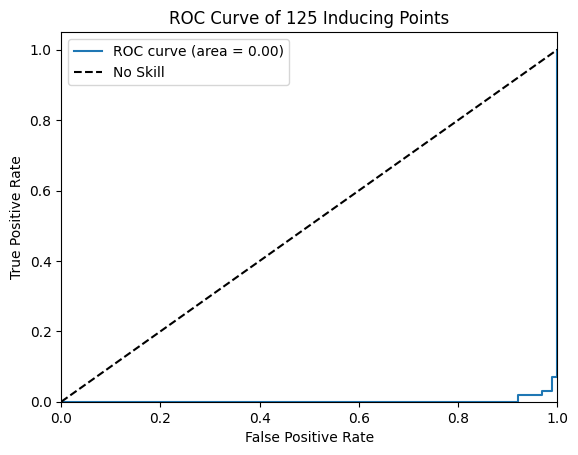

In [278]:
M = int((5 * len(X)) // 100)

gene_name = Y.index
gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf, M=M)
r1 = gpc1.One_sample_test()
res = gpc1.calculate_FDR(r1)
y_true = pd.DataFrame(adata.var['spatially_variable'])
fpr, tpr, thresholds = roc_curve(y_true, res.p_value)
roc_auc = auc(fpr, tpr)
aucs[M] = roc_auc
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve of {M} Inducing Points')

plt.legend()
plt.savefig(f'{M} Inducing Points')
results[M] = res

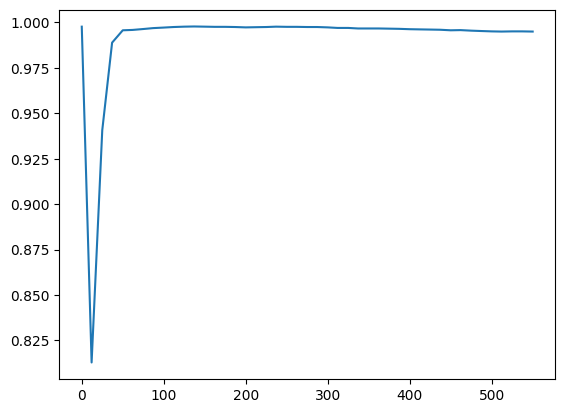

In [297]:
import sklearn.metrics 
roc_scores = []

for i in list(results.keys()):
    roc_scores.append(sklearn.metrics.roc_auc_score(y_true, results[i].log_likelihood_ratio.values))
    
plt.plot(list(results.keys()), roc_scores)

In [3]:
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [6]:
import scanpy as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
os.chdir(os.path.expanduser('/net/scratch2/f30033yc/GPcounts'))
from GPcountsDemo.RNA_seq_GP import rna_seq_gp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

tf.debugging.set_log_device_placement(True)


adata = sc.read_h5ad("/net/scratch2/f30033yc/GPcounts/demo_notebooks/sigma_0.5_alpha_0.8.h5ad")
Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                        index=adata.obs_names, 
                        columns=adata.var_names)

spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                    index=adata.obs_names, 
                                    columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

Y = Y.T
X = spatial_locations[['x', 'y']]

constant_aucs = {}
constant_results = {}


gene_name = Y.index
gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf)
r1 = gpc1.One_sample_test()
res = gpc1.calculate_FDR(r1)
y_true = pd.DataFrame(adata.var['spatially_variable'])
fpr, tpr, thresholds = roc_curve(y_true, res.log_likelihood_ratio)
roc_auc = auc(fpr, tpr)
constant_aucs[M] = roc_auc
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve of {M} Inducing Points')

plt.legend()
plt.savefig(f'{M} Inducing Points')
constant_results[M] = res




/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/tmp/5150906.1.nvidiagpu.q/ipykernel_9846/1107186137.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
125
RBF: alpha = 0.1532498129095889
1


  0%|          | 1/200 [00:04<15:46,  4.76s/it]

Constant: alpha = 0.15479660959391447
init var = 0.18251461718044104
init var = 0.18251461718044104
125
RBF: alpha = 0.15522531808157394
1


  1%|          | 2/200 [00:09<16:04,  4.87s/it]

Constant: alpha = 0.16224272479644158
init var = 0.18000540577120072
init var = 0.18000540577120072
125
RBF: alpha = 0.15152405082944725
1


  2%|▏         | 3/200 [00:14<15:28,  4.71s/it]

Constant: alpha = 0.15767557450099903
init var = 0.1921429335440517
init var = 0.1921429335440517
125
RBF: alpha = 0.16522872127690505
1


  2%|▏         | 4/200 [00:18<15:14,  4.67s/it]

Constant: alpha = 0.1712265245983805
init var = 0.1887938826065735
init var = 0.1887938826065735
125
RBF: alpha = 0.1558515139257197
1


  2%|▎         | 5/200 [00:23<15:25,  4.74s/it]

Constant: alpha = 0.16438921360323036
init var = 0.18737822723402664
init var = 0.18737822723402664
125
RBF: alpha = 0.15846706501199673
1


  3%|▎         | 6/200 [00:28<15:46,  4.88s/it]

Constant: alpha = 0.16479200716364287
init var = 0.18732651649812093
init var = 0.18732651649812093
125
RBF: alpha = 0.1581140765068478
1


  4%|▎         | 7/200 [00:34<16:42,  5.19s/it]

Constant: alpha = 0.16625438005071522
init var = 0.19354170487427427
init var = 0.19354170487427427
125
RBF: alpha = 0.16658115280554067
1


  4%|▍         | 8/200 [00:39<16:12,  5.06s/it]

Constant: alpha = 0.17079999628983958
init var = 0.1923241018126761
init var = 0.1923241018126761
125
RBF: alpha = 0.16415082382142465
1


  4%|▍         | 9/200 [00:44<15:50,  4.98s/it]

Constant: alpha = 0.16980016495352818
init var = 0.18638064347084013
init var = 0.18638064347084013
125
RBF: alpha = 0.15886250625462892
1


  5%|▌         | 10/200 [00:49<15:54,  5.02s/it]

Constant: alpha = 0.16270083586951822
init var = 0.177992338582621
init var = 0.177992338582621
125
RBF: alpha = 0.15271231222293924
1


  6%|▌         | 11/200 [00:54<15:56,  5.06s/it]

Constant: alpha = 0.15650872754717046
init var = 0.18447085534053428
init var = 0.18447085534053428
125
RBF: alpha = 0.15964461566355034
1


  6%|▌         | 12/200 [00:59<15:27,  4.94s/it]

Constant: alpha = 0.1648011437384023
init var = 0.1902721063236217
init var = 0.1902721063236217
125
RBF: alpha = 0.1631713918582267
1


  6%|▋         | 13/200 [01:03<15:01,  4.82s/it]

Constant: alpha = 0.16806148865989265
init var = 0.1849184529630658
init var = 0.1849184529630658
125
RBF: alpha = 0.14654448054867042
1


  7%|▋         | 14/200 [01:09<15:51,  5.12s/it]

Constant: alpha = 0.16399221205105424
init var = 0.18444693157085426
init var = 0.18444693157085426
125
RBF: alpha = 0.16045664181966224
1


  8%|▊         | 15/200 [01:14<15:30,  5.03s/it]

Constant: alpha = 0.16537735996284583
init var = 0.19873891074175937
init var = 0.19873891074175937
125
RBF: alpha = 0.16521805933393904
1


  8%|▊         | 16/200 [01:19<15:08,  4.94s/it]

Constant: alpha = 0.173460629376415
init var = 0.17764990330326758
init var = 0.17764990330326758
125
RBF: alpha = 0.14900238244641273
1


  8%|▊         | 17/200 [01:25<16:36,  5.44s/it]

Constant: alpha = 0.15693781016798608
init var = 0.18153544791815612
init var = 0.18153544791815612
125
RBF: alpha = 0.15390475334546355
1


  9%|▉         | 18/200 [01:31<16:42,  5.51s/it]

Constant: alpha = 0.16255044418061923
init var = 0.18524483308882922
init var = 0.18524483308882922
125
RBF: alpha = 0.16057233415763691
1


 10%|▉         | 19/200 [01:37<16:49,  5.58s/it]

Constant: alpha = 0.1645847499997351
init var = 0.18572068182867993
init var = 0.18572068182867993
125
RBF: alpha = 0.15750898588705994
1


 10%|█         | 20/200 [01:41<16:04,  5.36s/it]

Constant: alpha = 0.1637875991412847
init var = 0.19139597729186733
init var = 0.19139597729186733
125
RBF: alpha = 0.16030752716804775
1


 10%|█         | 21/200 [01:47<15:44,  5.28s/it]

Constant: alpha = 0.1695331244534777
init var = 0.19780558868161255
init var = 0.19780558868161255
125
RBF: alpha = 0.16104934939539003
1


 11%|█         | 22/200 [01:52<16:00,  5.39s/it]

Constant: alpha = 0.17372732482122322
init var = 0.18453820177869465
init var = 0.18453820177869465
125
RBF: alpha = 0.15178839727665883
1


 12%|█▏        | 23/200 [01:57<15:46,  5.35s/it]

Constant: alpha = 0.16128393902559224
init var = 0.19186909835028979
init var = 0.19186909835028979
125
RBF: alpha = 0.16164195161341477
1


 12%|█▏        | 24/200 [02:02<15:10,  5.17s/it]

Constant: alpha = 0.1683724172886396
init var = 0.1889005655829684
init var = 0.1889005655829684
125
RBF: alpha = 0.16360285699383742
1


 12%|█▎        | 25/200 [02:07<14:51,  5.09s/it]

Constant: alpha = 0.16576129092670908
init var = 0.18072864509513253
init var = 0.18072864509513253
125
RBF: alpha = 0.15370493257322837
1


 13%|█▎        | 26/200 [02:12<14:41,  5.07s/it]

Constant: alpha = 0.15974419587076183
init var = 0.2009816248959529
init var = 0.2009816248959529
125
RBF: alpha = 0.16237110660889756
1


 14%|█▎        | 27/200 [02:17<14:35,  5.06s/it]

Constant: alpha = 0.17966398659766097
init var = 0.1838415573093989
init var = 0.1838415573093989
125
RBF: alpha = 0.1564470023872151
1


 14%|█▍        | 28/200 [02:22<14:18,  4.99s/it]

Constant: alpha = 0.1623508750313692
init var = 0.1817310817419547
init var = 0.1817310817419547
125
RBF: alpha = 0.15428840200143584
1


 14%|█▍        | 29/200 [02:27<13:50,  4.85s/it]

Constant: alpha = 0.15944230755152825
init var = 0.17625381988203034
init var = 0.17625381988203034
125
RBF: alpha = 0.15080800278426743
1


 15%|█▌        | 30/200 [02:31<13:38,  4.81s/it]

Constant: alpha = 0.1550345211061525
init var = 0.18553700784835195
init var = 0.18553700784835195
125
RBF: alpha = 0.1562245419293141
1


 16%|█▌        | 31/200 [02:37<14:18,  5.08s/it]

Constant: alpha = 0.16246803689173842
init var = 0.19236641528719614
init var = 0.19236641528719614
125
RBF: alpha = 0.163068912365456
1


 16%|█▌        | 32/200 [02:42<13:59,  4.99s/it]

Constant: alpha = 0.17128204245507944
init var = 0.18228659248098908
init var = 0.18228659248098908
125
RBF: alpha = 0.15764794896940795
1


 16%|█▋        | 33/200 [02:48<14:36,  5.25s/it]

Constant: alpha = 0.1596415113077395
init var = 0.19047177164061346
init var = 0.19047177164061346
125
RBF: alpha = 0.16214447601935078
1


 17%|█▋        | 34/200 [02:53<14:28,  5.23s/it]

Constant: alpha = 0.16713051559135736
init var = 0.20202173923435887
init var = 0.20202173923435887
125
RBF: alpha = 0.17707206999612307
1


 18%|█▊        | 35/200 [02:58<14:02,  5.11s/it]

Constant: alpha = 0.18022069436497
init var = 0.1935189554064219
init var = 0.1935189554064219
125
RBF: alpha = 0.1613525096269759
1


 18%|█▊        | 36/200 [03:02<13:42,  5.01s/it]

Constant: alpha = 0.17084560200200336
init var = 0.19467594187965717
init var = 0.19467594187965717
125
RBF: alpha = 0.1651573244958263
1


 18%|█▊        | 37/200 [03:07<13:11,  4.86s/it]

Constant: alpha = 0.1750472227314607
init var = 0.18847907645774553
init var = 0.18847907645774553
125
RBF: alpha = 0.1592601973570179
1


 19%|█▉        | 38/200 [03:13<13:43,  5.08s/it]

Constant: alpha = 0.16573479117149253
init var = 0.19355017489076787
init var = 0.19355017489076787
125
RBF: alpha = 0.163691851638522
1


 20%|█▉        | 39/200 [03:18<13:42,  5.11s/it]

Constant: alpha = 0.17531881457090992
init var = 0.1913045872591859
init var = 0.1913045872591859
125
RBF: alpha = 0.1620486225014431
1


 20%|██        | 40/200 [03:22<13:21,  5.01s/it]

Constant: alpha = 0.16764894743328745
init var = 0.18457299616846984
init var = 0.18457299616846984
125
RBF: alpha = 0.15861548599622668
1


 20%|██        | 41/200 [03:27<13:17,  5.01s/it]

Constant: alpha = 0.16296821035036968
init var = 0.1820636409477672
init var = 0.1820636409477672
125
RBF: alpha = 0.15991637554465093
1


 21%|██        | 42/200 [03:33<13:41,  5.20s/it]

Constant: alpha = 0.16529062478120213
init var = 0.18804719416997015
init var = 0.18804719416997015
125
RBF: alpha = 0.15264583163054785
1


 22%|██▏       | 43/200 [03:38<13:33,  5.18s/it]

Constant: alpha = 0.16322189036703943
init var = 0.177299570879259
init var = 0.177299570879259
125
RBF: alpha = 0.1486548252289833
1


 22%|██▏       | 44/200 [03:43<13:08,  5.05s/it]

Constant: alpha = 0.15670317679744605
init var = 0.19255487686240394
init var = 0.19255487686240394
125
RBF: alpha = 0.1657078767411687
1


 22%|██▎       | 45/200 [03:48<13:04,  5.06s/it]

Constant: alpha = 0.17218059558214815
init var = 0.1765970923511116
init var = 0.1765970923511116
125
RBF: alpha = 0.15108664044844944
1


 23%|██▎       | 46/200 [03:53<12:35,  4.91s/it]

Constant: alpha = 0.15434320566572504
init var = 0.18769385603696961
init var = 0.18769385603696961
125
RBF: alpha = 0.15620389137157323
1


 24%|██▎       | 47/200 [03:58<12:36,  4.94s/it]

Constant: alpha = 0.16344189502972248
init var = 0.18984293832684115
init var = 0.18984293832684115
125
RBF: alpha = 0.1634865525953834
1


 24%|██▍       | 48/200 [04:04<13:36,  5.37s/it]

Constant: alpha = 0.16944028164908306
init var = 0.1884007141926594
init var = 0.1884007141926594
125
RBF: alpha = 0.15972648536208367
1


 24%|██▍       | 49/200 [04:09<13:06,  5.21s/it]

Constant: alpha = 0.1663999764858043
init var = 0.19615933672280747
init var = 0.19615933672280747
125
RBF: alpha = 0.16533058806559847
1


 25%|██▌       | 50/200 [04:13<12:32,  5.02s/it]

Constant: alpha = 0.17481088767186337
init var = 0.20201470484454842
init var = 0.20201470484454842
125
RBF: alpha = 0.1730779726766281
1


 26%|██▌       | 51/200 [04:18<12:24,  5.00s/it]

Constant: alpha = 0.17898454259014318
init var = 0.19463762723792183
init var = 0.19463762723792183
125
RBF: alpha = 0.16404487806931076
1


 26%|██▌       | 52/200 [04:23<12:14,  4.96s/it]

Constant: alpha = 0.17245615230234834
init var = 0.19098503329883548
init var = 0.19098503329883548
125
RBF: alpha = 0.1600355223812436
1


 26%|██▋       | 53/200 [04:28<12:06,  4.95s/it]

Constant: alpha = 0.16523635510771972
init var = 0.18712982968275874
init var = 0.18712982968275874
125
RBF: alpha = 0.15961812775882817
1


 27%|██▋       | 54/200 [04:33<11:55,  4.90s/it]

Constant: alpha = 0.16640971915603206
init var = 0.18744691883764936
init var = 0.18744691883764936
125
RBF: alpha = 0.16157161492825156
1


 28%|██▊       | 55/200 [04:38<11:48,  4.88s/it]

Constant: alpha = 0.1659693820207472
init var = 0.19139035078235467
init var = 0.19139035078235467
125
RBF: alpha = 0.15963868951237792
1


 28%|██▊       | 56/200 [04:43<11:45,  4.90s/it]

Constant: alpha = 0.16834231580716832
init var = 0.18500353552243082
init var = 0.18500353552243082
125
RBF: alpha = 0.15691257047410956
1


 28%|██▊       | 57/200 [04:48<11:37,  4.88s/it]

Constant: alpha = 0.16518932288863927
init var = 0.19212405939913216
init var = 0.19212405939913216
125
RBF: alpha = 0.16331766026112296
1


 29%|██▉       | 58/200 [04:53<11:49,  5.00s/it]

Constant: alpha = 0.16892716437840155
init var = 0.18615977908643203
init var = 0.18615977908643203
125
RBF: alpha = 0.16359263692108592
1


 30%|██▉       | 59/200 [04:58<12:03,  5.13s/it]

Constant: alpha = 0.16538720602927098
init var = 0.17855720455888277
init var = 0.17855720455888277
125
RBF: alpha = 0.15146346359284277
1


 30%|███       | 60/200 [05:03<11:52,  5.09s/it]

Constant: alpha = 0.15685923204861557
init var = 0.187905604589803
init var = 0.187905604589803
125
RBF: alpha = 0.16183198644897578
1


 30%|███       | 61/200 [05:08<11:33,  4.99s/it]

Constant: alpha = 0.1672484810416031
init var = 0.19134614729784766
init var = 0.19134614729784766
125
RBF: alpha = 0.16062830757517962
1


 31%|███       | 62/200 [05:13<11:45,  5.11s/it]

Constant: alpha = 0.16901915128406467
init var = 0.19189906313280275
init var = 0.19189906313280275
125
RBF: alpha = 0.16098250236035497
1


 32%|███▏      | 63/200 [05:20<12:43,  5.57s/it]

Constant: alpha = 0.1693271679147844
init var = 0.18712470334654238
init var = 0.18712470334654238
125
RBF: alpha = 0.16077830544835311
1


 32%|███▏      | 64/200 [05:26<12:50,  5.67s/it]

Constant: alpha = 0.1651833656777923
init var = 0.19439237761994174
init var = 0.19439237761994174
125
RBF: alpha = 0.16726848983141507
1


 32%|███▎      | 65/200 [05:31<12:38,  5.62s/it]

Constant: alpha = 0.17282232690815397
init var = 0.19138408821344913
init var = 0.19138408821344913
125
RBF: alpha = 0.15593530192623614
1


 33%|███▎      | 66/200 [05:37<12:26,  5.57s/it]

Constant: alpha = 0.1693590757008791
init var = 0.18513405506523897
init var = 0.18513405506523897
125
RBF: alpha = 0.1597839670942235
1


 34%|███▎      | 67/200 [05:42<11:46,  5.31s/it]

Constant: alpha = 0.16449385372662237
init var = 0.17700980984565523
init var = 0.17700980984565523
125
RBF: alpha = 0.1523033187099369
1


 34%|███▍      | 68/200 [05:47<11:25,  5.19s/it]

Constant: alpha = 0.15536214404798154
init var = 0.18050577785314337
init var = 0.18050577785314337
125
RBF: alpha = 0.15078675122135063
1


 34%|███▍      | 69/200 [05:52<11:21,  5.20s/it]

Constant: alpha = 0.15762676471572998
init var = 0.1871306327538262
init var = 0.1871306327538262
125
RBF: alpha = 0.157216580514443
1


 35%|███▌      | 70/200 [05:57<10:58,  5.07s/it]

Constant: alpha = 0.16175947671287294
init var = 0.1937282793998751
init var = 0.1937282793998751
125
RBF: alpha = 0.16048512254108305
1


 36%|███▌      | 71/200 [06:02<10:49,  5.03s/it]

Constant: alpha = 0.167732289887776
init var = 0.18077769827211718
init var = 0.18077769827211718
125
RBF: alpha = 0.14941446753357107
1


 36%|███▌      | 72/200 [06:06<10:37,  4.98s/it]

Constant: alpha = 0.1577191609910833
init var = 0.19934288541023323
init var = 0.19934288541023323
125
RBF: alpha = 0.16944649965304065
1


 36%|███▋      | 73/200 [06:11<10:17,  4.86s/it]

Constant: alpha = 0.17305673070302177
init var = 0.1812393572341548
init var = 0.1812393572341548
125
RBF: alpha = 0.15135592956395313
1


 37%|███▋      | 74/200 [06:16<10:29,  4.99s/it]

Constant: alpha = 0.16119151715910732
init var = 0.18118803996273408
init var = 0.18118803996273408
125
RBF: alpha = 0.15708658830049962
1


 38%|███▊      | 75/200 [06:21<10:27,  5.02s/it]

Constant: alpha = 0.16020990000975008
init var = 0.1946824148352581
init var = 0.1946824148352581
125
RBF: alpha = 0.16988707634141495
1


 38%|███▊      | 76/200 [06:26<10:21,  5.01s/it]

Constant: alpha = 0.1754767209938549
init var = 0.1928627990940652
init var = 0.1928627990940652
125
RBF: alpha = 0.16807199709814927
1


 38%|███▊      | 77/200 [06:31<10:13,  4.99s/it]

Constant: alpha = 0.17047813009063204
init var = 0.18950380636391354
init var = 0.18950380636391354
125
RBF: alpha = 0.1571921434380368
1


 39%|███▉      | 78/200 [06:37<10:41,  5.26s/it]

Constant: alpha = 0.16797687192345634
init var = 0.17661892455398379
init var = 0.17661892455398379
125
RBF: alpha = 0.15025812860220766
1


 40%|███▉      | 79/200 [06:42<10:33,  5.23s/it]

Constant: alpha = 0.15520516113138402
init var = 0.19723990422634793
init var = 0.19723990422634793
125
RBF: alpha = 0.16702838813864998
1


 40%|████      | 80/200 [06:49<11:18,  5.65s/it]

Constant: alpha = 0.17166594954566544
init var = 0.19027795894115634
init var = 0.19027795894115634
125
RBF: alpha = 0.16246791646479858
1


 40%|████      | 81/200 [06:54<11:08,  5.62s/it]

Constant: alpha = 0.16829532446151965
init var = 0.1879455569989547
init var = 0.1879455569989547
125
RBF: alpha = 0.1596729074708094
1


 41%|████      | 82/200 [06:59<10:37,  5.41s/it]

Constant: alpha = 0.16565593852710017
init var = 0.18236320995023894
init var = 0.18236320995023894
125
RBF: alpha = 0.15448708223991195
1


 42%|████▏     | 83/200 [07:04<10:18,  5.29s/it]

Constant: alpha = 0.16276623027111073
init var = 0.17965925674475883
init var = 0.17965925674475883
125
RBF: alpha = 0.15300615069215823
1


 42%|████▏     | 84/200 [07:09<10:02,  5.19s/it]

Constant: alpha = 0.15674399395552321
init var = 0.19986860116046415
init var = 0.19986860116046415
125
RBF: alpha = 0.16575386033117526
1


 42%|████▎     | 85/200 [07:14<09:45,  5.09s/it]

Constant: alpha = 0.1733832987094029
init var = 0.18643878548815637
init var = 0.18643878548815637
125
RBF: alpha = 0.15876558646063685
1


 43%|████▎     | 86/200 [07:19<09:35,  5.05s/it]

Constant: alpha = 0.16269205150349628
init var = 0.19556701897434078
init var = 0.19556701897434078
125
RBF: alpha = 0.15762590973589985
1


 44%|████▎     | 87/200 [07:24<09:22,  4.98s/it]

Constant: alpha = 0.17149451909098637
init var = 0.19426152981215236
init var = 0.19426152981215236
125
RBF: alpha = 0.1646609623418252
1


 44%|████▍     | 88/200 [07:29<09:32,  5.11s/it]

Constant: alpha = 0.17045478653270554
init var = 0.1911426452140504
init var = 0.1911426452140504
125
RBF: alpha = 0.16412265473981613
1


 44%|████▍     | 89/200 [07:35<09:39,  5.22s/it]

Constant: alpha = 0.16836684727762627
init var = 0.18481070816440756
init var = 0.18481070816440756
125
RBF: alpha = 0.15936570696557556
1


 45%|████▌     | 90/200 [07:40<09:35,  5.23s/it]

Constant: alpha = 0.16359727029294038
init var = 0.19173431483439168
init var = 0.19173431483439168
125
RBF: alpha = 0.15947494310732344
1


 46%|████▌     | 91/200 [07:50<11:45,  6.47s/it]

Constant: alpha = 0.16800789079472023
init var = 0.19224626624249794
init var = 0.19224626624249794
125
RBF: alpha = 0.16729983485489217
1


 46%|████▌     | 92/200 [07:56<11:32,  6.42s/it]

Constant: alpha = 0.17195898082143923
init var = 0.17678398557556924
init var = 0.17678398557556924
125
RBF: alpha = 0.15082179920003852
1


 46%|████▋     | 93/200 [08:02<11:18,  6.34s/it]

Constant: alpha = 0.15742116503381218
init var = 0.19169658675863435
init var = 0.19169658675863435
125
RBF: alpha = 0.16405267619756794
1


 47%|████▋     | 94/200 [08:07<10:39,  6.03s/it]

Constant: alpha = 0.16963287524216603
init var = 0.1897264007196931
init var = 0.1897264007196931
125
RBF: alpha = 0.15799064050611666
1


 48%|████▊     | 95/200 [08:13<10:18,  5.89s/it]

Constant: alpha = 0.16473046677245734
init var = 0.1996002208094495
init var = 0.1996002208094495
125
RBF: alpha = 0.1619694168215122
1


 48%|████▊     | 96/200 [08:19<10:09,  5.86s/it]

Constant: alpha = 0.17492219108867404
init var = 0.19207613869801285
init var = 0.19207613869801285
125
RBF: alpha = 0.16597639338834871
1


 48%|████▊     | 97/200 [08:29<12:29,  7.27s/it]

Constant: alpha = 0.1721226464380937
init var = 0.18026366288436121
init var = 0.18026366288436121
125
RBF: alpha = 0.15538831813119955
1


 49%|████▉     | 98/200 [08:36<12:13,  7.20s/it]

Constant: alpha = 0.1587973862942075
init var = 0.1915906854044125
init var = 0.1915906854044125
125
RBF: alpha = 0.15761805942850718
1


 50%|████▉     | 99/200 [08:43<11:48,  7.02s/it]

Constant: alpha = 0.17005549702351624
init var = 0.1817185952749986
init var = 0.1817185952749986
125
RBF: alpha = 0.14823490826193106
1


 50%|█████     | 100/200 [08:49<11:04,  6.64s/it]

Constant: alpha = 0.15856813646738852
init var = 0.24754831416919856
init var = 0.24754831416919856
125
RBF: alpha = 0.2251501487899048
1


 50%|█████     | 101/200 [08:55<10:46,  6.53s/it]

Constant: alpha = 0.22516573848181415
init var = 0.27070996502769
init var = 0.27070996502769
125
RBF: alpha = 0.24466794159756794
1


 51%|█████     | 102/200 [09:00<09:53,  6.05s/it]

Constant: alpha = 0.24578844093801333
init var = 0.259533520129815
init var = 0.259533520129815
125
RBF: alpha = 0.2341659235110813
1


 52%|█████▏    | 103/200 [09:07<10:13,  6.33s/it]

Constant: alpha = 0.23563441034590163
init var = 0.2726707165969728
init var = 0.2726707165969728
125
RBF: alpha = 0.24261696234681743
1


 52%|█████▏    | 104/200 [09:12<09:31,  5.96s/it]

Constant: alpha = 0.2454972257979465
init var = 0.2847883074191565
init var = 0.2847883074191565
125
RBF: alpha = 0.2574987685845538
1


 52%|█████▎    | 105/200 [09:16<08:42,  5.50s/it]

Constant: alpha = 0.25753780265307813
init var = 0.25888862758786635
init var = 0.25888862758786635
125
RBF: alpha = 0.23762934735651686
1


 53%|█████▎    | 106/200 [09:21<08:07,  5.19s/it]

Constant: alpha = 0.23787782010653105
init var = 0.25287073283496503
init var = 0.25287073283496503
125
RBF: alpha = 0.22739562902096508
1


 54%|█████▎    | 107/200 [09:32<10:59,  7.10s/it]

Constant: alpha = 0.22926589896978655
init var = 0.2581356228386315
init var = 0.2581356228386315
125
RBF: alpha = 0.23507210288617975
1


 54%|█████▍    | 108/200 [09:37<09:51,  6.43s/it]

Constant: alpha = 0.23647867770813122
init var = 0.27270522961818244
init var = 0.27270522961818244
125
RBF: alpha = 0.2472055691344434
1


 55%|█████▍    | 109/200 [09:44<09:42,  6.40s/it]

Constant: alpha = 0.24824380235931254
init var = 0.267723275748422
init var = 0.267723275748422
125
RBF: alpha = 0.2415209488200966
1


 55%|█████▌    | 110/200 [09:48<08:54,  5.93s/it]

Constant: alpha = 0.24151985144860666
init var = 0.26235340469849927
init var = 0.26235340469849927
125
RBF: alpha = 0.23667624141209712
1


 56%|█████▌    | 111/200 [09:53<08:18,  5.60s/it]

Constant: alpha = 0.23715711556180874
init var = 0.2630835125392173
init var = 0.2630835125392173
125
RBF: alpha = 0.23762905916949278
1


 56%|█████▌    | 112/200 [09:58<07:42,  5.26s/it]

Constant: alpha = 0.2376677735044735
init var = 0.27673341112442473
init var = 0.27673341112442473
125
RBF: alpha = 0.25340897622357483
1


 56%|█████▋    | 113/200 [10:04<07:53,  5.44s/it]

Constant: alpha = 0.2535603526981131
init var = 0.2736877114899321
init var = 0.2736877114899321
125
RBF: alpha = 0.24934230891008724
1


 57%|█████▋    | 114/200 [10:08<07:24,  5.17s/it]

Constant: alpha = 0.24989007192714321
init var = 0.2585729934586864
init var = 0.2585729934586864
125
RBF: alpha = 0.23945065094713758
1


 57%|█████▊    | 115/200 [10:14<07:28,  5.28s/it]

Constant: alpha = 0.23998724447567232
init var = 0.270269751498405
init var = 0.270269751498405
125
RBF: alpha = 0.24637388440451616
1


 58%|█████▊    | 116/200 [10:18<07:08,  5.10s/it]

Constant: alpha = 0.24640452035247706
init var = 0.26395550486170927
init var = 0.26395550486170927
125
RBF: alpha = 0.23476980561425995
1


 58%|█████▊    | 117/200 [10:23<06:54,  4.99s/it]

Constant: alpha = 0.2362329567274524
init var = 0.26842063217072093
init var = 0.26842063217072093
125
RBF: alpha = 0.24076304685774347
1


 59%|█████▉    | 118/200 [10:30<07:27,  5.46s/it]

Constant: alpha = 0.24395094523457636
init var = 0.2652369141470639
init var = 0.2652369141470639
125
RBF: alpha = 0.2344438727425356
1


 60%|█████▉    | 119/200 [10:34<07:06,  5.27s/it]

Constant: alpha = 0.23458650251455987
init var = 0.27431036807204234
init var = 0.27431036807204234
125
RBF: alpha = 0.2461527673317758
1


 60%|██████    | 120/200 [10:40<06:59,  5.24s/it]

Constant: alpha = 0.2470870122176519
init var = 0.2484928768979747
init var = 0.2484928768979747
125
RBF: alpha = 0.2250896204057474
1


 60%|██████    | 121/200 [10:44<06:40,  5.07s/it]

Constant: alpha = 0.22511651696221432
init var = 0.2572872810956378
init var = 0.2572872810956378
125
RBF: alpha = 0.2320744429161329
1


 61%|██████    | 122/200 [10:50<06:58,  5.37s/it]

Constant: alpha = 0.23462785445252016
init var = 0.2743254842045989
init var = 0.2743254842045989
125
RBF: alpha = 0.24944581540629782
1


 62%|██████▏   | 123/200 [10:55<06:44,  5.25s/it]

Constant: alpha = 0.2500883958455901
init var = 0.25354278072497166
init var = 0.25354278072497166
125
RBF: alpha = 0.22920226454932568
1


 62%|██████▏   | 124/200 [11:00<06:21,  5.02s/it]

Constant: alpha = 0.22925670212642033
init var = 0.26314084004905114
init var = 0.26314084004905114
125
RBF: alpha = 0.23979624935700233
1


 62%|██████▎   | 125/200 [11:06<06:44,  5.39s/it]

Constant: alpha = 0.23978440346152277
init var = 0.26291934438975806
init var = 0.26291934438975806
125
RBF: alpha = 0.2339169744122398
1


 63%|██████▎   | 126/200 [11:13<07:05,  5.75s/it]

Constant: alpha = 0.23429971082060277
init var = 0.2613391926805992
init var = 0.2613391926805992
125
RBF: alpha = 0.23795166853662944
1


 64%|██████▎   | 127/200 [11:18<07:00,  5.76s/it]

Constant: alpha = 0.23896036575218724
init var = 0.26445832528129154
init var = 0.26445832528129154
125
RBF: alpha = 0.23620927041249098
1


 64%|██████▍   | 128/200 [11:24<06:40,  5.56s/it]

Constant: alpha = 0.23738606044006805
init var = 0.2682535567882799
init var = 0.2682535567882799
125
RBF: alpha = 0.23968691814933682
1


 64%|██████▍   | 129/200 [11:28<06:19,  5.34s/it]

Constant: alpha = 0.23970417867515256
init var = 0.25971518639820923
init var = 0.25971518639820923
125
RBF: alpha = 0.23203656216640695
1


 65%|██████▌   | 130/200 [11:33<06:09,  5.28s/it]

Constant: alpha = 0.2359395389836349
init var = 0.2677535777461697
init var = 0.2677535777461697
125
RBF: alpha = 0.2470547520547944
1


 66%|██████▌   | 131/200 [11:38<05:51,  5.09s/it]

Constant: alpha = 0.2481878775756235
init var = 0.274012594814589
init var = 0.274012594814589
125
RBF: alpha = 0.24353470745927616
1


 66%|██████▌   | 132/200 [11:43<05:51,  5.17s/it]

Constant: alpha = 0.24355779588872814
init var = 0.27202227021177317
init var = 0.27202227021177317
125
RBF: alpha = 0.2417272817123219
1


 66%|██████▋   | 133/200 [11:48<05:41,  5.10s/it]

Constant: alpha = 0.24175457673050438
init var = 0.26924059965330865
init var = 0.26924059965330865
125
RBF: alpha = 0.24951062991850623
1


 67%|██████▋   | 134/200 [11:53<05:28,  4.97s/it]

Constant: alpha = 0.24967864870699985
init var = 0.27095682300694146
init var = 0.27095682300694146
125
RBF: alpha = 0.24383642984292614
1


 68%|██████▊   | 135/200 [11:58<05:16,  4.87s/it]

Constant: alpha = 0.243846953671138
init var = 0.27395243151846166
init var = 0.27395243151846166
125
RBF: alpha = 0.2486210708204283
1


 68%|██████▊   | 136/200 [12:02<05:04,  4.75s/it]

Constant: alpha = 0.2487821328243405
init var = 0.26093133809202884
init var = 0.26093133809202884
125
RBF: alpha = 0.23315969400322406
1


 68%|██████▊   | 137/200 [12:07<04:53,  4.65s/it]

Constant: alpha = 0.2331396204302717
init var = 0.2790149294451515
init var = 0.2790149294451515
125
RBF: alpha = 0.2516206894599888
1


 69%|██████▉   | 138/200 [12:11<04:48,  4.65s/it]

Constant: alpha = 0.25255413071113963
init var = 0.27667499432067677
init var = 0.27667499432067677
125
RBF: alpha = 0.24888940565865122
1


 70%|██████▉   | 139/200 [12:18<05:18,  5.23s/it]

Constant: alpha = 0.2512625763563626
init var = 0.25365106208211907
init var = 0.25365106208211907
125
RBF: alpha = 0.22643139326579298
1


 70%|███████   | 140/200 [12:22<05:02,  5.05s/it]

Constant: alpha = 0.22646124683260024
init var = 0.2815051933324125
init var = 0.2815051933324125
125
RBF: alpha = 0.25335070804000903
1


 70%|███████   | 141/200 [12:27<04:44,  4.82s/it]

Constant: alpha = 0.25339372898721874
init var = 0.2678332720622311
init var = 0.2678332720622311
125
RBF: alpha = 0.2463429168473331
1


 71%|███████   | 142/200 [12:32<04:44,  4.90s/it]

Constant: alpha = 0.24769458378636378
init var = 0.2800263183350793
init var = 0.2800263183350793
125
RBF: alpha = 0.25613900988229305
1


 72%|███████▏  | 143/200 [12:36<04:32,  4.78s/it]

Constant: alpha = 0.2566498705985527
init var = 0.2642347816705196
init var = 0.2642347816705196
125
RBF: alpha = 0.23649828443169313
1


 72%|███████▏  | 144/200 [12:41<04:22,  4.70s/it]

Constant: alpha = 0.23930440347194862
init var = 0.26208515209150907
init var = 0.26208515209150907
125
RBF: alpha = 0.2350580420709633
1


 72%|███████▎  | 145/200 [12:46<04:18,  4.70s/it]

Constant: alpha = 0.23898255547179664
init var = 0.28851171670152387
init var = 0.28851171670152387
125
RBF: alpha = 0.2608563915418157
1


 73%|███████▎  | 146/200 [12:50<04:08,  4.59s/it]

Constant: alpha = 0.26087678803972314
init var = 0.2559241961706752
init var = 0.2559241961706752
125
RBF: alpha = 0.2290501033085249
1


 74%|███████▎  | 147/200 [12:54<03:57,  4.48s/it]

Constant: alpha = 0.22912282292709713
init var = 0.26749370420998136
init var = 0.26749370420998136
125
RBF: alpha = 0.24186743415519935
1


 74%|███████▍  | 148/200 [12:59<03:58,  4.58s/it]

Constant: alpha = 0.24186842892876195
init var = 0.2607904999471453
init var = 0.2607904999471453
125
RBF: alpha = 0.23593205924835156
1


 74%|███████▍  | 149/200 [13:04<03:55,  4.62s/it]

Constant: alpha = 0.23594635403408964
init var = 0.2792994026767383
init var = 0.2792994026767383
125
RBF: alpha = 0.24781947951274855
1


 75%|███████▌  | 150/200 [13:09<03:59,  4.79s/it]

Constant: alpha = 0.24829633801478662
init var = 0.26306759791259493
init var = 0.26306759791259493
125
RBF: alpha = 0.2369130095032681
1


 76%|███████▌  | 151/200 [13:14<03:56,  4.83s/it]

Constant: alpha = 0.2369371958981776
init var = 0.26625108874599557
init var = 0.26625108874599557
125
RBF: alpha = 0.24053145478481733
1


 76%|███████▌  | 152/200 [13:19<03:52,  4.84s/it]

Constant: alpha = 0.24122549923514913
init var = 0.27074558370051927
init var = 0.27074558370051927
125
RBF: alpha = 0.2418202784921129
1


 76%|███████▋  | 153/200 [13:24<03:49,  4.87s/it]

Constant: alpha = 0.24255849777274596
init var = 0.2721220670534556
init var = 0.2721220670534556
125
RBF: alpha = 0.24274178111730949
1


 77%|███████▋  | 154/200 [13:28<03:43,  4.86s/it]

Constant: alpha = 0.2427317369173841
init var = 0.2673923764003277
init var = 0.2673923764003277
125
RBF: alpha = 0.2407077929180636
1


 78%|███████▊  | 155/200 [13:33<03:32,  4.73s/it]

Constant: alpha = 0.24069512961000922
init var = 0.273349215180816
init var = 0.273349215180816
125
RBF: alpha = 0.24860375828703926
1


 78%|███████▊  | 156/200 [13:37<03:26,  4.70s/it]

Constant: alpha = 0.24862917500382614
init var = 0.2665539092759979
init var = 0.2665539092759979
125
RBF: alpha = 0.24450401630140478
1


 78%|███████▊  | 157/200 [13:43<03:28,  4.84s/it]

Constant: alpha = 0.24449272511471512
init var = 0.28290389705388297
init var = 0.28290389705388297
125
RBF: alpha = 0.255938651793691
1


 79%|███████▉  | 158/200 [13:48<03:24,  4.86s/it]

Constant: alpha = 0.25652602078514636
init var = 0.26460610547014446
init var = 0.26460610547014446
125
RBF: alpha = 0.23774935453181967
1


 80%|███████▉  | 159/200 [13:52<03:13,  4.72s/it]

Constant: alpha = 0.23914617634533877
init var = 0.2547145943820514
init var = 0.2547145943820514
125
RBF: alpha = 0.23306768055955743
1


 80%|████████  | 160/200 [13:57<03:08,  4.72s/it]

Constant: alpha = 0.23422931652289083
init var = 0.2538440587871548
init var = 0.2538440587871548
125
RBF: alpha = 0.22941360773903352
1


 80%|████████  | 161/200 [14:02<03:13,  4.96s/it]

Constant: alpha = 0.2326732459045055
init var = 0.27024664543981397
init var = 0.27024664543981397
125
RBF: alpha = 0.2430152206512814
1


 81%|████████  | 162/200 [14:09<03:34,  5.64s/it]

Constant: alpha = 0.24300744783820047
init var = 0.26027298083987455
init var = 0.26027298083987455
125
RBF: alpha = 0.23550601861059614
1


 82%|████████▏ | 163/200 [14:14<03:20,  5.41s/it]

Constant: alpha = 0.23550464851733224
init var = 0.2734235157268368
init var = 0.2734235157268368
125
RBF: alpha = 0.2431151391518198
1


 82%|████████▏ | 164/200 [14:19<03:09,  5.25s/it]

Constant: alpha = 0.24312353125345237
init var = 0.2623005121323274
init var = 0.2623005121323274
125
RBF: alpha = 0.2368377685942765
1


 82%|████████▎ | 165/200 [14:24<02:59,  5.14s/it]

Constant: alpha = 0.23765584792782157
init var = 0.25903352511033134
init var = 0.25903352511033134
125
RBF: alpha = 0.23560011117915444
1


 83%|████████▎ | 166/200 [14:29<02:51,  5.05s/it]

Constant: alpha = 0.23580371214715398
init var = 0.2734318167177596
init var = 0.2734318167177596
125
RBF: alpha = 0.24849283510151096
1


 84%|████████▎ | 167/200 [14:34<02:43,  4.97s/it]

Constant: alpha = 0.24854451624728538
init var = 0.2831821747125523
init var = 0.2831821747125523
125
RBF: alpha = 0.2545414780375888
1


 84%|████████▍ | 168/200 [14:38<02:35,  4.87s/it]

Constant: alpha = 0.2564843682080922
init var = 0.25900189788777883
init var = 0.25900189788777883
125
RBF: alpha = 0.2376072319115417
1


 84%|████████▍ | 169/200 [14:43<02:26,  4.74s/it]

Constant: alpha = 0.23765927367679712
init var = 0.269549262720465
init var = 0.269549262720465
125
RBF: alpha = 0.24585405365644422
1


 85%|████████▌ | 170/200 [14:48<02:26,  4.88s/it]

Constant: alpha = 0.24657105273199942
init var = 0.2659220706572185
init var = 0.2659220706572185
125
RBF: alpha = 0.23471585044610488
1


 86%|████████▌ | 171/200 [14:53<02:22,  4.92s/it]

Constant: alpha = 0.23682502753208667
init var = 0.2539808744300411
init var = 0.2539808744300411
125
RBF: alpha = 0.23418028349586406
1


 86%|████████▌ | 172/200 [14:58<02:18,  4.94s/it]

Constant: alpha = 0.23530971698190603
init var = 0.2564971022467629
init var = 0.2564971022467629
125
RBF: alpha = 0.23337111219943396
1


 86%|████████▋ | 173/200 [15:03<02:16,  5.05s/it]

Constant: alpha = 0.23404707750213474
init var = 0.2552447087032609
init var = 0.2552447087032609
125
RBF: alpha = 0.23092758350546258
1


 87%|████████▋ | 174/200 [15:08<02:09,  5.00s/it]

Constant: alpha = 0.23093193890389493
init var = 0.2663331459818684
init var = 0.2663331459818684
125
RBF: alpha = 0.2394294770599694
1


 88%|████████▊ | 175/200 [15:13<02:05,  5.01s/it]

Constant: alpha = 0.23991435678437484
init var = 0.27183915227684335
init var = 0.27183915227684335
125
RBF: alpha = 0.2454414580183411
1


 88%|████████▊ | 176/200 [15:18<01:57,  4.91s/it]

Constant: alpha = 0.24548568263439843
init var = 0.2748613443407829
init var = 0.2748613443407829
125
RBF: alpha = 0.2433234724171285
1


 88%|████████▊ | 177/200 [15:23<01:54,  4.99s/it]

Constant: alpha = 0.2444389006801819
init var = 0.27582010172403976
init var = 0.27582010172403976
125
RBF: alpha = 0.25900878420754647
1


 89%|████████▉ | 178/200 [15:27<01:46,  4.83s/it]

Constant: alpha = 0.2589994242414472
init var = 0.2610182774129347
init var = 0.2610182774129347
125
RBF: alpha = 0.24032043213144066
1


 90%|████████▉ | 179/200 [15:32<01:41,  4.81s/it]

Constant: alpha = 0.24032666314234635
init var = 0.26348450541884405
init var = 0.26348450541884405
125
RBF: alpha = 0.23487260679349806
1


 90%|█████████ | 180/200 [15:37<01:35,  4.78s/it]

Constant: alpha = 0.2348911137110841
init var = 0.27214132482172354
init var = 0.27214132482172354
125
RBF: alpha = 0.24960113438185982
1


 90%|█████████ | 181/200 [15:42<01:31,  4.80s/it]

Constant: alpha = 0.25058683533348525
init var = 0.2723870180832515
init var = 0.2723870180832515
125
RBF: alpha = 0.24249504887711304
1


 91%|█████████ | 182/200 [15:47<01:26,  4.80s/it]

Constant: alpha = 0.2433774075415815
init var = 0.25545744762283645
init var = 0.25545744762283645
125
RBF: alpha = 0.23175117728334388
1


 92%|█████████▏| 183/200 [15:52<01:24,  4.99s/it]

Constant: alpha = 0.23329054226858217
init var = 0.25849400750209045
init var = 0.25849400750209045
125
RBF: alpha = 0.22861474458109488
1


 92%|█████████▏| 184/200 [15:57<01:19,  5.00s/it]

Constant: alpha = 0.22916465824620694
init var = 0.2646263792239976
init var = 0.2646263792239976
125
RBF: alpha = 0.23906035884086796
1


 92%|█████████▎| 185/200 [16:02<01:13,  4.92s/it]

Constant: alpha = 0.24072737459940285
init var = 0.2680809704736133
init var = 0.2680809704736133
125
RBF: alpha = 0.24333362526977473
1


 93%|█████████▎| 186/200 [16:07<01:08,  4.92s/it]

Constant: alpha = 0.2433463673984977
init var = 0.2620779371782713
init var = 0.2620779371782713
125
RBF: alpha = 0.2399429199314208
1


 94%|█████████▎| 187/200 [16:14<01:12,  5.56s/it]

Constant: alpha = 0.24115568759465655
init var = 0.2714576862802098
init var = 0.2714576862802098
125
RBF: alpha = 0.24930574606691214
1


 94%|█████████▍| 188/200 [16:18<01:03,  5.28s/it]

Constant: alpha = 0.24947340692493866
init var = 0.27842945594220175
init var = 0.27842945594220175
125
RBF: alpha = 0.24739934461657992
1


 94%|█████████▍| 189/200 [16:23<00:54,  4.99s/it]

Constant: alpha = 0.24736297014837158
init var = 0.26118754363608426
init var = 0.26118754363608426
125
RBF: alpha = 0.23556048390364517
1


 95%|█████████▌| 190/200 [16:28<00:49,  4.95s/it]

Constant: alpha = 0.23771453236299717
init var = 0.265121639390287
init var = 0.265121639390287
125
RBF: alpha = 0.24348729681805148
1


 96%|█████████▌| 191/200 [16:33<00:44,  4.97s/it]

Constant: alpha = 0.24550680884163714
init var = 0.2573889364245476
init var = 0.2573889364245476
125
RBF: alpha = 0.23407596562027658
1


 96%|█████████▌| 192/200 [16:38<00:39,  4.99s/it]

Constant: alpha = 0.23446500638853449
init var = 0.2652075625612113
init var = 0.2652075625612113
125
RBF: alpha = 0.23917164422030254
1


 96%|█████████▋| 193/200 [16:42<00:34,  4.97s/it]

Constant: alpha = 0.24084823377320144
init var = 0.26419333502003345
init var = 0.26419333502003345
125
RBF: alpha = 0.2368228955112346
1


 97%|█████████▋| 194/200 [16:47<00:29,  4.86s/it]

Constant: alpha = 0.23683277716833318
init var = 0.26765036301777884
init var = 0.26765036301777884
125
RBF: alpha = 0.23938579030057336
1


 98%|█████████▊| 195/200 [16:52<00:25,  5.02s/it]

Constant: alpha = 0.2411548480659317
init var = 0.2699417004631023
init var = 0.2699417004631023
125
RBF: alpha = 0.23972656345926546
1


 98%|█████████▊| 196/200 [16:57<00:19,  4.88s/it]

Constant: alpha = 0.2397221099481062
init var = 0.27077532785667197
init var = 0.27077532785667197
125
RBF: alpha = 0.2479025728220758
1


 98%|█████████▊| 197/200 [17:02<00:14,  4.81s/it]

Constant: alpha = 0.24800065332739685
init var = 0.26395286283727565
init var = 0.26395286283727565
125
RBF: alpha = 0.23827773823228604
1


 99%|█████████▉| 198/200 [17:06<00:09,  4.73s/it]

Constant: alpha = 0.23881750443026029
init var = 0.26779168909991247
init var = 0.26779168909991247
125
RBF: alpha = 0.24045630121703743
1


100%|█████████▉| 199/200 [17:12<00:05,  5.06s/it]

Constant: alpha = 0.24181081116813297
init var = 0.26392585091956755
init var = 0.26392585091956755
125
RBF: alpha = 0.2395157140722844
1


100%|██████████| 200/200 [17:17<00:00,  5.19s/it]

Constant: alpha = 0.23947781701851795



/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


NameError: name 'M' is not defined

In [6]:
%pip install scanpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scanpy as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
os.chdir(os.path.expanduser('/net/scratch2/f30033yc/GPcounts'))
from GPcountsDemo.RNA_seq_GP import rna_seq_gp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

gene_name = Y.index
gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf, M=1)
r1 = gpc1.One_sample_test()
res = gpc1.calculate_FDR(r1)
y_true = pd.DataFrame(adata.var['spatially_variable'])
fpr, tpr, thresholds = roc_curve(y_true, res.log_likelihood_ratio)
roc_auc = auc(fpr, tpr)

SystemError: <built-in function isinstance> returned a result with an exception set

0.9977


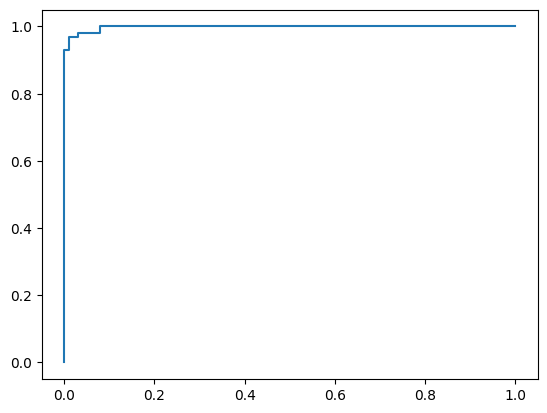

In [8]:
import sklearn.metrics

fpr, tpr, threshold = sklearn.metrics.roc_curve(y_true, res.log_likelihood_ratio)

plt.plot(fpr, tpr)
print(sklearn.metrics.roc_auc_score(y_true, res.log_likelihood_ratio))

In [9]:
res

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
gene_0,-11019.283703,-11022.805048,3.521345,7.958939e-03,1.473878e-02
gene_1,-10992.464668,-11014.914968,22.450301,2.072942e-11,8.637258e-11
gene_2,-10926.842625,-10949.668774,22.826148,1.412204e-11,6.009377e-11
gene_3,-11130.460673,-11151.753381,21.292708,6.766199e-11,2.602384e-10
gene_4,-10941.056344,-10968.102723,27.046379,1.912914e-13,1.034008e-12
...,...,...,...,...,...
gene_195,-11484.778411,-11484.778518,0.000107,9.883479e-01,1.000000e+00
gene_196,-11530.338793,-11530.359516,0.020723,8.386810e-01,9.695734e-01
gene_197,-11465.410351,-11466.387749,0.977397,1.620711e-01,2.186286e-01
gene_198,-11473.768354,-11475.843243,2.074889,4.163998e-02,6.826226e-02


In [3]:
import scanpy as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
os.chdir(os.path.expanduser('/net/scratch2/f30033yc/GPcounts'))
from GPcountsDemo.RNA_seq_GP import rna_seq_gp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

adata = sc.read_h5ad("/net/scratch2/f30033yc/GPcounts/demo_notebooks/sigma_0.5_alpha_0.8.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                        index=adata.obs_names, 
                        columns=adata.var_names)

spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                    index=adata.obs_names, 
                                    columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

Y = Y.T
X = spatial_locations[['x', 'y']]


gene_name = Y.index
gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf, M=1)
r1 = gpc1.One_sample_test()
res = gpc1.calculate_FDR(r1)
y_true = pd.DataFrame(adata.var['spatially_variable'])
fpr, tpr, thresholds = roc_curve(y_true, res.log_likelihood_ratio)
roc_auc = auc(fpr, tpr)

/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/tmp/5115142.1.nvidiagpu.q/ipykernel_73454/3408962041.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.015006389112484999
init var = 0.015006389112484999
125
RBF: alpha = 3.5430727048762374e-08
1
1


  0%|          | 1/200 [00:05<18:35,  5.61s/it]

Constant: alpha = 4.82195035354858e-08
init var = 0.01539244729484754
init var = 0.01539244729484754
125
init var = 0.01539244729484754
125
RBF: alpha = 2.5830255463392428e-08
1
1


  1%|          | 2/200 [00:14<25:26,  7.71s/it]

Constant: alpha = 1.4486255202988277e-07
init var = 0.015619678413642578
init var = 0.015619678413642578
125
RBF: alpha = 1.08950976894052e-08
1
1


  2%|▏         | 3/200 [00:20<21:35,  6.58s/it]

Constant: alpha = 1.0181587064791439e-06
init var = 0.01588486835081151
init var = 0.01588486835081151
125
RBF: alpha = 7.414727702365857e-10
1
1
1
1


  2%|▏         | 4/200 [00:26<21:44,  6.66s/it]

Constant: alpha = 9.011119318827999e-07
init var = 0.016183207194343525
init var = 0.016183207194343525
125
RBF: alpha = 9.60094135438798e-10
1
1
1


  2%|▎         | 5/200 [00:32<20:25,  6.29s/it]

Constant: alpha = 6.765728724940221e-08
init var = 0.01588919356037473
init var = 0.01588919356037473
125
init var = 0.01588919356037473
125
init var = 0.01588919356037473
125
init var = 0.01588919356037473
125
init var = 0.01588919356037473
125
init var = 0.01588919356037473
125
RBF: alpha = 2.2951893336005918e-08
1


  3%|▎         | 6/200 [00:51<34:05, 10.54s/it]

Constant: alpha = 2.2951893336007304e-08
init var = 0.01612989433281118
init var = 0.01612989433281118
125
RBF: alpha = 4.588406195446942e-08
1
1


  4%|▎         | 7/200 [00:56<28:01,  8.71s/it]

Constant: alpha = 4.549078875890752e-08
init var = 0.01564895755773623
init var = 0.01564895755773623
125
init var = 0.01564895755773623
125
RBF: alpha = 4.130513608606487e-09
1
1
1


  4%|▍         | 8/200 [01:05<28:50,  9.01s/it]

Constant: alpha = 3.2011425609567174e-07
init var = 0.015734031238377456
init var = 0.015734031238377456
125
init var = 0.015734031238377456
125
init var = 0.015734031238377456
125
RBF: alpha = 1.628378008426497e-07
1
1


  4%|▍         | 9/200 [01:16<30:18,  9.52s/it]

Constant: alpha = 4.148211442744713e-08
init var = 0.015432193055503052
init var = 0.015432193055503052
125
init var = 0.015432193055503052
125
init var = 0.015432193055503052
125
RBF: alpha = 1.5543239020157587e-07
1


  5%|▌         | 10/200 [01:25<30:06,  9.51s/it]

Constant: alpha = 5.715746835197941e-08
init var = 0.015462707130627137
init var = 0.015462707130627137
125
RBF: alpha = 1.7261685836425916e-08
1
1


  6%|▌         | 11/200 [01:30<25:16,  8.03s/it]

Constant: alpha = 2.4512374939906783e-08
init var = 0.015324684530178387
init var = 0.015324684530178387
125
RBF: alpha = 1.4778375951113797e-08
1
1


  6%|▌         | 12/200 [01:37<23:53,  7.63s/it]

Constant: alpha = 1.6878205910332104e-07
init var = 0.01547172555246705
init var = 0.01547172555246705
125
init var = 0.01547172555246705
125
RBF: alpha = 4.100703903880842e-08
1
1


  6%|▋         | 13/200 [01:45<24:28,  7.85s/it]

Constant: alpha = 3.0262449066208506e-08
init var = 0.01524691766326033
init var = 0.01524691766326033
125
init var = 0.01524691766326033
125
RBF: alpha = 3.963198016493939e-08
1
1


  7%|▋         | 14/200 [01:54<25:22,  8.18s/it]

Constant: alpha = 5.457028188857174e-10
init var = 0.01606684379505301
init var = 0.01606684379505301
125
RBF: alpha = 2.0786446064000636e-08
1


  8%|▊         | 15/200 [01:58<21:16,  6.90s/it]

Constant: alpha = 2.0786446064000636e-08
init var = 0.017168770741250932
init var = 0.017168770741250932
125
RBF: alpha = 4.970787423780193e-17
1


  8%|▊         | 16/200 [02:02<18:36,  6.07s/it]

Constant: alpha = 4.970787423780193e-17
init var = 0.015181043154905502
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
init var = 0.015181043154905502
125
RBF: alpha = 3.6108486207481846e-06
1
1
1
1


  8%|▊         | 17/200 [02:30<38:26, 12.61s/it]

Constant: alpha = 6.380254164294462e-08
init var = 0.01493209416312298
init var = 0.01493209416312298
125
RBF: alpha = 1.4314084390537114e-08
1
1


  9%|▉         | 18/200 [02:35<31:03, 10.24s/it]

Constant: alpha = 1.0176898298925697e-06
init var = 0.01464115139852205
init var = 0.01464115139852205
125
RBF: alpha = 2.2841057735313733e-08
1
1


 10%|▉         | 19/200 [02:40<26:23,  8.75s/it]

Constant: alpha = 1.4185896687050076e-08
init var = 0.01558564914554139
init var = 0.01558564914554139
125
RBF: alpha = 2.8978013358886322e-08
1
1


 10%|█         | 20/200 [02:45<22:41,  7.56s/it]

Constant: alpha = 3.826423738324191e-08
init var = 0.01590570990697734
init var = 0.01590570990697734
125
init var = 0.01590570990697734
125
RBF: alpha = 3.667146802323268e-08
1


 10%|█         | 21/200 [02:52<22:25,  7.52s/it]

Constant: alpha = 3.6671468001586375e-08
init var = 0.016403942035723224
init var = 0.016403942035723224
125
init var = 0.016403942035723224
125
RBF: alpha = 8.513161555655316e-10
1
1


 11%|█         | 22/200 [03:00<22:41,  7.65s/it]

Constant: alpha = 6.825692630832221e-08
init var = 0.015395965562456398
init var = 0.015395965562456398
125
RBF: alpha = 9.89032132306642e-09
1
1


 12%|█▏        | 23/200 [03:05<20:09,  6.83s/it]

Constant: alpha = 2.90156983484548e-07
init var = 0.016380458615270255
init var = 0.016380458615270255
125
init var = 0.016380458615270255
125
init var = 0.016380458615270255
125
RBF: alpha = 1.561204068275916e-07
1


 12%|█▏        | 24/200 [03:16<23:12,  7.91s/it]

Constant: alpha = 5.7432219202236145e-08
init var = 0.015824949799641594
init var = 0.015824949799641594
125
init var = 0.015824949799641594
125
init var = 0.015824949799641594
125
RBF: alpha = 3.7104949567973463e-08
1
1


 12%|█▎        | 25/200 [03:28<27:28,  9.42s/it]

Constant: alpha = 1.0181371317239084e-06
init var = 0.015386341957742446
init var = 0.015386341957742446
125
RBF: alpha = 5.357256841738117e-15
1
1


 13%|█▎        | 26/200 [03:34<23:43,  8.18s/it]

Constant: alpha = 1.3950954389935888e-07
init var = 0.01591250154225041
init var = 0.01591250154225041
125
init var = 0.01591250154225041
125
RBF: alpha = 3.6966622864070116e-08
1


 14%|█▎        | 27/200 [03:41<22:40,  7.86s/it]

Constant: alpha = 4.308587477056002e-08
init var = 0.015403889769637667
init var = 0.015403889769637667
125
init var = 0.015403889769637667
125
RBF: alpha = 3.101506958485268e-08
1


 14%|█▍        | 28/200 [03:48<21:39,  7.55s/it]

Constant: alpha = 3.101506958485268e-08
init var = 0.015205675994265052
init var = 0.015205675994265052
125
init var = 0.015205675994265052
125
RBF: alpha = 7.62710626198108e-08
1


 14%|█▍        | 29/200 [03:55<21:25,  7.52s/it]

Constant: alpha = 5.789825925920136e-16
init var = 0.014985806770693904
init var = 0.014985806770693904
125
init var = 0.014985806770693904
125
RBF: alpha = 2.586521604166392e-09
1
1


 15%|█▌        | 30/200 [04:03<21:56,  7.74s/it]

Constant: alpha = 9.326862389990492e-08
init var = 0.015564693963691392
init var = 0.015564693963691392
125
init var = 0.015564693963691392
125
RBF: alpha = 3.4684741293884946e-08
1
1
1
1


 16%|█▌        | 31/200 [04:14<24:01,  8.53s/it]

Constant: alpha = 9.01350474712403e-07
init var = 0.015377034059522413
init var = 0.015377034059522413
125
RBF: alpha = 3.997998016632838e-08
1
1
1


 16%|█▌        | 32/200 [04:20<21:58,  7.85s/it]

Constant: alpha = 3.8342686354553864e-08
init var = 0.015775911590729743
init var = 0.015775911590729743
125
RBF: alpha = 2.647661568773571e-08
1
1
1
1


 16%|█▋        | 33/200 [04:27<20:54,  7.51s/it]

Constant: alpha = 9.011140148088349e-07
init var = 0.01651882056910666
init var = 0.01651882056910666
125
init var = 0.01651882056910666
125
RBF: alpha = 3.689948843026487e-08
1


 17%|█▋        | 34/200 [04:34<20:44,  7.50s/it]

Constant: alpha = 2.207695532860695e-08
init var = 0.01635675180028496
init var = 0.01635675180028496
125
init var = 0.01635675180028496
125
RBF: alpha = 4.511445260346764e-08
1
1
1
1


 18%|█▊        | 35/200 [04:44<22:22,  8.14s/it]

Constant: alpha = 9.013458501268467e-07
init var = 0.016416420920177185
init var = 0.016416420920177185
125
init var = 0.016416420920177185
125
RBF: alpha = 5.958306380614433e-08
1
1


 18%|█▊        | 36/200 [04:52<22:23,  8.19s/it]

Constant: alpha = 5.075043974023507e-10
init var = 0.01555596232279809
init var = 0.01555596232279809
125
RBF: alpha = 7.850619097891768e-09
1


 18%|█▊        | 37/200 [04:56<18:50,  6.94s/it]

Constant: alpha = 3.358460651811653e-09
init var = 0.01582986933319044
init var = 0.01582986933319044
125
RBF: alpha = 4.814906773751057e-14
1
1
1
1


 19%|█▉        | 38/200 [05:04<19:07,  7.08s/it]

Constant: alpha = 1.4706510849908782e-07
init var = 0.01559179566078862
init var = 0.01559179566078862
125
init var = 0.01559179566078862
125
RBF: alpha = 5.2468852837753606e-08
1
1
1


 20%|█▉        | 39/200 [05:13<20:40,  7.71s/it]

Constant: alpha = 6.983945099907984e-09
init var = 0.015934991405781647
init var = 0.015934991405781647
125
init var = 0.015934991405781647
125
init var = 0.015934991405781647
125
init var = 0.015934991405781647
125
RBF: alpha = 2.7573151172361446e-09
1


 20%|██        | 40/200 [05:28<26:49, 10.06s/it]

Constant: alpha = 2.757315117236154e-09
init var = 0.015498439860482808
init var = 0.015498439860482808
125
init var = 0.015498439860482808
125
RBF: alpha = 3.2721353575997216e-08
1
1
1


 20%|██        | 41/200 [05:37<25:52,  9.76s/it]

Constant: alpha = 4.522273020013505e-08
init var = 0.015054214485449382
init var = 0.015054214485449382
125
init var = 0.015054214485449382
125
init var = 0.015054214485449382
125
RBF: alpha = 4.1140975399336336e-08
1
1
1
1


 21%|██        | 42/200 [05:51<28:47, 10.93s/it]

Constant: alpha = 9.01357823929121e-07
init var = 0.01569605883813225
init var = 0.01569605883813225
125
init var = 0.01569605883813225
125
init var = 0.01569605883813225
125
init var = 0.01569605883813225
125
RBF: alpha = 9.34168018619969e-10
1
1


 22%|██▏       | 43/200 [06:06<31:51, 12.18s/it]

Constant: alpha = 1.0154059968081196e-06
init var = 0.01508970235215001
init var = 0.01508970235215001
125
init var = 0.01508970235215001
125
init var = 0.01508970235215001
125
init var = 0.01508970235215001
125
init var = 0.01508970235215001
125
init var = 0.01508970235215001
125
RBF: alpha = 7.643500221447152e-08
1
1


 22%|██▏       | 44/200 [06:25<36:48, 14.16s/it]

Constant: alpha = 1.338353047655938e-07
init var = 0.015807788795822644
init var = 0.015807788795822644
125
init var = 0.015807788795822644
125
RBF: alpha = 8.330875704673555e-08
1
1


 22%|██▎       | 45/200 [06:33<32:09, 12.45s/it]

Constant: alpha = 2.4968532796991657e-08
init var = 0.014981318512510538
init var = 0.014981318512510538
125
RBF: alpha = 4.337281542924263e-08
1
1


 23%|██▎       | 46/200 [06:38<25:55, 10.10s/it]

Constant: alpha = 2.0183638585807865e-08
init var = 0.01624094535840194
init var = 0.01624094535840194
125
RBF: alpha = 1.8341117784864405e-16
1
1
1
1


 24%|██▎       | 47/200 [06:45<23:19,  9.15s/it]

Constant: alpha = 2.4504703592787086e-08
init var = 0.015575197185121112
init var = 0.015575197185121112
125
RBF: alpha = 2.162585340815537e-08
1
1


 24%|██▍       | 48/200 [06:50<19:48,  7.82s/it]

Constant: alpha = 6.628793156651983e-07
init var = 0.01565691362575595
init var = 0.01565691362575595
125
RBF: alpha = 1.3264679047601948e-08
1
1
1


 24%|██▍       | 49/200 [06:55<18:09,  7.22s/it]

Constant: alpha = 2.1394446521209895e-08
init var = 0.016396335255048116
init var = 0.016396335255048116
125
init var = 0.016396335255048116
125
RBF: alpha = 2.4898333048097273e-08
1
1
1


 25%|██▌       | 50/200 [07:05<19:37,  7.85s/it]

Constant: alpha = 4.677275419427079e-08
init var = 0.016239128177414564
init var = 0.016239128177414564
125
init var = 0.016239128177414564
125
init var = 0.016239128177414564
125
init var = 0.016239128177414564
125
init var = 0.016239128177414564
125
RBF: alpha = 1.3572436550967429e-08
1
1


 26%|██▌       | 51/200 [07:21<25:38, 10.33s/it]

Constant: alpha = 5.866215090956471e-08
init var = 0.015619353873888854
init var = 0.015619353873888854
125
RBF: alpha = 1.7858135276014448e-08
1


 26%|██▌       | 52/200 [07:28<22:58,  9.31s/it]

Constant: alpha = 1.7913032751387304e-08
init var = 0.016706177296594554
init var = 0.016706177296594554
125
init var = 0.016706177296594554
125
init var = 0.016706177296594554
125
RBF: alpha = 1.5513258938428062e-07
1


 26%|██▋       | 53/200 [07:38<23:39,  9.66s/it]

Constant: alpha = 5.707009336937166e-08
init var = 0.015493422979453544
init var = 0.015493422979453544
125
init var = 0.015493422979453544
125
RBF: alpha = 2.079042472123692e-08
1
1


 27%|██▋       | 54/200 [07:47<23:08,  9.51s/it]

Constant: alpha = 1.840650738730107e-08
init var = 0.015564568418676704
init var = 0.015564568418676704
125
init var = 0.015564568418676704
125
init var = 0.015564568418676704
125
RBF: alpha = 1.4934027470729985e-07
1


 28%|██▊       | 55/200 [07:57<23:12,  9.60s/it]

Constant: alpha = 5.481472509699545e-08
init var = 0.015956723915800358
init var = 0.015956723915800358
125
RBF: alpha = 3.2748664467140884e-08
1
1


 28%|██▊       | 56/200 [08:02<19:12,  8.01s/it]

Constant: alpha = 1.0181322655761201e-06
init var = 0.015514478000972314
init var = 0.015514478000972314
125
RBF: alpha = 5.631836147474377e-08
1
1
1


 28%|██▊       | 57/200 [08:07<17:21,  7.28s/it]

Constant: alpha = 3.7980752089459777e-08
init var = 0.016053098563873328
init var = 0.016053098563873328
125
RBF: alpha = 6.030039748341422e-10
1
1
1
1
1


 29%|██▉       | 58/200 [08:16<18:04,  7.64s/it]

Constant: alpha = 1.7967837462427973e-07
init var = 0.015367448823396714
init var = 0.015367448823396714
125
RBF: alpha = 7.433823729200921e-11
1
1
1


 30%|██▉       | 59/200 [08:22<16:44,  7.12s/it]

Constant: alpha = 3.346553155935503e-08
init var = 0.015049693618337648
init var = 0.015049693618337648
125
RBF: alpha = 9.187142086606586e-09
1


 30%|███       | 60/200 [08:26<14:26,  6.19s/it]

Constant: alpha = 3.3797623720725717e-09
init var = 0.015491041661327892
init var = 0.015491041661327892
125
RBF: alpha = 5.0551703180632645e-12
1
1


 30%|███       | 61/200 [08:30<13:26,  5.80s/it]

Constant: alpha = 1.0181177807977837e-06
init var = 0.015722096267896214
init var = 0.015722096267896214
125
RBF: alpha = 2.4688324957644948e-08
1
1


 31%|███       | 62/200 [08:36<12:50,  5.58s/it]

Constant: alpha = 1.9747099271237187e-07
init var = 0.01605407025817448
init var = 0.01605407025817448
125
init var = 0.01605407025817448
125
RBF: alpha = 1.1749766351431995e-08
1


 32%|███▏      | 63/200 [08:43<14:15,  6.24s/it]

Constant: alpha = 1.1749766351431995e-08
init var = 0.0153815448047484
init var = 0.0153815448047484
125
init var = 0.0153815448047484
125
RBF: alpha = 6.867651430017665e-16
1
1


 32%|███▏      | 64/200 [08:51<15:18,  6.75s/it]

Constant: alpha = 4.7812645246069704e-08
init var = 0.01622506219518484
init var = 0.01622506219518484
125
RBF: alpha = 1.9894820268937824e-08
1
1


 32%|███▎      | 65/200 [08:56<13:46,  6.12s/it]

Constant: alpha = 6.647416010773236e-07
init var = 0.016014681782822348
init var = 0.016014681782822348
125
RBF: alpha = 9.62519933189594e-09
1


 33%|███▎      | 66/200 [09:00<12:25,  5.57s/it]

Constant: alpha = 8.233534359210602e-09
init var = 0.0150804136446331
init var = 0.0150804136446331
125
RBF: alpha = 1.9625340513484887e-08
1
1


 34%|███▎      | 67/200 [09:05<11:49,  5.34s/it]

Constant: alpha = 6.686502313044511e-07
init var = 0.015180029059800091
init var = 0.015180029059800091
125
init var = 0.015180029059800091
125
init var = 0.015180029059800091
125
RBF: alpha = 3.606355128454521e-08
1


 34%|███▍      | 68/200 [09:15<14:44,  6.70s/it]

Constant: alpha = 3.606355128454521e-08
init var = 0.01548217376271406
init var = 0.01548217376271406
125
RBF: alpha = 4.7030571950986374e-08
1


 34%|███▍      | 69/200 [09:19<12:37,  5.78s/it]

Constant: alpha = 4.6789013064460945e-08
init var = 0.015890054667206954
init var = 0.015890054667206954
125
RBF: alpha = 1.3309576224429934e-08
1


 35%|███▌      | 70/200 [09:22<11:14,  5.18s/it]

Constant: alpha = 1.3309576224429934e-08
init var = 0.016550495951902663
init var = 0.016550495951902663
125
RBF: alpha = 2.8581908821914987e-08
1


 36%|███▌      | 71/200 [09:26<10:13,  4.75s/it]

Constant: alpha = 2.8577044755202392e-08
init var = 0.015243654355399988
init var = 0.015243654355399988
125
RBF: alpha = 1.803571306890786e-08
1
1
1


 36%|███▌      | 72/200 [09:35<12:52,  6.04s/it]

Constant: alpha = 4.079274274251255e-08
init var = 0.016844742272907453
init var = 0.016844742272907453
125
init var = 0.016844742272907453
125
RBF: alpha = 5.97437829282183e-08
1
1


 36%|███▋      | 73/200 [09:44<14:19,  6.77s/it]

Constant: alpha = 1.9810339813908207e-08
init var = 0.01502594464125063
init var = 0.01502594464125063
125
RBF: alpha = 5.6501458279962876e-08
1
1


 37%|███▋      | 74/200 [09:49<13:14,  6.30s/it]

Constant: alpha = 2.9025283655339562e-08
init var = 0.01538559436166612
init var = 0.01538559436166612
125
RBF: alpha = 3.7097553821598333e-08
1
1
1


 38%|███▊      | 75/200 [09:55<13:12,  6.34s/it]

Constant: alpha = 1.519103624157248e-08
init var = 0.015791887313496
init var = 0.015791887313496
125
init var = 0.015791887313496
125
RBF: alpha = 1.827345606828265e-08
1
1


 38%|███▊      | 76/200 [10:04<14:44,  7.13s/it]

Constant: alpha = 4.7239068751014496e-08
init var = 0.01613155231555238
init var = 0.01613155231555238
125
init var = 0.01613155231555238
125
init var = 0.01613155231555238
125
init var = 0.01613155231555238
125
init var = 0.01613155231555238
125
init var = 0.01613155231555238
125
RBF: alpha = 1.345851409864535e-08
1
1
1
1


 38%|███▊      | 77/200 [10:26<23:44, 11.58s/it]

Constant: alpha = 9.013581507228964e-07
init var = 0.01617791105783927
init var = 0.01617791105783927
125
init var = 0.01617791105783927
125
init var = 0.01617791105783927
125
init var = 0.01617791105783927
125
RBF: alpha = 1.6526216486825124e-09
1
1
1
1


 39%|███▉      | 78/200 [10:42<26:01, 12.80s/it]

Constant: alpha = 9.001319873278592e-07
init var = 0.015144878313536777
init var = 0.015144878313536777
125
init var = 0.015144878313536777
125
RBF: alpha = 6.758853827087424e-08
1
1
1


 40%|███▉      | 79/200 [10:51<23:52, 11.84s/it]

Constant: alpha = 3.370996034166892e-08
init var = 0.016166733218170627
init var = 0.016166733218170627
125
RBF: alpha = 1.9486094421307518e-08
1
1
1
1


 40%|████      | 80/200 [10:58<20:38, 10.32s/it]

Constant: alpha = 9.013581243378534e-07
init var = 0.016035464378269755
init var = 0.016035464378269755
125
RBF: alpha = 3.0221358794718463e-08
1
1
1


 40%|████      | 81/200 [11:04<17:54,  9.03s/it]

Constant: alpha = 3.814390634336474e-08
init var = 0.01542415389838599
init var = 0.01542415389838599
125
RBF: alpha = 5.476234425925645e-08
1
1
1
1


 41%|████      | 82/200 [11:12<16:52,  8.58s/it]

Constant: alpha = 9.363116470796762e-09
init var = 0.015282409573158807
init var = 0.015282409573158807
125
RBF: alpha = 2.1921312549428487e-09
1


 42%|████▏     | 83/200 [11:16<14:06,  7.23s/it]

Constant: alpha = 8.064400232644874e-10
init var = 0.01545349409340742
init var = 0.01545349409340742
125
RBF: alpha = 2.3241067199818544e-14
1


 42%|████▏     | 84/200 [11:19<11:48,  6.11s/it]

Constant: alpha = 2.171247388113587e-16
init var = 0.016934512316737708
init var = 0.016934512316737708
125
init var = 0.016934512316737708
125
init var = 0.016934512316737708
125
RBF: alpha = 1.7408463227001494e-07
1


 42%|████▎     | 85/200 [11:29<13:33,  7.07s/it]

Constant: alpha = 6.355881989837548e-08
init var = 0.015589678362813277
init var = 0.015589678362813277
125
init var = 0.015589678362813277
125
RBF: alpha = 6.4756224455186464e-09
1


 43%|████▎     | 86/200 [11:36<13:31,  7.11s/it]

Constant: alpha = 6.4756224455186464e-09
init var = 0.01668714351759124
init var = 0.01668714351759124
125
init var = 0.01668714351759124
125
RBF: alpha = 4.466438395226238e-08
1


 44%|████▎     | 87/200 [11:43<13:26,  7.14s/it]

Constant: alpha = 4.4664383952261586e-08
init var = 0.016039601960072238
init var = 0.016039601960072238
125
init var = 0.016039601960072238
125
init var = 0.016039601960072238
125
RBF: alpha = 1.7744611862896385e-08
1


 44%|████▍     | 88/200 [11:57<17:09,  9.20s/it]

Constant: alpha = 1.7744611862896385e-08
init var = 0.01615906591168443
init var = 0.01615906591168443
125
RBF: alpha = 3.6225754059167664e-08
1
1
1
1


 44%|████▍     | 89/200 [12:05<16:16,  8.80s/it]

Constant: alpha = 9.011129090453749e-07
init var = 0.015367700612647132
init var = 0.015367700612647132
125
RBF: alpha = 2.0281882445848164e-08
1
1


 45%|████▌     | 90/200 [12:10<14:02,  7.66s/it]

Constant: alpha = 1.679523872997933e-08
init var = 0.016194536926571454
init var = 0.016194536926571454
125
init var = 0.016194536926571454
125
RBF: alpha = 2.7322726674985105e-08
1
1


 46%|████▌     | 91/200 [12:18<14:02,  7.73s/it]

Constant: alpha = 1.017864427701822e-06
init var = 0.015516050601409325
init var = 0.015516050601409325
125
RBF: alpha = 1.8062731004217813e-11
1
1


 46%|████▌     | 92/200 [12:23<12:40,  7.04s/it]

Constant: alpha = 2.9450825119217903e-07
init var = 0.014865243113856126
init var = 0.014865243113856126
125
RBF: alpha = 8.305628927327062e-12
1


 46%|████▋     | 93/200 [12:27<10:54,  6.12s/it]

Constant: alpha = 8.305628927327062e-12
init var = 0.016007882836233063
init var = 0.016007882836233063
125
RBF: alpha = 6.127899033695139e-08
1
1


 47%|████▋     | 94/200 [12:32<10:12,  5.78s/it]

Constant: alpha = 7.677286988384464e-08
init var = 0.015306853556194034
init var = 0.015306853556194034
125
RBF: alpha = 2.108654891332391e-08
1
1


 48%|████▊     | 95/200 [12:37<09:35,  5.48s/it]

Constant: alpha = 6.647946772197323e-07
init var = 0.016455888306927544
init var = 0.016455888306927544
125
RBF: alpha = 2.8754449566127726e-08
1
1
1


 48%|████▊     | 96/200 [12:43<09:43,  5.61s/it]

Constant: alpha = 7.185416257289785e-08
init var = 0.015708418241326558
init var = 0.015708418241326558
125
init var = 0.015708418241326558
125
init var = 0.015708418241326558
125
RBF: alpha = 1.8194925710449885e-08
1
1


 48%|████▊     | 97/200 [12:54<12:37,  7.36s/it]

Constant: alpha = 2.423697906078111e-08
init var = 0.015155085373719268
init var = 0.015155085373719268
125
RBF: alpha = 1.1491157096258883e-10
1
1


 49%|████▉     | 98/200 [12:59<11:03,  6.50s/it]

Constant: alpha = 5.3519831393852206e-11
init var = 0.01591476767718184
init var = 0.01591476767718184
125
RBF: alpha = 5.1484924175573336e-08
1
1


 50%|████▉     | 99/200 [13:04<10:02,  5.97s/it]

Constant: alpha = 8.46436396798289e-08
init var = 0.014802510409442806
init var = 0.014802510409442806
125
RBF: alpha = 1.5456282843717058e-08
1


 50%|█████     | 100/200 [13:07<08:45,  5.25s/it]

Constant: alpha = 1.5456282843716125e-08
init var = 0.01871933725297955
init var = 0.01871933725297955
125
init var = 0.01871933725297955
125
RBF: alpha = 1.0417987490966594e-13
1


 50%|█████     | 101/200 [13:15<09:45,  5.91s/it]

Constant: alpha = 1.0417987468047982e-13
init var = 0.020627891662237725
init var = 0.020627891662237725
125
init var = 0.020627891662237725
125
init var = 0.020627891662237725
125
RBF: alpha = 1.5139542896608388e-07
1
1


 51%|█████     | 102/200 [13:26<12:14,  7.49s/it]

Constant: alpha = 2.0541693339578418e-16
init var = 0.020051114902694935
init var = 0.020051114902694935
125
init var = 0.020051114902694935
125
RBF: alpha = 3.579386172200054e-08
1
1


 52%|█████▏    | 103/200 [13:34<12:36,  7.80s/it]

Constant: alpha = 1.5467354902243306e-07
init var = 0.021062894791631367
init var = 0.021062894791631367
125
init var = 0.021062894791631367
125
init var = 0.021062894791631367
125
RBF: alpha = 1.849937449348959e-08
1
1


 52%|█████▏    | 104/200 [13:45<13:57,  8.73s/it]

Constant: alpha = 1.0181540705585647e-06
init var = 0.021286050830074493
init var = 0.021286050830074493
125
init var = 0.021286050830074493
125
RBF: alpha = 7.018018515474256e-08
1
1


 52%|█████▎    | 105/200 [13:53<13:22,  8.44s/it]

Constant: alpha = 3.003817354653547e-07
init var = 0.020007990829330174
init var = 0.020007990829330174
125
RBF: alpha = 3.129403786008974e-08
1


 53%|█████▎    | 106/200 [13:56<10:50,  6.92s/it]

Constant: alpha = 3.077892422158257e-08
init var = 0.01914397123562672
init var = 0.01914397123562672
125
RBF: alpha = 1.2452197615401358e-08
1
1
1
1


 54%|█████▎    | 107/200 [14:03<10:30,  6.78s/it]

Constant: alpha = 9.013530309084365e-07
init var = 0.01934241994089387
init var = 0.01934241994089387
125
RBF: alpha = 2.7580129843314245e-08
1
1


 54%|█████▍    | 108/200 [14:08<09:39,  6.30s/it]

Constant: alpha = 2.152967789802441e-08
init var = 0.020569369875329795
init var = 0.020569369875329795
125
init var = 0.020569369875329795
125
RBF: alpha = 2.7128908748580986e-08
1


 55%|█████▍    | 109/200 [14:15<09:53,  6.53s/it]

Constant: alpha = 2.7128908748580986e-08
init var = 0.02024875677096055
init var = 0.02024875677096055
125
init var = 0.02024875677096055
125
init var = 0.02024875677096055
125
init var = 0.02024875677096055
125
init var = 0.02024875677096055
125
RBF: alpha = 3.112776851667439e-17
1
1
1
1


 55%|█████▌    | 110/200 [14:39<17:30, 11.67s/it]

Constant: alpha = 9.013538782358528e-07
init var = 0.01996239634800891
init var = 0.01996239634800891
125
init var = 0.01996239634800891
125
RBF: alpha = 3.091026364406445e-08
1


 56%|█████▌    | 111/200 [14:46<15:21, 10.35s/it]

Constant: alpha = 3.091026364406445e-08
init var = 0.01949072852627849
init var = 0.01949072852627849
125
RBF: alpha = 2.435395908995974e-13
1
1


 56%|█████▌    | 112/200 [14:51<12:56,  8.82s/it]

Constant: alpha = 1.0181512645600064e-06
init var = 0.020845586333635497
init var = 0.020845586333635497
125
init var = 0.020845586333635497
125
RBF: alpha = 4.023852955688262e-08
1
1


 56%|█████▋    | 113/200 [15:00<12:47,  8.83s/it]

Constant: alpha = 1.0180075414137296e-06
init var = 0.020600071340895754
init var = 0.020600071340895754
125
init var = 0.020600071340895754
125
RBF: alpha = 1.7092748679438143e-08
1
1


 57%|█████▋    | 114/200 [15:08<12:28,  8.70s/it]

Constant: alpha = 1.0181640429494317e-06
init var = 0.01917301663932725
init var = 0.01917301663932725
125
init var = 0.01917301663932725
125
RBF: alpha = 1.759578959316942e-08
1


 57%|█████▊    | 115/200 [15:16<11:41,  8.25s/it]

Constant: alpha = 6.473130637576476e-09
init var = 0.019419552652586346
init var = 0.019419552652586346
125
init var = 0.019419552652586346
125
RBF: alpha = 5.4859167039373266e-08
1


 58%|█████▊    | 116/200 [15:23<11:02,  7.88s/it]

Constant: alpha = 4.199069677557556e-08
init var = 0.020226313504787208
init var = 0.020226313504787208
125
RBF: alpha = 1.7442100289363796e-08
1


 58%|█████▊    | 117/200 [15:27<09:17,  6.71s/it]

Constant: alpha = 1.1709975733250972e-10
init var = 0.020434182851272045
init var = 0.020434182851272045
125
init var = 0.020434182851272045
125
init var = 0.020434182851272045
125
RBF: alpha = 1.366732008648188e-07
1
1


 59%|█████▉    | 118/200 [15:37<10:42,  7.84s/it]

Constant: alpha = 1.0181392266574456e-06
init var = 0.020789000509963195
init var = 0.020789000509963195
125
init var = 0.020789000509963195
125
RBF: alpha = 1.8742570649811718e-08
1
1
1
1


 60%|█████▉    | 119/200 [15:47<11:32,  8.55s/it]

Constant: alpha = 9.013581931467189e-07
init var = 0.020879979771929156
init var = 0.020879979771929156
125
RBF: alpha = 3.7506794337738993e-11
1
1


 60%|██████    | 120/200 [15:52<09:54,  7.44s/it]

Constant: alpha = 3.648625018613161e-07
init var = 0.01941207434279567
init var = 0.01941207434279567
125
init var = 0.01941207434279567
125
RBF: alpha = 2.5574675681137627e-09
1
1


 60%|██████    | 121/200 [16:00<10:08,  7.71s/it]

Constant: alpha = 1.018173706827939e-06
init var = 0.0200075491848318
init var = 0.0200075491848318
125
init var = 0.0200075491848318
125
RBF: alpha = 4.429600159506066e-12
1
1
1
1


 61%|██████    | 122/200 [16:11<10:58,  8.44s/it]

Constant: alpha = 5.3271252363733386e-08
init var = 0.020453435697592025
init var = 0.020453435697592025
125
RBF: alpha = 3.849294794295705e-10
1
1


 62%|██████▏   | 123/200 [16:16<09:27,  7.38s/it]

Constant: alpha = 1.429495049956164e-07
init var = 0.019677015076331884
init var = 0.019677015076331884
125
RBF: alpha = 2.4576461547100648e-08
1
1
1
1


 62%|██████▏   | 124/200 [16:22<08:56,  7.06s/it]

Constant: alpha = 9.013545015322928e-07
init var = 0.019639215140485864
init var = 0.019639215140485864
125
RBF: alpha = 1.5855743703460078e-09
1
1


 62%|██████▎   | 125/200 [16:26<07:46,  6.22s/it]

Constant: alpha = 3.673986554972064e-08
init var = 0.02018718877922577
init var = 0.02018718877922577
125
RBF: alpha = 2.7789089981517963e-08
1
1
1


 63%|██████▎   | 126/200 [16:32<07:38,  6.20s/it]

Constant: alpha = 9.271633091754937e-08
init var = 0.019746897679349677
init var = 0.019746897679349677
125
init var = 0.019746897679349677
125
RBF: alpha = 7.260437615072158e-08
1
1


 64%|██████▎   | 127/200 [16:41<08:24,  6.92s/it]

Constant: alpha = 8.455958279218461e-11
init var = 0.019840383282473156
init var = 0.019840383282473156
125
RBF: alpha = 3.4523226953018054e-08
1


 64%|██████▍   | 128/200 [16:45<07:13,  6.02s/it]

Constant: alpha = 3.4523226953018054e-08
init var = 0.020915271943221323
init var = 0.020915271943221323
125
init var = 0.020915271943221323
125
init var = 0.020915271943221323
125
RBF: alpha = 1.4511949125488283e-07
1


 64%|██████▍   | 129/200 [16:55<08:28,  7.16s/it]

Constant: alpha = 5.335302794663795e-08
init var = 0.020298284572442305
init var = 0.020298284572442305
125
init var = 0.020298284572442305
125
RBF: alpha = 4.788101752178281e-08
1
1
1


 65%|██████▌   | 130/200 [17:04<09:04,  7.78s/it]

Constant: alpha = 5.2233144413798704e-08
init var = 0.01999966833292633
init var = 0.01999966833292633
125
init var = 0.01999966833292633
125
init var = 0.01999966833292633
125
RBF: alpha = 6.630578075303468e-08
1


 66%|██████▌   | 131/200 [17:18<11:16,  9.80s/it]

Constant: alpha = 6.629210019754521e-08
init var = 0.020842270364457894
init var = 0.020842270364457894
125
RBF: alpha = 6.285803665966245e-09
1
1


 66%|██████▌   | 132/200 [17:23<09:31,  8.40s/it]

Constant: alpha = 3.557409578152336e-08
init var = 0.021568081768565058
init var = 0.021568081768565058
125
RBF: alpha = 3.416342939687017e-08
1
1


 66%|██████▋   | 133/200 [17:28<08:12,  7.35s/it]

Constant: alpha = 1.018151993402777e-06
init var = 0.020093672519726158
init var = 0.020093672519726158
125
init var = 0.020093672519726158
125
RBF: alpha = 4.381083764481911e-08
1
1


 67%|██████▋   | 134/200 [17:36<08:18,  7.56s/it]

Constant: alpha = 3.535173869173467e-08
init var = 0.020124351581789438
init var = 0.020124351581789438
125
RBF: alpha = 6.463087122220884e-08
1


 68%|██████▊   | 135/200 [17:40<06:59,  6.45s/it]

Constant: alpha = 6.461587879722557e-08
init var = 0.02053656341408146
init var = 0.02053656341408146
125
RBF: alpha = 4.644355062448835e-14
1
1


 68%|██████▊   | 136/200 [17:45<06:22,  5.98s/it]

Constant: alpha = 1.0178580449042016e-06
init var = 0.019442598027543376
init var = 0.019442598027543376
125
RBF: alpha = 3.471398037854271e-08
1


 68%|██████▊   | 137/200 [17:49<05:33,  5.29s/it]

Constant: alpha = 3.4667947377676244e-08
init var = 0.02040245518908998
init var = 0.02040245518908998
125
init var = 0.02040245518908998
125
init var = 0.02040245518908998
125
init var = 0.02040245518908998
125
init var = 0.02040245518908998
125
RBF: alpha = 2.1333938765385397e-11
1
1


 69%|██████▉   | 138/200 [18:05<08:53,  8.61s/it]

Constant: alpha = 1.0181429577870002e-06
init var = 0.020777128732088677
init var = 0.020777128732088677
125
init var = 0.020777128732088677
125
RBF: alpha = 4.924004602348292e-08
1
1


 70%|██████▉   | 139/200 [18:13<08:37,  8.48s/it]

Constant: alpha = 1.0179931591447997e-06
init var = 0.019848803576425957
init var = 0.019848803576425957
125
init var = 0.019848803576425957
125
RBF: alpha = 7.435871545044087e-08
1
1


 70%|███████   | 140/200 [18:22<08:27,  8.46s/it]

Constant: alpha = 1.8969644893512106e-08
init var = 0.02129566033192781
init var = 0.02129566033192781
125
init var = 0.02129566033192781
125
RBF: alpha = 3.49944554682609e-08
1


 70%|███████   | 141/200 [18:29<07:59,  8.12s/it]

Constant: alpha = 1.9075457603015469e-13
init var = 0.019874972833622356
init var = 0.019874972833622356
125
RBF: alpha = 3.053071653756836e-08
1
1
1


 71%|███████   | 142/200 [18:35<07:16,  7.52s/it]

Constant: alpha = 3.267341906893024e-10
init var = 0.021281588437554576
init var = 0.021281588437554576
125
init var = 0.021281588437554576
125
RBF: alpha = 6.871478096009007e-08
1
1
1
1


 72%|███████▏  | 143/200 [18:46<07:57,  8.37s/it]

Constant: alpha = 9.011211669156625e-07
init var = 0.02077721384102482
init var = 0.02077721384102482
125
init var = 0.02077721384102482
125
init var = 0.02077721384102482
125
RBF: alpha = 5.88360404904322e-08
1
1


 72%|███████▏  | 144/200 [18:56<08:29,  9.09s/it]

Constant: alpha = 6.599576119608283e-10
init var = 0.019518342871323174
init var = 0.019518342871323174
125
init var = 0.019518342871323174
125
RBF: alpha = 1.059838958799756e-10
1
1


 72%|███████▎  | 145/200 [19:04<07:59,  8.72s/it]

Constant: alpha = 1.0178612709712003e-06
init var = 0.022423736973042833
init var = 0.022423736973042833
125
RBF: alpha = 6.570465831495247e-08
1
1


 73%|███████▎  | 146/200 [19:09<06:47,  7.54s/it]

Constant: alpha = 3.6605978237097337e-08
init var = 0.020048245926763117
init var = 0.020048245926763117
125
RBF: alpha = 2.871200918364511e-10
1
1


 74%|███████▎  | 147/200 [19:14<05:54,  6.68s/it]

Constant: alpha = 1.017864984243342e-06
init var = 0.020622044247001908
init var = 0.020622044247001908
125
init var = 0.020622044247001908
125
init var = 0.020622044247001908
125
RBF: alpha = 1.5405076992909902e-07
1
1


 74%|███████▍  | 148/200 [19:25<06:51,  7.92s/it]

Constant: alpha = 1.018162273467161e-06
init var = 0.019479793511099217
init var = 0.019479793511099217
125
init var = 0.019479793511099217
125
RBF: alpha = 4.092327523681601e-08
1


 74%|███████▍  | 149/200 [19:32<06:34,  7.73s/it]

Constant: alpha = 3.5445967818194155e-10
init var = 0.02131590764717041
init var = 0.02131590764717041
125
RBF: alpha = 2.3081499249648178e-08
1


 75%|███████▌  | 150/200 [19:36<05:26,  6.54s/it]

Constant: alpha = 2.3081499249648178e-08
init var = 0.019605898292956427
init var = 0.019605898292956427
125
init var = 0.019605898292956427
125
init var = 0.019605898292956427
125
init var = 0.019605898292956427
125
RBF: alpha = 1.6247248712779346e-09
1
1
1
1


 76%|███████▌  | 151/200 [19:51<07:30,  9.19s/it]

Constant: alpha = 9.011176112930121e-07
init var = 0.020233343718827818
init var = 0.020233343718827818
125
init var = 0.020233343718827818
125
RBF: alpha = 1.4978509926449536e-08
1
1


 76%|███████▌  | 152/200 [19:59<07:09,  8.94s/it]

Constant: alpha = 1.018151005929237e-06
init var = 0.021738905568795177
init var = 0.021738905568795177
125
init var = 0.021738905568795177
125
init var = 0.021738905568795177
125
RBF: alpha = 1.5571424657921532e-07
1
1
1


 76%|███████▋  | 153/200 [20:16<08:52, 11.33s/it]

Constant: alpha = 3.5030031233242e-08
init var = 0.021347097200526126
init var = 0.021347097200526126
125
RBF: alpha = 3.7564224799879354e-08
1
1


 77%|███████▋  | 154/200 [20:21<07:17,  9.50s/it]

Constant: alpha = 1.0179916926592974e-06
init var = 0.019620625506888856
init var = 0.019620625506888856
125
init var = 0.019620625506888856
125
RBF: alpha = 3.8117992779527216e-08
1


 78%|███████▊  | 155/200 [20:29<06:37,  8.83s/it]

Constant: alpha = 1.4022839642798594e-08
init var = 0.021227491710788086
init var = 0.021227491710788086
125
RBF: alpha = 2.5384958827850893e-12
1
1


 78%|███████▊  | 156/200 [20:33<05:34,  7.59s/it]

Constant: alpha = 1.0178646344438754e-06
init var = 0.020100124410376383
init var = 0.020100124410376383
125
init var = 0.020100124410376383
125
RBF: alpha = 1.3719600338374534e-13
1
1


 78%|███████▊  | 157/200 [20:42<05:36,  7.82s/it]

Constant: alpha = 1.0181156021980006e-06
init var = 0.02166285482796125
init var = 0.02166285482796125
125
RBF: alpha = 1.1284577939881581e-08
1
1


 79%|███████▉  | 158/200 [20:47<04:52,  6.96s/it]

Constant: alpha = 5.970278481120756e-09
init var = 0.01991754576038548
init var = 0.01991754576038548
125
init var = 0.01991754576038548
125
init var = 0.01991754576038548
125
RBF: alpha = 1.9517297430190846e-08
1


 80%|███████▉  | 159/200 [20:57<05:27,  8.00s/it]

Constant: alpha = 7.1800125160865704e-09
init var = 0.019456041418125472
init var = 0.019456041418125472
125
RBF: alpha = 3.8871485085194306e-08
1


 80%|████████  | 160/200 [21:01<04:30,  6.75s/it]

Constant: alpha = 3.882246986081115e-08
init var = 0.019057334735721996
init var = 0.019057334735721996
125
init var = 0.019057334735721996
125
init var = 0.019057334735721996
125
RBF: alpha = 1.5428207475773146e-10
1
1


 80%|████████  | 161/200 [21:13<05:20,  8.22s/it]

Constant: alpha = 4.1120866143906204e-08
init var = 0.02069830857140637
init var = 0.02069830857140637
125
RBF: alpha = 1.248572704200558e-10
1


 81%|████████  | 162/200 [21:16<04:21,  6.89s/it]

Constant: alpha = 1.5240254053233744e-10
init var = 0.01959850161417646
init var = 0.01959850161417646
125
RBF: alpha = 2.4845267255545033e-08
1
1
1


 82%|████████▏ | 163/200 [21:23<04:06,  6.66s/it]

Constant: alpha = 1.163900701459424e-13
init var = 0.021398385588161574
init var = 0.021398385588161574
125
RBF: alpha = 1.2557003035801451e-08
1
1
1


 82%|████████▏ | 164/200 [21:28<03:49,  6.37s/it]

Constant: alpha = 3.629856684552968e-08
init var = 0.020485155843822826
init var = 0.020485155843822826
125
init var = 0.020485155843822826
125
RBF: alpha = 7.787191209060922e-09
1
1


 82%|████████▎ | 165/200 [21:36<03:59,  6.85s/it]

Constant: alpha = 1.0181616991449586e-06
init var = 0.020126189857013973
init var = 0.020126189857013973
125
RBF: alpha = 1.2298236417755634e-11
1
1
1


 83%|████████▎ | 166/200 [21:42<03:43,  6.57s/it]

Constant: alpha = 3.967838626087709e-08
init var = 0.02044112472020619
init var = 0.02044112472020619
125
init var = 0.02044112472020619
125
init var = 0.02044112472020619
125
RBF: alpha = 1.3986263207745214e-07
1


 84%|████████▎ | 167/200 [21:52<04:14,  7.71s/it]

Constant: alpha = 5.1175650468285807e-08
init var = 0.022032981798663098
init var = 0.022032981798663098
125
RBF: alpha = 4.2534558944540457e-11
1
1


 84%|████████▍ | 168/200 [21:57<03:38,  6.82s/it]

Constant: alpha = 1.0181735032082623e-06
init var = 0.019523447756894744
init var = 0.019523447756894744
125
init var = 0.019523447756894744
125
RBF: alpha = 2.7629337708849336e-08
1


 84%|████████▍ | 169/200 [22:04<03:35,  6.94s/it]

Constant: alpha = 2.7345110835250494e-08
init var = 0.020226211050922326
init var = 0.020226211050922326
125
RBF: alpha = 5.03804369501478e-09
1
1


 85%|████████▌ | 170/200 [22:09<03:08,  6.29s/it]

Constant: alpha = 8.662807723719856e-08
init var = 0.020345895628301053
init var = 0.020345895628301053
125
init var = 0.020345895628301053
125
init var = 0.020345895628301053
125
init var = 0.020345895628301053
125
init var = 0.020345895628301053
125
init var = 0.020345895628301053
125
RBF: alpha = 9.2524470650978e-09
1


 86%|████████▌ | 171/200 [22:28<04:47,  9.92s/it]

Constant: alpha = 9.252447065098194e-09
init var = 0.01979075804518782
init var = 0.01979075804518782
125
RBF: alpha = 4.1691677635068286e-08
1
1


 86%|████████▌ | 172/200 [22:32<03:54,  8.37s/it]

Constant: alpha = 1.4690434084777648e-07
init var = 0.019483395871383844
init var = 0.019483395871383844
125
init var = 0.019483395871383844
125
RBF: alpha = 4.539796230469053e-08
1
1


 86%|████████▋ | 173/200 [22:41<03:44,  8.31s/it]

Constant: alpha = 1.0178648224362562e-06
init var = 0.020315505759050386
init var = 0.020315505759050386
125
init var = 0.020315505759050386
125
RBF: alpha = 4.721184888780303e-08
1
1


 87%|████████▋ | 174/200 [22:49<03:33,  8.22s/it]

Constant: alpha = 1.0181558072744257e-06
init var = 0.02095005625579635
init var = 0.02095005625579635
125
RBF: alpha = 3.9477397197276284e-08
1
1


 88%|████████▊ | 175/200 [22:53<02:59,  7.16s/it]

Constant: alpha = 1.0181656137969332e-06
init var = 0.020404623328611135
init var = 0.020404623328611135
125
init var = 0.020404623328611135
125
RBF: alpha = 2.5751634120931943e-08
1
1
1
1


 88%|████████▊ | 176/200 [23:03<03:12,  8.01s/it]

Constant: alpha = 9.013380219745369e-07
init var = 0.02083776587281984
init var = 0.02083776587281984
125
RBF: alpha = 6.5537538064395e-09
1


 88%|████████▊ | 177/200 [23:07<02:32,  6.64s/it]

Constant: alpha = 2.410991332947014e-09
init var = 0.02051829833910114
init var = 0.02051829833910114
125
RBF: alpha = 7.941081584200689e-09
1
1
1


 89%|████████▉ | 178/200 [23:12<02:19,  6.35s/it]

Constant: alpha = 3.5376192952622467e-08
init var = 0.019828014106478928
init var = 0.019828014106478928
125
RBF: alpha = 7.47959408217057e-11
1
1


 90%|████████▉ | 179/200 [23:22<02:33,  7.33s/it]

Constant: alpha = 1.0181285642550733e-06
init var = 0.020013436566376226
init var = 0.020013436566376226
125
RBF: alpha = 2.0922055536619997e-08
1


 90%|█████████ | 180/200 [23:26<02:08,  6.43s/it]

Constant: alpha = 2.3148205750173392e-08
init var = 0.02010616686887233
init var = 0.02010616686887233
125
RBF: alpha = 3.185618585391801e-08
1
1


 90%|█████████ | 181/200 [23:32<01:55,  6.07s/it]

Constant: alpha = 7.593906707178424e-09
init var = 0.021354783604569667
init var = 0.021354783604569667
125
init var = 0.021354783604569667
125
RBF: alpha = 1.0123695386581627e-08
1
1


 91%|█████████ | 182/200 [23:40<02:02,  6.83s/it]

Constant: alpha = 1.0181612485182403e-06
init var = 0.019085989865869325
init var = 0.019085989865869325
125
init var = 0.019085989865869325
125
RBF: alpha = 2.4522365689520848e-08
1
1


 92%|█████████▏| 183/200 [23:48<02:03,  7.29s/it]

Constant: alpha = 2.9705500627233764e-07
init var = 0.019658536990157315
init var = 0.019658536990157315
125
init var = 0.019658536990157315
125
init var = 0.019658536990157315
125
RBF: alpha = 1.390895218148526e-08
1
1
1
1


 92%|█████████▏| 184/200 [24:02<02:24,  9.03s/it]

Constant: alpha = 9.013486969417261e-07
init var = 0.02012990028572909
init var = 0.02012990028572909
125
init var = 0.02012990028572909
125
RBF: alpha = 3.7053401338579755e-08
1
1
1


 92%|█████████▎| 185/200 [24:11<02:18,  9.20s/it]

Constant: alpha = 2.2213578342030317e-08
init var = 0.020470189064904623
init var = 0.020470189064904623
125
init var = 0.020470189064904623
125
RBF: alpha = 9.298773438475074e-09
1
1


 93%|█████████▎| 186/200 [24:20<02:06,  9.05s/it]

Constant: alpha = 1.0181538312596998e-06
init var = 0.018986485827214006
init var = 0.018986485827214006
125
RBF: alpha = 1.8312259464778766e-08
1
1


 94%|█████████▎| 187/200 [24:25<01:41,  7.83s/it]

Constant: alpha = 6.03507066115358e-08
init var = 0.02037225046175069
init var = 0.02037225046175069
125
init var = 0.02037225046175069
125
RBF: alpha = 2.570612603564009e-08
1


 94%|█████████▍| 188/200 [24:32<01:32,  7.72s/it]

Constant: alpha = 2.5711930015173682e-08
init var = 0.02231283672845877
init var = 0.02231283672845877
125
RBF: alpha = 1.552441805604893e-13
1
1
1
1


 94%|█████████▍| 189/200 [24:40<01:24,  7.67s/it]

Constant: alpha = 9.013581931467942e-07
init var = 0.020265870100265187
init var = 0.020265870100265187
125
init var = 0.020265870100265187
125
RBF: alpha = 7.759011052829858e-08
1
1


 95%|█████████▌| 190/200 [24:48<01:16,  7.66s/it]

Constant: alpha = 3.221722238519699e-08
init var = 0.02014237107095293
init var = 0.02014237107095293
125
init var = 0.02014237107095293
125
init var = 0.02014237107095293
125
RBF: alpha = 1.4514725795044363e-07
1
1
1
1


 96%|█████████▌| 191/200 [25:01<01:24,  9.40s/it]

Constant: alpha = 9.013581819034698e-07
init var = 0.019461473020247096
init var = 0.019461473020247096
125
init var = 0.019461473020247096
125
init var = 0.019461473020247096
125
RBF: alpha = 1.5014299970194673e-07
1


 96%|█████████▌| 192/200 [25:11<01:16,  9.56s/it]

Constant: alpha = 5.5055621068731484e-08
init var = 0.020515337375429352
init var = 0.020515337375429352
125
init var = 0.020515337375429352
125
init var = 0.020515337375429352
125
init var = 0.020515337375429352
125
RBF: alpha = 7.776468367071506e-10
1
1


 96%|█████████▋| 193/200 [25:25<01:16, 10.91s/it]

Constant: alpha = 1.3024338612268331e-08
init var = 0.01973312000614724
init var = 0.01973312000614724
125
RBF: alpha = 5.1274299268959024e-09
1


 97%|█████████▋| 194/200 [25:29<00:52,  8.81s/it]

Constant: alpha = 5.1534070384719186e-09
init var = 0.02015534537918753
init var = 0.02015534537918753
125
RBF: alpha = 3.617592795077885e-08
1


 98%|█████████▊| 195/200 [25:32<00:36,  7.21s/it]

Constant: alpha = 3.605500511940757e-08
init var = 0.021316754575103253
init var = 0.021316754575103253
125
RBF: alpha = 3.23059139299095e-08
1
1
1


 98%|█████████▊| 196/200 [25:38<00:26,  6.74s/it]

Constant: alpha = 8.382031643778968e-08
init var = 0.020531491248462926
init var = 0.020531491248462926
125
RBF: alpha = 4.477845887200814e-09
1


 98%|█████████▊| 197/200 [25:42<00:17,  5.93s/it]

Constant: alpha = 1.6473074574656969e-09
init var = 0.019916661576252118
init var = 0.019916661576252118
125
init var = 0.019916661576252118
125
RBF: alpha = 7.846045946144248e-09
1
1
1
1


 99%|█████████▉| 198/200 [25:53<00:14,  7.41s/it]

Constant: alpha = 9.013581931469143e-07
init var = 0.02017837072333325
init var = 0.02017837072333325
125
init var = 0.02017837072333325
125
init var = 0.02017837072333325
125
RBF: alpha = 1.3652744425359114e-07
1


100%|█████████▉| 199/200 [26:03<00:08,  8.26s/it]

Constant: alpha = 4.92887539559868e-08
init var = 0.019766340598007894
init var = 0.019766340598007894
125
RBF: alpha = 5.294195432796952e-09
1
1


100%|██████████| 200/200 [26:08<00:00,  7.84s/it]

Constant: alpha = 3.710193430750159e-08



/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


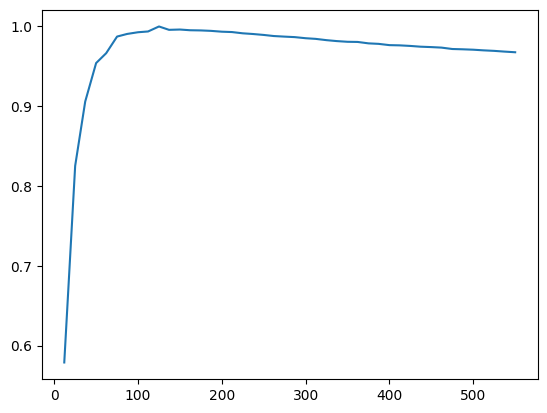

In [16]:
dynamic_aucs = [0.5787954698867472,
 0.8252096302407561,
 0.9059416485412136,
 0.9541303532588317,
 0.9664921623040578,
 0.9873516837920949,
 0.9906382659566491,
 0.992775819395485,
 0.9937448436210906,
 1.0,
 0.9957893947348685,
 0.9961719042976075,
 0.9952868821720544,
 0.9950453761344035,
 0.9945023625590642,
 0.9934613365334135,
 0.9930158253956349,
 0.9914302857571442,
 0.9905752643816096,
 0.989390234755869,
 0.9880132003300084,
 0.9872706817670444,
 0.9866601665041627,
 0.9852801320033001,
 0.9844551113777845,
 0.9828335708392711,
 0.9816920423010577,
 0.9808040201005027,
 0.9806150153753844,
 0.9788299707492688,
 0.9782104552613816,
 0.9766129153228832,
 0.9763354083852098,
 0.9756063901597541,
 0.9746643666091653,
 0.9741498537463438,
 0.9735153378834472,
 0.9717602940073503,
 0.9714047851196281,
 0.970881272031801,
 0.9700862521563041,
 0.9694157353933849,
 0.968526213155329,
 0.967684692117303]

inducing_points = [int(2500 * i / 100) for i in np.arange(0.5, 22.5, 0.5)]
plt.plot(inducing_points, dynamic_aucs)

/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/mnt/mr01-home01/f30033yc/.conda/envs/gpcenev/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/tmp/5115142.1.nvidiagpu.q/ipykernel_79288/2857181818.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
80
RBF: alpha = 0.15343672732425973
1


  0%|          | 1/200 [00:04<13:40,  4.12s/it]

Constant: alpha = 0.15479625510941353
init var = 0.18251461718044104
init var = 0.18251461718044104
80
RBF: alpha = 0.1563715146257455
1


  1%|          | 2/200 [00:07<12:19,  3.73s/it]

Constant: alpha = 0.16223814391856156
init var = 0.18000540577120072
init var = 0.18000540577120072
80
RBF: alpha = 0.15173328126565794
1


  2%|▏         | 3/200 [00:11<11:58,  3.65s/it]

Constant: alpha = 0.15767517212109017
init var = 0.1921429335440517
init var = 0.1921429335440517
80
RBF: alpha = 0.16566274983763588
1


  2%|▏         | 4/200 [00:14<11:51,  3.63s/it]

Constant: alpha = 0.17122850385370356
init var = 0.1887938826065735
init var = 0.1887938826065735
80
RBF: alpha = 0.15714599769943158
1


  2%|▎         | 5/200 [00:18<12:25,  3.82s/it]

Constant: alpha = 0.1643887186155988
init var = 0.18737822723402664
init var = 0.18737822723402664
80
RBF: alpha = 0.15901804475348785
1


  3%|▎         | 6/200 [00:22<12:25,  3.84s/it]

Constant: alpha = 0.16479248992292445
init var = 0.18732651649812093
init var = 0.18732651649812093
80
RBF: alpha = 0.15872501071154385
1


  4%|▎         | 7/200 [00:26<12:14,  3.81s/it]

Constant: alpha = 0.16625403546988474
init var = 0.19354170487427427
init var = 0.19354170487427427
80
RBF: alpha = 0.16668103306713544
1


  4%|▍         | 8/200 [00:30<11:58,  3.74s/it]

Constant: alpha = 0.17080000410135673
init var = 0.1923241018126761
init var = 0.1923241018126761
80
RBF: alpha = 0.16462411939621838
1


  4%|▍         | 9/200 [00:33<11:39,  3.66s/it]

Constant: alpha = 0.16980040645115652
init var = 0.18638064347084013
init var = 0.18638064347084013
80
RBF: alpha = 0.1592146997553777
1


  5%|▌         | 10/200 [00:36<11:17,  3.57s/it]

Constant: alpha = 0.162696351833545
init var = 0.177992338582621
init var = 0.177992338582621
80
RBF: alpha = 0.15268684003940264
1


  6%|▌         | 11/200 [00:40<11:05,  3.52s/it]

Constant: alpha = 0.15650871051957047
init var = 0.18447085534053428
init var = 0.18447085534053428
80
RBF: alpha = 0.1609022591899975
1


  6%|▌         | 12/200 [00:43<11:04,  3.54s/it]

Constant: alpha = 0.16480097400583302
init var = 0.1902721063236217
init var = 0.1902721063236217
80
RBF: alpha = 0.16450780894374145
1


  6%|▋         | 13/200 [00:47<11:12,  3.59s/it]

Constant: alpha = 0.16806852070868158
init var = 0.1849184529630658
init var = 0.1849184529630658
80
RBF: alpha = 0.14666649475258295
1


  7%|▋         | 14/200 [00:52<12:30,  4.04s/it]

Constant: alpha = 0.16399723209574107
init var = 0.18444693157085426
init var = 0.18444693157085426
80
RBF: alpha = 0.16069757944778984
1


  8%|▊         | 15/200 [00:56<12:10,  3.95s/it]

Constant: alpha = 0.16537735075454843
init var = 0.19873891074175937
init var = 0.19873891074175937
80
RBF: alpha = 0.1658573927253135
1


  8%|▊         | 16/200 [01:00<12:00,  3.92s/it]

Constant: alpha = 0.17345967805763918
init var = 0.17764990330326758
init var = 0.17764990330326758
80
RBF: alpha = 0.1502697384334687
1


  8%|▊         | 17/200 [01:04<11:55,  3.91s/it]

Constant: alpha = 0.15693714196444378
init var = 0.18153544791815612
init var = 0.18153544791815612
80
RBF: alpha = 0.15425943070702694
1


  9%|▉         | 18/200 [01:07<11:41,  3.85s/it]

Constant: alpha = 0.1625504758310802
init var = 0.18524483308882922
init var = 0.18524483308882922
80
RBF: alpha = 0.16146062904495356
1


 10%|▉         | 19/200 [01:11<11:23,  3.78s/it]

Constant: alpha = 0.16458646032680385
init var = 0.18572068182867993
init var = 0.18572068182867993
80
RBF: alpha = 0.1579497297843642
1


 10%|█         | 20/200 [01:14<11:02,  3.68s/it]

Constant: alpha = 0.1637927818320516
init var = 0.19139597729186733
init var = 0.19139597729186733
80
RBF: alpha = 0.16030392075086458
1


 10%|█         | 21/200 [01:19<11:16,  3.78s/it]

Constant: alpha = 0.16953312547560526
init var = 0.19780558868161255
init var = 0.19780558868161255
80
RBF: alpha = 0.16146995120826707
1


 11%|█         | 22/200 [01:22<11:06,  3.75s/it]

Constant: alpha = 0.1737272912788522
init var = 0.18453820177869465
init var = 0.18453820177869465
80
RBF: alpha = 0.1519194143197712
1


 12%|█▏        | 23/200 [01:26<10:46,  3.65s/it]

Constant: alpha = 0.16128395129137613
init var = 0.19186909835028979
init var = 0.19186909835028979
80
RBF: alpha = 0.16233474965967196
1


 12%|█▏        | 24/200 [01:29<10:37,  3.62s/it]

Constant: alpha = 0.16837345225878342
init var = 0.1889005655829684
init var = 0.1889005655829684
80
RBF: alpha = 0.1635995525760772
1


 12%|█▎        | 25/200 [01:33<11:02,  3.79s/it]

Constant: alpha = 0.16576129048273355
init var = 0.18072864509513253
init var = 0.18072864509513253
80
RBF: alpha = 0.15448450784924803
1


 13%|█▎        | 26/200 [01:37<10:55,  3.77s/it]

Constant: alpha = 0.15974643075515044
init var = 0.2009816248959529
init var = 0.2009816248959529
80
RBF: alpha = 0.16241182349842792
1


 14%|█▎        | 27/200 [01:42<11:40,  4.05s/it]

Constant: alpha = 0.1796639144084795
init var = 0.1838415573093989
init var = 0.1838415573093989
80
RBF: alpha = 0.15659843970929405
1


 14%|█▍        | 28/200 [01:46<11:29,  4.01s/it]

Constant: alpha = 0.16235055689148722
init var = 0.1817310817419547
init var = 0.1817310817419547
80
RBF: alpha = 0.15538410422783944
1


 14%|█▍        | 29/200 [01:49<11:03,  3.88s/it]

Constant: alpha = 0.1594419851215809
init var = 0.17625381988203034
init var = 0.17625381988203034
80
RBF: alpha = 0.15149928723989287
1


 15%|█▌        | 30/200 [01:53<10:42,  3.78s/it]

Constant: alpha = 0.15503681776554165
init var = 0.18553700784835195
init var = 0.18553700784835195
80
RBF: alpha = 0.15664634824254206
1


 16%|█▌        | 31/200 [01:57<10:46,  3.83s/it]

Constant: alpha = 0.16246803368534699
init var = 0.19236641528719614
init var = 0.19236641528719614
80
RBF: alpha = 0.16382747734878483
1


 16%|█▌        | 32/200 [02:00<10:31,  3.76s/it]

Constant: alpha = 0.1712816768334018
init var = 0.18228659248098908
init var = 0.18228659248098908
80
RBF: alpha = 0.15844996187225693
1


 16%|█▋        | 33/200 [02:04<10:12,  3.67s/it]

Constant: alpha = 0.1596399837636952
init var = 0.19047177164061346
init var = 0.19047177164061346
80
RBF: alpha = 0.16290026496799911
1


 17%|█▋        | 34/200 [02:07<09:55,  3.59s/it]

Constant: alpha = 0.16713217643504819
init var = 0.20202173923435887
init var = 0.20202173923435887
80
RBF: alpha = 0.17739229544418822
1


 18%|█▊        | 35/200 [02:11<09:46,  3.55s/it]

Constant: alpha = 0.18022048982847694
init var = 0.1935189554064219
init var = 0.1935189554064219
80
RBF: alpha = 0.16153368131641246
1


 18%|█▊        | 36/200 [02:14<09:34,  3.51s/it]

Constant: alpha = 0.17084570150678868
init var = 0.19467594187965717
init var = 0.19467594187965717
80
RBF: alpha = 0.1661370772386326
1


 18%|█▊        | 37/200 [02:18<09:38,  3.55s/it]

Constant: alpha = 0.17504704778699662
init var = 0.18847907645774553
init var = 0.18847907645774553
80
RBF: alpha = 0.15956735632192554
1


 19%|█▉        | 38/200 [02:21<09:33,  3.54s/it]

Constant: alpha = 0.16573897058749443
init var = 0.19355017489076787
init var = 0.19355017489076787
80
RBF: alpha = 0.1640892228021618
1


 20%|█▉        | 39/200 [02:25<09:40,  3.61s/it]

Constant: alpha = 0.17531886761881108
init var = 0.1913045872591859
init var = 0.1913045872591859
80
RBF: alpha = 0.16248517889512826
1


 20%|██        | 40/200 [02:28<09:29,  3.56s/it]

Constant: alpha = 0.16764857050868628
init var = 0.18457299616846984
init var = 0.18457299616846984
80
RBF: alpha = 0.15877894012929347
1


 20%|██        | 41/200 [02:33<10:19,  3.90s/it]

Constant: alpha = 0.16296619874300491
init var = 0.1820636409477672
init var = 0.1820636409477672
80
RBF: alpha = 0.1601006506127562
1


 21%|██        | 42/200 [02:37<10:12,  3.88s/it]

Constant: alpha = 0.16529062455996224
init var = 0.18804719416997015
init var = 0.18804719416997015
80
RBF: alpha = 0.154663694813835
1


 22%|██▏       | 43/200 [02:41<10:06,  3.87s/it]

Constant: alpha = 0.16322202930804106
init var = 0.177299570879259
init var = 0.177299570879259
80
RBF: alpha = 0.14946002861519786
1


 22%|██▏       | 44/200 [02:44<09:49,  3.78s/it]

Constant: alpha = 0.15670279797792308
init var = 0.19255487686240394
init var = 0.19255487686240394
80
RBF: alpha = 0.16687183582094817
1


 22%|██▎       | 45/200 [02:48<09:34,  3.71s/it]

Constant: alpha = 0.17218442727336022
init var = 0.1765970923511116
init var = 0.1765970923511116
80
RBF: alpha = 0.15167511694380603
1


 23%|██▎       | 46/200 [02:51<09:20,  3.64s/it]

Constant: alpha = 0.15434296930824012
init var = 0.18769385603696961
init var = 0.18769385603696961
80
RBF: alpha = 0.15659062701114837
1


 24%|██▎       | 47/200 [02:55<09:13,  3.62s/it]

Constant: alpha = 0.16344150616828731
init var = 0.18984293832684115
init var = 0.18984293832684115
80
RBF: alpha = 0.1639110871158811
1


 24%|██▍       | 48/200 [02:58<09:03,  3.58s/it]

Constant: alpha = 0.16944049279740245
init var = 0.1884007141926594
init var = 0.1884007141926594
80
RBF: alpha = 0.15976516700821256
1


 24%|██▍       | 49/200 [03:02<08:57,  3.56s/it]

Constant: alpha = 0.16639995147111913
init var = 0.19615933672280747
init var = 0.19615933672280747
80
RBF: alpha = 0.1661058011508206
1


 25%|██▌       | 50/200 [03:06<08:55,  3.57s/it]

Constant: alpha = 0.17481100591901655
init var = 0.20201470484454842
init var = 0.20201470484454842
80
RBF: alpha = 0.17461356248716248
1


 26%|██▌       | 51/200 [03:09<08:52,  3.58s/it]

Constant: alpha = 0.1789850402946286
init var = 0.19463762723792183
init var = 0.19463762723792183
80
RBF: alpha = 0.16475786519974572
1


 26%|██▌       | 52/200 [03:13<09:06,  3.69s/it]

Constant: alpha = 0.17245560943109264
init var = 0.19098503329883548
init var = 0.19098503329883548
80
RBF: alpha = 0.1608668333669587
1


 26%|██▋       | 53/200 [03:17<09:22,  3.83s/it]

Constant: alpha = 0.1652365538950434
init var = 0.18712982968275874
init var = 0.18712982968275874
80
RBF: alpha = 0.15995862992831197
1


 27%|██▋       | 54/200 [03:21<09:10,  3.77s/it]

Constant: alpha = 0.166409310369627
init var = 0.18744691883764936
init var = 0.18744691883764936
80
RBF: alpha = 0.16296664274187056
1


 28%|██▊       | 55/200 [03:24<08:56,  3.70s/it]

Constant: alpha = 0.16596908625854212
init var = 0.19139035078235467
init var = 0.19139035078235467
80
RBF: alpha = 0.16087827108553035
1


 28%|██▊       | 56/200 [03:28<08:52,  3.70s/it]

Constant: alpha = 0.16834066961227812
init var = 0.18500353552243082
init var = 0.18500353552243082
80
RBF: alpha = 0.1576434174057171
1


 28%|██▊       | 57/200 [03:33<09:45,  4.09s/it]

Constant: alpha = 0.16518847683766955
init var = 0.19212405939913216
init var = 0.19212405939913216
80
RBF: alpha = 0.16363915736463508
1


 29%|██▉       | 58/200 [03:37<09:17,  3.93s/it]

Constant: alpha = 0.16892728155630607
init var = 0.18615977908643203
init var = 0.18615977908643203
80
RBF: alpha = 0.16359740016623034
1


 30%|██▉       | 59/200 [03:41<09:10,  3.91s/it]

Constant: alpha = 0.16538720817526267
init var = 0.17855720455888277
init var = 0.17855720455888277
80
RBF: alpha = 0.1519391183794643
1


 30%|███       | 60/200 [03:44<08:45,  3.75s/it]

Constant: alpha = 0.1568592278621668
init var = 0.187905604589803
init var = 0.187905604589803
80
RBF: alpha = 0.1621448287545096
1


 30%|███       | 61/200 [03:48<08:36,  3.71s/it]

Constant: alpha = 0.16724812862125651
init var = 0.19134614729784766
init var = 0.19134614729784766
80
RBF: alpha = 0.1606551660566196
1


 31%|███       | 62/200 [03:51<08:17,  3.61s/it]

Constant: alpha = 0.1690191634144366
init var = 0.19189906313280275
init var = 0.19189906313280275
80
RBF: alpha = 0.16150491840047365
1


 32%|███▏      | 63/200 [03:54<08:08,  3.56s/it]

Constant: alpha = 0.16932702549474649
init var = 0.18712470334654238
init var = 0.18712470334654238
80
RBF: alpha = 0.1610168805448278
1


 32%|███▏      | 64/200 [03:58<08:11,  3.61s/it]

Constant: alpha = 0.1651831461879371
init var = 0.19439237761994174
init var = 0.19439237761994174
80
RBF: alpha = 0.16766140303235655
1


 32%|███▎      | 65/200 [04:02<08:10,  3.63s/it]

Constant: alpha = 0.17282197233866334
init var = 0.19138408821344913
init var = 0.19138408821344913
80
RBF: alpha = 0.15598021945597756
1


 33%|███▎      | 66/200 [04:05<08:10,  3.66s/it]

Constant: alpha = 0.1693587738944226
init var = 0.18513405506523897
init var = 0.18513405506523897
80
RBF: alpha = 0.160493615379772
1


 34%|███▎      | 67/200 [04:09<07:57,  3.59s/it]

Constant: alpha = 0.1644939917188249
init var = 0.17700980984565523
init var = 0.17700980984565523
80
RBF: alpha = 0.15301342605950688
1


 34%|███▍      | 68/200 [04:13<08:23,  3.82s/it]

Constant: alpha = 0.155361749329804
init var = 0.18050577785314337
init var = 0.18050577785314337
80
RBF: alpha = 0.15106017717435977
1


 34%|███▍      | 69/200 [04:17<08:20,  3.82s/it]

Constant: alpha = 0.15762666065358458
init var = 0.1871306327538262
init var = 0.1871306327538262
80
RBF: alpha = 0.15805692541211044
1


 35%|███▌      | 70/200 [04:21<08:01,  3.70s/it]

Constant: alpha = 0.16176191216040728
init var = 0.1937282793998751
init var = 0.1937282793998751
80
RBF: alpha = 0.16050535496475818
1


 36%|███▌      | 71/200 [04:24<07:52,  3.66s/it]

Constant: alpha = 0.1677322818676869
init var = 0.18077769827211718
init var = 0.18077769827211718
80
RBF: alpha = 0.14962119621623676
1


 36%|███▌      | 72/200 [04:28<07:45,  3.64s/it]

Constant: alpha = 0.1577190947797802
init var = 0.19934288541023323
init var = 0.19934288541023323
80
RBF: alpha = 0.16982782876842822
1


 36%|███▋      | 73/200 [04:31<07:37,  3.61s/it]

Constant: alpha = 0.17305662053701
init var = 0.1812393572341548
init var = 0.1812393572341548
80
RBF: alpha = 0.15179092059841243
1


 37%|███▋      | 74/200 [04:36<08:19,  3.97s/it]

Constant: alpha = 0.16118984444113565
init var = 0.18118803996273408
init var = 0.18118803996273408
80
RBF: alpha = 0.15804862619325105
1


 38%|███▊      | 75/200 [04:40<08:04,  3.88s/it]

Constant: alpha = 0.16020926257436546
init var = 0.1946824148352581
init var = 0.1946824148352581
80
RBF: alpha = 0.17018390564320213
1


 38%|███▊      | 76/200 [04:43<07:41,  3.72s/it]

Constant: alpha = 0.17547585372115707
init var = 0.1928627990940652
init var = 0.1928627990940652
80
RBF: alpha = 0.16805818170975734
1


 38%|███▊      | 77/200 [04:47<07:51,  3.84s/it]

Constant: alpha = 0.17047813634888243
init var = 0.18950380636391354
init var = 0.18950380636391354
80
RBF: alpha = 0.15719346663591865
1


 39%|███▉      | 78/200 [04:51<07:51,  3.86s/it]

Constant: alpha = 0.1679768738666584
init var = 0.17661892455398379
init var = 0.17661892455398379
80
RBF: alpha = 0.15025989650583532
1


 40%|███▉      | 79/200 [04:55<07:36,  3.78s/it]

Constant: alpha = 0.15520514742122116
init var = 0.19723990422634793
init var = 0.19723990422634793
80
RBF: alpha = 0.16720703571696288
1


 40%|████      | 80/200 [04:58<07:29,  3.75s/it]

Constant: alpha = 0.17166600375928223
init var = 0.19027795894115634
init var = 0.19027795894115634
80
RBF: alpha = 0.16329288541959824
1


 40%|████      | 81/200 [05:02<07:35,  3.83s/it]

Constant: alpha = 0.1682962317810328
init var = 0.1879455569989547
init var = 0.1879455569989547
80
RBF: alpha = 0.1602482836167677
1


 41%|████      | 82/200 [05:06<07:26,  3.79s/it]

Constant: alpha = 0.16566208839820368
init var = 0.18236320995023894
init var = 0.18236320995023894
80
RBF: alpha = 0.15564616784454358
1


 42%|████▏     | 83/200 [05:10<07:22,  3.78s/it]

Constant: alpha = 0.16276584257306875
init var = 0.17965925674475883
init var = 0.17965925674475883
80
RBF: alpha = 0.1531406641624371
1


 42%|████▏     | 84/200 [05:13<07:05,  3.67s/it]

Constant: alpha = 0.15674410926710175
init var = 0.19986860116046415
init var = 0.19986860116046415
80
RBF: alpha = 0.16600498866677596
1


 42%|████▎     | 85/200 [05:17<06:55,  3.61s/it]

Constant: alpha = 0.17338310430475962
init var = 0.18643878548815637
init var = 0.18643878548815637
80
RBF: alpha = 0.15877331587463614
1


 43%|████▎     | 86/200 [05:20<06:47,  3.57s/it]

Constant: alpha = 0.16269201798355545
init var = 0.19556701897434078
init var = 0.19556701897434078
80
RBF: alpha = 0.1585994601092453
1


 44%|████▎     | 87/200 [05:24<06:45,  3.59s/it]

Constant: alpha = 0.17149443839766457
init var = 0.19426152981215236
init var = 0.19426152981215236
80
RBF: alpha = 0.1647836464120473
1


 44%|████▍     | 88/200 [05:27<06:35,  3.53s/it]

Constant: alpha = 0.17045467660301267
init var = 0.1911426452140504
init var = 0.1911426452140504
80
RBF: alpha = 0.16426024848982188
1


 44%|████▍     | 89/200 [05:31<06:24,  3.47s/it]

Constant: alpha = 0.16837805542725423
init var = 0.18481070816440756
init var = 0.18481070816440756
80
RBF: alpha = 0.15934503848384365
1


 45%|████▌     | 90/200 [05:34<06:25,  3.50s/it]

Constant: alpha = 0.1635972721936173
init var = 0.19173431483439168
init var = 0.19173431483439168
80
RBF: alpha = 0.15953675474526327
1


 46%|████▌     | 91/200 [05:38<06:28,  3.57s/it]

Constant: alpha = 0.16800792722982627
init var = 0.19224626624249794
init var = 0.19224626624249794
80
RBF: alpha = 0.1675850313431298
1


 46%|████▌     | 92/200 [05:43<07:23,  4.11s/it]

Constant: alpha = 0.171958231293929
init var = 0.17678398557556924
init var = 0.17678398557556924
80
RBF: alpha = 0.15083167763120525
1


 46%|████▋     | 93/200 [05:48<07:29,  4.20s/it]

Constant: alpha = 0.15742116828615008
init var = 0.19169658675863435
init var = 0.19169658675863435
80
RBF: alpha = 0.16454200724209952
1


 47%|████▋     | 94/200 [05:51<07:10,  4.06s/it]

Constant: alpha = 0.16963356708784505
init var = 0.1897264007196931
init var = 0.1897264007196931
80
RBF: alpha = 0.15809732168217566
1


 48%|████▊     | 95/200 [05:55<06:51,  3.92s/it]

Constant: alpha = 0.16473049238152046
init var = 0.1996002208094495
init var = 0.1996002208094495
80
RBF: alpha = 0.16219744489629492
1


 48%|████▊     | 96/200 [05:59<06:45,  3.90s/it]

Constant: alpha = 0.17492278329682803
init var = 0.19207613869801285
init var = 0.19207613869801285
80
RBF: alpha = 0.16695503041922008
1


 48%|████▊     | 97/200 [06:02<06:36,  3.85s/it]

Constant: alpha = 0.172123143516058
init var = 0.18026366288436121
init var = 0.18026366288436121
80
RBF: alpha = 0.15554251821322043
1


 49%|████▉     | 98/200 [06:06<06:23,  3.76s/it]

Constant: alpha = 0.15879759506700994
init var = 0.1915906854044125
init var = 0.1915906854044125
80
RBF: alpha = 0.15905203698273565
1


 50%|████▉     | 99/200 [06:10<06:18,  3.75s/it]

Constant: alpha = 0.17005539844371725
init var = 0.1817185952749986
init var = 0.1817185952749986
80
RBF: alpha = 0.14823994890489506
1


 50%|█████     | 100/200 [06:13<06:10,  3.71s/it]

Constant: alpha = 0.1585681002646347
init var = 0.24754831416919856
init var = 0.24754831416919856
80
RBF: alpha = 0.22516431201114873
1


 50%|█████     | 101/200 [06:17<05:52,  3.56s/it]

Constant: alpha = 0.2251653273999284
init var = 0.27070996502769
init var = 0.27070996502769
80
RBF: alpha = 0.24530516538948058
1


 51%|█████     | 102/200 [06:20<05:40,  3.47s/it]

Constant: alpha = 0.2457769305868237
init var = 0.259533520129815
init var = 0.259533520129815
80
RBF: alpha = 0.2348321578777004
1


 52%|█████▏    | 103/200 [06:23<05:37,  3.48s/it]

Constant: alpha = 0.23562948502970896
init var = 0.2726707165969728
init var = 0.2726707165969728
80
RBF: alpha = 0.24297263893176607
1


 52%|█████▏    | 104/200 [06:27<05:39,  3.53s/it]

Constant: alpha = 0.2454970750718807
init var = 0.2847883074191565
init var = 0.2847883074191565
80
RBF: alpha = 0.25752977931857124
1


 52%|█████▎    | 105/200 [06:31<05:34,  3.52s/it]

Constant: alpha = 0.25752964055492844
init var = 0.25888862758786635
init var = 0.25888862758786635
80
RBF: alpha = 0.23784499248388913
1


 53%|█████▎    | 106/200 [06:34<05:34,  3.56s/it]

Constant: alpha = 0.23782723717615634
init var = 0.25287073283496503
init var = 0.25287073283496503
80
RBF: alpha = 0.2273932773390075
1


 54%|█████▎    | 107/200 [06:38<05:26,  3.52s/it]

Constant: alpha = 0.22926588419121585
init var = 0.2581356228386315
init var = 0.2581356228386315
80
RBF: alpha = 0.23559843393993896
1


 54%|█████▍    | 108/200 [06:41<05:27,  3.56s/it]

Constant: alpha = 0.23647459876638124
init var = 0.27270522961818244
init var = 0.27270522961818244
80
RBF: alpha = 0.24773126042817092
1


 55%|█████▍    | 109/200 [06:45<05:39,  3.74s/it]

Constant: alpha = 0.24823450808464181
init var = 0.267723275748422
init var = 0.267723275748422
80
RBF: alpha = 0.24150069865262952
1


 55%|█████▌    | 110/200 [06:49<05:27,  3.64s/it]

Constant: alpha = 0.24152024649691822
init var = 0.26235340469849927
init var = 0.26235340469849927
80
RBF: alpha = 0.23703824247316074
1


 56%|█████▌    | 111/200 [06:52<05:16,  3.56s/it]

Constant: alpha = 0.2370824905889479
init var = 0.2630835125392173
init var = 0.2630835125392173
80
RBF: alpha = 0.23768358999743208
1


 56%|█████▌    | 112/200 [06:58<06:19,  4.32s/it]

Constant: alpha = 0.23766793093579444
init var = 0.27673341112442473
init var = 0.27673341112442473
80
RBF: alpha = 0.2534993841384472
1


 56%|█████▋    | 113/200 [07:02<05:51,  4.04s/it]

Constant: alpha = 0.25351539112099375
init var = 0.2736877114899321
init var = 0.2736877114899321
80
RBF: alpha = 0.24975388044256566
1


 57%|█████▋    | 114/200 [07:05<05:25,  3.78s/it]

Constant: alpha = 0.2498364503213338
init var = 0.2585729934586864
init var = 0.2585729934586864
80
RBF: alpha = 0.23987206708494205
1


 57%|█████▊    | 115/200 [07:08<05:05,  3.60s/it]

Constant: alpha = 0.2399185572846969
init var = 0.270269751498405
init var = 0.270269751498405
80
RBF: alpha = 0.24639051688174973
1


 58%|█████▊    | 116/200 [07:11<04:57,  3.55s/it]

Constant: alpha = 0.24640344368812267
init var = 0.26395550486170927
init var = 0.26395550486170927
80
RBF: alpha = 0.23513400886863034
1


 58%|█████▊    | 117/200 [07:15<04:54,  3.55s/it]

Constant: alpha = 0.2362309885900088
init var = 0.26842063217072093
init var = 0.26842063217072093
80
RBF: alpha = 0.24182008923137688
1


 59%|█████▉    | 118/200 [07:19<04:55,  3.61s/it]

Constant: alpha = 0.2439495215620688
init var = 0.2652369141470639
init var = 0.2652369141470639
80
RBF: alpha = 0.23452823920507118
1


 60%|█████▉    | 119/200 [07:22<04:47,  3.56s/it]

Constant: alpha = 0.23454098093819786
init var = 0.27431036807204234
init var = 0.27431036807204234
80
RBF: alpha = 0.2461631914840973
1


 60%|██████    | 120/200 [07:26<04:45,  3.57s/it]

Constant: alpha = 0.2470868069981015
init var = 0.2484928768979747
init var = 0.2484928768979747
80
RBF: alpha = 0.22510938958413068
1


 60%|██████    | 121/200 [07:29<04:40,  3.55s/it]

Constant: alpha = 0.22510306890165097
init var = 0.2572872810956378
init var = 0.2572872810956378
80
RBF: alpha = 0.23209595704556193
1


 61%|██████    | 122/200 [07:33<04:43,  3.64s/it]

Constant: alpha = 0.2346278461669096
init var = 0.2743254842045989
init var = 0.2743254842045989
80
RBF: alpha = 0.2500321004554826
1


 62%|██████▏   | 123/200 [07:37<04:35,  3.58s/it]

Constant: alpha = 0.2500213029279052
init var = 0.25354278072497166
init var = 0.25354278072497166
80
RBF: alpha = 0.22927518893547083
1


 62%|██████▏   | 124/200 [07:40<04:30,  3.56s/it]

Constant: alpha = 0.2292485907595952
init var = 0.26314084004905114
init var = 0.26314084004905114
80
RBF: alpha = 0.2397862914249862
1


 62%|██████▎   | 125/200 [07:44<04:26,  3.56s/it]

Constant: alpha = 0.23978360582285416
init var = 0.26291934438975806
init var = 0.26291934438975806
80
RBF: alpha = 0.2342178208297877
1


 63%|██████▎   | 126/200 [07:47<04:23,  3.56s/it]

Constant: alpha = 0.23424122349759446
init var = 0.2613391926805992
init var = 0.2613391926805992
80
RBF: alpha = 0.23823975460736177
1


 64%|██████▎   | 127/200 [07:51<04:18,  3.54s/it]

Constant: alpha = 0.23895689226735609
init var = 0.26445832528129154
init var = 0.26445832528129154
80
RBF: alpha = 0.2372181250817772
1


 64%|██████▍   | 128/200 [07:54<04:13,  3.52s/it]

Constant: alpha = 0.23729562825198375
init var = 0.2682535567882799
init var = 0.2682535567882799
80
RBF: alpha = 0.2397013239381573
1


 64%|██████▍   | 129/200 [07:57<04:03,  3.43s/it]

Constant: alpha = 0.23970372624306646
init var = 0.25971518639820923
init var = 0.25971518639820923
80
RBF: alpha = 0.2336134429705789
1


 65%|██████▌   | 130/200 [08:01<04:01,  3.45s/it]

Constant: alpha = 0.23593823548529747
init var = 0.2677535777461697
init var = 0.2677535777461697
80
RBF: alpha = 0.24755444797903903
1


 66%|██████▌   | 131/200 [08:04<03:57,  3.44s/it]

Constant: alpha = 0.24818093576175973
init var = 0.274012594814589
init var = 0.274012594814589
80
RBF: alpha = 0.24356161368873763
1


 66%|██████▌   | 132/200 [08:10<04:39,  4.12s/it]

Constant: alpha = 0.243557625865022
init var = 0.27202227021177317
init var = 0.27202227021177317
80
RBF: alpha = 0.2417071251244654
1


 66%|██████▋   | 133/200 [08:14<04:30,  4.04s/it]

Constant: alpha = 0.2417550867065263
init var = 0.26924059965330865
init var = 0.26924059965330865
80
RBF: alpha = 0.24962169710744952
1


 67%|██████▋   | 134/200 [08:18<04:21,  3.97s/it]

Constant: alpha = 0.24962424020543578
init var = 0.27095682300694146
init var = 0.27095682300694146
80
RBF: alpha = 0.24388491835492904
1


 68%|██████▊   | 135/200 [08:21<04:10,  3.85s/it]

Constant: alpha = 0.24385161212686018
init var = 0.27395243151846166
init var = 0.27395243151846166
80
RBF: alpha = 0.2487464040311591
1


 68%|██████▊   | 136/200 [08:25<03:59,  3.75s/it]

Constant: alpha = 0.24873551011397063
init var = 0.26093133809202884
init var = 0.26093133809202884
80
RBF: alpha = 0.2331367636804622
1


 68%|██████▊   | 137/200 [08:28<03:49,  3.64s/it]

Constant: alpha = 0.23313693395410937
init var = 0.2790149294451515
init var = 0.2790149294451515
80
RBF: alpha = 0.2520756430287565
1


 69%|██████▉   | 138/200 [08:32<03:44,  3.62s/it]

Constant: alpha = 0.2525439158219231
init var = 0.27667499432067677
init var = 0.27667499432067677
80
RBF: alpha = 0.24971438435602877
1


 70%|██████▉   | 139/200 [08:35<03:39,  3.60s/it]

Constant: alpha = 0.25126019399327765
init var = 0.25365106208211907
init var = 0.25365106208211907
80
RBF: alpha = 0.22646995979393084
1


 70%|███████   | 140/200 [08:39<03:31,  3.52s/it]

Constant: alpha = 0.22645839086852113
init var = 0.2815051933324125
init var = 0.2815051933324125
80
RBF: alpha = 0.25339089813793697
1


 70%|███████   | 141/200 [08:42<03:20,  3.41s/it]

Constant: alpha = 0.25338473007765044
init var = 0.2678332720622311
init var = 0.2678332720622311
80
RBF: alpha = 0.24753634879509862
1


 71%|███████   | 142/200 [08:45<03:12,  3.31s/it]

Constant: alpha = 0.2476369824634664
init var = 0.2800263183350793
init var = 0.2800263183350793
80
RBF: alpha = 0.2565600342450326
1


 72%|███████▏  | 143/200 [08:48<03:08,  3.31s/it]

Constant: alpha = 0.2565820799472356
init var = 0.2642347816705196
init var = 0.2642347816705196
80
RBF: alpha = 0.23725427703432836
1


 72%|███████▏  | 144/200 [08:52<03:14,  3.47s/it]

Constant: alpha = 0.2393035137291848
init var = 0.26208515209150907
init var = 0.26208515209150907
80
RBF: alpha = 0.2353784204685623
1


 72%|███████▎  | 145/200 [08:56<03:17,  3.60s/it]

Constant: alpha = 0.23898243362960542
init var = 0.28851171670152387
init var = 0.28851171670152387
80
RBF: alpha = 0.2608768835149578
1


 73%|███████▎  | 146/200 [08:59<03:12,  3.56s/it]

Constant: alpha = 0.26087630470971107
init var = 0.2559241961706752
init var = 0.2559241961706752
80
RBF: alpha = 0.2291038950319509
1


 74%|███████▎  | 147/200 [09:03<03:08,  3.55s/it]

Constant: alpha = 0.2290871338282878
init var = 0.26749370420998136
init var = 0.26749370420998136
80
RBF: alpha = 0.24186599070848241
1


 74%|███████▍  | 148/200 [09:06<03:02,  3.51s/it]

Constant: alpha = 0.2418687972450734
init var = 0.2607904999471453
init var = 0.2607904999471453
80
RBF: alpha = 0.23593430196173926
1


 74%|███████▍  | 149/200 [09:10<02:59,  3.52s/it]

Constant: alpha = 0.23594832987533396
init var = 0.2792994026767383
init var = 0.2792994026767383
80
RBF: alpha = 0.24820886353899752
1


 75%|███████▌  | 150/200 [09:13<02:53,  3.47s/it]

Constant: alpha = 0.2482493485947925
init var = 0.26306759791259493
init var = 0.26306759791259493
80
RBF: alpha = 0.23691982939291678
1


 76%|███████▌  | 151/200 [09:17<02:50,  3.47s/it]

Constant: alpha = 0.23693699804885246
init var = 0.26625108874599557
init var = 0.26625108874599557
80
RBF: alpha = 0.24052024209153
1


 76%|███████▌  | 152/200 [09:21<02:53,  3.62s/it]

Constant: alpha = 0.24122571500681078
init var = 0.27074558370051927
init var = 0.27074558370051927
80
RBF: alpha = 0.24200784245749632
1


 76%|███████▋  | 153/200 [09:24<02:51,  3.66s/it]

Constant: alpha = 0.24255434706662404
init var = 0.2721220670534556
init var = 0.2721220670534556
80
RBF: alpha = 0.24273564269010084
1


 77%|███████▋  | 154/200 [09:28<02:43,  3.55s/it]

Constant: alpha = 0.2427358453343136
init var = 0.2673923764003277
init var = 0.2673923764003277
80
RBF: alpha = 0.24068714294791588
1


 78%|███████▊  | 155/200 [09:33<03:05,  4.13s/it]

Constant: alpha = 0.2406927991920502
init var = 0.273349215180816
init var = 0.273349215180816
80
RBF: alpha = 0.24858971326026735
1


 78%|███████▊  | 156/200 [09:36<02:50,  3.88s/it]

Constant: alpha = 0.24860712554703332
init var = 0.2665539092759979
init var = 0.2665539092759979
80
RBF: alpha = 0.24447583138572385
1


 78%|███████▊  | 157/200 [09:40<02:43,  3.80s/it]

Constant: alpha = 0.24449168660368203
init var = 0.28290389705388297
init var = 0.28290389705388297
80
RBF: alpha = 0.25641309661000544
1


 79%|███████▉  | 158/200 [09:44<02:35,  3.70s/it]

Constant: alpha = 0.2564551432323433
init var = 0.26460610547014446
init var = 0.26460610547014446
80
RBF: alpha = 0.23818083908171941
1


 80%|███████▉  | 159/200 [09:47<02:31,  3.70s/it]

Constant: alpha = 0.2391434526015973
init var = 0.2547145943820514
init var = 0.2547145943820514
80
RBF: alpha = 0.23407676082286163
1


 80%|████████  | 160/200 [09:51<02:24,  3.62s/it]

Constant: alpha = 0.23417958510033832
init var = 0.2538440587871548
init var = 0.2538440587871548
80
RBF: alpha = 0.2295035255295524
1


 80%|████████  | 161/200 [09:54<02:21,  3.63s/it]

Constant: alpha = 0.2326732281558696
init var = 0.27024664543981397
init var = 0.27024664543981397
80
RBF: alpha = 0.2430081068502544
1


 81%|████████  | 162/200 [09:58<02:17,  3.61s/it]

Constant: alpha = 0.24300657544523768
init var = 0.26027298083987455
init var = 0.26027298083987455
80
RBF: alpha = 0.23543621963137834
1


 82%|████████▏ | 163/200 [10:01<02:12,  3.57s/it]

Constant: alpha = 0.23545442348670403
init var = 0.2734235157268368
init var = 0.2734235157268368
80
RBF: alpha = 0.2430677134906029
1


 82%|████████▏ | 164/200 [10:05<02:07,  3.55s/it]

Constant: alpha = 0.24312332132322662
init var = 0.2623005121323274
init var = 0.2623005121323274
80
RBF: alpha = 0.23753211441817687
1


 82%|████████▎ | 165/200 [10:09<02:05,  3.59s/it]

Constant: alpha = 0.23759763736146294
init var = 0.25903352511033134
init var = 0.25903352511033134
80
RBF: alpha = 0.2357735727398346
1


 83%|████████▎ | 166/200 [10:12<02:01,  3.57s/it]

Constant: alpha = 0.23575492983695623
init var = 0.2734318167177596
init var = 0.2734318167177596
80
RBF: alpha = 0.24851811221875342
1


 84%|████████▎ | 167/200 [10:16<01:56,  3.53s/it]

Constant: alpha = 0.24853961498438307
init var = 0.2831821747125523
init var = 0.2831821747125523
80
RBF: alpha = 0.2548143766517082
1


 84%|████████▍ | 168/200 [10:19<01:52,  3.50s/it]

Constant: alpha = 0.25648331443900474
init var = 0.25900189788777883
init var = 0.25900189788777883
80
RBF: alpha = 0.2376182362856515
1


 84%|████████▍ | 169/200 [10:22<01:45,  3.41s/it]

Constant: alpha = 0.23763394254901313
init var = 0.269549262720465
init var = 0.269549262720465
80
RBF: alpha = 0.2464159079496864
1


 85%|████████▌ | 170/200 [10:25<01:40,  3.35s/it]

Constant: alpha = 0.24652533136605229
init var = 0.2659220706572185
init var = 0.2659220706572185
80
RBF: alpha = 0.23506249817133584
1


 86%|████████▌ | 171/200 [10:29<01:40,  3.47s/it]

Constant: alpha = 0.23682416862305836
init var = 0.2539808744300411
init var = 0.2539808744300411
80
RBF: alpha = 0.23441862297034935
1


 86%|████████▌ | 172/200 [10:33<01:37,  3.49s/it]

Constant: alpha = 0.23530764112650593
init var = 0.2564971022467629
init var = 0.2564971022467629
80
RBF: alpha = 0.23395767343881466
1


 86%|████████▋ | 173/200 [10:36<01:33,  3.47s/it]

Constant: alpha = 0.23398829886998904
init var = 0.2552447087032609
init var = 0.2552447087032609
80
RBF: alpha = 0.23093381919193282
1


 87%|████████▋ | 174/200 [10:39<01:28,  3.40s/it]

Constant: alpha = 0.23093200017264548
init var = 0.2663331459818684
init var = 0.2663331459818684
80
RBF: alpha = 0.23983988208560156
1


 88%|████████▊ | 175/200 [10:43<01:25,  3.43s/it]

Constant: alpha = 0.2398347014385314
init var = 0.27183915227684335
init var = 0.27183915227684335
80
RBF: alpha = 0.2454869250564331
1


 88%|████████▊ | 176/200 [10:46<01:22,  3.43s/it]

Constant: alpha = 0.24548468006579854
init var = 0.2748613443407829
init var = 0.2748613443407829
80
RBF: alpha = 0.24330782774035556
1


 88%|████████▊ | 177/200 [10:50<01:21,  3.55s/it]

Constant: alpha = 0.24443890606620777
init var = 0.27582010172403976
init var = 0.27582010172403976
80
RBF: alpha = 0.25899241205302814
1


 89%|████████▉ | 178/200 [10:54<01:18,  3.59s/it]

Constant: alpha = 0.25899823016114626
init var = 0.2610182774129347
init var = 0.2610182774129347
80
RBF: alpha = 0.24032656318235837
1


 90%|████████▉ | 179/200 [10:59<01:26,  4.14s/it]

Constant: alpha = 0.24032550956449403
init var = 0.26348450541884405
init var = 0.26348450541884405
80
RBF: alpha = 0.23490969372733583
1


 90%|█████████ | 180/200 [11:03<01:18,  3.94s/it]

Constant: alpha = 0.234891957345904
init var = 0.27214132482172354
init var = 0.27214132482172354
80
RBF: alpha = 0.24961571729158544
1


 90%|█████████ | 181/200 [11:06<01:12,  3.84s/it]

Constant: alpha = 0.25058669793322624
init var = 0.2723870180832515
init var = 0.2723870180832515
80
RBF: alpha = 0.24272230737799336
1


 91%|█████████ | 182/200 [11:10<01:06,  3.69s/it]

Constant: alpha = 0.24337393825273684
init var = 0.25545744762283645
init var = 0.25545744762283645
80
RBF: alpha = 0.23238777694513804
1


 92%|█████████▏| 183/200 [11:13<01:01,  3.62s/it]

Constant: alpha = 0.23328648622389808
init var = 0.25849400750209045
init var = 0.25849400750209045
80
RBF: alpha = 0.22907384430471264
1


 92%|█████████▏| 184/200 [11:16<00:55,  3.48s/it]

Constant: alpha = 0.22910346074682153
init var = 0.2646263792239976
init var = 0.2646263792239976
80
RBF: alpha = 0.2393119409287557
1


 92%|█████████▎| 185/200 [11:20<00:55,  3.71s/it]

Constant: alpha = 0.2407263062084238
init var = 0.2680809704736133
init var = 0.2680809704736133
80
RBF: alpha = 0.24333582776758278
1


 93%|█████████▎| 186/200 [11:24<00:51,  3.66s/it]

Constant: alpha = 0.24334619902540144
init var = 0.2620779371782713
init var = 0.2620779371782713
80
RBF: alpha = 0.24076394908910004
1


 94%|█████████▎| 187/200 [11:28<00:48,  3.70s/it]

Constant: alpha = 0.24113958056910056
init var = 0.2714576862802098
init var = 0.2714576862802098
80
RBF: alpha = 0.24938940625041994
1


 94%|█████████▍| 188/200 [11:31<00:43,  3.61s/it]

Constant: alpha = 0.24943192821302768
init var = 0.27842945594220175
init var = 0.27842945594220175
80
RBF: alpha = 0.24736550227977205
1


 94%|█████████▍| 189/200 [11:34<00:38,  3.51s/it]

Constant: alpha = 0.247380845345897
init var = 0.26118754363608426
init var = 0.26118754363608426
80
RBF: alpha = 0.23628794517782895
1


 95%|█████████▌| 190/200 [11:38<00:35,  3.52s/it]

Constant: alpha = 0.23771222536089812
init var = 0.265121639390287
init var = 0.265121639390287
80
RBF: alpha = 0.24427702659082065
1


 96%|█████████▌| 191/200 [11:42<00:33,  3.73s/it]

Constant: alpha = 0.24550550847428132
init var = 0.2573889364245476
init var = 0.2573889364245476
80
RBF: alpha = 0.23437722583627182
1


 96%|█████████▌| 192/200 [11:46<00:29,  3.65s/it]

Constant: alpha = 0.2344151785819934
init var = 0.2652075625612113
init var = 0.2652075625612113
80
RBF: alpha = 0.23942775587042858
1


 96%|█████████▋| 193/200 [11:49<00:25,  3.67s/it]

Constant: alpha = 0.24084731524309702
init var = 0.26419333502003345
init var = 0.26419333502003345
80
RBF: alpha = 0.23684247613388418
1


 97%|█████████▋| 194/200 [11:53<00:21,  3.61s/it]

Constant: alpha = 0.2368336307599364
init var = 0.26765036301777884
init var = 0.26765036301777884
80
RBF: alpha = 0.2402569474303454
1


 98%|█████████▊| 195/200 [11:57<00:18,  3.68s/it]

Constant: alpha = 0.24114952162878409
init var = 0.2699417004631023
init var = 0.2699417004631023
80
RBF: alpha = 0.23972077308493497
1


 98%|█████████▊| 196/200 [12:00<00:14,  3.53s/it]

Constant: alpha = 0.23972152761803714
init var = 0.27077532785667197
init var = 0.27077532785667197
80
RBF: alpha = 0.24802210989861628
1


 98%|█████████▊| 197/200 [12:04<00:10,  3.65s/it]

Constant: alpha = 0.24800195032412517
init var = 0.26395286283727565
init var = 0.26395286283727565
80
RBF: alpha = 0.23875244904791965
1


 99%|█████████▉| 198/200 [12:07<00:07,  3.61s/it]

Constant: alpha = 0.23873803839374066
init var = 0.26779168909991247
init var = 0.26779168909991247
80
RBF: alpha = 0.24095865181910286
1


100%|█████████▉| 199/200 [12:11<00:03,  3.61s/it]

Constant: alpha = 0.2418048214635751
init var = 0.26392585091956755
init var = 0.26392585091956755
80
RBF: alpha = 0.23947179944343258
1


100%|██████████| 200/200 [12:14<00:00,  3.67s/it]

Constant: alpha = 0.23947288634616742



/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
82
RBF: alpha = 0.1534212482717323
1


  0%|          | 1/200 [00:04<13:16,  4.00s/it]

Constant: alpha = 0.15479626783272343
init var = 0.18251461718044104
init var = 0.18251461718044104
82
RBF: alpha = 0.1562379238283615
1


  1%|          | 2/200 [00:07<12:18,  3.73s/it]

Constant: alpha = 0.16223939985785582
init var = 0.18000540577120072
init var = 0.18000540577120072
82
RBF: alpha = 0.15171580258418307
1


  2%|▏         | 3/200 [00:11<12:02,  3.67s/it]

Constant: alpha = 0.1576752970176906
init var = 0.1921429335440517
init var = 0.1921429335440517
82
RBF: alpha = 0.1656914695855653
1


  2%|▏         | 4/200 [00:14<12:00,  3.68s/it]

Constant: alpha = 0.17122849879676255
init var = 0.1887938826065735
init var = 0.1887938826065735
82
RBF: alpha = 0.15703528118066895
1


  2%|▎         | 5/200 [00:20<14:31,  4.47s/it]

Constant: alpha = 0.16438808198652854
init var = 0.18737822723402664
init var = 0.18737822723402664
82
RBF: alpha = 0.15900184120744526
1


  3%|▎         | 6/200 [00:24<13:46,  4.26s/it]

Constant: alpha = 0.16479251466636471
init var = 0.18732651649812093
init var = 0.18732651649812093
82
RBF: alpha = 0.15870028644447853
1


  4%|▎         | 7/200 [00:28<12:59,  4.04s/it]

Constant: alpha = 0.16625408535137787
init var = 0.19354170487427427
init var = 0.19354170487427427
82
RBF: alpha = 0.16669840203202302
1


  4%|▍         | 8/200 [00:31<12:11,  3.81s/it]

Constant: alpha = 0.1707999975993941
init var = 0.1923241018126761
init var = 0.1923241018126761
82
RBF: alpha = 0.1645840915214614
1


  4%|▍         | 9/200 [00:35<11:53,  3.74s/it]

Constant: alpha = 0.16980037449315827
init var = 0.18638064347084013
init var = 0.18638064347084013
82
RBF: alpha = 0.15918903578389482
1


  5%|▌         | 10/200 [00:38<11:44,  3.71s/it]

Constant: alpha = 0.16269635338357885
init var = 0.177992338582621
init var = 0.177992338582621
82
RBF: alpha = 0.15271597497715309
1


  6%|▌         | 11/200 [00:42<11:19,  3.60s/it]

Constant: alpha = 0.15650872623487586
init var = 0.18447085534053428
init var = 0.18447085534053428
82
RBF: alpha = 0.1607058335701156
1


  6%|▌         | 12/200 [00:45<11:05,  3.54s/it]

Constant: alpha = 0.1648010318213538
init var = 0.1902721063236217
init var = 0.1902721063236217
82
RBF: alpha = 0.16445812201291005
1


  6%|▋         | 13/200 [00:49<11:05,  3.56s/it]

Constant: alpha = 0.16806488882963652
init var = 0.1849184529630658
init var = 0.1849184529630658
82
RBF: alpha = 0.14663267137807737
1


  7%|▋         | 14/200 [00:52<11:19,  3.66s/it]

Constant: alpha = 0.16399845206993383
init var = 0.18444693157085426
init var = 0.18444693157085426
82
RBF: alpha = 0.1606453542149009
1


  8%|▊         | 15/200 [00:56<11:28,  3.72s/it]

Constant: alpha = 0.16537735665822864
init var = 0.19873891074175937
init var = 0.19873891074175937
82
RBF: alpha = 0.1657954900256442
1


  8%|▊         | 16/200 [01:00<11:23,  3.72s/it]

Constant: alpha = 0.17346012201729596
init var = 0.17764990330326758
init var = 0.17764990330326758
82
RBF: alpha = 0.15022527798971477
1


  8%|▊         | 17/200 [01:04<11:17,  3.70s/it]

Constant: alpha = 0.15693720754201415
init var = 0.18153544791815612
init var = 0.18153544791815612
82
RBF: alpha = 0.1542448948786271
1


  9%|▉         | 18/200 [01:07<11:19,  3.74s/it]

Constant: alpha = 0.1625504782952403
init var = 0.18524483308882922
init var = 0.18524483308882922
82
RBF: alpha = 0.16140337888410303
1


 10%|▉         | 19/200 [01:11<11:13,  3.72s/it]

Constant: alpha = 0.16458660564830627
init var = 0.18572068182867993
init var = 0.18572068182867993
82
RBF: alpha = 0.15794708477134056
1


 10%|█         | 20/200 [01:15<11:03,  3.68s/it]

Constant: alpha = 0.16379270429858933
init var = 0.19139597729186733
init var = 0.19139597729186733
82
RBF: alpha = 0.16030268414328308
1


 10%|█         | 21/200 [01:18<11:02,  3.70s/it]

Constant: alpha = 0.16953311334441637
init var = 0.19780558868161255
init var = 0.19780558868161255
82
RBF: alpha = 0.16144835115514042
1


 11%|█         | 22/200 [01:22<10:59,  3.70s/it]

Constant: alpha = 0.17372729424353983
init var = 0.18453820177869465
init var = 0.18453820177869465
82
RBF: alpha = 0.15189308020171519
1


 12%|█▏        | 23/200 [01:26<10:54,  3.70s/it]

Constant: alpha = 0.1612839486386149
init var = 0.19186909835028979
init var = 0.19186909835028979
82
RBF: alpha = 0.16229482071794663
1


 12%|█▏        | 24/200 [01:30<10:50,  3.70s/it]

Constant: alpha = 0.1683735082909719
init var = 0.1889005655829684
init var = 0.1889005655829684
82
RBF: alpha = 0.1636039954344793
1


 12%|█▎        | 25/200 [01:33<10:44,  3.68s/it]

Constant: alpha = 0.16576129819009155
init var = 0.18072864509513253
init var = 0.18072864509513253
82
RBF: alpha = 0.15440064652921606
1


 13%|█▎        | 26/200 [01:36<10:16,  3.54s/it]

Constant: alpha = 0.1597467900400641
init var = 0.2009816248959529
init var = 0.2009816248959529
82
RBF: alpha = 0.1624142092118029
1


 14%|█▎        | 27/200 [01:40<10:14,  3.55s/it]

Constant: alpha = 0.17966391462637923
init var = 0.1838415573093989
init var = 0.1838415573093989
82
RBF: alpha = 0.15657227890158462
1


 14%|█▍        | 28/200 [01:43<10:05,  3.52s/it]

Constant: alpha = 0.1623506363796145
init var = 0.1817310817419547
init var = 0.1817310817419547
82
RBF: alpha = 0.1553575617017282
1


 14%|█▍        | 29/200 [01:47<10:03,  3.53s/it]

Constant: alpha = 0.15944197302716373
init var = 0.17625381988203034
init var = 0.17625381988203034
82
RBF: alpha = 0.151456717416054
1


 15%|█▌        | 30/200 [01:51<10:04,  3.56s/it]

Constant: alpha = 0.15503681857877105
init var = 0.18553700784835195
init var = 0.18553700784835195
82
RBF: alpha = 0.15663450236116067
1


 16%|█▌        | 31/200 [01:54<10:05,  3.58s/it]

Constant: alpha = 0.16246802966068932
init var = 0.19236641528719614
init var = 0.19236641528719614
82
RBF: alpha = 0.16380869870303374
1


 16%|█▌        | 32/200 [01:58<09:55,  3.54s/it]

Constant: alpha = 0.1712817222344136
init var = 0.18228659248098908
init var = 0.18228659248098908
82
RBF: alpha = 0.158361651692385
1


 16%|█▋        | 33/200 [02:04<11:54,  4.28s/it]

Constant: alpha = 0.15964023999761098
init var = 0.19047177164061346
init var = 0.19047177164061346
82
RBF: alpha = 0.162822132647788
1


 17%|█▋        | 34/200 [02:08<11:29,  4.16s/it]

Constant: alpha = 0.16713219465459642
init var = 0.20202173923435887
init var = 0.20202173923435887
82
RBF: alpha = 0.17738330785139375
1


 18%|█▊        | 35/200 [02:11<11:06,  4.04s/it]

Constant: alpha = 0.1802204936907779
init var = 0.1935189554064219
init var = 0.1935189554064219
82
RBF: alpha = 0.16151031145360453
1


 18%|█▊        | 36/200 [02:15<10:44,  3.93s/it]

Constant: alpha = 0.1708456885460472
init var = 0.19467594187965717
init var = 0.19467594187965717
82
RBF: alpha = 0.1660994465857507
1


 18%|█▊        | 37/200 [02:19<10:35,  3.90s/it]

Constant: alpha = 0.17504705367829632
init var = 0.18847907645774553
init var = 0.18847907645774553
82
RBF: alpha = 0.15957458917483514
1


 19%|█▉        | 38/200 [02:22<10:04,  3.73s/it]

Constant: alpha = 0.16573896295812762
init var = 0.19355017489076787
init var = 0.19355017489076787
82
RBF: alpha = 0.1640423801867013
1


 20%|█▉        | 39/200 [02:26<09:56,  3.71s/it]

Constant: alpha = 0.1753188676108307
init var = 0.1913045872591859
init var = 0.1913045872591859
82
RBF: alpha = 0.16248390051797765
1


 20%|██        | 40/200 [02:29<09:31,  3.57s/it]

Constant: alpha = 0.16764861200781073
init var = 0.18457299616846984
init var = 0.18457299616846984
82
RBF: alpha = 0.15879507667198778
1


 20%|██        | 41/200 [02:33<09:25,  3.56s/it]

Constant: alpha = 0.16295872773279912
init var = 0.1820636409477672
init var = 0.1820636409477672
82
RBF: alpha = 0.16010986482644382
1


 21%|██        | 42/200 [02:36<09:29,  3.60s/it]

Constant: alpha = 0.16529063664366866
init var = 0.18804719416997015
init var = 0.18804719416997015
82
RBF: alpha = 0.1546303603130556
1


 22%|██▏       | 43/200 [02:40<09:32,  3.64s/it]

Constant: alpha = 0.1632220184710053
init var = 0.177299570879259
init var = 0.177299570879259
82
RBF: alpha = 0.14937762278588326
1


 22%|██▏       | 44/200 [02:44<09:28,  3.64s/it]

Constant: alpha = 0.15670287366114038
init var = 0.19255487686240394
init var = 0.19255487686240394
82
RBF: alpha = 0.16686288665589494
1


 22%|██▎       | 45/200 [02:48<10:06,  3.91s/it]

Constant: alpha = 0.17218440770651763
init var = 0.1765970923511116
init var = 0.1765970923511116
82
RBF: alpha = 0.15166320840841113
1


 23%|██▎       | 46/200 [02:52<09:45,  3.80s/it]

Constant: alpha = 0.1543429777638583
init var = 0.18769385603696961
init var = 0.18769385603696961
82
RBF: alpha = 0.15655630631530718
1


 24%|██▎       | 47/200 [02:55<09:30,  3.73s/it]

Constant: alpha = 0.16344153919087287
init var = 0.18984293832684115
init var = 0.18984293832684115
82
RBF: alpha = 0.1638873114359785
1


 24%|██▍       | 48/200 [02:59<09:33,  3.78s/it]

Constant: alpha = 0.169440486923883
init var = 0.1884007141926594
init var = 0.1884007141926594
82
RBF: alpha = 0.15975813939210154
1


 24%|██▍       | 49/200 [03:03<09:45,  3.88s/it]

Constant: alpha = 0.16639995486635684
init var = 0.19615933672280747
init var = 0.19615933672280747
82
RBF: alpha = 0.16609973661404337
1


 25%|██▌       | 50/200 [03:07<09:52,  3.95s/it]

Constant: alpha = 0.1748110057463074
init var = 0.20201470484454842
init var = 0.20201470484454842
82
RBF: alpha = 0.17455926972708297
1


 26%|██▌       | 51/200 [03:11<09:37,  3.88s/it]

Constant: alpha = 0.17898506090465024
init var = 0.19463762723792183
init var = 0.19463762723792183
82
RBF: alpha = 0.16475817307079596
1


 26%|██▌       | 52/200 [03:15<09:13,  3.74s/it]

Constant: alpha = 0.1724556356587217
init var = 0.19098503329883548
init var = 0.19098503329883548
82
RBF: alpha = 0.16075376180083356
1


 26%|██▋       | 53/200 [03:18<09:05,  3.71s/it]

Constant: alpha = 0.16523652798919505
init var = 0.18712982968275874
init var = 0.18712982968275874
82
RBF: alpha = 0.15994992644564543
1


 27%|██▋       | 54/200 [03:22<08:46,  3.61s/it]

Constant: alpha = 0.16640934108479283
init var = 0.18744691883764936
init var = 0.18744691883764936
82
RBF: alpha = 0.16287078602259691
1


 28%|██▊       | 55/200 [03:25<08:47,  3.64s/it]

Constant: alpha = 0.16596903636251076
init var = 0.19139035078235467
init var = 0.19139035078235467
82
RBF: alpha = 0.16074514410189863
1


 28%|██▊       | 56/200 [03:29<08:43,  3.63s/it]

Constant: alpha = 0.16834142458525922
init var = 0.18500353552243082
init var = 0.18500353552243082
82
RBF: alpha = 0.15763471049855612
1


 28%|██▊       | 57/200 [03:32<08:33,  3.59s/it]

Constant: alpha = 0.16518854615783987
init var = 0.19212405939913216
init var = 0.19212405939913216
82
RBF: alpha = 0.16361691221273678
1


 29%|██▉       | 58/200 [03:36<08:35,  3.63s/it]

Constant: alpha = 0.168927238440725
init var = 0.18615977908643203
init var = 0.18615977908643203
82
RBF: alpha = 0.16359961856925936
1


 30%|██▉       | 59/200 [03:40<08:34,  3.65s/it]

Constant: alpha = 0.165387206200747
init var = 0.17855720455888277
init var = 0.17855720455888277
82
RBF: alpha = 0.15189408062753454
1


 30%|███       | 60/200 [03:43<08:29,  3.64s/it]

Constant: alpha = 0.15685922820391068
init var = 0.187905604589803
init var = 0.187905604589803
82
RBF: alpha = 0.16213987850500344
1


 30%|███       | 61/200 [03:48<08:47,  3.79s/it]

Constant: alpha = 0.16724813117064774
init var = 0.19134614729784766
init var = 0.19134614729784766
82
RBF: alpha = 0.16067061165534072
1


 31%|███       | 62/200 [03:51<08:40,  3.77s/it]

Constant: alpha = 0.1690191632451752
init var = 0.19189906313280275
init var = 0.19189906313280275
82
RBF: alpha = 0.16147632038660478
1


 32%|███▏      | 63/200 [03:58<10:17,  4.51s/it]

Constant: alpha = 0.16932704089786585
init var = 0.18712470334654238
init var = 0.18712470334654238
82
RBF: alpha = 0.1610012135733102
1


 32%|███▏      | 64/200 [04:02<09:50,  4.34s/it]

Constant: alpha = 0.16518317237198565
init var = 0.19439237761994174
init var = 0.19439237761994174
82
RBF: alpha = 0.16763656528295978
1


 32%|███▎      | 65/200 [04:05<09:10,  4.08s/it]

Constant: alpha = 0.17282197432126056
init var = 0.19138408821344913
init var = 0.19138408821344913
82
RBF: alpha = 0.15602040238082562
1


 33%|███▎      | 66/200 [04:09<08:54,  3.99s/it]

Constant: alpha = 0.16935873558398645
init var = 0.18513405506523897
init var = 0.18513405506523897
82
RBF: alpha = 0.16044061285218641
1


 34%|███▎      | 67/200 [04:12<08:26,  3.81s/it]

Constant: alpha = 0.164494003073452
init var = 0.17700980984565523
init var = 0.17700980984565523
82
RBF: alpha = 0.15295397586090495
1


 34%|███▍      | 68/200 [04:16<08:10,  3.71s/it]

Constant: alpha = 0.1553617912868513
init var = 0.18050577785314337
init var = 0.18050577785314337
82
RBF: alpha = 0.15104144331900227
1


 34%|███▍      | 69/200 [04:19<08:05,  3.71s/it]

Constant: alpha = 0.15762667445755926
init var = 0.1871306327538262
init var = 0.1871306327538262
82
RBF: alpha = 0.15804573987788498
1


 35%|███▌      | 70/200 [04:23<07:58,  3.68s/it]

Constant: alpha = 0.16176191594689973
init var = 0.1937282793998751
init var = 0.1937282793998751
82
RBF: alpha = 0.1604879454781975
1


 36%|███▌      | 71/200 [04:27<07:52,  3.67s/it]

Constant: alpha = 0.16773229938174003
init var = 0.18077769827211718
init var = 0.18077769827211718
82
RBF: alpha = 0.14960846130047778
1


 36%|███▌      | 72/200 [04:30<07:55,  3.71s/it]

Constant: alpha = 0.15771909479576357
init var = 0.19934288541023323
init var = 0.19934288541023323
82
RBF: alpha = 0.16981027904025586
1


 36%|███▋      | 73/200 [04:34<07:46,  3.68s/it]

Constant: alpha = 0.173056649287433
init var = 0.1812393572341548
init var = 0.1812393572341548
82
RBF: alpha = 0.15177173446382328
1


 37%|███▋      | 74/200 [04:39<08:15,  3.93s/it]

Constant: alpha = 0.16118984293045432
init var = 0.18118803996273408
init var = 0.18118803996273408
82
RBF: alpha = 0.15801418312246315
1


 38%|███▊      | 75/200 [04:42<08:01,  3.85s/it]

Constant: alpha = 0.1602092999546512
init var = 0.1946824148352581
init var = 0.1946824148352581
82
RBF: alpha = 0.170125485547271
1


 38%|███▊      | 76/200 [04:46<07:44,  3.75s/it]

Constant: alpha = 0.17546935416606058
init var = 0.1928627990940652
init var = 0.1928627990940652
82
RBF: alpha = 0.16807037081614348
1


 38%|███▊      | 77/200 [04:49<07:39,  3.74s/it]

Constant: alpha = 0.17047813204088644
init var = 0.18950380636391354
init var = 0.18950380636391354
82
RBF: alpha = 0.15720392543565526
1


 39%|███▉      | 78/200 [04:53<07:39,  3.77s/it]

Constant: alpha = 0.16797687318895357
init var = 0.17661892455398379
init var = 0.17661892455398379
82
RBF: alpha = 0.15024023986022986
1


 40%|███▉      | 79/200 [04:57<07:32,  3.74s/it]

Constant: alpha = 0.1552051649913361
init var = 0.19723990422634793
init var = 0.19723990422634793
82
RBF: alpha = 0.16718227124892293
1


 40%|████      | 80/200 [05:00<07:12,  3.61s/it]

Constant: alpha = 0.1716659981013151
init var = 0.19027795894115634
init var = 0.19027795894115634
82
RBF: alpha = 0.16329294158395288
1


 40%|████      | 81/200 [05:04<07:26,  3.75s/it]

Constant: alpha = 0.168296213330024
init var = 0.1879455569989547
init var = 0.1879455569989547
82
RBF: alpha = 0.16023798697388372
1


 41%|████      | 82/200 [05:08<07:10,  3.65s/it]

Constant: alpha = 0.165662109856752
init var = 0.18236320995023894
init var = 0.18236320995023894
82
RBF: alpha = 0.15546683615931273
1


 42%|████▏     | 83/200 [05:11<07:05,  3.64s/it]

Constant: alpha = 0.16276545189421382
init var = 0.17965925674475883
init var = 0.17965925674475883
82
RBF: alpha = 0.15313685196197593
1


 42%|████▏     | 84/200 [05:15<06:57,  3.60s/it]

Constant: alpha = 0.15674416606535518
init var = 0.19986860116046415
init var = 0.19986860116046415
82
RBF: alpha = 0.16598015589492057
1


 42%|████▎     | 85/200 [05:18<06:49,  3.56s/it]

Constant: alpha = 0.1733831274373754
init var = 0.18643878548815637
init var = 0.18643878548815637
82
RBF: alpha = 0.15877568133784467
1


 43%|████▎     | 86/200 [05:22<06:45,  3.56s/it]

Constant: alpha = 0.16269201827654395
init var = 0.19556701897434078
init var = 0.19556701897434078
82
RBF: alpha = 0.1585661708693102
1


 44%|████▎     | 87/200 [05:26<06:49,  3.63s/it]

Constant: alpha = 0.1714944437043411
init var = 0.19426152981215236
init var = 0.19426152981215236
82
RBF: alpha = 0.164777163081165
1


 44%|████▍     | 88/200 [05:30<07:05,  3.80s/it]

Constant: alpha = 0.17045468581944528
init var = 0.1911426452140504
init var = 0.1911426452140504
82
RBF: alpha = 0.16425320757601167
1


 44%|████▍     | 89/200 [05:34<07:00,  3.79s/it]

Constant: alpha = 0.16837801416890155
init var = 0.18481070816440756
init var = 0.18481070816440756
82
RBF: alpha = 0.15936248771155767
1


 45%|████▌     | 90/200 [05:38<07:07,  3.88s/it]

Constant: alpha = 0.16359727004758637
init var = 0.19173431483439168
init var = 0.19173431483439168
82
RBF: alpha = 0.15952151947609822
1


 46%|████▌     | 91/200 [05:42<07:08,  3.93s/it]

Constant: alpha = 0.1680079472562714
init var = 0.19224626624249794
init var = 0.19224626624249794
82
RBF: alpha = 0.1675681493288369
1


 46%|████▌     | 92/200 [05:46<07:01,  3.90s/it]

Constant: alpha = 0.17195764289169185
init var = 0.17678398557556924
init var = 0.17678398557556924
82
RBF: alpha = 0.15081110735628128
1


 46%|████▋     | 93/200 [05:50<06:57,  3.91s/it]

Constant: alpha = 0.15742116373257953
init var = 0.19169658675863435
init var = 0.19169658675863435
82
RBF: alpha = 0.16452460584846423
1


 47%|████▋     | 94/200 [05:53<06:34,  3.72s/it]

Constant: alpha = 0.16963354180177428
init var = 0.1897264007196931
init var = 0.1897264007196931
82
RBF: alpha = 0.15807571813812596
1


 48%|████▊     | 95/200 [05:56<06:19,  3.61s/it]

Constant: alpha = 0.1647304920888373
init var = 0.1996002208094495
init var = 0.1996002208094495
82
RBF: alpha = 0.1621492845157589
1


 48%|████▊     | 96/200 [06:03<07:48,  4.51s/it]

Constant: alpha = 0.17492278312325127
init var = 0.19207613869801285
init var = 0.19207613869801285
82
RBF: alpha = 0.16684958625289856
1


 48%|████▊     | 97/200 [06:07<07:33,  4.40s/it]

Constant: alpha = 0.1721231377604611
init var = 0.18026366288436121
init var = 0.18026366288436121
82
RBF: alpha = 0.15551907441592358
1


 49%|████▉     | 98/200 [06:11<07:18,  4.30s/it]

Constant: alpha = 0.15879752165863792
init var = 0.1915906854044125
init var = 0.1915906854044125
82
RBF: alpha = 0.1589958417461933
1


 50%|████▉     | 99/200 [06:15<06:52,  4.09s/it]

Constant: alpha = 0.1700554304304235
init var = 0.1817185952749986
init var = 0.1817185952749986
82
RBF: alpha = 0.14823294504101725
1


 50%|█████     | 100/200 [06:18<06:42,  4.02s/it]

Constant: alpha = 0.1585681210941593
init var = 0.24754831416919856
init var = 0.24754831416919856
82
RBF: alpha = 0.22514291147144364
1


 50%|█████     | 101/200 [06:22<06:21,  3.85s/it]

Constant: alpha = 0.2251660238659591
init var = 0.27070996502769
init var = 0.27070996502769
82
RBF: alpha = 0.24528241821349642
1


 51%|█████     | 102/200 [06:26<06:14,  3.82s/it]

Constant: alpha = 0.2457778519453623
init var = 0.259533520129815
init var = 0.259533520129815
82
RBF: alpha = 0.23479756416523853
1


 52%|█████▏    | 103/200 [06:30<06:12,  3.84s/it]

Constant: alpha = 0.23562988040616206
init var = 0.2726707165969728
init var = 0.2726707165969728
82
RBF: alpha = 0.24296967480859416
1


 52%|█████▏    | 104/200 [06:33<06:07,  3.83s/it]

Constant: alpha = 0.24549708810787033
init var = 0.2847883074191565
init var = 0.2847883074191565
82
RBF: alpha = 0.25753199481122857
1


 52%|█████▎    | 105/200 [06:37<05:53,  3.72s/it]

Constant: alpha = 0.25753002670163655
init var = 0.25888862758786635
init var = 0.25888862758786635
82
RBF: alpha = 0.23780984887869133
1


 53%|█████▎    | 106/200 [06:40<05:41,  3.63s/it]

Constant: alpha = 0.23782531157841022
init var = 0.25287073283496503
init var = 0.25287073283496503
82
RBF: alpha = 0.22738157932488773
1


 54%|█████▎    | 107/200 [06:44<05:30,  3.56s/it]

Constant: alpha = 0.22926587392885212
init var = 0.2581356228386315
init var = 0.2581356228386315
82
RBF: alpha = 0.23558010690681946
1


 54%|█████▍    | 108/200 [06:47<05:25,  3.54s/it]

Constant: alpha = 0.2364746321458858
init var = 0.27270522961818244
init var = 0.27270522961818244
82
RBF: alpha = 0.2477153192533076
1


 55%|█████▍    | 109/200 [06:51<05:25,  3.58s/it]

Constant: alpha = 0.2482338834277266
init var = 0.267723275748422
init var = 0.267723275748422
82
RBF: alpha = 0.24153891701162242
1


 55%|█████▌    | 110/200 [06:55<05:28,  3.65s/it]

Constant: alpha = 0.2415219236383785
init var = 0.26235340469849927
init var = 0.26235340469849927
82
RBF: alpha = 0.2371191503330987
1


 56%|█████▌    | 111/200 [06:58<05:17,  3.57s/it]

Constant: alpha = 0.23708995730800195
init var = 0.2630835125392173
init var = 0.2630835125392173
82
RBF: alpha = 0.2376717486881304
1


 56%|█████▌    | 112/200 [07:01<05:11,  3.54s/it]

Constant: alpha = 0.2376665874915386
init var = 0.27673341112442473
init var = 0.27673341112442473
82
RBF: alpha = 0.25350256578917824
1


 56%|█████▋    | 113/200 [07:05<05:04,  3.50s/it]

Constant: alpha = 0.25351528084593106
init var = 0.2736877114899321
init var = 0.2736877114899321
82
RBF: alpha = 0.24975673793659442
1


 57%|█████▋    | 114/200 [07:08<05:03,  3.53s/it]

Constant: alpha = 0.24983690068839137
init var = 0.2585729934586864
init var = 0.2585729934586864
82
RBF: alpha = 0.23986909803182208
1


 57%|█████▊    | 115/200 [07:12<04:55,  3.48s/it]

Constant: alpha = 0.2399245719261482
init var = 0.270269751498405
init var = 0.270269751498405
82
RBF: alpha = 0.24643211831671907
1


 58%|█████▊    | 116/200 [07:15<04:49,  3.45s/it]

Constant: alpha = 0.24640672916124381
init var = 0.26395550486170927
init var = 0.26395550486170927
82
RBF: alpha = 0.2351254968151314
1


 58%|█████▊    | 117/200 [07:19<04:50,  3.50s/it]

Constant: alpha = 0.23623099206451487
init var = 0.26842063217072093
init var = 0.26842063217072093
82
RBF: alpha = 0.2417658346872186
1


 59%|█████▉    | 118/200 [07:23<04:54,  3.59s/it]

Constant: alpha = 0.24394971635288895
init var = 0.2652369141470639
init var = 0.2652369141470639
82
RBF: alpha = 0.23454665553415902
1


 60%|█████▉    | 119/200 [07:26<04:51,  3.59s/it]

Constant: alpha = 0.23454135418578761
init var = 0.27431036807204234
init var = 0.27431036807204234
82
RBF: alpha = 0.24616513168130297
1


 60%|██████    | 120/200 [07:30<04:50,  3.63s/it]

Constant: alpha = 0.24708681774376223
init var = 0.2484928768979747
init var = 0.2484928768979747
82
RBF: alpha = 0.22511892569228437
1


 60%|██████    | 121/200 [07:33<04:36,  3.50s/it]

Constant: alpha = 0.22510392754249645
init var = 0.2572872810956378
init var = 0.2572872810956378
82
RBF: alpha = 0.23206370062090162
1


 61%|██████    | 122/200 [07:37<04:39,  3.58s/it]

Constant: alpha = 0.23462784974612155
init var = 0.2743254842045989
init var = 0.2743254842045989
82
RBF: alpha = 0.24998784460558157
1


 62%|██████▏   | 123/200 [07:40<04:31,  3.52s/it]

Constant: alpha = 0.2500139577162284
init var = 0.25354278072497166
init var = 0.25354278072497166
82
RBF: alpha = 0.22921053169122013
1


 62%|██████▏   | 124/200 [07:44<04:25,  3.49s/it]

Constant: alpha = 0.22924977955493986
init var = 0.26314084004905114
init var = 0.26314084004905114
82
RBF: alpha = 0.23981956374123725
1


 62%|██████▎   | 125/200 [07:47<04:20,  3.48s/it]

Constant: alpha = 0.23978770062117252
init var = 0.26291934438975806
init var = 0.26291934438975806
82
RBF: alpha = 0.23417073518082382
1


 63%|██████▎   | 126/200 [07:51<04:18,  3.49s/it]

Constant: alpha = 0.23424261525463108
init var = 0.2613391926805992
init var = 0.2613391926805992
82
RBF: alpha = 0.23820101310646988
1


 64%|██████▎   | 127/200 [07:54<04:18,  3.55s/it]

Constant: alpha = 0.23895761624768927
init var = 0.26445832528129154
init var = 0.26445832528129154
82
RBF: alpha = 0.23728041566963182
1


 64%|██████▍   | 128/200 [07:58<04:18,  3.60s/it]

Constant: alpha = 0.23729592899377575
init var = 0.2682535567882799
init var = 0.2682535567882799
82
RBF: alpha = 0.239711314057292
1


 64%|██████▍   | 129/200 [08:02<04:14,  3.59s/it]

Constant: alpha = 0.23970480848942602
init var = 0.25971518639820923
init var = 0.25971518639820923
82
RBF: alpha = 0.23357046296592987
1


 65%|██████▌   | 130/200 [08:05<04:09,  3.56s/it]

Constant: alpha = 0.23593822454364505
init var = 0.2677535777461697
init var = 0.2677535777461697
82
RBF: alpha = 0.2475120389321341
1


 66%|██████▌   | 131/200 [08:12<05:20,  4.65s/it]

Constant: alpha = 0.24818185303743245
init var = 0.274012594814589
init var = 0.274012594814589
82
RBF: alpha = 0.24354026565641224
1


 66%|██████▌   | 132/200 [08:16<04:57,  4.37s/it]

Constant: alpha = 0.24355760117339978
init var = 0.27202227021177317
init var = 0.27202227021177317
82
RBF: alpha = 0.2417301999922382
1


 66%|██████▋   | 133/200 [08:19<04:33,  4.08s/it]

Constant: alpha = 0.24175445352155372
init var = 0.26924059965330865
init var = 0.26924059965330865
82
RBF: alpha = 0.2496105844157651
1


 67%|██████▋   | 134/200 [08:23<04:18,  3.92s/it]

Constant: alpha = 0.24962446060490703
init var = 0.27095682300694146
init var = 0.27095682300694146
82
RBF: alpha = 0.24383548617080264
1


 68%|██████▊   | 135/200 [08:26<04:02,  3.74s/it]

Constant: alpha = 0.24384705755669273
init var = 0.27395243151846166
init var = 0.27395243151846166
82
RBF: alpha = 0.248702804136638
1


 68%|██████▊   | 136/200 [08:30<03:54,  3.67s/it]

Constant: alpha = 0.24874183416622214
init var = 0.26093133809202884
init var = 0.26093133809202884
82
RBF: alpha = 0.23316580314988627
1


 68%|██████▊   | 137/200 [08:34<03:56,  3.75s/it]

Constant: alpha = 0.23314027096051604
init var = 0.2790149294451515
init var = 0.2790149294451515
82
RBF: alpha = 0.252089389483836
1


 69%|██████▉   | 138/200 [08:37<03:52,  3.75s/it]

Constant: alpha = 0.25254403634996403
init var = 0.27667499432067677
init var = 0.27667499432067677
82
RBF: alpha = 0.24971761973626916
1


 70%|██████▉   | 139/200 [08:42<04:02,  3.98s/it]

Constant: alpha = 0.2512602973702784
init var = 0.25365106208211907
init var = 0.25365106208211907
82
RBF: alpha = 0.22647319863505974
1


 70%|███████   | 140/200 [08:46<04:03,  4.06s/it]

Constant: alpha = 0.22645883955690424
init var = 0.2815051933324125
init var = 0.2815051933324125
82
RBF: alpha = 0.2533957266008718
1


 70%|███████   | 141/200 [08:50<03:53,  3.95s/it]

Constant: alpha = 0.25338534197185286
init var = 0.2678332720622311
init var = 0.2678332720622311
82
RBF: alpha = 0.247511574465209
1


 71%|███████   | 142/200 [08:53<03:39,  3.78s/it]

Constant: alpha = 0.24764337124429453
init var = 0.2800263183350793
init var = 0.2800263183350793
82
RBF: alpha = 0.25609254312452706
1


 72%|███████▏  | 143/200 [08:57<03:33,  3.75s/it]

Constant: alpha = 0.2566507840217696
init var = 0.2642347816705196
init var = 0.2642347816705196
82
RBF: alpha = 0.23722654841618335
1


 72%|███████▏  | 144/200 [09:01<03:28,  3.72s/it]

Constant: alpha = 0.23930353853952474
init var = 0.26208515209150907
init var = 0.26208515209150907
82
RBF: alpha = 0.23533418162733025
1


 72%|███████▎  | 145/200 [09:04<03:21,  3.67s/it]

Constant: alpha = 0.23898244815704836
init var = 0.28851171670152387
init var = 0.28851171670152387
82
RBF: alpha = 0.26086946032102915
1


 73%|███████▎  | 146/200 [09:08<03:14,  3.61s/it]

Constant: alpha = 0.2608763860216994
init var = 0.2559241961706752
init var = 0.2559241961706752
82
RBF: alpha = 0.2290676455732073
1


 74%|███████▎  | 147/200 [09:11<03:02,  3.45s/it]

Constant: alpha = 0.229090338482767
init var = 0.26749370420998136
init var = 0.26749370420998136
82
RBF: alpha = 0.2418925572130633
1


 74%|███████▍  | 148/200 [09:14<02:57,  3.41s/it]

Constant: alpha = 0.24187117873039443
init var = 0.2607904999471453
init var = 0.2607904999471453
82
RBF: alpha = 0.23596048621171384
1


 74%|███████▍  | 149/200 [09:17<02:53,  3.41s/it]

Constant: alpha = 0.23594751224622865
init var = 0.2792994026767383
init var = 0.2792994026767383
82
RBF: alpha = 0.24821095317372954
1


 75%|███████▌  | 150/200 [09:21<02:45,  3.31s/it]

Constant: alpha = 0.24826133605135747
init var = 0.26306759791259493
init var = 0.26306759791259493
82
RBF: alpha = 0.23696877392752919
1


 76%|███████▌  | 151/200 [09:24<02:41,  3.29s/it]

Constant: alpha = 0.23694077469519506
init var = 0.26625108874599557
init var = 0.26625108874599557
82
RBF: alpha = 0.24111276206789584
1


 76%|███████▌  | 152/200 [09:27<02:40,  3.34s/it]

Constant: alpha = 0.24114841278863747
init var = 0.27074558370051927
init var = 0.27074558370051927
82
RBF: alpha = 0.2419856106100326
1


 76%|███████▋  | 153/200 [09:31<02:45,  3.51s/it]

Constant: alpha = 0.2425545970943636
init var = 0.2721220670534556
init var = 0.2721220670534556
82
RBF: alpha = 0.24273034364434476
1


 77%|███████▋  | 154/200 [09:35<02:40,  3.48s/it]

Constant: alpha = 0.24273024968385784
init var = 0.2673923764003277
init var = 0.2673923764003277
82
RBF: alpha = 0.24069638820137024
1


 78%|███████▊  | 155/200 [09:38<02:35,  3.45s/it]

Constant: alpha = 0.24069317894031547
init var = 0.273349215180816
init var = 0.273349215180816
82
RBF: alpha = 0.24860859650818734
1


 78%|███████▊  | 156/200 [09:41<02:30,  3.43s/it]

Constant: alpha = 0.2486054697167668
init var = 0.2665539092759979
init var = 0.2665539092759979
82
RBF: alpha = 0.24450946916506813
1


 78%|███████▊  | 157/200 [09:45<02:28,  3.44s/it]

Constant: alpha = 0.24449342218971248
init var = 0.28290389705388297
init var = 0.28290389705388297
82
RBF: alpha = 0.25640974637277275
1


 79%|███████▉  | 158/200 [09:48<02:22,  3.40s/it]

Constant: alpha = 0.2564558040290138
init var = 0.26460610547014446
init var = 0.26460610547014446
82
RBF: alpha = 0.23816998540087264
1


 80%|███████▉  | 159/200 [09:52<02:22,  3.48s/it]

Constant: alpha = 0.23914352324777485
init var = 0.2547145943820514
init var = 0.2547145943820514
82
RBF: alpha = 0.23409153216831347
1


 80%|████████  | 160/200 [09:55<02:18,  3.46s/it]

Constant: alpha = 0.23418145632819876
init var = 0.2538440587871548
init var = 0.2538440587871548
82
RBF: alpha = 0.22945141787979084
1


 80%|████████  | 161/200 [09:59<02:16,  3.51s/it]

Constant: alpha = 0.23267323726045513
init var = 0.27024664543981397
init var = 0.27024664543981397
82
RBF: alpha = 0.24302961913049695
1


 81%|████████  | 162/200 [10:03<02:18,  3.66s/it]

Constant: alpha = 0.24300941244878138
init var = 0.26027298083987455
init var = 0.26027298083987455
82
RBF: alpha = 0.2354795485125598
1


 82%|████████▏ | 163/200 [10:06<02:10,  3.54s/it]

Constant: alpha = 0.23545648197115568
init var = 0.2734235157268368
init var = 0.2734235157268368
82
RBF: alpha = 0.24313405207064254
1


 82%|████████▏ | 164/200 [10:09<02:04,  3.47s/it]

Constant: alpha = 0.24312487047532355
init var = 0.2623005121323274
init var = 0.2623005121323274
82
RBF: alpha = 0.23720145789139782
1


 82%|████████▎ | 165/200 [10:13<02:00,  3.45s/it]

Constant: alpha = 0.237646850541416
init var = 0.25903352511033134
init var = 0.25903352511033134
82
RBF: alpha = 0.23581033936265125
1


 83%|████████▎ | 166/200 [10:16<01:59,  3.50s/it]

Constant: alpha = 0.23575129625379795
init var = 0.2734318167177596
init var = 0.2734318167177596
82
RBF: alpha = 0.24855189581289897
1


 84%|████████▎ | 167/200 [10:20<01:55,  3.49s/it]

Constant: alpha = 0.24854022727380962
init var = 0.2831821747125523
init var = 0.2831821747125523
82
RBF: alpha = 0.2548074225160579
1


 84%|████████▍ | 168/200 [10:27<02:26,  4.58s/it]

Constant: alpha = 0.25648337878924754
init var = 0.25900189788777883
init var = 0.25900189788777883
82
RBF: alpha = 0.23765746109401373
1


 84%|████████▍ | 169/200 [10:31<02:17,  4.42s/it]

Constant: alpha = 0.2376358299690403
init var = 0.269549262720465
init var = 0.269549262720465
82
RBF: alpha = 0.24641469388888873
1


 85%|████████▌ | 170/200 [10:35<02:04,  4.14s/it]

Constant: alpha = 0.24652649766093887
init var = 0.2659220706572185
init var = 0.2659220706572185
82
RBF: alpha = 0.23507988202614322
1


 86%|████████▌ | 171/200 [10:38<01:58,  4.07s/it]

Constant: alpha = 0.23682417591758023
init var = 0.2539808744300411
init var = 0.2539808744300411
82
RBF: alpha = 0.2343724973363048
1


 86%|████████▌ | 172/200 [10:42<01:50,  3.96s/it]

Constant: alpha = 0.235307698528511
init var = 0.2564971022467629
init var = 0.2564971022467629
82
RBF: alpha = 0.2339428374862437
1


 86%|████████▋ | 173/200 [10:46<01:44,  3.86s/it]

Constant: alpha = 0.23398327208388858
init var = 0.2552447087032609
init var = 0.2552447087032609
82
RBF: alpha = 0.2309275706806456
1


 87%|████████▋ | 174/200 [10:49<01:38,  3.77s/it]

Constant: alpha = 0.23093186528069504
init var = 0.2663331459818684
init var = 0.2663331459818684
82
RBF: alpha = 0.23983217285675681
1


 88%|████████▊ | 175/200 [10:53<01:31,  3.64s/it]

Constant: alpha = 0.2398575248830664
init var = 0.27183915227684335
init var = 0.27183915227684335
82
RBF: alpha = 0.24548467617905242
1


 88%|████████▊ | 176/200 [10:56<01:25,  3.57s/it]

Constant: alpha = 0.24548439309699355
init var = 0.2748613443407829
init var = 0.2748613443407829
82
RBF: alpha = 0.2432871269201508
1


 88%|████████▊ | 177/200 [11:01<01:30,  3.93s/it]

Constant: alpha = 0.24443886646710622
init var = 0.27582010172403976
init var = 0.27582010172403976
82
RBF: alpha = 0.25901135928409896
1


 89%|████████▉ | 178/200 [11:04<01:23,  3.78s/it]

Constant: alpha = 0.2590003679423681
init var = 0.2610182774129347
init var = 0.2610182774129347
82
RBF: alpha = 0.24029829288481674
1


 90%|████████▉ | 179/200 [11:08<01:16,  3.66s/it]

Constant: alpha = 0.24032663664322734
init var = 0.26348450541884405
init var = 0.26348450541884405
82
RBF: alpha = 0.23488207304900036
1


 90%|█████████ | 180/200 [11:11<01:11,  3.57s/it]

Constant: alpha = 0.23489026318239178
init var = 0.27214132482172354
init var = 0.27214132482172354
82
RBF: alpha = 0.2496008726206354
1


 90%|█████████ | 181/200 [11:15<01:09,  3.67s/it]

Constant: alpha = 0.2505866738030062
init var = 0.2723870180832515
init var = 0.2723870180832515
82
RBF: alpha = 0.2425117171759282
1


 91%|█████████ | 182/200 [11:20<01:13,  4.06s/it]

Constant: alpha = 0.24337731851571798
init var = 0.25545744762283645
init var = 0.25545744762283645
82
RBF: alpha = 0.2323655016006545
1


 92%|█████████▏| 183/200 [11:24<01:07,  3.95s/it]

Constant: alpha = 0.23328674338043642
init var = 0.25849400750209045
init var = 0.25849400750209045
82
RBF: alpha = 0.2290592187222937
1


 92%|█████████▏| 184/200 [11:27<01:01,  3.82s/it]

Constant: alpha = 0.2290939933519297
init var = 0.2646263792239976
init var = 0.2646263792239976
82
RBF: alpha = 0.23930198339100525
1


 92%|█████████▎| 185/200 [11:31<00:57,  3.80s/it]

Constant: alpha = 0.2407264005523221
init var = 0.2680809704736133
init var = 0.2680809704736133
82
RBF: alpha = 0.24333703744005195
1


 93%|█████████▎| 186/200 [11:34<00:51,  3.69s/it]

Constant: alpha = 0.24334613864690596
init var = 0.2620779371782713
init var = 0.2620779371782713
82
RBF: alpha = 0.24072823267630578
1


 94%|█████████▎| 187/200 [11:38<00:47,  3.64s/it]

Constant: alpha = 0.24114120123888447
init var = 0.2714576862802098
init var = 0.2714576862802098
82
RBF: alpha = 0.24937188280272674
1


 94%|█████████▍| 188/200 [11:41<00:42,  3.55s/it]

Constant: alpha = 0.2494299585865801
init var = 0.27842945594220175
init var = 0.27842945594220175
82
RBF: alpha = 0.24739700331849818
1


 94%|█████████▍| 189/200 [11:44<00:37,  3.45s/it]

Constant: alpha = 0.2473823412382112
init var = 0.26118754363608426
init var = 0.26118754363608426
82
RBF: alpha = 0.23626959600331673
1


 95%|█████████▌| 190/200 [11:48<00:34,  3.45s/it]

Constant: alpha = 0.23771226587123126
init var = 0.265121639390287
init var = 0.265121639390287
82
RBF: alpha = 0.2442970123691879
1


 96%|█████████▌| 191/200 [11:51<00:31,  3.50s/it]

Constant: alpha = 0.24550551615654767
init var = 0.2573889364245476
init var = 0.2573889364245476
82
RBF: alpha = 0.2343648347043776
1


 96%|█████████▌| 192/200 [11:55<00:27,  3.47s/it]

Constant: alpha = 0.2343974689156231
init var = 0.2652075625612113
init var = 0.2652075625612113
82
RBF: alpha = 0.23939246229350813
1


 96%|█████████▋| 193/200 [11:59<00:24,  3.53s/it]

Constant: alpha = 0.24084745632320637
init var = 0.26419333502003345
init var = 0.26419333502003345
82
RBF: alpha = 0.2368347581445437
1


 97%|█████████▋| 194/200 [12:02<00:20,  3.48s/it]

Constant: alpha = 0.23679813525446494
init var = 0.26765036301777884
init var = 0.26765036301777884
82
RBF: alpha = 0.2402476665234335
1


 98%|█████████▊| 195/200 [12:06<00:17,  3.59s/it]

Constant: alpha = 0.2411496999535595
init var = 0.2699417004631023
init var = 0.2699417004631023
82
RBF: alpha = 0.23972028950593727
1


 98%|█████████▊| 196/200 [12:09<00:14,  3.57s/it]

Constant: alpha = 0.23972154103409832
init var = 0.27077532785667197
init var = 0.27077532785667197
82
RBF: alpha = 0.247996506968024
1


 98%|█████████▊| 197/200 [12:13<00:10,  3.65s/it]

Constant: alpha = 0.24800161383148972
init var = 0.26395286283727565
init var = 0.26395286283727565
82
RBF: alpha = 0.23871665019335023
1


 99%|█████████▉| 198/200 [12:17<00:07,  3.60s/it]

Constant: alpha = 0.23874138987057555
init var = 0.26779168909991247
init var = 0.26779168909991247
82
RBF: alpha = 0.2408554550626435
1


100%|█████████▉| 199/200 [12:21<00:03,  3.81s/it]

Constant: alpha = 0.24180773434805447
init var = 0.26392585091956755
init var = 0.26392585091956755
82
RBF: alpha = 0.2394873164377281
1


100%|██████████| 200/200 [12:24<00:00,  3.72s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.2394746461435187
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
84
RBF: alpha = 0.15339428371337185
1


  0%|          | 1/200 [00:03<12:14,  3.69s/it]

Constant: alpha = 0.15479634656636312
init var = 0.18251461718044104
init var = 0.18251461718044104
84
RBF: alpha = 0.15621668823990648
1


  1%|          | 2/200 [00:07<12:04,  3.66s/it]

Constant: alpha = 0.1622398870326437
init var = 0.18000540577120072
init var = 0.18000540577120072
84
RBF: alpha = 0.1516819453611309
1


  2%|▏         | 3/200 [00:10<12:00,  3.66s/it]

Constant: alpha = 0.15767534727341395
init var = 0.1921429335440517
init var = 0.1921429335440517
84
RBF: alpha = 0.16563276796833615
1


  2%|▏         | 4/200 [00:14<11:50,  3.62s/it]

Constant: alpha = 0.17122850283646573
init var = 0.1887938826065735
init var = 0.1887938826065735
84
RBF: alpha = 0.15701830592807586
1


  2%|▎         | 5/200 [00:18<11:35,  3.57s/it]

Constant: alpha = 0.1643882732504515
init var = 0.18737822723402664
init var = 0.18737822723402664
84
RBF: alpha = 0.1589895689625437
1


  3%|▎         | 6/200 [00:21<11:37,  3.59s/it]

Constant: alpha = 0.16479251462655867
init var = 0.18732651649812093
init var = 0.18732651649812093
84
RBF: alpha = 0.15865648563729098
1


  4%|▎         | 7/200 [00:25<11:37,  3.61s/it]

Constant: alpha = 0.16625421135914853
init var = 0.19354170487427427
init var = 0.19354170487427427
84
RBF: alpha = 0.16667907661643977
1


  4%|▍         | 8/200 [00:30<13:24,  4.19s/it]

Constant: alpha = 0.17080000406500245
init var = 0.1923241018126761
init var = 0.1923241018126761
84
RBF: alpha = 0.1645791031199379
1


  4%|▍         | 9/200 [00:38<17:16,  5.43s/it]

Constant: alpha = 0.16980037676290988
init var = 0.18638064347084013
init var = 0.18638064347084013
84
RBF: alpha = 0.15918089110216502
1


  5%|▌         | 10/200 [00:42<15:44,  4.97s/it]

Constant: alpha = 0.16269635519309733
init var = 0.177992338582621
init var = 0.177992338582621
84
RBF: alpha = 0.15271683739785297
1


  6%|▌         | 11/200 [00:46<14:26,  4.58s/it]

Constant: alpha = 0.15650872423571377
init var = 0.18447085534053428
init var = 0.18447085534053428
84
RBF: alpha = 0.16066957419566583
1


  6%|▌         | 12/200 [00:50<13:33,  4.33s/it]

Constant: alpha = 0.16480103094990906
init var = 0.1902721063236217
init var = 0.1902721063236217
84
RBF: alpha = 0.16442434347449042
1


  6%|▋         | 13/200 [00:53<12:49,  4.12s/it]

Constant: alpha = 0.16806850688375924
init var = 0.1849184529630658
init var = 0.1849184529630658
84
RBF: alpha = 0.14660468933048817
1


  7%|▋         | 14/200 [00:57<12:36,  4.07s/it]

Constant: alpha = 0.16399723137130318
init var = 0.18444693157085426
init var = 0.18444693157085426
84
RBF: alpha = 0.1606727250990692
1


  8%|▊         | 15/200 [01:01<12:08,  3.94s/it]

Constant: alpha = 0.1653773424656563
init var = 0.19873891074175937
init var = 0.19873891074175937
84
RBF: alpha = 0.1657345053485287
1


  8%|▊         | 16/200 [01:05<11:56,  3.90s/it]

Constant: alpha = 0.1734603059387397
init var = 0.17764990330326758
init var = 0.17764990330326758
84
RBF: alpha = 0.15016221731910837
1


  8%|▊         | 17/200 [01:08<11:37,  3.81s/it]

Constant: alpha = 0.15693729180574345
init var = 0.18153544791815612
init var = 0.18153544791815612
84
RBF: alpha = 0.15421127356144684
1


  9%|▉         | 18/200 [01:12<11:11,  3.69s/it]

Constant: alpha = 0.16255047074057913
init var = 0.18524483308882922
init var = 0.18524483308882922
84
RBF: alpha = 0.1613351313303191
1


 10%|▉         | 19/200 [01:15<10:58,  3.64s/it]

Constant: alpha = 0.16458657657648804
init var = 0.18572068182867993
init var = 0.18572068182867993
84
RBF: alpha = 0.15790511281675879
1


 10%|█         | 20/200 [01:19<10:54,  3.64s/it]

Constant: alpha = 0.1637926472645884
init var = 0.19139597729186733
init var = 0.19139597729186733
84
RBF: alpha = 0.16031123625006563
1


 10%|█         | 21/200 [01:23<11:01,  3.70s/it]

Constant: alpha = 0.16953312285098968
init var = 0.19780558868161255
init var = 0.19780558868161255
84
RBF: alpha = 0.16135403313256558
1


 11%|█         | 22/200 [01:26<10:55,  3.68s/it]

Constant: alpha = 0.1737272959208003
init var = 0.18453820177869465
init var = 0.18453820177869465
84
RBF: alpha = 0.151877827858765
1


 12%|█▏        | 23/200 [01:30<11:02,  3.74s/it]

Constant: alpha = 0.16128394755347752
init var = 0.19186909835028979
init var = 0.19186909835028979
84
RBF: alpha = 0.16220012081004503
1


 12%|█▏        | 24/200 [01:34<10:57,  3.74s/it]

Constant: alpha = 0.16837371221440378
init var = 0.1889005655829684
init var = 0.1889005655829684
84
RBF: alpha = 0.1636187616592186
1


 12%|█▎        | 25/200 [01:38<10:59,  3.77s/it]

Constant: alpha = 0.16576128119338196
init var = 0.18072864509513253
init var = 0.18072864509513253
84
RBF: alpha = 0.15435824961858943
1


 13%|█▎        | 26/200 [01:42<10:51,  3.74s/it]

Constant: alpha = 0.15974702778024066
init var = 0.2009816248959529
init var = 0.2009816248959529
84
RBF: alpha = 0.16241215049908136
1


 14%|█▎        | 27/200 [01:45<10:50,  3.76s/it]

Constant: alpha = 0.17966392486268484
init var = 0.1838415573093989
init var = 0.1838415573093989
84
RBF: alpha = 0.15659044581539672
1


 14%|█▍        | 28/200 [01:49<10:33,  3.68s/it]

Constant: alpha = 0.1623506243754919
init var = 0.1817310817419547
init var = 0.1817310817419547
84
RBF: alpha = 0.15532964883414171
1


 14%|█▍        | 29/200 [01:52<10:20,  3.63s/it]

Constant: alpha = 0.1594419555007035
init var = 0.17625381988203034
init var = 0.17625381988203034
84
RBF: alpha = 0.15140584829895606
1


 15%|█▌        | 30/200 [01:56<10:09,  3.59s/it]

Constant: alpha = 0.15503683910564578
init var = 0.18553700784835195
init var = 0.18553700784835195
84
RBF: alpha = 0.15661162755641383
1


 16%|█▌        | 31/200 [01:59<10:03,  3.57s/it]

Constant: alpha = 0.16246802985162856
init var = 0.19236641528719614
init var = 0.19236641528719614
84
RBF: alpha = 0.16363902390717885
1


 16%|█▌        | 32/200 [02:03<09:55,  3.54s/it]

Constant: alpha = 0.1712818525444949
init var = 0.18228659248098908
init var = 0.18228659248098908
84
RBF: alpha = 0.1583209662305456
1


 16%|█▋        | 33/200 [02:07<09:57,  3.58s/it]

Constant: alpha = 0.15964034991326434
init var = 0.19047177164061346
init var = 0.19047177164061346
84
RBF: alpha = 0.16279391757400755
1


 17%|█▋        | 34/200 [02:10<10:05,  3.65s/it]

Constant: alpha = 0.1671321978219199
init var = 0.20202173923435887
init var = 0.20202173923435887
84
RBF: alpha = 0.1773529693307792
1


 18%|█▊        | 35/200 [02:14<10:07,  3.68s/it]

Constant: alpha = 0.18022051218440388
init var = 0.1935189554064219
init var = 0.1935189554064219
84
RBF: alpha = 0.1614599856217337
1


 18%|█▊        | 36/200 [02:18<10:14,  3.74s/it]

Constant: alpha = 0.1708456684061251
init var = 0.19467594187965717
init var = 0.19467594187965717
84
RBF: alpha = 0.16585208568196985
1


 18%|█▊        | 37/200 [02:22<10:19,  3.80s/it]

Constant: alpha = 0.17504712815935014
init var = 0.18847907645774553
init var = 0.18847907645774553
84
RBF: alpha = 0.15956437584045052
1


 19%|█▉        | 38/200 [02:26<10:17,  3.81s/it]

Constant: alpha = 0.1657390436350806
init var = 0.19355017489076787
init var = 0.19355017489076787
84
RBF: alpha = 0.1640411571723523
1


 20%|█▉        | 39/200 [02:30<10:21,  3.86s/it]

Constant: alpha = 0.1753188675036289
init var = 0.1913045872591859
init var = 0.1913045872591859
84
RBF: alpha = 0.16248686051372263
1


 20%|██        | 40/200 [02:33<10:04,  3.78s/it]

Constant: alpha = 0.16764862783416676
init var = 0.18457299616846984
init var = 0.18457299616846984
84
RBF: alpha = 0.1587827302744395
1


 20%|██        | 41/200 [02:37<09:52,  3.73s/it]

Constant: alpha = 0.16296623261599677
init var = 0.1820636409477672
init var = 0.1820636409477672
84
RBF: alpha = 0.1600775937027538
1


 21%|██        | 42/200 [02:41<09:51,  3.74s/it]

Constant: alpha = 0.16529065124907377
init var = 0.18804719416997015
init var = 0.18804719416997015
84
RBF: alpha = 0.15441540749014446
1


 22%|██▏       | 43/200 [02:44<09:34,  3.66s/it]

Constant: alpha = 0.1632219762162208
init var = 0.177299570879259
init var = 0.177299570879259
84
RBF: alpha = 0.14928322569414726
1


 22%|██▏       | 44/200 [02:47<09:11,  3.54s/it]

Constant: alpha = 0.15670295645350982
init var = 0.19255487686240394
init var = 0.19255487686240394
84
RBF: alpha = 0.1668026683624011
1


 22%|██▎       | 45/200 [02:51<09:11,  3.56s/it]

Constant: alpha = 0.17218436545100949
init var = 0.1765970923511116
init var = 0.1765970923511116
84
RBF: alpha = 0.15164870509639491
1


 23%|██▎       | 46/200 [02:55<09:14,  3.60s/it]

Constant: alpha = 0.15434298562538257
init var = 0.18769385603696961
init var = 0.18769385603696961
84
RBF: alpha = 0.15655673803999987
1


 24%|██▎       | 47/200 [02:58<09:09,  3.59s/it]

Constant: alpha = 0.16344155712904246
init var = 0.18984293832684115
init var = 0.18984293832684115
84
RBF: alpha = 0.1638451873616001
1


 24%|██▍       | 48/200 [03:02<09:00,  3.56s/it]

Constant: alpha = 0.1694403782997547
init var = 0.1884007141926594
init var = 0.1884007141926594
84
RBF: alpha = 0.15975840755929935
1


 24%|██▍       | 49/200 [03:06<09:10,  3.65s/it]

Constant: alpha = 0.1664000091659399
init var = 0.19615933672280747
init var = 0.19615933672280747
84
RBF: alpha = 0.16604806243004028
1


 25%|██▌       | 50/200 [03:09<09:11,  3.68s/it]

Constant: alpha = 0.17481099828682692
init var = 0.20201470484454842
init var = 0.20201470484454842
84
RBF: alpha = 0.17441126106232394
1


 26%|██▌       | 51/200 [03:13<09:03,  3.65s/it]

Constant: alpha = 0.17898501922064017
init var = 0.19463762723792183
init var = 0.19463762723792183
84
RBF: alpha = 0.16468893424082173
1


 26%|██▌       | 52/200 [03:17<08:59,  3.65s/it]

Constant: alpha = 0.1724558168388066
init var = 0.19098503329883548
init var = 0.19098503329883548
84
RBF: alpha = 0.16074543398870386
1


 26%|██▋       | 53/200 [03:24<11:56,  4.88s/it]

Constant: alpha = 0.16523650499144188
init var = 0.18712982968275874
init var = 0.18712982968275874
84
RBF: alpha = 0.15991870386090085
1


 27%|██▋       | 54/200 [03:29<11:29,  4.72s/it]

Constant: alpha = 0.16640944209229
init var = 0.18744691883764936
init var = 0.18744691883764936
84
RBF: alpha = 0.1628453878135866
1


 28%|██▊       | 55/200 [03:32<10:33,  4.37s/it]

Constant: alpha = 0.16596907579793121
init var = 0.19139035078235467
init var = 0.19139035078235467
84
RBF: alpha = 0.16059515571124036
1


 28%|██▊       | 56/200 [03:36<09:54,  4.13s/it]

Constant: alpha = 0.168341895861939
init var = 0.18500353552243082
init var = 0.18500353552243082
84
RBF: alpha = 0.157621923730745
1


 28%|██▊       | 57/200 [03:40<09:30,  3.99s/it]

Constant: alpha = 0.16518864492425026
init var = 0.19212405939913216
init var = 0.19212405939913216
84
RBF: alpha = 0.16361634793542595
1


 29%|██▉       | 58/200 [03:43<09:25,  3.98s/it]

Constant: alpha = 0.1689272650884692
init var = 0.18615977908643203
init var = 0.18615977908643203
84
RBF: alpha = 0.16358909232458926
1


 30%|██▉       | 59/200 [03:47<09:19,  3.97s/it]

Constant: alpha = 0.16538720965960757
init var = 0.17855720455888277
init var = 0.17855720455888277
84
RBF: alpha = 0.15186839431753502
1


 30%|███       | 60/200 [03:51<09:05,  3.90s/it]

Constant: alpha = 0.15685922497138272
init var = 0.187905604589803
init var = 0.187905604589803
84
RBF: alpha = 0.16210071306981533
1


 30%|███       | 61/200 [03:55<08:49,  3.81s/it]

Constant: alpha = 0.16724813336587943
init var = 0.19134614729784766
init var = 0.19134614729784766
84
RBF: alpha = 0.16069369911920783
1


 31%|███       | 62/200 [03:58<08:38,  3.76s/it]

Constant: alpha = 0.1690191628452844
init var = 0.19189906313280275
init var = 0.19189906313280275
84
RBF: alpha = 0.1614303401434989
1


 32%|███▏      | 63/200 [04:02<08:38,  3.79s/it]

Constant: alpha = 0.1693270642206744
init var = 0.18712470334654238
init var = 0.18712470334654238
84
RBF: alpha = 0.1610104748445014
1


 32%|███▏      | 64/200 [04:06<08:45,  3.86s/it]

Constant: alpha = 0.16518315679072187
init var = 0.19439237761994174
init var = 0.19439237761994174
84
RBF: alpha = 0.16760240159182516
1


 32%|███▎      | 65/200 [04:10<08:31,  3.79s/it]

Constant: alpha = 0.17282197375246502
init var = 0.19138408821344913
init var = 0.19138408821344913
84
RBF: alpha = 0.1559707075172542
1


 33%|███▎      | 66/200 [04:14<08:42,  3.90s/it]

Constant: alpha = 0.1693587329332493
init var = 0.18513405506523897
init var = 0.18513405506523897
84
RBF: alpha = 0.16038349063749716
1


 34%|███▎      | 67/200 [04:18<08:25,  3.80s/it]

Constant: alpha = 0.1644940230830353
init var = 0.17700980984565523
init var = 0.17700980984565523
84
RBF: alpha = 0.15292819966706864
1


 34%|███▍      | 68/200 [04:21<08:06,  3.69s/it]

Constant: alpha = 0.15536181150110362
init var = 0.18050577785314337
init var = 0.18050577785314337
84
RBF: alpha = 0.15102756301907802
1


 34%|███▍      | 69/200 [04:25<07:55,  3.63s/it]

Constant: alpha = 0.15762667838167999
init var = 0.1871306327538262
init var = 0.1871306327538262
84
RBF: alpha = 0.15800521448703805
1


 35%|███▌      | 70/200 [04:28<07:46,  3.59s/it]

Constant: alpha = 0.16176192113862498
init var = 0.1937282793998751
init var = 0.1937282793998751
84
RBF: alpha = 0.1605132569649266
1


 36%|███▌      | 71/200 [04:32<08:07,  3.78s/it]

Constant: alpha = 0.16773227199326982
init var = 0.18077769827211718
init var = 0.18077769827211718
84
RBF: alpha = 0.14959711508981652
1


 36%|███▌      | 72/200 [04:36<08:05,  3.80s/it]

Constant: alpha = 0.15771910610029957
init var = 0.19934288541023323
init var = 0.19934288541023323
84
RBF: alpha = 0.16976413437759946
1


 36%|███▋      | 73/200 [04:40<08:03,  3.81s/it]

Constant: alpha = 0.17305661914114734
init var = 0.1812393572341548
init var = 0.1812393572341548
84
RBF: alpha = 0.15175996284508847
1


 37%|███▋      | 74/200 [04:44<08:01,  3.82s/it]

Constant: alpha = 0.161189843603386
init var = 0.18118803996273408
init var = 0.18118803996273408
84
RBF: alpha = 0.1579467498019414
1


 38%|███▊      | 75/200 [04:47<07:53,  3.78s/it]

Constant: alpha = 0.16020936461188884
init var = 0.1946824148352581
init var = 0.1946824148352581
84
RBF: alpha = 0.1701741468955683
1


 38%|███▊      | 76/200 [04:51<07:38,  3.70s/it]

Constant: alpha = 0.1754689614400297
init var = 0.1928627990940652
init var = 0.1928627990940652
84
RBF: alpha = 0.16806037170732474
1


 38%|███▊      | 77/200 [04:55<07:36,  3.71s/it]

Constant: alpha = 0.17047813915108023
init var = 0.18950380636391354
init var = 0.18950380636391354
84
RBF: alpha = 0.15721573954542004
1


 39%|███▉      | 78/200 [04:59<07:50,  3.85s/it]

Constant: alpha = 0.1679768719571309
init var = 0.17661892455398379
init var = 0.17661892455398379
84
RBF: alpha = 0.15023610012536606
1


 40%|███▉      | 79/200 [05:03<07:45,  3.85s/it]

Constant: alpha = 0.15520518007070083
init var = 0.19723990422634793
init var = 0.19723990422634793
84
RBF: alpha = 0.16717066520500154
1


 40%|████      | 80/200 [05:06<07:25,  3.71s/it]

Constant: alpha = 0.17166599747350292
init var = 0.19027795894115634
init var = 0.19027795894115634
84
RBF: alpha = 0.16330126226325378
1


 40%|████      | 81/200 [05:10<07:28,  3.76s/it]

Constant: alpha = 0.1682962371928481
init var = 0.1879455569989547
init var = 0.1879455569989547
84
RBF: alpha = 0.16021472302134981
1


 41%|████      | 82/200 [05:13<07:07,  3.62s/it]

Constant: alpha = 0.16566208700766566
init var = 0.18236320995023894
init var = 0.18236320995023894
84
RBF: alpha = 0.15528277447965932
1


 42%|████▏     | 83/200 [05:17<07:03,  3.62s/it]

Constant: alpha = 0.16276582402402065
init var = 0.17965925674475883
init var = 0.17965925674475883
84
RBF: alpha = 0.15310918629503853
1


 42%|████▏     | 84/200 [05:21<07:11,  3.72s/it]

Constant: alpha = 0.1567441098684952
init var = 0.19986860116046415
init var = 0.19986860116046415
84
RBF: alpha = 0.1659312954922503
1


 42%|████▎     | 85/200 [05:24<07:00,  3.65s/it]

Constant: alpha = 0.17338316801208975
init var = 0.18643878548815637
init var = 0.18643878548815637
84
RBF: alpha = 0.15876724205277215
1


 43%|████▎     | 86/200 [05:28<06:59,  3.68s/it]

Constant: alpha = 0.16269222353087553
init var = 0.19556701897434078
init var = 0.19556701897434078
84
RBF: alpha = 0.158519371009003
1


 44%|████▎     | 87/200 [05:32<06:55,  3.67s/it]

Constant: alpha = 0.17149445160361004
init var = 0.19426152981215236
init var = 0.19426152981215236
84
RBF: alpha = 0.16475134192018562
1


 44%|████▍     | 88/200 [05:35<06:51,  3.67s/it]

Constant: alpha = 0.1704547111198617
init var = 0.1911426452140504
init var = 0.1911426452140504
84
RBF: alpha = 0.16424644602395494
1


 44%|████▍     | 89/200 [05:39<06:55,  3.74s/it]

Constant: alpha = 0.16837806138308878
init var = 0.18481070816440756
init var = 0.18481070816440756
84
RBF: alpha = 0.15936513773194672
1


 45%|████▌     | 90/200 [05:43<06:54,  3.77s/it]

Constant: alpha = 0.16359727263489293
init var = 0.19173431483439168
init var = 0.19173431483439168
84
RBF: alpha = 0.15951447396936794
1


 46%|████▌     | 91/200 [05:47<06:56,  3.82s/it]

Constant: alpha = 0.16800790897633255
init var = 0.19224626624249794
init var = 0.19224626624249794
84
RBF: alpha = 0.16755063708017034
1


 46%|████▌     | 92/200 [05:51<06:54,  3.84s/it]

Constant: alpha = 0.17195699380720122
init var = 0.17678398557556924
init var = 0.17678398557556924
84
RBF: alpha = 0.15083847943286974
1


 46%|████▋     | 93/200 [05:55<06:56,  3.90s/it]

Constant: alpha = 0.15742116451702315
init var = 0.19169658675863435
init var = 0.19169658675863435
84
RBF: alpha = 0.16450465954460022
1


 47%|████▋     | 94/200 [05:58<06:33,  3.71s/it]

Constant: alpha = 0.16963351820585434
init var = 0.1897264007196931
init var = 0.1897264007196931
84
RBF: alpha = 0.1580506238962929
1


 48%|████▊     | 95/200 [06:02<06:20,  3.62s/it]

Constant: alpha = 0.16473050157172353
init var = 0.1996002208094495
init var = 0.1996002208094495
84
RBF: alpha = 0.16217863879032807
1


 48%|████▊     | 96/200 [06:05<06:17,  3.63s/it]

Constant: alpha = 0.17492278346307288
init var = 0.19207613869801285
init var = 0.19207613869801285
84
RBF: alpha = 0.16680503008421452
1


 48%|████▊     | 97/200 [06:09<06:19,  3.68s/it]

Constant: alpha = 0.17212358074111522
init var = 0.18026366288436121
init var = 0.18026366288436121
84
RBF: alpha = 0.1555182851558629
1


 49%|████▉     | 98/200 [06:13<06:19,  3.72s/it]

Constant: alpha = 0.1587975604187456
init var = 0.1915906854044125
init var = 0.1915906854044125
84
RBF: alpha = 0.1588855488168387
1


 50%|████▉     | 99/200 [06:17<06:11,  3.68s/it]

Constant: alpha = 0.17005546314008968
init var = 0.1817185952749986
init var = 0.1817185952749986
84
RBF: alpha = 0.14823162894819314
1


 50%|█████     | 100/200 [06:20<06:09,  3.69s/it]

Constant: alpha = 0.15856813206883816
init var = 0.24754831416919856
init var = 0.24754831416919856
84
RBF: alpha = 0.22517975712796018
1


 50%|█████     | 101/200 [06:29<08:31,  5.17s/it]

Constant: alpha = 0.22516703871406016
init var = 0.27070996502769
init var = 0.27070996502769
84
RBF: alpha = 0.2452735793695952
1


 51%|█████     | 102/200 [06:33<08:07,  4.97s/it]

Constant: alpha = 0.24577825838595826
init var = 0.259533520129815
init var = 0.259533520129815
84
RBF: alpha = 0.2348070347706808
1


 52%|█████▏    | 103/200 [06:38<07:36,  4.71s/it]

Constant: alpha = 0.2356299620299812
init var = 0.2726707165969728
init var = 0.2726707165969728
84
RBF: alpha = 0.2429355575275019
1


 52%|█████▏    | 104/200 [06:41<07:07,  4.46s/it]

Constant: alpha = 0.24549688263844616
init var = 0.2847883074191565
init var = 0.2847883074191565
84
RBF: alpha = 0.2575275819510072
1


 52%|█████▎    | 105/200 [06:45<06:31,  4.13s/it]

Constant: alpha = 0.2575297523159272
init var = 0.25888862758786635
init var = 0.25888862758786635
84
RBF: alpha = 0.23781260455903902
1


 53%|█████▎    | 106/200 [06:48<06:03,  3.87s/it]

Constant: alpha = 0.23784621062985026
init var = 0.25287073283496503
init var = 0.25287073283496503
84
RBF: alpha = 0.2273794460490348
1


 54%|█████▎    | 107/200 [06:51<05:47,  3.73s/it]

Constant: alpha = 0.22926587329654408
init var = 0.2581356228386315
init var = 0.2581356228386315
84
RBF: alpha = 0.2355836634743001
1


 54%|█████▍    | 108/200 [06:55<05:46,  3.77s/it]

Constant: alpha = 0.2364747408620224
init var = 0.27270522961818244
init var = 0.27270522961818244
84
RBF: alpha = 0.24774104342027822
1


 55%|█████▍    | 109/200 [06:59<05:49,  3.84s/it]

Constant: alpha = 0.24823399679208136
init var = 0.267723275748422
init var = 0.267723275748422
84
RBF: alpha = 0.24150118999702996
1


 55%|█████▌    | 110/200 [07:03<05:37,  3.75s/it]

Constant: alpha = 0.2415202214491829
init var = 0.26235340469849927
init var = 0.26235340469849927
84
RBF: alpha = 0.23711526157832694
1


 56%|█████▌    | 111/200 [07:06<05:29,  3.70s/it]

Constant: alpha = 0.23709339606835167
init var = 0.2630835125392173
init var = 0.2630835125392173
84
RBF: alpha = 0.23763288263102342
1


 56%|█████▌    | 112/200 [07:10<05:21,  3.65s/it]

Constant: alpha = 0.23766871263979092
init var = 0.27673341112442473
init var = 0.27673341112442473
84
RBF: alpha = 0.25354655574056056
1


 56%|█████▋    | 113/200 [07:13<05:10,  3.57s/it]

Constant: alpha = 0.25351862640020756
init var = 0.2736877114899321
init var = 0.2736877114899321
84
RBF: alpha = 0.24976239925532615
1


 57%|█████▋    | 114/200 [07:17<05:01,  3.50s/it]

Constant: alpha = 0.2498380172460869
init var = 0.2585729934586864
init var = 0.2585729934586864
84
RBF: alpha = 0.23947818170906293
1


 57%|█████▊    | 115/200 [07:20<05:03,  3.57s/it]

Constant: alpha = 0.23998725763833761
init var = 0.270269751498405
init var = 0.270269751498405
84
RBF: alpha = 0.24636638874743827
1


 58%|█████▊    | 116/200 [07:24<04:58,  3.56s/it]

Constant: alpha = 0.2464042597793782
init var = 0.26395550486170927
init var = 0.26395550486170927
84
RBF: alpha = 0.23510611597310732
1


 58%|█████▊    | 117/200 [07:28<05:05,  3.68s/it]

Constant: alpha = 0.23623115970297417
init var = 0.26842063217072093
init var = 0.26842063217072093
84
RBF: alpha = 0.24167957443039284
1


 59%|█████▉    | 118/200 [07:32<05:02,  3.69s/it]

Constant: alpha = 0.24394983105541254
init var = 0.2652369141470639
init var = 0.2652369141470639
84
RBF: alpha = 0.23453923520511516
1


 60%|█████▉    | 119/200 [07:35<04:49,  3.58s/it]

Constant: alpha = 0.23454064999522758
init var = 0.27431036807204234
init var = 0.27431036807204234
84
RBF: alpha = 0.24614504342589588
1


 60%|██████    | 120/200 [07:39<04:49,  3.62s/it]

Constant: alpha = 0.24708686277079173
init var = 0.2484928768979747
init var = 0.2484928768979747
84
RBF: alpha = 0.22511404424024556
1


 60%|██████    | 121/200 [07:42<04:36,  3.50s/it]

Constant: alpha = 0.2251035017555395
init var = 0.2572872810956378
init var = 0.2572872810956378
84
RBF: alpha = 0.23213615737963053
1


 61%|██████    | 122/200 [07:46<04:44,  3.65s/it]

Constant: alpha = 0.23462788360586423
init var = 0.2743254842045989
init var = 0.2743254842045989
84
RBF: alpha = 0.24994693608083104
1


 62%|██████▏   | 123/200 [07:49<04:36,  3.59s/it]

Constant: alpha = 0.25002412000114066
init var = 0.25354278072497166
init var = 0.25354278072497166
84
RBF: alpha = 0.22920614982722942
1


 62%|██████▏   | 124/200 [07:53<04:28,  3.53s/it]

Constant: alpha = 0.22924909165848123
init var = 0.26314084004905114
init var = 0.26314084004905114
84
RBF: alpha = 0.2398049049921397
1


 62%|██████▎   | 125/200 [07:56<04:19,  3.46s/it]

Constant: alpha = 0.23978665828554846
init var = 0.26291934438975806
init var = 0.26291934438975806
84
RBF: alpha = 0.2342269818134905
1


 63%|██████▎   | 126/200 [08:00<04:17,  3.48s/it]

Constant: alpha = 0.2342392321168886
init var = 0.2613391926805992
init var = 0.2613391926805992
84
RBF: alpha = 0.23819086985693744
1


 64%|██████▎   | 127/200 [08:03<04:22,  3.60s/it]

Constant: alpha = 0.2389578031803551
init var = 0.26445832528129154
init var = 0.26445832528129154
84
RBF: alpha = 0.23730706302478
1


 64%|██████▍   | 128/200 [08:07<04:17,  3.57s/it]

Constant: alpha = 0.2373213183893083
init var = 0.2682535567882799
init var = 0.2682535567882799
84
RBF: alpha = 0.23967013527846637
1


 64%|██████▍   | 129/200 [08:10<04:11,  3.54s/it]

Constant: alpha = 0.23970486000482505
init var = 0.25971518639820923
init var = 0.25971518639820923
84
RBF: alpha = 0.2335377314098134
1


 65%|██████▌   | 130/200 [08:14<04:10,  3.57s/it]

Constant: alpha = 0.23593828376407874
init var = 0.2677535777461697
init var = 0.2677535777461697
84
RBF: alpha = 0.24746369800327447
1


 66%|██████▌   | 131/200 [08:18<04:04,  3.54s/it]

Constant: alpha = 0.2481828123185023
init var = 0.274012594814589
init var = 0.274012594814589
84
RBF: alpha = 0.24354932342145152
1


 66%|██████▌   | 132/200 [08:21<04:00,  3.53s/it]

Constant: alpha = 0.2435576279007898
init var = 0.27202227021177317
init var = 0.27202227021177317
84
RBF: alpha = 0.24177255951322402
1


 66%|██████▋   | 133/200 [08:24<03:47,  3.40s/it]

Constant: alpha = 0.24175604510285553
init var = 0.26924059965330865
init var = 0.26924059965330865
84
RBF: alpha = 0.24957242103573316
1


 67%|██████▋   | 134/200 [08:27<03:40,  3.33s/it]

Constant: alpha = 0.24965754216542066
init var = 0.27095682300694146
init var = 0.27095682300694146
84
RBF: alpha = 0.2438386470520203
1


 68%|██████▊   | 135/200 [08:31<03:36,  3.34s/it]

Constant: alpha = 0.24384801848105392
init var = 0.27395243151846166
init var = 0.27395243151846166
84
RBF: alpha = 0.24873967057520624
1


 68%|██████▊   | 136/200 [08:34<03:33,  3.34s/it]

Constant: alpha = 0.24875049395362708
init var = 0.26093133809202884
init var = 0.26093133809202884
84
RBF: alpha = 0.23313073332100903
1


 68%|██████▊   | 137/200 [08:37<03:32,  3.38s/it]

Constant: alpha = 0.2331371085010733
init var = 0.2790149294451515
init var = 0.2790149294451515
84
RBF: alpha = 0.25202740595715484
1


 69%|██████▉   | 138/200 [08:41<03:34,  3.45s/it]

Constant: alpha = 0.2525457692870546
init var = 0.27667499432067677
init var = 0.27667499432067677
84
RBF: alpha = 0.2495128486088631
1


 70%|██████▉   | 139/200 [08:45<03:30,  3.45s/it]

Constant: alpha = 0.25126099260329027
init var = 0.25365106208211907
init var = 0.25365106208211907
84
RBF: alpha = 0.22647755914830886
1


 70%|███████   | 140/200 [08:48<03:30,  3.50s/it]

Constant: alpha = 0.22645948667302157
init var = 0.2815051933324125
init var = 0.2815051933324125
84
RBF: alpha = 0.2533984671121852
1


 70%|███████   | 141/200 [08:52<03:24,  3.46s/it]

Constant: alpha = 0.253385751056433
init var = 0.2678332720622311
init var = 0.2678332720622311
84
RBF: alpha = 0.24750269712822348
1


 71%|███████   | 142/200 [08:55<03:18,  3.42s/it]

Constant: alpha = 0.24764526482610288
init var = 0.2800263183350793
init var = 0.2800263183350793
84
RBF: alpha = 0.2560727328873061
1


 72%|███████▏  | 143/200 [08:59<03:19,  3.50s/it]

Constant: alpha = 0.25665077736573727
init var = 0.2642347816705196
init var = 0.2642347816705196
84
RBF: alpha = 0.23713701724425187
1


 72%|███████▏  | 144/200 [09:02<03:15,  3.50s/it]

Constant: alpha = 0.23930371678126516
init var = 0.26208515209150907
init var = 0.26208515209150907
84
RBF: alpha = 0.2353273969145587
1


 72%|███████▎  | 145/200 [09:06<03:13,  3.52s/it]

Constant: alpha = 0.23898245614873706
init var = 0.28851171670152387
init var = 0.28851171670152387
84
RBF: alpha = 0.2608802881648457
1


 73%|███████▎  | 146/200 [09:09<03:06,  3.46s/it]

Constant: alpha = 0.2608767699627501
init var = 0.2559241961706752
init var = 0.2559241961706752
84
RBF: alpha = 0.2290538518077505
1


 74%|███████▎  | 147/200 [09:12<02:58,  3.36s/it]

Constant: alpha = 0.22908922338271293
init var = 0.26749370420998136
init var = 0.26749370420998136
84
RBF: alpha = 0.2419247370411236
1


 74%|███████▍  | 148/200 [09:15<02:51,  3.30s/it]

Constant: alpha = 0.24186980043531275
init var = 0.2607904999471453
init var = 0.2607904999471453
84
RBF: alpha = 0.2359555021204476
1


 74%|███████▍  | 149/200 [09:19<02:51,  3.36s/it]

Constant: alpha = 0.2359469992582495
init var = 0.2792994026767383
init var = 0.2792994026767383
84
RBF: alpha = 0.24820880818663715
1


 75%|███████▌  | 150/200 [09:22<02:50,  3.40s/it]

Constant: alpha = 0.24825833726766727
init var = 0.26306759791259493
init var = 0.26306759791259493
84
RBF: alpha = 0.23694104958440154
1


 76%|███████▌  | 151/200 [09:26<02:46,  3.41s/it]

Constant: alpha = 0.23693707546070128
init var = 0.26625108874599557
init var = 0.26625108874599557
84
RBF: alpha = 0.2411039174703154
1


 76%|███████▌  | 152/200 [09:34<04:00,  5.01s/it]

Constant: alpha = 0.24115209751951475
init var = 0.27074558370051927
init var = 0.27074558370051927
84
RBF: alpha = 0.24196956633246983
1


 76%|███████▋  | 153/200 [09:39<03:45,  4.79s/it]

Constant: alpha = 0.24255540112750396
init var = 0.2721220670534556
init var = 0.2721220670534556
84
RBF: alpha = 0.2427482726433146
1


 77%|███████▋  | 154/200 [09:42<03:25,  4.46s/it]

Constant: alpha = 0.24270927391208325
init var = 0.2673923764003277
init var = 0.2673923764003277
84
RBF: alpha = 0.24071057898306486
1


 78%|███████▊  | 155/200 [09:46<03:10,  4.24s/it]

Constant: alpha = 0.240694844464452
init var = 0.273349215180816
init var = 0.273349215180816
84
RBF: alpha = 0.2485964638656757
1


 78%|███████▊  | 156/200 [09:50<02:58,  4.06s/it]

Constant: alpha = 0.24860749801990417
init var = 0.2665539092759979
init var = 0.2665539092759979
84
RBF: alpha = 0.2445249755582558
1


 78%|███████▊  | 157/200 [09:53<02:49,  3.93s/it]

Constant: alpha = 0.24449683726550736
init var = 0.28290389705388297
init var = 0.28290389705388297
84
RBF: alpha = 0.25644008662510553
1


 79%|███████▉  | 158/200 [09:57<02:38,  3.78s/it]

Constant: alpha = 0.2564574588886754
init var = 0.26460610547014446
init var = 0.26460610547014446
84
RBF: alpha = 0.23815963497861137
1


 80%|███████▉  | 159/200 [10:01<02:35,  3.80s/it]

Constant: alpha = 0.23914367582628282
init var = 0.2547145943820514
init var = 0.2547145943820514
84
RBF: alpha = 0.2340255273990938
1


 80%|████████  | 160/200 [10:04<02:25,  3.65s/it]

Constant: alpha = 0.23418407828156054
init var = 0.2538440587871548
init var = 0.2538440587871548
84
RBF: alpha = 0.22945978701006833
1


 80%|████████  | 161/200 [10:08<02:24,  3.72s/it]

Constant: alpha = 0.2326732289157313
init var = 0.27024664543981397
init var = 0.27024664543981397
84
RBF: alpha = 0.24300757153655556
1


 81%|████████  | 162/200 [10:11<02:20,  3.70s/it]

Constant: alpha = 0.24300649489540424
init var = 0.26027298083987455
init var = 0.26027298083987455
84
RBF: alpha = 0.2354198668935445
1


 82%|████████▏ | 163/200 [10:15<02:17,  3.70s/it]

Constant: alpha = 0.23545438479267228
init var = 0.2734235157268368
init var = 0.2734235157268368
84
RBF: alpha = 0.24312947639494675
1


 82%|████████▏ | 164/200 [10:19<02:12,  3.67s/it]

Constant: alpha = 0.2431240386519367
init var = 0.2623005121323274
init var = 0.2623005121323274
84
RBF: alpha = 0.2375765602291641
1


 82%|████████▎ | 165/200 [10:22<02:07,  3.64s/it]

Constant: alpha = 0.23760337983283347
init var = 0.25903352511033134
init var = 0.25903352511033134
84
RBF: alpha = 0.23573245970700793
1


 83%|████████▎ | 166/200 [10:26<02:03,  3.64s/it]

Constant: alpha = 0.23575201894294254
init var = 0.2734318167177596
init var = 0.2734318167177596
84
RBF: alpha = 0.2485665905228784
1


 84%|████████▎ | 167/200 [10:29<01:59,  3.62s/it]

Constant: alpha = 0.2485413466276399
init var = 0.2831821747125523
init var = 0.2831821747125523
84
RBF: alpha = 0.2548323538509181
1


 84%|████████▍ | 168/200 [10:33<01:54,  3.57s/it]

Constant: alpha = 0.2564833869040493
init var = 0.25900189788777883
init var = 0.25900189788777883
84
RBF: alpha = 0.23761442260624235
1


 84%|████████▍ | 169/200 [10:36<01:49,  3.54s/it]

Constant: alpha = 0.23764022073456564
init var = 0.269549262720465
init var = 0.269549262720465
84
RBF: alpha = 0.2464159269126172
1


 85%|████████▌ | 170/200 [10:40<01:44,  3.50s/it]

Constant: alpha = 0.24652781464172138
init var = 0.2659220706572185
init var = 0.2659220706572185
84
RBF: alpha = 0.23500735698213648
1


 86%|████████▌ | 171/200 [10:43<01:42,  3.53s/it]

Constant: alpha = 0.23682425840700522
init var = 0.2539808744300411
init var = 0.2539808744300411
84
RBF: alpha = 0.23439774113787679
1


 86%|████████▌ | 172/200 [10:47<01:38,  3.52s/it]

Constant: alpha = 0.235307857528317
init var = 0.2564971022467629
init var = 0.2564971022467629
84
RBF: alpha = 0.23337942161119976
1


 86%|████████▋ | 173/200 [10:51<01:35,  3.55s/it]

Constant: alpha = 0.23404593080665848
init var = 0.2552447087032609
init var = 0.2552447087032609
84
RBF: alpha = 0.23093213996617099
1


 87%|████████▋ | 174/200 [10:54<01:29,  3.44s/it]

Constant: alpha = 0.2309317990758003
init var = 0.2663331459818684
init var = 0.2663331459818684
84
RBF: alpha = 0.23980512847798902
1


 88%|████████▊ | 175/200 [10:57<01:26,  3.46s/it]

Constant: alpha = 0.23984886223170435
init var = 0.27183915227684335
init var = 0.27183915227684335
84
RBF: alpha = 0.2454665581263918
1


 88%|████████▊ | 176/200 [11:01<01:22,  3.44s/it]

Constant: alpha = 0.2454853805437827
init var = 0.2748613443407829
init var = 0.2748613443407829
84
RBF: alpha = 0.24330647736806593
1


 88%|████████▊ | 177/200 [11:04<01:20,  3.50s/it]

Constant: alpha = 0.24443890020937598
init var = 0.27582010172403976
init var = 0.27582010172403976
84
RBF: alpha = 0.2589904190019289
1


 89%|████████▉ | 178/200 [11:08<01:17,  3.51s/it]

Constant: alpha = 0.25899851965657356
init var = 0.2610182774129347
init var = 0.2610182774129347
84
RBF: alpha = 0.24034879434529569
1


 90%|████████▉ | 179/200 [11:11<01:14,  3.54s/it]

Constant: alpha = 0.24032814932864738
init var = 0.26348450541884405
init var = 0.26348450541884405
84
RBF: alpha = 0.23487024105533366
1


 90%|█████████ | 180/200 [11:15<01:09,  3.50s/it]

Constant: alpha = 0.2348892122168414
init var = 0.27214132482172354
init var = 0.27214132482172354
84
RBF: alpha = 0.24961071611185598
1


 90%|█████████ | 181/200 [11:19<01:09,  3.63s/it]

Constant: alpha = 0.25058670940043215
init var = 0.2723870180832515
init var = 0.2723870180832515
84
RBF: alpha = 0.24259025800784922
1


 91%|█████████ | 182/200 [11:23<01:07,  3.73s/it]

Constant: alpha = 0.24337724910999642
init var = 0.25545744762283645
init var = 0.25545744762283645
84
RBF: alpha = 0.23236233841179574
1


 92%|█████████▏| 183/200 [11:26<01:03,  3.72s/it]

Constant: alpha = 0.23328697115091673
init var = 0.25849400750209045
init var = 0.25849400750209045
84
RBF: alpha = 0.22906872303177744
1


 92%|█████████▏| 184/200 [11:30<00:57,  3.62s/it]

Constant: alpha = 0.22909737055515922
init var = 0.2646263792239976
init var = 0.2646263792239976
84
RBF: alpha = 0.23931071386414346
1


 92%|█████████▎| 185/200 [11:33<00:54,  3.61s/it]

Constant: alpha = 0.24072640878239046
init var = 0.2680809704736133
init var = 0.2680809704736133
84
RBF: alpha = 0.243327889795655
1


 93%|█████████▎| 186/200 [11:37<00:49,  3.52s/it]

Constant: alpha = 0.24334638981354903
init var = 0.2620779371782713
init var = 0.2620779371782713
84
RBF: alpha = 0.24069887742134263
1


 94%|█████████▎| 187/200 [11:40<00:45,  3.49s/it]

Constant: alpha = 0.24114273903158306
init var = 0.2714576862802098
init var = 0.2714576862802098
84
RBF: alpha = 0.24936017857572948
1


 94%|█████████▍| 188/200 [11:43<00:40,  3.40s/it]

Constant: alpha = 0.24943198959531138
init var = 0.27842945594220175
init var = 0.27842945594220175
84
RBF: alpha = 0.24736490152830024
1


 94%|█████████▍| 189/200 [11:47<00:36,  3.36s/it]

Constant: alpha = 0.2473807490592547
init var = 0.26118754363608426
init var = 0.26118754363608426
84
RBF: alpha = 0.23626141702801984
1


 95%|█████████▌| 190/200 [11:50<00:34,  3.40s/it]

Constant: alpha = 0.2377123199349123
init var = 0.265121639390287
init var = 0.265121639390287
84
RBF: alpha = 0.24427705404644773
1


 96%|█████████▌| 191/200 [11:54<00:31,  3.52s/it]

Constant: alpha = 0.2455055062405772
init var = 0.2573889364245476
init var = 0.2573889364245476
84
RBF: alpha = 0.23436833322562725
1


 96%|█████████▌| 192/200 [11:57<00:27,  3.44s/it]

Constant: alpha = 0.2344065335401211
init var = 0.2652075625612113
init var = 0.2652075625612113
84
RBF: alpha = 0.2393801346216797
1


 96%|█████████▋| 193/200 [12:01<00:24,  3.45s/it]

Constant: alpha = 0.24084753612615162
init var = 0.26419333502003345
init var = 0.26419333502003345
84
RBF: alpha = 0.23685007170662248
1


 97%|█████████▋| 194/200 [12:04<00:20,  3.46s/it]

Constant: alpha = 0.23683452243523948
init var = 0.26765036301777884
init var = 0.26765036301777884
84
RBF: alpha = 0.24021378169664948
1


 98%|█████████▊| 195/200 [12:08<00:17,  3.57s/it]

Constant: alpha = 0.2411500862683671
init var = 0.2699417004631023
init var = 0.2699417004631023
84
RBF: alpha = 0.2396881590046354
1


 98%|█████████▊| 196/200 [12:11<00:14,  3.52s/it]

Constant: alpha = 0.23972271204892837
init var = 0.27077532785667197
init var = 0.27077532785667197
84
RBF: alpha = 0.24800364351397514
1


 98%|█████████▊| 197/200 [12:15<00:10,  3.50s/it]

Constant: alpha = 0.2479992030083043
init var = 0.26395286283727565
init var = 0.26395286283727565
84
RBF: alpha = 0.23871374310584073
1


 99%|█████████▉| 198/200 [12:18<00:06,  3.48s/it]

Constant: alpha = 0.2387447755906937
init var = 0.26779168909991247
init var = 0.26779168909991247
84
RBF: alpha = 0.2410015003610275
1


100%|█████████▉| 199/200 [12:22<00:03,  3.47s/it]

Constant: alpha = 0.24180509065404876
init var = 0.26392585091956755
init var = 0.26392585091956755
84
RBF: alpha = 0.23949478346065603
1


100%|██████████| 200/200 [12:25<00:00,  3.73s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23947532051939252
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
86
RBF: alpha = 0.15338334708274917
1


  0%|          | 1/200 [00:03<10:58,  3.31s/it]

Constant: alpha = 0.15479636203850314
init var = 0.18251461718044104
init var = 0.18251461718044104
86
RBF: alpha = 0.1561678237714625
1


  1%|          | 2/200 [00:06<11:17,  3.42s/it]

Constant: alpha = 0.16224023241412003
init var = 0.18000540577120072
init var = 0.18000540577120072
86
RBF: alpha = 0.1516854207927592
1


  2%|▏         | 3/200 [00:10<11:44,  3.58s/it]

Constant: alpha = 0.15767534722996548
init var = 0.1921429335440517
init var = 0.1921429335440517
86
RBF: alpha = 0.16561425677840025
1


  2%|▏         | 4/200 [00:14<11:55,  3.65s/it]

Constant: alpha = 0.17122850191096045
init var = 0.1887938826065735
init var = 0.1887938826065735
86
RBF: alpha = 0.15691810165452144
1


  2%|▎         | 5/200 [00:18<12:01,  3.70s/it]

Constant: alpha = 0.1643886716509942
init var = 0.18737822723402664
init var = 0.18737822723402664
86
RBF: alpha = 0.15894530301098977
1


  3%|▎         | 6/200 [00:27<17:57,  5.55s/it]

Constant: alpha = 0.16479244203147764
init var = 0.18732651649812093
init var = 0.18732651649812093
86
RBF: alpha = 0.15864067093665
1


  4%|▎         | 7/200 [00:31<16:41,  5.19s/it]

Constant: alpha = 0.16625423504721107
init var = 0.19354170487427427
init var = 0.19354170487427427
86
RBF: alpha = 0.1666791944649592
1


  4%|▍         | 8/200 [00:35<15:34,  4.87s/it]

Constant: alpha = 0.17080000221496863
init var = 0.1923241018126761
init var = 0.1923241018126761
86
RBF: alpha = 0.16456461298214306
1


  4%|▍         | 9/200 [00:39<14:27,  4.54s/it]

Constant: alpha = 0.16980037466237036
init var = 0.18638064347084013
init var = 0.18638064347084013
86
RBF: alpha = 0.15915465590261013
1


  5%|▌         | 10/200 [00:43<13:36,  4.29s/it]

Constant: alpha = 0.1626963553263509
init var = 0.177992338582621
init var = 0.177992338582621
86
RBF: alpha = 0.1527235739656903
1


  6%|▌         | 11/200 [00:46<12:47,  4.06s/it]

Constant: alpha = 0.15650873025365794
init var = 0.18447085534053428
init var = 0.18447085534053428
86
RBF: alpha = 0.1605882634125608
1


  6%|▌         | 12/200 [00:50<12:14,  3.91s/it]

Constant: alpha = 0.16480099529831924
init var = 0.1902721063236217
init var = 0.1902721063236217
86
RBF: alpha = 0.16435387634365015
1


  6%|▋         | 13/200 [00:53<11:44,  3.77s/it]

Constant: alpha = 0.16806844871212784
init var = 0.1849184529630658
init var = 0.1849184529630658
86
RBF: alpha = 0.14659626224825417
1


  7%|▋         | 14/200 [00:57<11:49,  3.81s/it]

Constant: alpha = 0.1639983554928492
init var = 0.18444693157085426
init var = 0.18444693157085426
86
RBF: alpha = 0.16065661119283187
1


  8%|▊         | 15/200 [01:01<11:40,  3.79s/it]

Constant: alpha = 0.16537735347341398
init var = 0.19873891074175937
init var = 0.19873891074175937
86
RBF: alpha = 0.16570906573019775
1


  8%|▊         | 16/200 [01:05<11:41,  3.81s/it]

Constant: alpha = 0.17346038244810466
init var = 0.17764990330326758
init var = 0.17764990330326758
86
RBF: alpha = 0.15012315094634843
1


  8%|▊         | 17/200 [01:09<11:40,  3.83s/it]

Constant: alpha = 0.1569373518534524
init var = 0.18153544791815612
init var = 0.18153544791815612
86
RBF: alpha = 0.15417783881962122
1


  9%|▉         | 18/200 [01:13<11:33,  3.81s/it]

Constant: alpha = 0.16255047095597844
init var = 0.18524483308882922
init var = 0.18524483308882922
86
RBF: alpha = 0.16129828761008058
1


 10%|▉         | 19/200 [01:16<11:13,  3.72s/it]

Constant: alpha = 0.16458652957986367
init var = 0.18572068182867993
init var = 0.18572068182867993
86
RBF: alpha = 0.15787047281702724
1


 10%|█         | 20/200 [01:20<11:00,  3.67s/it]

Constant: alpha = 0.16379262179163995
init var = 0.19139597729186733
init var = 0.19139597729186733
86
RBF: alpha = 0.1603259781285857
1


 10%|█         | 21/200 [01:24<11:13,  3.76s/it]

Constant: alpha = 0.16953311921015882
init var = 0.19780558868161255
init var = 0.19780558868161255
86
RBF: alpha = 0.16134716635820387
1


 11%|█         | 22/200 [01:27<11:06,  3.75s/it]

Constant: alpha = 0.1737272961327211
init var = 0.18453820177869465
init var = 0.18453820177869465
86
RBF: alpha = 0.15189116360597277
1


 12%|█▏        | 23/200 [01:31<11:05,  3.76s/it]

Constant: alpha = 0.16128394840800528
init var = 0.19186909835028979
init var = 0.19186909835028979
86
RBF: alpha = 0.16217469690851657
1


 12%|█▏        | 24/200 [01:35<10:53,  3.71s/it]

Constant: alpha = 0.1683673336734896
init var = 0.1889005655829684
init var = 0.1889005655829684
86
RBF: alpha = 0.1636017593968072
1


 12%|█▎        | 25/200 [01:38<10:41,  3.66s/it]

Constant: alpha = 0.16576128946124513
init var = 0.18072864509513253
init var = 0.18072864509513253
86
RBF: alpha = 0.15434645966900176
1


 13%|█▎        | 26/200 [01:42<10:22,  3.58s/it]

Constant: alpha = 0.15974704962143152
init var = 0.2009816248959529
init var = 0.2009816248959529
86
RBF: alpha = 0.16239815811290875
1


 14%|█▎        | 27/200 [01:46<10:32,  3.66s/it]

Constant: alpha = 0.17966393237286443
init var = 0.1838415573093989
init var = 0.1838415573093989
86
RBF: alpha = 0.15655536875871104
1


 14%|█▍        | 28/200 [01:49<10:26,  3.64s/it]

Constant: alpha = 0.16235062748320986
init var = 0.1817310817419547
init var = 0.1817310817419547
86
RBF: alpha = 0.15532365025632328
1


 14%|█▍        | 29/200 [01:53<10:22,  3.64s/it]

Constant: alpha = 0.15944195181293858
init var = 0.17625381988203034
init var = 0.17625381988203034
86
RBF: alpha = 0.15138134135676595
1


 15%|█▌        | 30/200 [01:57<10:35,  3.74s/it]

Constant: alpha = 0.15503684781708152
init var = 0.18553700784835195
init var = 0.18553700784835195
86
RBF: alpha = 0.15659368886603622
1


 16%|█▌        | 31/200 [02:01<10:33,  3.75s/it]

Constant: alpha = 0.1624680469177409
init var = 0.19236641528719614
init var = 0.19236641528719614
86
RBF: alpha = 0.16366720369380663
1


 16%|█▌        | 32/200 [02:04<10:25,  3.72s/it]

Constant: alpha = 0.17128185279350555
init var = 0.18228659248098908
init var = 0.18228659248098908
86
RBF: alpha = 0.15828039703368302
1


 16%|█▋        | 33/200 [02:08<10:07,  3.64s/it]

Constant: alpha = 0.15964045567432814
init var = 0.19047177164061346
init var = 0.19047177164061346
86
RBF: alpha = 0.16279444261437173
1


 17%|█▋        | 34/200 [02:12<10:17,  3.72s/it]

Constant: alpha = 0.1671321985260679
init var = 0.20202173923435887
init var = 0.20202173923435887
86
RBF: alpha = 0.17730280595798778
1


 18%|█▊        | 35/200 [02:15<10:08,  3.69s/it]

Constant: alpha = 0.18022052613545483
init var = 0.1935189554064219
init var = 0.1935189554064219
86
RBF: alpha = 0.16145757454096563
1


 18%|█▊        | 36/200 [02:19<10:01,  3.67s/it]

Constant: alpha = 0.1708456695849877
init var = 0.19467594187965717
init var = 0.19467594187965717
86
RBF: alpha = 0.16577603966892784
1


 18%|█▊        | 37/200 [02:23<10:02,  3.70s/it]

Constant: alpha = 0.17504715899263187
init var = 0.18847907645774553
init var = 0.18847907645774553
86
RBF: alpha = 0.15950437070728005
1


 19%|█▉        | 38/200 [02:26<09:45,  3.61s/it]

Constant: alpha = 0.16573119423112823
init var = 0.19355017489076787
init var = 0.19355017489076787
86
RBF: alpha = 0.1640258262929647
1


 20%|█▉        | 39/200 [02:30<09:42,  3.62s/it]

Constant: alpha = 0.17531886826477175
init var = 0.1913045872591859
init var = 0.1913045872591859
86
RBF: alpha = 0.1624946811948418
1


 20%|██        | 40/200 [02:33<09:26,  3.54s/it]

Constant: alpha = 0.16764863693394175
init var = 0.18457299616846984
init var = 0.18457299616846984
86
RBF: alpha = 0.15877841160892625
1


 20%|██        | 41/200 [02:37<09:26,  3.56s/it]

Constant: alpha = 0.16296616001261482
init var = 0.1820636409477672
init var = 0.1820636409477672
86
RBF: alpha = 0.16007112984810606
1


 21%|██        | 42/200 [02:40<09:26,  3.58s/it]

Constant: alpha = 0.1652906419749001
init var = 0.18804719416997015
init var = 0.18804719416997015
86
RBF: alpha = 0.1542590625696185
1


 22%|██▏       | 43/200 [02:44<09:24,  3.60s/it]

Constant: alpha = 0.16322195700865932
init var = 0.177299570879259
init var = 0.177299570879259
86
RBF: alpha = 0.1492718259302761
1


 22%|██▏       | 44/200 [02:47<09:16,  3.57s/it]

Constant: alpha = 0.15670296365799422
init var = 0.19255487686240394
init var = 0.19255487686240394
86
RBF: alpha = 0.16673838582226838
1


 22%|██▎       | 45/200 [02:51<09:12,  3.56s/it]

Constant: alpha = 0.17218427810172426
init var = 0.1765970923511116
init var = 0.1765970923511116
86
RBF: alpha = 0.15162123336243508
1


 23%|██▎       | 46/200 [02:54<09:07,  3.55s/it]

Constant: alpha = 0.15434299600688
init var = 0.18769385603696961
init var = 0.18769385603696961
86
RBF: alpha = 0.15651020552347103
1


 24%|██▎       | 47/200 [02:58<09:06,  3.57s/it]

Constant: alpha = 0.16344159087335003
init var = 0.18984293832684115
init var = 0.18984293832684115
86
RBF: alpha = 0.16381411081998254
1


 24%|██▍       | 48/200 [03:02<09:00,  3.55s/it]

Constant: alpha = 0.16944019975591323
init var = 0.1884007141926594
init var = 0.1884007141926594
86
RBF: alpha = 0.15975801747937352
1


 24%|██▍       | 49/200 [03:05<08:58,  3.57s/it]

Constant: alpha = 0.16640006461192908
init var = 0.19615933672280747
init var = 0.19615933672280747
86
RBF: alpha = 0.16603014698340685
1


 25%|██▌       | 50/200 [03:09<09:13,  3.69s/it]

Constant: alpha = 0.17481099548243845
init var = 0.20201470484454842
init var = 0.20201470484454842
86
RBF: alpha = 0.1743383184499987
1


 26%|██▌       | 51/200 [03:13<08:57,  3.61s/it]

Constant: alpha = 0.17898494261716894
init var = 0.19463762723792183
init var = 0.19463762723792183
86
RBF: alpha = 0.16462868525587385
1


 26%|██▌       | 52/200 [03:16<08:48,  3.57s/it]

Constant: alpha = 0.17245592526580616
init var = 0.19098503329883548
init var = 0.19098503329883548
86
RBF: alpha = 0.16069190581046064
1


 26%|██▋       | 53/200 [03:19<08:41,  3.54s/it]

Constant: alpha = 0.1652364816701304
init var = 0.18712982968275874
init var = 0.18712982968275874
86
RBF: alpha = 0.15989842705398996
1


 27%|██▋       | 54/200 [03:23<08:41,  3.57s/it]

Constant: alpha = 0.1664094752524214
init var = 0.18744691883764936
init var = 0.18744691883764936
86
RBF: alpha = 0.1628075940067229
1


 28%|██▊       | 55/200 [03:27<08:38,  3.57s/it]

Constant: alpha = 0.16596910307875373
init var = 0.19139035078235467
init var = 0.19139035078235467
86
RBF: alpha = 0.1605421640319312
1


 28%|██▊       | 56/200 [03:30<08:39,  3.61s/it]

Constant: alpha = 0.16834196005526417
init var = 0.18500353552243082
init var = 0.18500353552243082
86
RBF: alpha = 0.1575842041358582
1


 28%|██▊       | 57/200 [03:34<08:31,  3.58s/it]

Constant: alpha = 0.16518876521148668
init var = 0.19212405939913216
init var = 0.19212405939913216
86
RBF: alpha = 0.1635960767491994
1


 29%|██▉       | 58/200 [03:38<08:33,  3.62s/it]

Constant: alpha = 0.16892724582623095
init var = 0.18615977908643203
init var = 0.18615977908643203
86
RBF: alpha = 0.16360070503739804
1


 30%|██▉       | 59/200 [03:41<08:37,  3.67s/it]

Constant: alpha = 0.16538719083071896
init var = 0.17855720455888277
init var = 0.17855720455888277
86
RBF: alpha = 0.15184539198017344
1


 30%|███       | 60/200 [03:45<08:33,  3.67s/it]

Constant: alpha = 0.15685921442815964
init var = 0.187905604589803
init var = 0.187905604589803
86
RBF: alpha = 0.16208915064954688
1


 30%|███       | 61/200 [03:49<08:27,  3.65s/it]

Constant: alpha = 0.16724813123925888
init var = 0.19134614729784766
init var = 0.19134614729784766
86
RBF: alpha = 0.16065115533011692
1


 31%|███       | 62/200 [03:53<08:31,  3.70s/it]

Constant: alpha = 0.16901916033754075
init var = 0.19189906313280275
init var = 0.19189906313280275
86
RBF: alpha = 0.16141385213711595
1


 32%|███▏      | 63/200 [03:56<08:23,  3.67s/it]

Constant: alpha = 0.16932708080497622
init var = 0.18712470334654238
init var = 0.18712470334654238
86
RBF: alpha = 0.16100122831038494
1


 32%|███▏      | 64/200 [04:06<12:43,  5.61s/it]

Constant: alpha = 0.16518317047899955
init var = 0.19439237761994174
init var = 0.19439237761994174
86
RBF: alpha = 0.16761220738833235
1


 32%|███▎      | 65/200 [04:10<11:42,  5.20s/it]

Constant: alpha = 0.17282197412117048
init var = 0.19138408821344913
init var = 0.19138408821344913
86
RBF: alpha = 0.15594110068702177
1


 33%|███▎      | 66/200 [04:15<11:01,  4.94s/it]

Constant: alpha = 0.16935876671262048
init var = 0.18513405506523897
init var = 0.18513405506523897
86
RBF: alpha = 0.16033721996052164
1


 34%|███▎      | 67/200 [04:19<10:14,  4.62s/it]

Constant: alpha = 0.16449402392475856
init var = 0.17700980984565523
init var = 0.17700980984565523
86
RBF: alpha = 0.1528856700728541
1


 34%|███▍      | 68/200 [04:22<09:34,  4.36s/it]

Constant: alpha = 0.15536183808447873
init var = 0.18050577785314337
init var = 0.18050577785314337
86
RBF: alpha = 0.15100208368390827
1


 34%|███▍      | 69/200 [04:26<09:18,  4.26s/it]

Constant: alpha = 0.157626698454308
init var = 0.1871306327538262
init var = 0.1871306327538262
86
RBF: alpha = 0.15800555484375234
1


 35%|███▌      | 70/200 [04:30<08:53,  4.11s/it]

Constant: alpha = 0.16176192488097285
init var = 0.1937282793998751
init var = 0.1937282793998751
86
RBF: alpha = 0.16052097454688735
1


 36%|███▌      | 71/200 [04:34<08:49,  4.10s/it]

Constant: alpha = 0.16773225995961172
init var = 0.18077769827211718
init var = 0.18077769827211718
86
RBF: alpha = 0.14955463760346058
1


 36%|███▌      | 72/200 [04:39<08:52,  4.16s/it]

Constant: alpha = 0.15771913186127318
init var = 0.19934288541023323
init var = 0.19934288541023323
86
RBF: alpha = 0.16975589097914306
1


 36%|███▋      | 73/200 [04:42<08:34,  4.06s/it]

Constant: alpha = 0.17305674811239707
init var = 0.1812393572341548
init var = 0.1812393572341548
86
RBF: alpha = 0.1517601088620828
1


 37%|███▋      | 74/200 [04:46<08:16,  3.94s/it]

Constant: alpha = 0.1611898444407983
init var = 0.18118803996273408
init var = 0.18118803996273408
86
RBF: alpha = 0.1579329834950494
1


 38%|███▊      | 75/200 [04:50<07:58,  3.83s/it]

Constant: alpha = 0.16020937477491642
init var = 0.1946824148352581
init var = 0.1946824148352581
86
RBF: alpha = 0.1701256448139519
1


 38%|███▊      | 76/200 [04:53<07:37,  3.69s/it]

Constant: alpha = 0.1754717694781704
init var = 0.1928627990940652
init var = 0.1928627990940652
86
RBF: alpha = 0.1680446661968435
1


 38%|███▊      | 77/200 [04:57<07:44,  3.78s/it]

Constant: alpha = 0.1704781375290135
init var = 0.18950380636391354
init var = 0.18950380636391354
86
RBF: alpha = 0.1571595209315356
1


 39%|███▉      | 78/200 [05:01<07:53,  3.88s/it]

Constant: alpha = 0.16797687047684493
init var = 0.17661892455398379
init var = 0.17661892455398379
86
RBF: alpha = 0.15026031916153976
1


 40%|███▉      | 79/200 [05:05<07:52,  3.90s/it]

Constant: alpha = 0.15520515537211568
init var = 0.19723990422634793
init var = 0.19723990422634793
86
RBF: alpha = 0.16719597548773235
1


 40%|████      | 80/200 [05:09<07:38,  3.82s/it]

Constant: alpha = 0.1716659985389318
init var = 0.19027795894115634
init var = 0.19027795894115634
86
RBF: alpha = 0.163300119163592
1


 40%|████      | 81/200 [05:13<07:40,  3.87s/it]

Constant: alpha = 0.16829612252839993
init var = 0.1879455569989547
init var = 0.1879455569989547
86
RBF: alpha = 0.16016272753400818
1


 41%|████      | 82/200 [05:16<07:27,  3.80s/it]

Constant: alpha = 0.1656619178426703
init var = 0.18236320995023894
init var = 0.18236320995023894
86
RBF: alpha = 0.1552157903109593
1


 42%|████▏     | 83/200 [05:20<07:21,  3.77s/it]

Constant: alpha = 0.16276593273676915
init var = 0.17965925674475883
init var = 0.17965925674475883
86
RBF: alpha = 0.15309564945165013
1


 42%|████▏     | 84/200 [05:24<07:13,  3.74s/it]

Constant: alpha = 0.15674408256935785
init var = 0.19986860116046415
init var = 0.19986860116046415
86
RBF: alpha = 0.16596068229593453
1


 42%|████▎     | 85/200 [05:27<06:59,  3.65s/it]

Constant: alpha = 0.17338316065544918
init var = 0.18643878548815637
init var = 0.18643878548815637
86
RBF: alpha = 0.15881948030192164
1


 43%|████▎     | 86/200 [05:31<06:56,  3.65s/it]

Constant: alpha = 0.16269205367563233
init var = 0.19556701897434078
init var = 0.19556701897434078
86
RBF: alpha = 0.15842530632384708
1


 44%|████▎     | 87/200 [05:35<07:02,  3.74s/it]

Constant: alpha = 0.1714944823298226
init var = 0.19426152981215236
init var = 0.19426152981215236
86
RBF: alpha = 0.16475996867181167
1


 44%|████▍     | 88/200 [05:38<06:57,  3.72s/it]

Constant: alpha = 0.1704547032122377
init var = 0.1911426452140504
init var = 0.1911426452140504
86
RBF: alpha = 0.16424205611897758
1


 44%|████▍     | 89/200 [05:42<06:48,  3.68s/it]

Constant: alpha = 0.16837797039541585
init var = 0.18481070816440756
init var = 0.18481070816440756
86
RBF: alpha = 0.15936426611234328
1


 45%|████▌     | 90/200 [05:45<06:38,  3.62s/it]

Constant: alpha = 0.16359727261858756
init var = 0.19173431483439168
init var = 0.19173431483439168
86
RBF: alpha = 0.15949911628161714
1


 46%|████▌     | 91/200 [05:49<06:39,  3.67s/it]

Constant: alpha = 0.16800790258516854
init var = 0.19224626624249794
init var = 0.19224626624249794
86
RBF: alpha = 0.16753648346627517
1


 46%|████▌     | 92/200 [05:53<06:30,  3.62s/it]

Constant: alpha = 0.1719540752805915
init var = 0.17678398557556924
init var = 0.17678398557556924
86
RBF: alpha = 0.15080571782564406
1


 46%|████▋     | 93/200 [05:57<06:42,  3.76s/it]

Constant: alpha = 0.1574211605646022
init var = 0.19169658675863435
init var = 0.19169658675863435
86
RBF: alpha = 0.16445226308811822
1


 47%|████▋     | 94/200 [06:00<06:32,  3.70s/it]

Constant: alpha = 0.16963354136957773
init var = 0.1897264007196931
init var = 0.1897264007196931
86
RBF: alpha = 0.1580472137225683
1


 48%|████▊     | 95/200 [06:04<06:36,  3.78s/it]

Constant: alpha = 0.1647305020474157
init var = 0.1996002208094495
init var = 0.1996002208094495
86
RBF: alpha = 0.16212809016344065
1


 48%|████▊     | 96/200 [06:08<06:31,  3.76s/it]

Constant: alpha = 0.1749227838466884
init var = 0.19207613869801285
init var = 0.19207613869801285
86
RBF: alpha = 0.16679250369626453
1


 48%|████▊     | 97/200 [06:12<06:29,  3.78s/it]

Constant: alpha = 0.1721235548781876
init var = 0.18026366288436121
init var = 0.18026366288436121
86
RBF: alpha = 0.1555250863084939
1


 49%|████▉     | 98/200 [06:16<06:19,  3.72s/it]

Constant: alpha = 0.15879756084911012
init var = 0.1915906854044125
init var = 0.1915906854044125
86
RBF: alpha = 0.15869646977822424
1


 50%|████▉     | 99/200 [06:19<06:17,  3.74s/it]

Constant: alpha = 0.17005554057641573
init var = 0.1817185952749986
init var = 0.1817185952749986
86
RBF: alpha = 0.1482254438357455
1


 50%|█████     | 100/200 [06:23<06:12,  3.72s/it]

Constant: alpha = 0.1585681338060779
init var = 0.24754831416919856
init var = 0.24754831416919856
86
RBF: alpha = 0.22516567500058277
1


 50%|█████     | 101/200 [06:26<05:54,  3.58s/it]

Constant: alpha = 0.22516534655148404
init var = 0.27070996502769
init var = 0.27070996502769
86
RBF: alpha = 0.24526063604028128
1


 51%|█████     | 102/200 [06:30<05:47,  3.55s/it]

Constant: alpha = 0.24577856962123393
init var = 0.259533520129815
init var = 0.259533520129815
86
RBF: alpha = 0.23476925399547469
1


 52%|█████▏    | 103/200 [06:33<05:41,  3.52s/it]

Constant: alpha = 0.23563027651063662
init var = 0.2726707165969728
init var = 0.2726707165969728
86
RBF: alpha = 0.24293117616779653
1


 52%|█████▏    | 104/200 [06:37<05:40,  3.55s/it]

Constant: alpha = 0.245496868826536
init var = 0.2847883074191565
init var = 0.2847883074191565
86
RBF: alpha = 0.25754512490164355
1


 52%|█████▎    | 105/200 [06:40<05:32,  3.50s/it]

Constant: alpha = 0.25753213831778216
init var = 0.25888862758786635
init var = 0.25888862758786635
86
RBF: alpha = 0.23782916733775125
1


 53%|█████▎    | 106/200 [06:44<05:29,  3.51s/it]

Constant: alpha = 0.2378252296634876
init var = 0.25287073283496503
init var = 0.25287073283496503
86
RBF: alpha = 0.2273621025398146
1


 54%|█████▎    | 107/200 [06:47<05:28,  3.53s/it]

Constant: alpha = 0.2292658753075718
init var = 0.2581356228386315
init var = 0.2581356228386315
86
RBF: alpha = 0.23557743472687093
1


 54%|█████▍    | 108/200 [06:51<05:27,  3.56s/it]

Constant: alpha = 0.23647481685788396
init var = 0.27270522961818244
init var = 0.27270522961818244
86
RBF: alpha = 0.247685068059269
1


 55%|█████▍    | 109/200 [06:54<05:24,  3.57s/it]

Constant: alpha = 0.24823454301633188
init var = 0.267723275748422
init var = 0.267723275748422
86
RBF: alpha = 0.24150790181959692
1


 55%|█████▌    | 110/200 [06:58<05:16,  3.52s/it]

Constant: alpha = 0.24152004834694504
init var = 0.26235340469849927
init var = 0.26235340469849927
86
RBF: alpha = 0.2370453514816895
1


 56%|█████▌    | 111/200 [07:01<05:10,  3.49s/it]

Constant: alpha = 0.2370943335567523
init var = 0.2630835125392173
init var = 0.2630835125392173
86
RBF: alpha = 0.23765721278579613
1


 56%|█████▌    | 112/200 [07:05<05:07,  3.49s/it]

Constant: alpha = 0.2376666869597856
init var = 0.27673341112442473
init var = 0.27673341112442473
86
RBF: alpha = 0.25349903343909586
1


 56%|█████▋    | 113/200 [07:08<05:00,  3.46s/it]

Constant: alpha = 0.2535154774236915
init var = 0.2736877114899321
init var = 0.2736877114899321
86
RBF: alpha = 0.24951437384766453
1


 57%|█████▋    | 114/200 [07:12<05:03,  3.53s/it]

Constant: alpha = 0.2498815357766957
init var = 0.2585729934586864
init var = 0.2585729934586864
86
RBF: alpha = 0.23991207877473059
1


 57%|█████▊    | 115/200 [07:15<04:49,  3.41s/it]

Constant: alpha = 0.23992709387592123
init var = 0.270269751498405
init var = 0.270269751498405
86
RBF: alpha = 0.2463973171009078
1


 58%|█████▊    | 116/200 [07:18<04:38,  3.32s/it]

Constant: alpha = 0.2464036548827979
init var = 0.26395550486170927
init var = 0.26395550486170927
86
RBF: alpha = 0.23510178566390413
1


 58%|█████▊    | 117/200 [07:22<04:41,  3.39s/it]

Constant: alpha = 0.2362311837169267
init var = 0.26842063217072093
init var = 0.26842063217072093
86
RBF: alpha = 0.241704086961593
1


 59%|█████▉    | 118/200 [07:25<04:46,  3.49s/it]

Constant: alpha = 0.2439498672573869
init var = 0.2652369141470639
init var = 0.2652369141470639
86
RBF: alpha = 0.23457079165741146
1


 60%|█████▉    | 119/200 [07:29<04:44,  3.51s/it]

Constant: alpha = 0.23454417309927397
init var = 0.27431036807204234
init var = 0.27431036807204234
86
RBF: alpha = 0.24617953078589294
1


 60%|██████    | 120/200 [07:33<04:47,  3.59s/it]

Constant: alpha = 0.2470867996950866
init var = 0.2484928768979747
init var = 0.2484928768979747
86
RBF: alpha = 0.22511885261331402
1


 60%|██████    | 121/200 [07:36<04:36,  3.50s/it]

Constant: alpha = 0.22510416635609726
init var = 0.2572872810956378
init var = 0.2572872810956378
86
RBF: alpha = 0.23206231693752788
1


 61%|██████    | 122/200 [07:40<04:40,  3.60s/it]

Constant: alpha = 0.23462782440052432
init var = 0.2743254842045989
init var = 0.2743254842045989
86
RBF: alpha = 0.2499567543634412
1


 62%|██████▏   | 123/200 [07:43<04:29,  3.51s/it]

Constant: alpha = 0.25002399192508024
init var = 0.25354278072497166
init var = 0.25354278072497166
86
RBF: alpha = 0.2292296253967442
1


 62%|██████▏   | 124/200 [07:46<04:21,  3.43s/it]

Constant: alpha = 0.229250237446338
init var = 0.26314084004905114
init var = 0.26314084004905114
86
RBF: alpha = 0.23981955120507534
1


 62%|██████▎   | 125/200 [07:50<04:14,  3.39s/it]

Constant: alpha = 0.23978750085131484
init var = 0.26291934438975806
init var = 0.26291934438975806
86
RBF: alpha = 0.23421682941432231
1


 63%|██████▎   | 126/200 [07:53<04:15,  3.46s/it]

Constant: alpha = 0.23424413578822104
init var = 0.2613391926805992
init var = 0.2613391926805992
86
RBF: alpha = 0.23816271868973943
1


 64%|██████▎   | 127/200 [08:03<06:26,  5.30s/it]

Constant: alpha = 0.2389580788177411
init var = 0.26445832528129154
init var = 0.26445832528129154
86
RBF: alpha = 0.23729016792411972
1


 64%|██████▍   | 128/200 [08:07<06:01,  5.03s/it]

Constant: alpha = 0.23729569852920696
init var = 0.2682535567882799
init var = 0.2682535567882799
86
RBF: alpha = 0.23969980627241722
1


 64%|██████▍   | 129/200 [08:11<05:33,  4.70s/it]

Constant: alpha = 0.23970381630545926
init var = 0.25971518639820923
init var = 0.25971518639820923
86
RBF: alpha = 0.23342310524439913
1


 65%|██████▌   | 130/200 [08:15<05:11,  4.45s/it]

Constant: alpha = 0.23593822026181238
init var = 0.2677535777461697
init var = 0.2677535777461697
86
RBF: alpha = 0.24744564710605393
1


 66%|██████▌   | 131/200 [08:19<04:53,  4.25s/it]

Constant: alpha = 0.24818310157008672
init var = 0.274012594814589
init var = 0.274012594814589
86
RBF: alpha = 0.24357405081832367
1


 66%|██████▌   | 132/200 [08:23<04:40,  4.13s/it]

Constant: alpha = 0.24355918696641732
init var = 0.27202227021177317
init var = 0.27202227021177317
86
RBF: alpha = 0.24175344023060658
1


 66%|██████▋   | 133/200 [08:27<04:30,  4.04s/it]

Constant: alpha = 0.24175350594624873
init var = 0.26924059965330865
init var = 0.26924059965330865
86
RBF: alpha = 0.24962053154904637
1


 67%|██████▋   | 134/200 [08:30<04:21,  3.96s/it]

Constant: alpha = 0.2496246193404597
init var = 0.27095682300694146
init var = 0.27095682300694146
86
RBF: alpha = 0.24389057148927232
1


 68%|██████▊   | 135/200 [08:34<04:12,  3.89s/it]

Constant: alpha = 0.2438518075287418
init var = 0.27395243151846166
init var = 0.27395243151846166
86
RBF: alpha = 0.24871634736970255
1


 68%|██████▊   | 136/200 [08:38<04:05,  3.83s/it]

Constant: alpha = 0.24874955994097275
init var = 0.26093133809202884
init var = 0.26093133809202884
86
RBF: alpha = 0.23316462051209996
1


 68%|██████▊   | 137/200 [08:41<03:57,  3.77s/it]

Constant: alpha = 0.23314013281379597
init var = 0.2790149294451515
init var = 0.2790149294451515
86
RBF: alpha = 0.25199125701046066
1


 69%|██████▉   | 138/200 [08:45<03:59,  3.86s/it]

Constant: alpha = 0.25254596860164324
init var = 0.27667499432067677
init var = 0.27667499432067677
86
RBF: alpha = 0.24950322169000286
1


 70%|██████▉   | 139/200 [08:49<03:52,  3.82s/it]

Constant: alpha = 0.25126107918018503
init var = 0.25365106208211907
init var = 0.25365106208211907
86
RBF: alpha = 0.22648486304765686
1


 70%|███████   | 140/200 [08:53<03:40,  3.68s/it]

Constant: alpha = 0.22646035367823253
init var = 0.2815051933324125
init var = 0.2815051933324125
86
RBF: alpha = 0.25339926537032365
1


 70%|███████   | 141/200 [08:56<03:28,  3.54s/it]

Constant: alpha = 0.2533857958050275
init var = 0.2678332720622311
init var = 0.2678332720622311
86
RBF: alpha = 0.24685156653291213
1


 71%|███████   | 142/200 [08:59<03:24,  3.52s/it]

Constant: alpha = 0.24769039153059655
init var = 0.2800263183350793
init var = 0.2800263183350793
86
RBF: alpha = 0.25606429031205247
1


 72%|███████▏  | 143/200 [09:03<03:26,  3.63s/it]

Constant: alpha = 0.25665121128490065
init var = 0.2642347816705196
init var = 0.2642347816705196
86
RBF: alpha = 0.23711627832005475
1


 72%|███████▏  | 144/200 [09:07<03:26,  3.69s/it]

Constant: alpha = 0.23930375397554632
init var = 0.26208515209150907
init var = 0.26208515209150907
86
RBF: alpha = 0.23531783994354918
1


 72%|███████▎  | 145/200 [09:11<03:24,  3.72s/it]

Constant: alpha = 0.23898246076955246
init var = 0.28851171670152387
init var = 0.28851171670152387
86
RBF: alpha = 0.26088802503410746
1


 73%|███████▎  | 146/200 [09:14<03:17,  3.65s/it]

Constant: alpha = 0.2608777242541378
init var = 0.2559241961706752
init var = 0.2559241961706752
86
RBF: alpha = 0.22910588201055127
1


 74%|███████▎  | 147/200 [09:18<03:13,  3.65s/it]

Constant: alpha = 0.2290873680042442
init var = 0.26749370420998136
init var = 0.26749370420998136
86
RBF: alpha = 0.24187070657086948
1


 74%|███████▍  | 148/200 [09:22<03:10,  3.66s/it]

Constant: alpha = 0.24186882334377174
init var = 0.2607904999471453
init var = 0.2607904999471453
86
RBF: alpha = 0.23598473048759763
1


 74%|███████▍  | 149/200 [09:25<03:06,  3.66s/it]

Constant: alpha = 0.2359506587309336
init var = 0.2792994026767383
init var = 0.2792994026767383
86
RBF: alpha = 0.24821008823063265
1


 75%|███████▌  | 150/200 [09:29<03:00,  3.61s/it]

Constant: alpha = 0.24822725071403612
init var = 0.26306759791259493
init var = 0.26306759791259493
86
RBF: alpha = 0.23693609254400427
1


 76%|███████▌  | 151/200 [09:32<02:56,  3.61s/it]

Constant: alpha = 0.23693656586795034
init var = 0.26625108874599557
init var = 0.26625108874599557
86
RBF: alpha = 0.24108971093415987
1


 76%|███████▌  | 152/200 [09:36<02:50,  3.55s/it]

Constant: alpha = 0.24115253615509374
init var = 0.27074558370051927
init var = 0.27074558370051927
86
RBF: alpha = 0.24198985166213477
1


 76%|███████▋  | 153/200 [09:40<02:51,  3.66s/it]

Constant: alpha = 0.24255541507495487
init var = 0.2721220670534556
init var = 0.2721220670534556
86
RBF: alpha = 0.24276300991792227
1


 77%|███████▋  | 154/200 [09:43<02:41,  3.52s/it]

Constant: alpha = 0.24273565551664042
init var = 0.2673923764003277
init var = 0.2673923764003277
86
RBF: alpha = 0.24068347951133057
1


 78%|███████▊  | 155/200 [09:46<02:35,  3.45s/it]

Constant: alpha = 0.24069287057460018
init var = 0.273349215180816
init var = 0.273349215180816
86
RBF: alpha = 0.2486046092416209
1


 78%|███████▊  | 156/200 [09:49<02:30,  3.42s/it]

Constant: alpha = 0.24861518776226454
init var = 0.2665539092759979
init var = 0.2665539092759979
86
RBF: alpha = 0.24448804231266025
1


 78%|███████▊  | 157/200 [09:53<02:30,  3.49s/it]

Constant: alpha = 0.24449140786116838
init var = 0.28290389705388297
init var = 0.28290389705388297
86
RBF: alpha = 0.25643416125301766
1


 79%|███████▉  | 158/200 [09:57<02:26,  3.48s/it]

Constant: alpha = 0.2564578761487305
init var = 0.26460610547014446
init var = 0.26460610547014446
86
RBF: alpha = 0.23811227307207958
1


 80%|███████▉  | 159/200 [10:00<02:25,  3.55s/it]

Constant: alpha = 0.23914384977791817
init var = 0.2547145943820514
init var = 0.2547145943820514
86
RBF: alpha = 0.23388710405045268
1


 80%|████████  | 160/200 [10:04<02:23,  3.58s/it]

Constant: alpha = 0.23421389117039323
init var = 0.2538440587871548
init var = 0.2538440587871548
86
RBF: alpha = 0.2294586907908279
1


 80%|████████  | 161/200 [10:08<02:22,  3.65s/it]

Constant: alpha = 0.2326732396020301
init var = 0.27024664543981397
init var = 0.27024664543981397
86
RBF: alpha = 0.24300797133120935
1


 81%|████████  | 162/200 [10:11<02:16,  3.59s/it]

Constant: alpha = 0.24300667570787413
init var = 0.26027298083987455
init var = 0.26027298083987455
86
RBF: alpha = 0.2353977334927664
1


 82%|████████▏ | 163/200 [10:15<02:13,  3.60s/it]

Constant: alpha = 0.2354536121093009
init var = 0.2734235157268368
init var = 0.2734235157268368
86
RBF: alpha = 0.2430985044062847
1


 82%|████████▏ | 164/200 [10:18<02:08,  3.57s/it]

Constant: alpha = 0.24312413574630498
init var = 0.2623005121323274
init var = 0.2623005121323274
86
RBF: alpha = 0.23718399699079848
1


 82%|████████▎ | 165/200 [10:22<02:06,  3.63s/it]

Constant: alpha = 0.23764787783892743
init var = 0.25903352511033134
init var = 0.25903352511033134
86
RBF: alpha = 0.23573521512880005
1


 83%|████████▎ | 166/200 [10:26<02:02,  3.59s/it]

Constant: alpha = 0.23575899865764166
init var = 0.2734318167177596
init var = 0.2734318167177596
86
RBF: alpha = 0.24851755351664825
1


 84%|████████▎ | 167/200 [10:29<01:57,  3.56s/it]

Constant: alpha = 0.2485385006654885
init var = 0.2831821747125523
init var = 0.2831821747125523
86
RBF: alpha = 0.2548398542827459
1


 84%|████████▍ | 168/200 [10:32<01:51,  3.47s/it]

Constant: alpha = 0.25648340773695133
init var = 0.25900189788777883
init var = 0.25900189788777883
86
RBF: alpha = 0.2376145039283531
1


 84%|████████▍ | 169/200 [10:36<01:45,  3.40s/it]

Constant: alpha = 0.2376410989020517
init var = 0.269549262720465
init var = 0.269549262720465
86
RBF: alpha = 0.24637425800053797
1


 85%|████████▌ | 170/200 [10:39<01:42,  3.43s/it]

Constant: alpha = 0.2465351513955617
init var = 0.2659220706572185
init var = 0.2659220706572185
86
RBF: alpha = 0.23496609195612286
1


 86%|████████▌ | 171/200 [10:43<01:41,  3.51s/it]

Constant: alpha = 0.2368244072231971
init var = 0.2539808744300411
init var = 0.2539808744300411
86
RBF: alpha = 0.23429904535390375
1


 86%|████████▌ | 172/200 [10:46<01:39,  3.57s/it]

Constant: alpha = 0.23530813384231428
init var = 0.2564971022467629
init var = 0.2564971022467629
86
RBF: alpha = 0.23339244908715112
1


 86%|████████▋ | 173/200 [10:50<01:37,  3.60s/it]

Constant: alpha = 0.23404646235159887
init var = 0.2552447087032609
init var = 0.2552447087032609
86
RBF: alpha = 0.23091261048069361
1


 87%|████████▋ | 174/200 [10:54<01:31,  3.52s/it]

Constant: alpha = 0.23093236203539302
init var = 0.2663331459818684
init var = 0.2663331459818684
86
RBF: alpha = 0.23985085228315836
1


 88%|████████▊ | 175/200 [10:57<01:27,  3.52s/it]

Constant: alpha = 0.23983688300356754
init var = 0.27183915227684335
init var = 0.27183915227684335
86
RBF: alpha = 0.24549129779603301
1


 88%|████████▊ | 176/200 [11:01<01:24,  3.51s/it]

Constant: alpha = 0.24548516240590657
init var = 0.2748613443407829
init var = 0.2748613443407829
86
RBF: alpha = 0.24331001877691094
1


 88%|████████▊ | 177/200 [11:04<01:22,  3.60s/it]

Constant: alpha = 0.24443889596819357
init var = 0.27582010172403976
init var = 0.27582010172403976
86
RBF: alpha = 0.258982277160155
1


 89%|████████▉ | 178/200 [11:08<01:17,  3.53s/it]

Constant: alpha = 0.25899914901238863
init var = 0.2610182774129347
init var = 0.2610182774129347
86
RBF: alpha = 0.24032042891749525
1


 90%|████████▉ | 179/200 [11:11<01:12,  3.46s/it]

Constant: alpha = 0.2403269083072737
init var = 0.26348450541884405
init var = 0.26348450541884405
86
RBF: alpha = 0.23490818842234462
1


 90%|█████████ | 180/200 [11:14<01:08,  3.41s/it]

Constant: alpha = 0.23489202807656753
init var = 0.27214132482172354
init var = 0.27214132482172354
86
RBF: alpha = 0.2496068894450051
1


 90%|█████████ | 181/200 [11:18<01:05,  3.46s/it]

Constant: alpha = 0.250586723552946
init var = 0.2723870180832515
init var = 0.2723870180832515
86
RBF: alpha = 0.24251678634923127
1


 91%|█████████ | 182/200 [11:21<01:02,  3.49s/it]

Constant: alpha = 0.24337739632658822
init var = 0.25545744762283645
init var = 0.25545744762283645
86
RBF: alpha = 0.23234294777528253
1


 92%|█████████▏| 183/200 [11:25<00:59,  3.50s/it]

Constant: alpha = 0.23328704479318818
init var = 0.25849400750209045
init var = 0.25849400750209045
86
RBF: alpha = 0.22907770655668214
1


 92%|█████████▏| 184/200 [11:28<00:55,  3.47s/it]

Constant: alpha = 0.2291033827921981
init var = 0.2646263792239976
init var = 0.2646263792239976
86
RBF: alpha = 0.23932464612777637
1


 92%|█████████▎| 185/200 [11:32<00:53,  3.55s/it]

Constant: alpha = 0.24072640805113374
init var = 0.2680809704736133
init var = 0.2680809704736133
86
RBF: alpha = 0.2433404481361292
1


 93%|█████████▎| 186/200 [11:36<00:49,  3.53s/it]

Constant: alpha = 0.24334602520293322
init var = 0.2620779371782713
init var = 0.2620779371782713
86
RBF: alpha = 0.2409432155830732
1


 94%|█████████▎| 187/200 [11:39<00:45,  3.50s/it]

Constant: alpha = 0.2411256722245412
init var = 0.2714576862802098
init var = 0.2714576862802098
86
RBF: alpha = 0.24940712051359532
1


 94%|█████████▍| 188/200 [11:42<00:41,  3.46s/it]

Constant: alpha = 0.2494360865243219
init var = 0.27842945594220175
init var = 0.27842945594220175
86
RBF: alpha = 0.247333209199391
1


 94%|█████████▍| 189/200 [11:46<00:37,  3.43s/it]

Constant: alpha = 0.24738199822206583
init var = 0.26118754363608426
init var = 0.26118754363608426
86
RBF: alpha = 0.2362361249856823
1


 95%|█████████▌| 190/200 [11:49<00:34,  3.48s/it]

Constant: alpha = 0.23771244739856418
init var = 0.265121639390287
init var = 0.265121639390287
86
RBF: alpha = 0.2442673431413243
1


 96%|█████████▌| 191/200 [11:53<00:32,  3.61s/it]

Constant: alpha = 0.24550550307048596
init var = 0.2573889364245476
init var = 0.2573889364245476
86
RBF: alpha = 0.2343494426874128
1


 96%|█████████▌| 192/200 [11:57<00:28,  3.55s/it]

Constant: alpha = 0.23440899174599097
init var = 0.2652075625612113
init var = 0.2652075625612113
86
RBF: alpha = 0.23938529794978036
1


 96%|█████████▋| 193/200 [12:01<00:25,  3.70s/it]

Constant: alpha = 0.24084757037391352
init var = 0.26419333502003345
init var = 0.26419333502003345
86
RBF: alpha = 0.23681727348714673
1


 97%|█████████▋| 194/200 [12:04<00:21,  3.60s/it]

Constant: alpha = 0.2368329202113763
init var = 0.26765036301777884
init var = 0.26765036301777884
86
RBF: alpha = 0.24103017394337278
1


 98%|█████████▊| 195/200 [12:14<00:26,  5.37s/it]

Constant: alpha = 0.2410839096987764
init var = 0.2699417004631023
init var = 0.2699417004631023
86
RBF: alpha = 0.23972039376566637
1


 98%|█████████▊| 196/200 [12:18<00:20,  5.10s/it]

Constant: alpha = 0.23972154566886927
init var = 0.27077532785667197
init var = 0.27077532785667197
86
RBF: alpha = 0.24800012225065665
1


 98%|█████████▊| 197/200 [12:22<00:14,  4.81s/it]

Constant: alpha = 0.2479971641338515
init var = 0.26395286283727565
init var = 0.26395286283727565
86
RBF: alpha = 0.23873888067703786
1


 99%|█████████▉| 198/200 [12:26<00:09,  4.50s/it]

Constant: alpha = 0.2387444866472891
init var = 0.26779168909991247
init var = 0.26779168909991247
86
RBF: alpha = 0.24084889869389955
1


100%|█████████▉| 199/200 [12:30<00:04,  4.52s/it]

Constant: alpha = 0.24180772910616133
init var = 0.26392585091956755
init var = 0.26392585091956755
86
RBF: alpha = 0.23947922541922273
1


100%|██████████| 200/200 [12:34<00:00,  3.77s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.2394731215161099
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
88
RBF: alpha = 0.15336856827872858
1


  0%|          | 1/200 [00:03<12:12,  3.68s/it]

Constant: alpha = 0.15479639084418323
init var = 0.18251461718044104
init var = 0.18251461718044104
88
RBF: alpha = 0.15614849840226513
1


  1%|          | 2/200 [00:07<12:27,  3.78s/it]

Constant: alpha = 0.16224038981249117
init var = 0.18000540577120072
init var = 0.18000540577120072
88
RBF: alpha = 0.15168449348373408
1


  2%|▏         | 3/200 [00:11<12:25,  3.79s/it]

Constant: alpha = 0.15767541482762376
init var = 0.1921429335440517
init var = 0.1921429335440517
88
RBF: alpha = 0.1655952134314874
1


  2%|▏         | 4/200 [00:15<12:37,  3.86s/it]

Constant: alpha = 0.17122849452351732
init var = 0.1887938826065735
init var = 0.1887938826065735
88
RBF: alpha = 0.1568775668669627
1


  2%|▎         | 5/200 [00:19<12:25,  3.82s/it]

Constant: alpha = 0.16438878307108518
init var = 0.18737822723402664
init var = 0.18737822723402664
88
RBF: alpha = 0.15889476555771623
1


  3%|▎         | 6/200 [00:22<12:21,  3.82s/it]

Constant: alpha = 0.16479198475228946
init var = 0.18732651649812093
init var = 0.18732651649812093
88
RBF: alpha = 0.15857746453031132
1


  4%|▎         | 7/200 [00:26<11:56,  3.71s/it]

Constant: alpha = 0.16625431551771844
init var = 0.19354170487427427
init var = 0.19354170487427427
88
RBF: alpha = 0.1666424804497514
1


  4%|▍         | 8/200 [00:30<12:10,  3.80s/it]

Constant: alpha = 0.17080000432843326
init var = 0.1923241018126761
init var = 0.1923241018126761
88
RBF: alpha = 0.16452573885947536
1


  4%|▍         | 9/200 [00:34<11:58,  3.76s/it]

Constant: alpha = 0.1698003666696839
init var = 0.18638064347084013
init var = 0.18638064347084013
88
RBF: alpha = 0.1591211411043315
1


  5%|▌         | 10/200 [00:37<11:53,  3.75s/it]

Constant: alpha = 0.162696326084867
init var = 0.177992338582621
init var = 0.177992338582621
88
RBF: alpha = 0.1527137873430981
1


  6%|▌         | 11/200 [00:41<11:47,  3.74s/it]

Constant: alpha = 0.1565087288038041
init var = 0.18447085534053428
init var = 0.18447085534053428
88
RBF: alpha = 0.16052404900812806
1


  6%|▌         | 12/200 [00:45<11:37,  3.71s/it]

Constant: alpha = 0.16480091312437042
init var = 0.1902721063236217
init var = 0.1902721063236217
88
RBF: alpha = 0.1642796597924136
1


  6%|▋         | 13/200 [00:48<11:32,  3.70s/it]

Constant: alpha = 0.168077160344716
init var = 0.1849184529630658
init var = 0.1849184529630658
88
RBF: alpha = 0.14658861512389254
1


  7%|▋         | 14/200 [00:52<11:41,  3.77s/it]

Constant: alpha = 0.1639965859937596
init var = 0.18444693157085426
init var = 0.18444693157085426
88
RBF: alpha = 0.16066103170918294
1


  8%|▊         | 15/200 [00:56<11:34,  3.75s/it]

Constant: alpha = 0.16537734240580043
init var = 0.19873891074175937
init var = 0.19873891074175937
88
RBF: alpha = 0.165701550982835
1


  8%|▊         | 16/200 [01:00<11:33,  3.77s/it]

Constant: alpha = 0.17346040922009315
init var = 0.17764990330326758
init var = 0.17764990330326758
88
RBF: alpha = 0.15008999480716914
1


  8%|▊         | 17/200 [01:03<11:16,  3.70s/it]

Constant: alpha = 0.15693739775422197
init var = 0.18153544791815612
init var = 0.18153544791815612
88
RBF: alpha = 0.15417561008540243
1


  9%|▉         | 18/200 [01:07<11:14,  3.70s/it]

Constant: alpha = 0.16255047052626162
init var = 0.18524483308882922
init var = 0.18524483308882922
88
RBF: alpha = 0.16123494937093769
1


 10%|▉         | 19/200 [01:10<10:52,  3.60s/it]

Constant: alpha = 0.16458665835154773
init var = 0.18572068182867993
init var = 0.18572068182867993
88
RBF: alpha = 0.15783759261583996
1


 10%|█         | 20/200 [01:14<10:33,  3.52s/it]

Constant: alpha = 0.1637925510537689
init var = 0.19139597729186733
init var = 0.19139597729186733
88
RBF: alpha = 0.16030335381928665
1


 10%|█         | 21/200 [01:17<10:34,  3.54s/it]

Constant: alpha = 0.16953312009330207
init var = 0.19780558868161255
init var = 0.19780558868161255
88
RBF: alpha = 0.16130304543257132
1


 11%|█         | 22/200 [01:21<10:35,  3.57s/it]

Constant: alpha = 0.17372729501489204
init var = 0.18453820177869465
init var = 0.18453820177869465
88
RBF: alpha = 0.15189519276197358
1


 12%|█▏        | 23/200 [01:25<10:37,  3.60s/it]

Constant: alpha = 0.1612839487543565
init var = 0.19186909835028979
init var = 0.19186909835028979
88
RBF: alpha = 0.1621367372806249
1


 12%|█▏        | 24/200 [01:28<10:39,  3.64s/it]

Constant: alpha = 0.16836746910389053
init var = 0.1889005655829684
init var = 0.1889005655829684
88
RBF: alpha = 0.16360166916433905
1


 12%|█▎        | 25/200 [01:32<10:37,  3.64s/it]

Constant: alpha = 0.16576129319351357
init var = 0.18072864509513253
init var = 0.18072864509513253
88
RBF: alpha = 0.15435847298909308
1


 13%|█▎        | 26/200 [01:36<10:38,  3.67s/it]

Constant: alpha = 0.1597471325597557
init var = 0.2009816248959529
init var = 0.2009816248959529
88
RBF: alpha = 0.16238340879083363
1


 14%|█▎        | 27/200 [01:40<10:41,  3.71s/it]

Constant: alpha = 0.17966393767932037
init var = 0.1838415573093989
init var = 0.1838415573093989
88
RBF: alpha = 0.15657272071685152
1


 14%|█▍        | 28/200 [01:43<10:33,  3.68s/it]

Constant: alpha = 0.16235067204248546
init var = 0.1817310817419547
init var = 0.1817310817419547
88
RBF: alpha = 0.15521226223531792
1


 14%|█▍        | 29/200 [01:47<10:27,  3.67s/it]

Constant: alpha = 0.15944184299494804
init var = 0.17625381988203034
init var = 0.17625381988203034
88
RBF: alpha = 0.15133730015355348
1


 15%|█▌        | 30/200 [01:51<10:29,  3.70s/it]

Constant: alpha = 0.15503686590009205
init var = 0.18553700784835195
init var = 0.18553700784835195
88
RBF: alpha = 0.1565878222313382
1


 16%|█▌        | 31/200 [01:54<10:37,  3.77s/it]

Constant: alpha = 0.16246804608293372
init var = 0.19236641528719614
init var = 0.19236641528719614
88
RBF: alpha = 0.16365510198771455
1


 16%|█▌        | 32/200 [01:58<10:06,  3.61s/it]

Constant: alpha = 0.17128186144534752
init var = 0.18228659248098908
init var = 0.18228659248098908
88
RBF: alpha = 0.15822861943616068
1


 16%|█▋        | 33/200 [02:01<09:40,  3.48s/it]

Constant: alpha = 0.15964051427196105
init var = 0.19047177164061346
init var = 0.19047177164061346
88
RBF: alpha = 0.16272025060488093
1


 17%|█▋        | 34/200 [02:05<09:50,  3.55s/it]

Constant: alpha = 0.16713222271266712
init var = 0.20202173923435887
init var = 0.20202173923435887
88
RBF: alpha = 0.1773370991050055
1


 18%|█▊        | 35/200 [02:08<09:56,  3.61s/it]

Constant: alpha = 0.18022056708398376
init var = 0.1935189554064219
init var = 0.1935189554064219
88
RBF: alpha = 0.16146681511494354
1


 18%|█▊        | 36/200 [02:12<09:59,  3.65s/it]

Constant: alpha = 0.17084565633120846
init var = 0.19467594187965717
init var = 0.19467594187965717
88
RBF: alpha = 0.16570431427423235
1


 18%|█▊        | 37/200 [02:16<09:56,  3.66s/it]

Constant: alpha = 0.17504721365668718
init var = 0.18847907645774553
init var = 0.18847907645774553
88
RBF: alpha = 0.15946934750617048
1


 19%|█▉        | 38/200 [02:19<09:49,  3.64s/it]

Constant: alpha = 0.16573167249446
init var = 0.19355017489076787
init var = 0.19355017489076787
88
RBF: alpha = 0.16395848749418043
1


 20%|█▉        | 39/200 [02:23<09:54,  3.69s/it]

Constant: alpha = 0.17531882248623337
init var = 0.1913045872591859
init var = 0.1913045872591859
88
RBF: alpha = 0.16245319052418938
1


 20%|██        | 40/200 [02:27<09:44,  3.65s/it]

Constant: alpha = 0.16764866910614423
init var = 0.18457299616846984
init var = 0.18457299616846984
88
RBF: alpha = 0.15876124380292106
1


 20%|██        | 41/200 [02:30<09:40,  3.65s/it]

Constant: alpha = 0.1629665877003325
init var = 0.1820636409477672
init var = 0.1820636409477672
88
RBF: alpha = 0.16003854150432895
1


 21%|██        | 42/200 [02:34<09:43,  3.70s/it]

Constant: alpha = 0.16529063211229844
init var = 0.18804719416997015
init var = 0.18804719416997015
88
RBF: alpha = 0.1541279340887769
1


 22%|██▏       | 43/200 [02:38<09:40,  3.70s/it]

Constant: alpha = 0.16322193929103754
init var = 0.177299570879259
init var = 0.177299570879259
88
RBF: alpha = 0.14922744298272572
1


 22%|██▏       | 44/200 [02:42<09:32,  3.67s/it]

Constant: alpha = 0.1567029756430819
init var = 0.19255487686240394
init var = 0.19255487686240394
88
RBF: alpha = 0.16671468661765618
1


 22%|██▎       | 45/200 [02:45<09:16,  3.59s/it]

Constant: alpha = 0.17218425439451088
init var = 0.1765970923511116
init var = 0.1765970923511116
88
RBF: alpha = 0.15154226646167807
1


 23%|██▎       | 46/200 [02:48<09:03,  3.53s/it]

Constant: alpha = 0.1543430365345787
init var = 0.18769385603696961
init var = 0.18769385603696961
88
RBF: alpha = 0.1565071611829774
1


 24%|██▎       | 47/200 [02:52<08:48,  3.45s/it]

Constant: alpha = 0.16344162367105103
init var = 0.18984293832684115
init var = 0.18984293832684115
88
RBF: alpha = 0.16374305796248181
1


 24%|██▍       | 48/200 [02:55<08:52,  3.50s/it]

Constant: alpha = 0.16944001421572563
init var = 0.1884007141926594
init var = 0.1884007141926594
88
RBF: alpha = 0.1597585221445695
1


 24%|██▍       | 49/200 [02:59<09:01,  3.58s/it]

Constant: alpha = 0.1664000502014444
init var = 0.19615933672280747
init var = 0.19615933672280747
88
RBF: alpha = 0.16603997301303655
1


 25%|██▌       | 50/200 [03:03<09:17,  3.72s/it]

Constant: alpha = 0.17481099661660346
init var = 0.20201470484454842
init var = 0.20201470484454842
88
RBF: alpha = 0.1742316911415546
1


 26%|██▌       | 51/200 [03:07<09:06,  3.67s/it]

Constant: alpha = 0.17898031317880037
init var = 0.19463762723792183
init var = 0.19463762723792183
88
RBF: alpha = 0.16454623891682177
1


 26%|██▌       | 52/200 [03:10<09:05,  3.69s/it]

Constant: alpha = 0.1724559654922404
init var = 0.19098503329883548
init var = 0.19098503329883548
88
RBF: alpha = 0.16069232941101172
1


 26%|██▋       | 53/200 [03:14<09:10,  3.74s/it]

Constant: alpha = 0.16523648042166722
init var = 0.18712982968275874
init var = 0.18712982968275874
88
RBF: alpha = 0.15988600962737312
1


 27%|██▋       | 54/200 [03:18<09:03,  3.72s/it]

Constant: alpha = 0.1664095170019104
init var = 0.18744691883764936
init var = 0.18744691883764936
88
RBF: alpha = 0.16275092711000472
1


 28%|██▊       | 55/200 [03:22<09:01,  3.73s/it]

Constant: alpha = 0.16596923431336244
init var = 0.19139035078235467
init var = 0.19139035078235467
88
RBF: alpha = 0.1605332634128599
1


 28%|██▊       | 56/200 [03:25<08:56,  3.72s/it]

Constant: alpha = 0.1683419680994315
init var = 0.18500353552243082
init var = 0.18500353552243082
88
RBF: alpha = 0.15758232629938587
1


 28%|██▊       | 57/200 [03:29<08:48,  3.69s/it]

Constant: alpha = 0.16518879924641228
init var = 0.19212405939913216
init var = 0.19212405939913216
88
RBF: alpha = 0.16357133851772473
1


 29%|██▉       | 58/200 [03:32<08:33,  3.62s/it]

Constant: alpha = 0.16892724542632262
init var = 0.18615977908643203
init var = 0.18615977908643203
88
RBF: alpha = 0.1635422680328758
1


 30%|██▉       | 59/200 [03:36<08:33,  3.64s/it]

Constant: alpha = 0.16538719820357092
init var = 0.17855720455888277
init var = 0.17855720455888277
88
RBF: alpha = 0.1518001229063977
1


 30%|███       | 60/200 [03:40<08:23,  3.60s/it]

Constant: alpha = 0.1568595488705268
init var = 0.187905604589803
init var = 0.187905604589803
88
RBF: alpha = 0.16209498222247218
1


 30%|███       | 61/200 [03:43<08:30,  3.67s/it]

Constant: alpha = 0.1672481300605463
init var = 0.19134614729784766
init var = 0.19134614729784766
88
RBF: alpha = 0.1606441259799804
1


 31%|███       | 62/200 [03:47<08:28,  3.69s/it]

Constant: alpha = 0.16901915891553712
init var = 0.19189906313280275
init var = 0.19189906313280275
88
RBF: alpha = 0.16141476056364928
1


 32%|███▏      | 63/200 [03:51<08:19,  3.65s/it]

Constant: alpha = 0.16932708444655906
init var = 0.18712470334654238
init var = 0.18712470334654238
88
RBF: alpha = 0.16100429763522675
1


 32%|███▏      | 64/200 [03:54<08:21,  3.69s/it]

Constant: alpha = 0.16518316738024302
init var = 0.19439237761994174
init var = 0.19439237761994174
88
RBF: alpha = 0.16756714912503787
1


 32%|███▎      | 65/200 [03:58<08:15,  3.67s/it]

Constant: alpha = 0.17282197440049682
init var = 0.19138408821344913
init var = 0.19138408821344913
88
RBF: alpha = 0.15595366147034556
1


 33%|███▎      | 66/200 [04:02<08:20,  3.74s/it]

Constant: alpha = 0.16935882753553586
init var = 0.18513405506523897
init var = 0.18513405506523897
88
RBF: alpha = 0.1603316571612294
1


 34%|███▎      | 67/200 [04:06<08:12,  3.70s/it]

Constant: alpha = 0.1644940217737736
init var = 0.17700980984565523
init var = 0.17700980984565523
88
RBF: alpha = 0.15279750426257596
1


 34%|███▍      | 68/200 [04:17<13:02,  5.93s/it]

Constant: alpha = 0.1553619397182508
init var = 0.18050577785314337
init var = 0.18050577785314337
88
RBF: alpha = 0.15098937921893477
1


 34%|███▍      | 69/200 [04:21<11:54,  5.46s/it]

Constant: alpha = 0.15762670003578194
init var = 0.1871306327538262
init var = 0.1871306327538262
88
RBF: alpha = 0.15797978628575102
1


 35%|███▌      | 70/200 [04:25<10:47,  4.98s/it]

Constant: alpha = 0.1617619279417418
init var = 0.1937282793998751
init var = 0.1937282793998751
88
RBF: alpha = 0.1605005509968262
1


 36%|███▌      | 71/200 [04:29<10:06,  4.70s/it]

Constant: alpha = 0.1677322829079508
init var = 0.18077769827211718
init var = 0.18077769827211718
88
RBF: alpha = 0.14954647254053507
1


 36%|███▌      | 72/200 [04:33<09:37,  4.51s/it]

Constant: alpha = 0.15771912814016595
init var = 0.19934288541023323
init var = 0.19934288541023323
88
RBF: alpha = 0.16974655216675263
1


 36%|███▋      | 73/200 [04:37<09:08,  4.32s/it]

Constant: alpha = 0.17305668555365122
init var = 0.1812393572341548
init var = 0.1812393572341548
88
RBF: alpha = 0.1517251299347143
1


 37%|███▋      | 74/200 [04:41<08:48,  4.20s/it]

Constant: alpha = 0.16118984209850865
init var = 0.18118803996273408
init var = 0.18118803996273408
88
RBF: alpha = 0.157862015913634
1


 38%|███▊      | 75/200 [04:45<08:36,  4.14s/it]

Constant: alpha = 0.16020945311574844
init var = 0.1946824148352581
init var = 0.1946824148352581
88
RBF: alpha = 0.17010607355616286
1


 38%|███▊      | 76/200 [04:49<08:19,  4.03s/it]

Constant: alpha = 0.17547259112890637
init var = 0.1928627990940652
init var = 0.1928627990940652
88
RBF: alpha = 0.1680660494156593
1


 38%|███▊      | 77/200 [04:53<08:18,  4.05s/it]

Constant: alpha = 0.1704781444009562
init var = 0.18950380636391354
init var = 0.18950380636391354
88
RBF: alpha = 0.15716396641442174
1


 39%|███▉      | 78/200 [04:57<08:13,  4.05s/it]

Constant: alpha = 0.16797687171765058
init var = 0.17661892455398379
init var = 0.17661892455398379
88
RBF: alpha = 0.15025169691296866
1


 40%|███▉      | 79/200 [05:01<08:09,  4.05s/it]

Constant: alpha = 0.1552051709643202
init var = 0.19723990422634793
init var = 0.19723990422634793
88
RBF: alpha = 0.16715203888153324
1


 40%|████      | 80/200 [05:05<07:57,  3.98s/it]

Constant: alpha = 0.17166599326630408
init var = 0.19027795894115634
init var = 0.19027795894115634
88
RBF: alpha = 0.1632909540242069
1


 40%|████      | 81/200 [05:09<07:53,  3.98s/it]

Constant: alpha = 0.16829619735157988
init var = 0.1879455569989547
init var = 0.1879455569989547
88
RBF: alpha = 0.16012783151430954
1


 41%|████      | 82/200 [05:12<07:33,  3.84s/it]

Constant: alpha = 0.16566180098356634
init var = 0.18236320995023894
init var = 0.18236320995023894
88
RBF: alpha = 0.15514463973825446
1


 42%|████▏     | 83/200 [05:16<07:15,  3.72s/it]

Constant: alpha = 0.16276597576182533
init var = 0.17965925674475883
init var = 0.17965925674475883
88
RBF: alpha = 0.15312782361995966
1


 42%|████▏     | 84/200 [05:19<07:15,  3.75s/it]

Constant: alpha = 0.15674400699106752
init var = 0.19986860116046415
init var = 0.19986860116046415
88
RBF: alpha = 0.16595177543629536
1


 42%|████▎     | 85/200 [05:23<07:06,  3.70s/it]

Constant: alpha = 0.17338316126617226
init var = 0.18643878548815637
init var = 0.18643878548815637
88
RBF: alpha = 0.15878082903283636
1


 43%|████▎     | 86/200 [05:27<07:06,  3.75s/it]

Constant: alpha = 0.16269220925687797
init var = 0.19556701897434078
init var = 0.19556701897434078
88
RBF: alpha = 0.15840853973082533
1


 44%|████▎     | 87/200 [05:31<07:06,  3.78s/it]

Constant: alpha = 0.17149448672300882
init var = 0.19426152981215236
init var = 0.19426152981215236
88
RBF: alpha = 0.16474013103208004
1


 44%|████▍     | 88/200 [05:34<07:01,  3.76s/it]

Constant: alpha = 0.17045472064921374
init var = 0.1911426452140504
init var = 0.1911426452140504
88
RBF: alpha = 0.16423705880520034
1


 44%|████▍     | 89/200 [05:38<07:00,  3.79s/it]

Constant: alpha = 0.16837796069778108
init var = 0.18481070816440756
init var = 0.18481070816440756
88
RBF: alpha = 0.15936734084672793
1


 45%|████▌     | 90/200 [05:42<07:05,  3.87s/it]

Constant: alpha = 0.16359727304306682
init var = 0.19173431483439168
init var = 0.19173431483439168
88
RBF: alpha = 0.15949766153434625
1


 46%|████▌     | 91/200 [05:46<06:57,  3.83s/it]

Constant: alpha = 0.16800789947535497
init var = 0.19224626624249794
init var = 0.19224626624249794
88
RBF: alpha = 0.16750783302742683
1


 46%|████▌     | 92/200 [05:50<06:48,  3.78s/it]

Constant: alpha = 0.17195217594281853
init var = 0.17678398557556924
init var = 0.17678398557556924
88
RBF: alpha = 0.1508174359462023
1


 46%|████▋     | 93/200 [05:54<06:49,  3.83s/it]

Constant: alpha = 0.15742116282001511
init var = 0.19169658675863435
init var = 0.19169658675863435
88
RBF: alpha = 0.16447528402814565
1


 47%|████▋     | 94/200 [05:57<06:36,  3.74s/it]

Constant: alpha = 0.16963351848172742
init var = 0.1897264007196931
init var = 0.1897264007196931
88
RBF: alpha = 0.1580474856149664
1


 48%|████▊     | 95/200 [06:01<06:22,  3.64s/it]

Constant: alpha = 0.16473048672874854
init var = 0.1996002208094495
init var = 0.1996002208094495
88
RBF: alpha = 0.16214575064821798
1


 48%|████▊     | 96/200 [06:04<06:12,  3.59s/it]

Constant: alpha = 0.17492278276584405
init var = 0.19207613869801285
init var = 0.19207613869801285
88
RBF: alpha = 0.1668150048867584
1


 48%|████▊     | 97/200 [06:08<06:11,  3.60s/it]

Constant: alpha = 0.1721235507730745
init var = 0.18026366288436121
init var = 0.18026366288436121
88
RBF: alpha = 0.15552162705823389
1


 49%|████▉     | 98/200 [06:11<06:02,  3.56s/it]

Constant: alpha = 0.15879758994299253
init var = 0.1915906854044125
init var = 0.1915906854044125
88
RBF: alpha = 0.15868327128668858
1


 50%|████▉     | 99/200 [06:15<06:03,  3.60s/it]

Constant: alpha = 0.17005553362856976
init var = 0.1817185952749986
init var = 0.1817185952749986
88
RBF: alpha = 0.1482298108603285
1


 50%|█████     | 100/200 [06:19<06:05,  3.65s/it]

Constant: alpha = 0.15856813373513676
init var = 0.24754831416919856
init var = 0.24754831416919856
88
RBF: alpha = 0.22513756701515597
1


 50%|█████     | 101/200 [06:22<05:50,  3.54s/it]

Constant: alpha = 0.22516627696629085
init var = 0.27070996502769
init var = 0.27070996502769
88
RBF: alpha = 0.24524719199167155
1


 51%|█████     | 102/200 [06:26<05:54,  3.62s/it]

Constant: alpha = 0.24577886627666254
init var = 0.259533520129815
init var = 0.259533520129815
88
RBF: alpha = 0.23473535591964803
1


 52%|█████▏    | 103/200 [06:29<05:49,  3.61s/it]

Constant: alpha = 0.23563032613280782
init var = 0.2726707165969728
init var = 0.2726707165969728
88
RBF: alpha = 0.24290341463067888
1


 52%|█████▏    | 104/200 [06:33<05:45,  3.60s/it]

Constant: alpha = 0.24549691542119312
init var = 0.2847883074191565
init var = 0.2847883074191565
88
RBF: alpha = 0.25753491772042103
1


 52%|█████▎    | 105/200 [06:36<05:41,  3.60s/it]

Constant: alpha = 0.2575302115148547
init var = 0.25888862758786635
init var = 0.25888862758786635
88
RBF: alpha = 0.23783391950296012
1


 53%|█████▎    | 106/200 [06:40<05:37,  3.60s/it]

Constant: alpha = 0.23783068175012656
init var = 0.25287073283496503
init var = 0.25287073283496503
88
RBF: alpha = 0.2273932547416281
1


 54%|█████▎    | 107/200 [06:44<05:46,  3.73s/it]

Constant: alpha = 0.22926587829397552
init var = 0.2581356228386315
init var = 0.2581356228386315
88
RBF: alpha = 0.23557189752620664
1


 54%|█████▍    | 108/200 [06:48<05:38,  3.68s/it]

Constant: alpha = 0.23647484178945424
init var = 0.27270522961818244
init var = 0.27270522961818244
88
RBF: alpha = 0.24775528616856135
1


 55%|█████▍    | 109/200 [06:51<05:32,  3.65s/it]

Constant: alpha = 0.24823387659494298
init var = 0.267723275748422
init var = 0.267723275748422
88
RBF: alpha = 0.24151833655220467
1


 55%|█████▌    | 110/200 [06:55<05:21,  3.58s/it]

Constant: alpha = 0.24151980812380744
init var = 0.26235340469849927
init var = 0.26235340469849927
88
RBF: alpha = 0.23704176079242426
1


 56%|█████▌    | 111/200 [06:59<05:25,  3.66s/it]

Constant: alpha = 0.23709922241068376
init var = 0.2630835125392173
init var = 0.2630835125392173
88
RBF: alpha = 0.2376785761497056
1


 56%|█████▌    | 112/200 [07:02<05:14,  3.57s/it]

Constant: alpha = 0.23766772708548783
init var = 0.27673341112442473
init var = 0.27673341112442473
88
RBF: alpha = 0.2535533672002614
1


 56%|█████▋    | 113/200 [07:05<05:05,  3.51s/it]

Constant: alpha = 0.25351939950980973
init var = 0.2736877114899321
init var = 0.2736877114899321
88
RBF: alpha = 0.24980822551779855
1


 57%|█████▋    | 114/200 [07:09<05:04,  3.54s/it]

Constant: alpha = 0.24983918798519283
init var = 0.2585729934586864
init var = 0.2585729934586864
88
RBF: alpha = 0.23945601338756453
1


 57%|█████▊    | 115/200 [07:13<05:05,  3.59s/it]

Constant: alpha = 0.2399873042276202
init var = 0.270269751498405
init var = 0.270269751498405
88
RBF: alpha = 0.24639085062889565
1


 58%|█████▊    | 116/200 [07:16<05:01,  3.59s/it]

Constant: alpha = 0.2464034062973825
init var = 0.26395550486170927
init var = 0.26395550486170927
88
RBF: alpha = 0.23502006133003525
1


 58%|█████▊    | 117/200 [07:20<04:59,  3.60s/it]

Constant: alpha = 0.23623169939877225
init var = 0.26842063217072093
init var = 0.26842063217072093
88
RBF: alpha = 0.24159862811524146
1


 59%|█████▉    | 118/200 [07:24<05:00,  3.67s/it]

Constant: alpha = 0.24394999846598803
init var = 0.2652369141470639
init var = 0.2652369141470639
88
RBF: alpha = 0.2345318685710686
1


 60%|█████▉    | 119/200 [07:27<04:59,  3.69s/it]

Constant: alpha = 0.23454097787274386
init var = 0.27431036807204234
init var = 0.27431036807204234
88
RBF: alpha = 0.24613666577973461
1


 60%|██████    | 120/200 [07:31<04:57,  3.72s/it]

Constant: alpha = 0.2470869170299961
init var = 0.2484928768979747
init var = 0.2484928768979747
88
RBF: alpha = 0.22511963802007381
1


 60%|██████    | 121/200 [07:34<04:41,  3.57s/it]

Constant: alpha = 0.22510439783333996
init var = 0.2572872810956378
init var = 0.2572872810956378
88
RBF: alpha = 0.23209824686907335
1


 61%|██████    | 122/200 [07:38<04:47,  3.68s/it]

Constant: alpha = 0.23462785527142274
init var = 0.2743254842045989
init var = 0.2743254842045989
88
RBF: alpha = 0.24996962845554782
1


 62%|██████▏   | 123/200 [07:41<04:31,  3.52s/it]

Constant: alpha = 0.2500256800769892
init var = 0.25354278072497166
init var = 0.25354278072497166
88
RBF: alpha = 0.22923412875843596
1


 62%|██████▏   | 124/200 [07:45<04:27,  3.51s/it]

Constant: alpha = 0.2292509183476126
init var = 0.26314084004905114
init var = 0.26314084004905114
88
RBF: alpha = 0.23979861559024845
1


 62%|██████▎   | 125/200 [07:48<04:19,  3.46s/it]

Constant: alpha = 0.23978473817868007
init var = 0.26291934438975806
init var = 0.26291934438975806
88
RBF: alpha = 0.23389562155821528
1


 63%|██████▎   | 126/200 [07:52<04:27,  3.62s/it]

Constant: alpha = 0.23429971265468752
init var = 0.2613391926805992
init var = 0.2613391926805992
88
RBF: alpha = 0.238158082609771
1


 64%|██████▎   | 127/200 [07:56<04:25,  3.64s/it]

Constant: alpha = 0.23895812118858772
init var = 0.26445832528129154
init var = 0.26445832528129154
88
RBF: alpha = 0.23728266434849424
1


 64%|██████▍   | 128/200 [07:59<04:17,  3.58s/it]

Constant: alpha = 0.23731648607477146
init var = 0.2682535567882799
init var = 0.2682535567882799
88
RBF: alpha = 0.2396194663068238
1


 64%|██████▍   | 129/200 [08:03<04:14,  3.59s/it]

Constant: alpha = 0.23970375887782144
init var = 0.25971518639820923
init var = 0.25971518639820923
88
RBF: alpha = 0.23339516113663508
1


 65%|██████▌   | 130/200 [08:07<04:10,  3.58s/it]

Constant: alpha = 0.23593823229124072
init var = 0.2677535777461697
init var = 0.2677535777461697
88
RBF: alpha = 0.24743319531840105
1


 66%|██████▌   | 131/200 [08:10<04:03,  3.53s/it]

Constant: alpha = 0.2481837344026407
init var = 0.274012594814589
init var = 0.274012594814589
88
RBF: alpha = 0.24356002402057453
1


 66%|██████▌   | 132/200 [08:14<04:06,  3.62s/it]

Constant: alpha = 0.24355745982366356
init var = 0.27202227021177317
init var = 0.27202227021177317
88
RBF: alpha = 0.2417368886202272
1


 66%|██████▋   | 133/200 [08:17<03:57,  3.54s/it]

Constant: alpha = 0.24175482800780038
init var = 0.26924059965330865
init var = 0.26924059965330865
88
RBF: alpha = 0.2496036348723492
1


 67%|██████▋   | 134/200 [08:21<03:50,  3.49s/it]

Constant: alpha = 0.2496502716058135
init var = 0.27095682300694146
init var = 0.27095682300694146
88
RBF: alpha = 0.243861580415193
1


 68%|██████▊   | 135/200 [08:24<03:49,  3.53s/it]

Constant: alpha = 0.24384846460350967
init var = 0.27395243151846166
init var = 0.27395243151846166
88
RBF: alpha = 0.24871767771679112
1


 68%|██████▊   | 136/200 [08:27<03:41,  3.46s/it]

Constant: alpha = 0.2487468960014835
init var = 0.26093133809202884
init var = 0.26093133809202884
88
RBF: alpha = 0.233139108284315
1


 68%|██████▊   | 137/200 [08:31<03:32,  3.37s/it]

Constant: alpha = 0.23313719096662455
init var = 0.2790149294451515
init var = 0.2790149294451515
88
RBF: alpha = 0.2520007338416216
1


 69%|██████▉   | 138/200 [08:34<03:36,  3.49s/it]

Constant: alpha = 0.25254646891643506
init var = 0.27667499432067677
init var = 0.27667499432067677
88
RBF: alpha = 0.24946418642775664
1


 70%|██████▉   | 139/200 [08:38<03:32,  3.49s/it]

Constant: alpha = 0.25126119405193825
init var = 0.25365106208211907
init var = 0.25365106208211907
88
RBF: alpha = 0.22649188194365685
1


 70%|███████   | 140/200 [08:41<03:29,  3.49s/it]

Constant: alpha = 0.22646114487223576
init var = 0.2815051933324125
init var = 0.2815051933324125
88
RBF: alpha = 0.2533852662363267
1


 70%|███████   | 141/200 [08:45<03:24,  3.46s/it]

Constant: alpha = 0.2533839966619334
init var = 0.2678332720622311
init var = 0.2678332720622311
88
RBF: alpha = 0.2468169595871761
1


 71%|███████   | 142/200 [08:48<03:22,  3.49s/it]

Constant: alpha = 0.24768992284839272
init var = 0.2800263183350793
init var = 0.2800263183350793
88
RBF: alpha = 0.2560276745379484
1


 72%|███████▏  | 143/200 [08:52<03:24,  3.58s/it]

Constant: alpha = 0.2566509987918394
init var = 0.2642347816705196
init var = 0.2642347816705196
88
RBF: alpha = 0.23710949775645077
1


 72%|███████▏  | 144/200 [08:56<03:18,  3.55s/it]

Constant: alpha = 0.2393037723019311
init var = 0.26208515209150907
init var = 0.26208515209150907
88
RBF: alpha = 0.2352923058511825
1


 72%|███████▎  | 145/200 [08:59<03:17,  3.59s/it]

Constant: alpha = 0.23898247064951428
init var = 0.28851171670152387
init var = 0.28851171670152387
88
RBF: alpha = 0.26089021412196606
1


 73%|███████▎  | 146/200 [09:03<03:13,  3.59s/it]

Constant: alpha = 0.26087794534697656
init var = 0.2559241961706752
init var = 0.2559241961706752
88
RBF: alpha = 0.22907290208205147
1


 74%|███████▎  | 147/200 [09:06<03:08,  3.55s/it]

Constant: alpha = 0.22908529046566906
init var = 0.26749370420998136
init var = 0.26749370420998136
88
RBF: alpha = 0.24201601779741133
1


 74%|███████▍  | 148/200 [09:18<05:15,  6.07s/it]

Constant: alpha = 0.24186969724475688
init var = 0.2607904999471453
init var = 0.2607904999471453
88
RBF: alpha = 0.2359190188166468
1


 74%|███████▍  | 149/200 [09:22<04:39,  5.47s/it]

Constant: alpha = 0.23594782139836673
init var = 0.2792994026767383
init var = 0.2792994026767383
88
RBF: alpha = 0.24820958588634107
1


 75%|███████▌  | 150/200 [09:27<04:16,  5.13s/it]

Constant: alpha = 0.2482289155366
init var = 0.26306759791259493
init var = 0.26306759791259493
88
RBF: alpha = 0.23687376446189803
1


 76%|███████▌  | 151/200 [09:31<03:52,  4.75s/it]

Constant: alpha = 0.23693686307144138
init var = 0.26625108874599557
init var = 0.26625108874599557
88
RBF: alpha = 0.24054265429152646
1


 76%|███████▌  | 152/200 [09:34<03:36,  4.52s/it]

Constant: alpha = 0.24122548460253365
init var = 0.27074558370051927
init var = 0.27074558370051927
88
RBF: alpha = 0.24194170861966555
1


 76%|███████▋  | 153/200 [09:38<03:21,  4.29s/it]

Constant: alpha = 0.24255601005738014
init var = 0.2721220670534556
init var = 0.2721220670534556
88
RBF: alpha = 0.24273043802360716
1


 77%|███████▋  | 154/200 [09:42<03:08,  4.10s/it]

Constant: alpha = 0.24273027331457533
init var = 0.2673923764003277
init var = 0.2673923764003277
88
RBF: alpha = 0.24070394421168037
1


 78%|███████▊  | 155/200 [09:45<02:57,  3.94s/it]

Constant: alpha = 0.2406946942269731
init var = 0.273349215180816
init var = 0.273349215180816
88
RBF: alpha = 0.24863451795276062
1


 78%|███████▊  | 156/200 [09:49<02:48,  3.84s/it]

Constant: alpha = 0.24860841817162893
init var = 0.2665539092759979
init var = 0.2665539092759979
88
RBF: alpha = 0.2445193315614236
1


 78%|███████▊  | 157/200 [09:53<02:43,  3.80s/it]

Constant: alpha = 0.24449498512803414
init var = 0.28290389705388297
init var = 0.28290389705388297
88
RBF: alpha = 0.2564341291406958
1


 79%|███████▉  | 158/200 [09:56<02:35,  3.71s/it]

Constant: alpha = 0.2564582762256932
init var = 0.26460610547014446
init var = 0.26460610547014446
88
RBF: alpha = 0.23811200629846505
1


 80%|███████▉  | 159/200 [10:00<02:29,  3.64s/it]

Constant: alpha = 0.23914385838087268
init var = 0.2547145943820514
init var = 0.2547145943820514
88
RBF: alpha = 0.23397570177700158
1


 80%|████████  | 160/200 [10:03<02:21,  3.54s/it]

Constant: alpha = 0.23419090843763465
init var = 0.2538440587871548
init var = 0.2538440587871548
88
RBF: alpha = 0.22944853836056264
1


 80%|████████  | 161/200 [10:07<02:17,  3.52s/it]

Constant: alpha = 0.23267324059803662
init var = 0.27024664543981397
init var = 0.27024664543981397
88
RBF: alpha = 0.2429769662564989
1


 81%|████████  | 162/200 [10:10<02:14,  3.54s/it]

Constant: alpha = 0.24300795390196372
init var = 0.26027298083987455
init var = 0.26027298083987455
88
RBF: alpha = 0.23534119535371784
1


 82%|████████▏ | 163/200 [10:14<02:10,  3.53s/it]

Constant: alpha = 0.2354569853196676
init var = 0.2734235157268368
init var = 0.2734235157268368
88
RBF: alpha = 0.24313383209313333
1


 82%|████████▏ | 164/200 [10:17<02:06,  3.50s/it]

Constant: alpha = 0.24312461460232168
init var = 0.2623005121323274
init var = 0.2623005121323274
88
RBF: alpha = 0.2371712851690549
1


 82%|████████▎ | 165/200 [10:21<02:03,  3.54s/it]

Constant: alpha = 0.237648211500441
init var = 0.25903352511033134
init var = 0.25903352511033134
88
RBF: alpha = 0.2357528518705555
1


 83%|████████▎ | 166/200 [10:24<02:00,  3.54s/it]

Constant: alpha = 0.23580914214944018
init var = 0.2734318167177596
init var = 0.2734318167177596
88
RBF: alpha = 0.24854627861183076
1


 84%|████████▎ | 167/200 [10:28<01:58,  3.60s/it]

Constant: alpha = 0.24853887818766812
init var = 0.2831821747125523
init var = 0.2831821747125523
88
RBF: alpha = 0.2548303623804494
1


 84%|████████▍ | 168/200 [10:32<01:55,  3.60s/it]

Constant: alpha = 0.2564834550473112
init var = 0.25900189788777883
init var = 0.25900189788777883
88
RBF: alpha = 0.23762513255071152
1


 84%|████████▍ | 169/200 [10:35<01:51,  3.60s/it]

Constant: alpha = 0.23764289580365183
init var = 0.269549262720465
init var = 0.269549262720465
88
RBF: alpha = 0.2463530216460348
1


 85%|████████▌ | 170/200 [10:39<01:46,  3.55s/it]

Constant: alpha = 0.2465371623768796
init var = 0.2659220706572185
init var = 0.2659220706572185
88
RBF: alpha = 0.23500505627235985
1


 86%|████████▌ | 171/200 [10:42<01:44,  3.61s/it]

Constant: alpha = 0.23682441687886605
init var = 0.2539808744300411
init var = 0.2539808744300411
88
RBF: alpha = 0.2343761450750936
1


 86%|████████▌ | 172/200 [10:46<01:41,  3.62s/it]

Constant: alpha = 0.23530807849289134
init var = 0.2564971022467629
init var = 0.2564971022467629
88
RBF: alpha = 0.2333763356789082
1


 86%|████████▋ | 173/200 [10:50<01:37,  3.63s/it]

Constant: alpha = 0.23404656544308503
init var = 0.2552447087032609
init var = 0.2552447087032609
88
RBF: alpha = 0.23092941920898144
1


 87%|████████▋ | 174/200 [10:53<01:30,  3.49s/it]

Constant: alpha = 0.23093177105094184
init var = 0.2663331459818684
init var = 0.2663331459818684
88
RBF: alpha = 0.23982195687172364
1


 88%|████████▊ | 175/200 [10:56<01:24,  3.38s/it]

Constant: alpha = 0.23986639579778307
init var = 0.27183915227684335
init var = 0.27183915227684335
88
RBF: alpha = 0.24548363280994603
1


 88%|████████▊ | 176/200 [11:00<01:22,  3.43s/it]

Constant: alpha = 0.24548437174735294
init var = 0.2748613443407829
init var = 0.2748613443407829
88
RBF: alpha = 0.24328131679978254
1


 88%|████████▊ | 177/200 [11:03<01:21,  3.55s/it]

Constant: alpha = 0.24443889887050985
init var = 0.27582010172403976
init var = 0.27582010172403976
88
RBF: alpha = 0.2590068502538844
1


 89%|████████▉ | 178/200 [11:07<01:18,  3.56s/it]

Constant: alpha = 0.258999161764061
init var = 0.2610182774129347
init var = 0.2610182774129347
88
RBF: alpha = 0.2403657182799448
1


 90%|████████▉ | 179/200 [11:10<01:13,  3.52s/it]

Constant: alpha = 0.2403307200298071
init var = 0.26348450541884405
init var = 0.26348450541884405
88
RBF: alpha = 0.23489015438252642
1


 90%|█████████ | 180/200 [11:14<01:12,  3.61s/it]

Constant: alpha = 0.23488897061336098
init var = 0.27214132482172354
init var = 0.27214132482172354
88
RBF: alpha = 0.2496021889111653
1


 90%|█████████ | 181/200 [11:18<01:10,  3.69s/it]

Constant: alpha = 0.2505867677315625
init var = 0.2723870180832515
init var = 0.2723870180832515
88
RBF: alpha = 0.24248453901478828
1


 91%|█████████ | 182/200 [11:22<01:08,  3.78s/it]

Constant: alpha = 0.24337751168750943
init var = 0.25545744762283645
init var = 0.25545744762283645
88
RBF: alpha = 0.23219296190065794
1


 92%|█████████▏| 183/200 [11:26<01:04,  3.80s/it]

Constant: alpha = 0.2332879948578256
init var = 0.25849400750209045
init var = 0.25849400750209045
88
RBF: alpha = 0.22906901886031533
1


 92%|█████████▏| 184/200 [11:29<00:59,  3.72s/it]

Constant: alpha = 0.22910094885097845
init var = 0.2646263792239976
init var = 0.2646263792239976
88
RBF: alpha = 0.23924693929671176
1


 92%|█████████▎| 185/200 [11:33<00:54,  3.66s/it]

Constant: alpha = 0.24072648986079534
init var = 0.2680809704736133
init var = 0.2680809704736133
88
RBF: alpha = 0.24334596433841388
1


 93%|█████████▎| 186/200 [11:36<00:49,  3.56s/it]

Constant: alpha = 0.24334588667638177
init var = 0.2620779371782713
init var = 0.2620779371782713
88
RBF: alpha = 0.2409183560544525
1


 94%|█████████▎| 187/200 [11:40<00:45,  3.47s/it]

Constant: alpha = 0.24112148021893803
init var = 0.2714576862802098
init var = 0.2714576862802098
88
RBF: alpha = 0.24937309634335586
1


 94%|█████████▍| 188/200 [11:43<00:40,  3.40s/it]

Constant: alpha = 0.2494379361698831
init var = 0.27842945594220175
init var = 0.27842945594220175
88
RBF: alpha = 0.2473830035405517
1


 94%|█████████▍| 189/200 [11:46<00:36,  3.33s/it]

Constant: alpha = 0.2473803176554888
init var = 0.26118754363608426
init var = 0.26118754363608426
88
RBF: alpha = 0.23622132844149477
1


 95%|█████████▌| 190/200 [11:50<00:34,  3.48s/it]

Constant: alpha = 0.2377125201694898
init var = 0.265121639390287
init var = 0.265121639390287
88
RBF: alpha = 0.24427090274918525
1


 96%|█████████▌| 191/200 [11:54<00:32,  3.65s/it]

Constant: alpha = 0.2455054897484753
init var = 0.2573889364245476
init var = 0.2573889364245476
88
RBF: alpha = 0.23435004068185253
1


 96%|█████████▌| 192/200 [11:57<00:28,  3.61s/it]

Constant: alpha = 0.23441225871509364
init var = 0.2652075625612113
init var = 0.2652075625612113
88
RBF: alpha = 0.2393899123828462
1


 96%|█████████▋| 193/200 [12:01<00:25,  3.64s/it]

Constant: alpha = 0.24084755827395382
init var = 0.26419333502003345
init var = 0.26419333502003345
88
RBF: alpha = 0.23682930395536467
1


 97%|█████████▋| 194/200 [12:05<00:21,  3.60s/it]

Constant: alpha = 0.2368325489099911
init var = 0.26765036301777884
init var = 0.26765036301777884
88
RBF: alpha = 0.24014571002500967
1


 98%|█████████▊| 195/200 [12:08<00:18,  3.62s/it]

Constant: alpha = 0.24115073980793278
init var = 0.2699417004631023
init var = 0.2699417004631023
88
RBF: alpha = 0.23971795381470956
1


 98%|█████████▊| 196/200 [12:12<00:14,  3.62s/it]

Constant: alpha = 0.23972160533089748
init var = 0.27077532785667197
init var = 0.27077532785667197
88
RBF: alpha = 0.24800041709236365
1


 98%|█████████▊| 197/200 [12:15<00:10,  3.61s/it]

Constant: alpha = 0.2479988600532838
init var = 0.26395286283727565
init var = 0.26395286283727565
88
RBF: alpha = 0.23872108820822313
1


 99%|█████████▉| 198/200 [12:19<00:07,  3.60s/it]

Constant: alpha = 0.2387493721599168
init var = 0.26779168909991247
init var = 0.26779168909991247
88
RBF: alpha = 0.2409949070762462
1


100%|█████████▉| 199/200 [12:23<00:03,  3.69s/it]

Constant: alpha = 0.24180486874418247
init var = 0.26392585091956755
init var = 0.26392585091956755
88
RBF: alpha = 0.2394929893730721
1


100%|██████████| 200/200 [12:26<00:00,  3.73s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23947483366692973
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
90
RBF: alpha = 0.15333751971771292
1


  0%|          | 1/200 [00:03<11:09,  3.37s/it]

Constant: alpha = 0.15479644672714038
init var = 0.18251461718044104
init var = 0.18251461718044104
90
RBF: alpha = 0.15599430565157452
1


  1%|          | 2/200 [00:06<11:16,  3.41s/it]

Constant: alpha = 0.1622414914151867
init var = 0.18000540577120072
init var = 0.18000540577120072
90
RBF: alpha = 0.1516631439943585
1


  2%|▏         | 3/200 [00:10<11:21,  3.46s/it]

Constant: alpha = 0.1576754512105881
init var = 0.1921429335440517
init var = 0.1921429335440517
90
RBF: alpha = 0.16556482803731346
1


  2%|▏         | 4/200 [00:14<11:37,  3.56s/it]

Constant: alpha = 0.1712288044597377
init var = 0.1887938826065735
init var = 0.1887938826065735
90
RBF: alpha = 0.15681201836954525
1


  2%|▎         | 5/200 [00:17<11:43,  3.61s/it]

Constant: alpha = 0.164388868079603
init var = 0.18737822723402664
init var = 0.18737822723402664
90
RBF: alpha = 0.15885899572094328
1


  3%|▎         | 6/200 [00:21<11:33,  3.57s/it]

Constant: alpha = 0.16479112626993161
init var = 0.18732651649812093
init var = 0.18732651649812093
90
RBF: alpha = 0.1585890415746675
1


  4%|▎         | 7/200 [00:24<11:28,  3.57s/it]

Constant: alpha = 0.1662543363898322
init var = 0.19354170487427427
init var = 0.19354170487427427
90
RBF: alpha = 0.16664504814695089
1


  4%|▍         | 8/200 [00:28<11:38,  3.64s/it]

Constant: alpha = 0.1707999968158493
init var = 0.1923241018126761
init var = 0.1923241018126761
90
RBF: alpha = 0.16454149430449963
1


  4%|▍         | 9/200 [00:32<11:28,  3.60s/it]

Constant: alpha = 0.16980037304988946
init var = 0.18638064347084013
init var = 0.18638064347084013
90
RBF: alpha = 0.1591129105955128
1


  5%|▌         | 10/200 [00:35<11:24,  3.60s/it]

Constant: alpha = 0.16269629266885222
init var = 0.177992338582621
init var = 0.177992338582621
90
RBF: alpha = 0.1527082883538317
1


  6%|▌         | 11/200 [00:39<11:24,  3.62s/it]

Constant: alpha = 0.15650872526577334
init var = 0.18447085534053428
init var = 0.18447085534053428
90
RBF: alpha = 0.1605223048194975
1


  6%|▌         | 12/200 [00:43<11:31,  3.68s/it]

Constant: alpha = 0.16480088718244307
init var = 0.1902721063236217
init var = 0.1902721063236217
90
RBF: alpha = 0.16417209801725535
1


  6%|▋         | 13/200 [00:46<11:23,  3.66s/it]

Constant: alpha = 0.16806863944070854
init var = 0.1849184529630658
init var = 0.1849184529630658
90
RBF: alpha = 0.14658691805744634
1


  7%|▋         | 14/200 [00:50<11:25,  3.68s/it]

Constant: alpha = 0.1639943811103118
init var = 0.18444693157085426
init var = 0.18444693157085426
90
RBF: alpha = 0.16062129592880484
1


  8%|▊         | 15/200 [00:53<11:08,  3.61s/it]

Constant: alpha = 0.16537735436144868
init var = 0.19873891074175937
init var = 0.19873891074175937
90
RBF: alpha = 0.16565859478186062
1


  8%|▊         | 16/200 [00:57<11:03,  3.60s/it]

Constant: alpha = 0.17346048842972556
init var = 0.17764990330326758
init var = 0.17764990330326758
90
RBF: alpha = 0.1500856008079703
1


  8%|▊         | 17/200 [01:01<10:56,  3.59s/it]

Constant: alpha = 0.15693742561942742
init var = 0.18153544791815612
init var = 0.18153544791815612
90
RBF: alpha = 0.1541150407543801
1


  9%|▉         | 18/200 [01:04<11:06,  3.66s/it]

Constant: alpha = 0.16255046799305273
init var = 0.18524483308882922
init var = 0.18524483308882922
90
RBF: alpha = 0.16121519019266803
1


 10%|▉         | 19/200 [01:08<11:13,  3.72s/it]

Constant: alpha = 0.16458663748460864
init var = 0.18572068182867993
init var = 0.18572068182867993
90
RBF: alpha = 0.15779410808164332
1


 10%|█         | 20/200 [01:12<11:06,  3.70s/it]

Constant: alpha = 0.1637925321306775
init var = 0.19139597729186733
init var = 0.19139597729186733
90
RBF: alpha = 0.1603069887852528
1


 10%|█         | 21/200 [01:16<11:14,  3.77s/it]

Constant: alpha = 0.16953312213909533
init var = 0.19780558868161255
init var = 0.19780558868161255
90
RBF: alpha = 0.1612612828213954
1


 11%|█         | 22/200 [01:20<11:13,  3.78s/it]

Constant: alpha = 0.17372729337298118
init var = 0.18453820177869465
init var = 0.18453820177869465
90
RBF: alpha = 0.15188658155830362
1


 12%|█▏        | 23/200 [01:23<11:09,  3.78s/it]

Constant: alpha = 0.16128394793300263
init var = 0.19186909835028979
init var = 0.19186909835028979
90
RBF: alpha = 0.16207792379256764
1


 12%|█▏        | 24/200 [01:27<10:56,  3.73s/it]

Constant: alpha = 0.16836842470701288
init var = 0.1889005655829684
init var = 0.1889005655829684
90
RBF: alpha = 0.16360853366427291
1


 12%|█▎        | 25/200 [01:31<10:57,  3.76s/it]

Constant: alpha = 0.16576128182628908
init var = 0.18072864509513253
init var = 0.18072864509513253
90
RBF: alpha = 0.15432048605096788
1


 13%|█▎        | 26/200 [01:35<10:51,  3.74s/it]

Constant: alpha = 0.15974718781118089
init var = 0.2009816248959529
init var = 0.2009816248959529
90
RBF: alpha = 0.16241758948850166
1


 14%|█▎        | 27/200 [01:38<10:47,  3.74s/it]

Constant: alpha = 0.17966394061183302
init var = 0.1838415573093989
init var = 0.1838415573093989
90
RBF: alpha = 0.15657127813386862
1


 14%|█▍        | 28/200 [01:42<10:22,  3.62s/it]

Constant: alpha = 0.16235073884454176
init var = 0.1817310817419547
init var = 0.1817310817419547
90
RBF: alpha = 0.155166447132644
1


 14%|█▍        | 29/200 [01:45<10:10,  3.57s/it]

Constant: alpha = 0.15944179159170974
init var = 0.17625381988203034
init var = 0.17625381988203034
90
RBF: alpha = 0.15125493348349398
1


 15%|█▌        | 30/200 [01:49<10:00,  3.53s/it]

Constant: alpha = 0.15503688666202986
init var = 0.18553700784835195
init var = 0.18553700784835195
90
RBF: alpha = 0.1565516527645033
1


 16%|█▌        | 31/200 [01:53<10:15,  3.64s/it]

Constant: alpha = 0.1624680600622453
init var = 0.19236641528719614
init var = 0.19236641528719614
90
RBF: alpha = 0.1636297140902416
1


 16%|█▌        | 32/200 [01:56<10:14,  3.66s/it]

Constant: alpha = 0.171281876753692
init var = 0.18228659248098908
init var = 0.18228659248098908
90
RBF: alpha = 0.15819821929786756
1


 16%|█▋        | 33/200 [02:10<18:16,  6.57s/it]

Constant: alpha = 0.1596406084746572
init var = 0.19047177164061346
init var = 0.19047177164061346
90
RBF: alpha = 0.16270352531567733
1


 17%|█▋        | 34/200 [02:14<16:35,  6.00s/it]

Constant: alpha = 0.16713222935503416
init var = 0.20202173923435887
init var = 0.20202173923435887
90
RBF: alpha = 0.17733181061188588
1


 18%|█▊        | 35/200 [02:19<15:14,  5.55s/it]

Constant: alpha = 0.18022057146955706
init var = 0.1935189554064219
init var = 0.1935189554064219
90
RBF: alpha = 0.1614582218802258
1


 18%|█▊        | 36/200 [02:23<14:10,  5.18s/it]

Constant: alpha = 0.17084565470728316
init var = 0.19467594187965717
init var = 0.19467594187965717
90
RBF: alpha = 0.16553537749640185
1


 18%|█▊        | 37/200 [02:27<12:55,  4.76s/it]

Constant: alpha = 0.1750472567966756
init var = 0.18847907645774553
init var = 0.18847907645774553
90
RBF: alpha = 0.15943974761521018
1


 19%|█▉        | 38/200 [02:31<12:03,  4.47s/it]

Constant: alpha = 0.16573209612634884
init var = 0.19355017489076787
init var = 0.19355017489076787
90
RBF: alpha = 0.16392918289830105
1


 20%|█▉        | 39/200 [02:34<11:20,  4.22s/it]

Constant: alpha = 0.17531883652292363
init var = 0.1913045872591859
init var = 0.1913045872591859
90
RBF: alpha = 0.16244654407117795
1


 20%|██        | 40/200 [02:38<10:47,  4.05s/it]

Constant: alpha = 0.16764868448312953
init var = 0.18457299616846984
init var = 0.18457299616846984
90
RBF: alpha = 0.158728280890874
1


 20%|██        | 41/200 [02:42<10:29,  3.96s/it]

Constant: alpha = 0.16296778617115865
init var = 0.1820636409477672
init var = 0.1820636409477672
90
RBF: alpha = 0.16003698785564652
1


 21%|██        | 42/200 [02:46<10:27,  3.97s/it]

Constant: alpha = 0.16529064208703373
init var = 0.18804719416997015
init var = 0.18804719416997015
90
RBF: alpha = 0.15389661136983107
1


 22%|██▏       | 43/200 [02:50<10:22,  3.96s/it]

Constant: alpha = 0.16322191792374618
init var = 0.177299570879259
init var = 0.177299570879259
90
RBF: alpha = 0.14920236140853932
1


 22%|██▏       | 44/200 [02:53<10:06,  3.89s/it]

Constant: alpha = 0.15670299496000056
init var = 0.19255487686240394
init var = 0.19255487686240394
90
RBF: alpha = 0.16664471797616995
1


 22%|██▎       | 45/200 [02:57<10:03,  3.90s/it]

Constant: alpha = 0.17218413869420235
init var = 0.1765970923511116
init var = 0.1765970923511116
90
RBF: alpha = 0.15150491243136371
1


 23%|██▎       | 46/200 [03:01<09:54,  3.86s/it]

Constant: alpha = 0.15434305332777468
init var = 0.18769385603696961
init var = 0.18769385603696961
90
RBF: alpha = 0.15650968328501577
1


 24%|██▎       | 47/200 [03:05<09:44,  3.82s/it]

Constant: alpha = 0.16344163853875868
init var = 0.18984293832684115
init var = 0.18984293832684115
90
RBF: alpha = 0.1637770339064234
1


 24%|██▍       | 48/200 [03:09<09:39,  3.81s/it]

Constant: alpha = 0.16943997588977602
init var = 0.1884007141926594
init var = 0.1884007141926594
90
RBF: alpha = 0.15976195096288043
1


 24%|██▍       | 49/200 [03:12<09:38,  3.83s/it]

Constant: alpha = 0.16640009744777257
init var = 0.19615933672280747
init var = 0.19615933672280747
90
RBF: alpha = 0.16600884710032682
1


 25%|██▌       | 50/200 [03:16<09:41,  3.88s/it]

Constant: alpha = 0.1748109918239553
init var = 0.20201470484454842
init var = 0.20201470484454842
90
RBF: alpha = 0.1742015128381506
1


 26%|██▌       | 51/200 [03:20<09:19,  3.75s/it]

Constant: alpha = 0.17898425940662305
init var = 0.19463762723792183
init var = 0.19463762723792183
90
RBF: alpha = 0.16443007860258885
1


 26%|██▌       | 52/200 [03:23<09:00,  3.65s/it]

Constant: alpha = 0.17245602441510913
init var = 0.19098503329883548
init var = 0.19098503329883548
90
RBF: alpha = 0.16067527009305013
1


 26%|██▋       | 53/200 [03:27<09:11,  3.75s/it]

Constant: alpha = 0.16523646135224412
init var = 0.18712982968275874
init var = 0.18712982968275874
90
RBF: alpha = 0.15988281596231843
1


 27%|██▋       | 54/200 [03:31<09:09,  3.77s/it]

Constant: alpha = 0.1664095339390484
init var = 0.18744691883764936
init var = 0.18744691883764936
90
RBF: alpha = 0.16274319712218566
1


 28%|██▊       | 55/200 [03:35<09:12,  3.81s/it]

Constant: alpha = 0.16596922259568483
init var = 0.19139035078235467
init var = 0.19139035078235467
90
RBF: alpha = 0.1603509888406979
1


 28%|██▊       | 56/200 [03:39<09:04,  3.78s/it]

Constant: alpha = 0.16834210180841985
init var = 0.18500353552243082
init var = 0.18500353552243082
90
RBF: alpha = 0.15752667130972756
1


 28%|██▊       | 57/200 [03:42<08:55,  3.75s/it]

Constant: alpha = 0.1651889413440179
init var = 0.19212405939913216
init var = 0.19212405939913216
90
RBF: alpha = 0.16347208226134544
1


 29%|██▉       | 58/200 [03:46<08:50,  3.74s/it]

Constant: alpha = 0.16892730053928134
init var = 0.18615977908643203
init var = 0.18615977908643203
90
RBF: alpha = 0.16359461852603893
1


 30%|██▉       | 59/200 [03:50<09:00,  3.84s/it]

Constant: alpha = 0.16538720474304267
init var = 0.17855720455888277
init var = 0.17855720455888277
90
RBF: alpha = 0.15178479645985998
1


 30%|███       | 60/200 [03:54<08:55,  3.83s/it]

Constant: alpha = 0.1568595380999121
init var = 0.187905604589803
init var = 0.187905604589803
90
RBF: alpha = 0.16210349340210936
1


 30%|███       | 61/200 [03:58<08:48,  3.80s/it]

Constant: alpha = 0.16724812768253394
init var = 0.19134614729784766
init var = 0.19134614729784766
90
RBF: alpha = 0.16064957925974616
1


 31%|███       | 62/200 [04:01<08:41,  3.78s/it]

Constant: alpha = 0.16901915580592283
init var = 0.19189906313280275
init var = 0.19189906313280275
90
RBF: alpha = 0.1613620576024138
1


 32%|███▏      | 63/200 [04:05<08:28,  3.71s/it]

Constant: alpha = 0.16932716404602202
init var = 0.18712470334654238
init var = 0.18712470334654238
90
RBF: alpha = 0.16099439938587695
1


 32%|███▏      | 64/200 [04:09<08:22,  3.70s/it]

Constant: alpha = 0.16518318077629385
init var = 0.19439237761994174
init var = 0.19439237761994174
90
RBF: alpha = 0.16755507534923952
1


 32%|███▎      | 65/200 [04:12<08:10,  3.64s/it]

Constant: alpha = 0.1728219736426906
init var = 0.19138408821344913
init var = 0.19138408821344913
90
RBF: alpha = 0.15594124316912936
1


 33%|███▎      | 66/200 [04:16<08:22,  3.75s/it]

Constant: alpha = 0.16935907896541832
init var = 0.18513405506523897
init var = 0.18513405506523897
90
RBF: alpha = 0.1602943011405536
1


 34%|███▎      | 67/200 [04:20<08:13,  3.71s/it]

Constant: alpha = 0.1644940142121147
init var = 0.17700980984565523
init var = 0.17700980984565523
90
RBF: alpha = 0.15269011820056252
1


 34%|███▍      | 68/200 [04:24<08:13,  3.74s/it]

Constant: alpha = 0.15536197713550426
init var = 0.18050577785314337
init var = 0.18050577785314337
90
RBF: alpha = 0.15101283060884949
1


 34%|███▍      | 69/200 [04:27<08:12,  3.76s/it]

Constant: alpha = 0.1576266858410356
init var = 0.1871306327538262
init var = 0.1871306327538262
90
RBF: alpha = 0.157911062892765
1


 35%|███▌      | 70/200 [04:31<07:58,  3.68s/it]

Constant: alpha = 0.16176194018183285
init var = 0.1937282793998751
init var = 0.1937282793998751
90
RBF: alpha = 0.1605054448716746
1


 36%|███▌      | 71/200 [04:35<08:02,  3.74s/it]

Constant: alpha = 0.1677322793335776
init var = 0.18077769827211718
init var = 0.18077769827211718
90
RBF: alpha = 0.1495207742761035
1


 36%|███▌      | 72/200 [04:38<07:59,  3.75s/it]

Constant: alpha = 0.1577191432364875
init var = 0.19934288541023323
init var = 0.19934288541023323
90
RBF: alpha = 0.16970814966960265
1


 36%|███▋      | 73/200 [04:42<07:54,  3.73s/it]

Constant: alpha = 0.17305525950044345
init var = 0.1812393572341548
init var = 0.1812393572341548
90
RBF: alpha = 0.1516676573268611
1


 37%|███▋      | 74/200 [04:46<07:50,  3.73s/it]

Constant: alpha = 0.1611898389308638
init var = 0.18118803996273408
init var = 0.18118803996273408
90
RBF: alpha = 0.15775654689023244
1


 38%|███▊      | 75/200 [04:50<07:48,  3.75s/it]

Constant: alpha = 0.16020953549035372
init var = 0.1946824148352581
init var = 0.1946824148352581
90
RBF: alpha = 0.17010422776779727
1


 38%|███▊      | 76/200 [04:53<07:31,  3.64s/it]

Constant: alpha = 0.17547672258364724
init var = 0.1928627990940652
init var = 0.1928627990940652
90
RBF: alpha = 0.16805301666252173
1


 38%|███▊      | 77/200 [04:57<07:25,  3.62s/it]

Constant: alpha = 0.17047814087465255
init var = 0.18950380636391354
init var = 0.18950380636391354
90
RBF: alpha = 0.15718595475118938
1


 39%|███▉      | 78/200 [05:00<07:28,  3.67s/it]

Constant: alpha = 0.1679768714396294
init var = 0.17661892455398379
init var = 0.17661892455398379
90
RBF: alpha = 0.15025999707586934
1


 40%|███▉      | 79/200 [05:04<07:29,  3.71s/it]

Constant: alpha = 0.15520516229419332
init var = 0.19723990422634793
init var = 0.19723990422634793
90
RBF: alpha = 0.1671686865531931
1


 40%|████      | 80/200 [05:08<07:32,  3.77s/it]

Constant: alpha = 0.17166599024922316
init var = 0.19027795894115634
init var = 0.19027795894115634
90
RBF: alpha = 0.1632977697203287
1


 40%|████      | 81/200 [05:12<07:40,  3.87s/it]

Constant: alpha = 0.16829613340558655
init var = 0.1879455569989547
init var = 0.1879455569989547
90
RBF: alpha = 0.1600187137770907
1


 41%|████      | 82/200 [05:16<07:29,  3.81s/it]

Constant: alpha = 0.16566173742093535
init var = 0.18236320995023894
init var = 0.18236320995023894
90
RBF: alpha = 0.15511171860052178
1


 42%|████▏     | 83/200 [05:20<07:21,  3.78s/it]

Constant: alpha = 0.1627659942281111
init var = 0.17965925674475883
init var = 0.17965925674475883
90
RBF: alpha = 0.15309379588976424
1


 42%|████▏     | 84/200 [05:24<07:25,  3.84s/it]

Constant: alpha = 0.15674411944254765
init var = 0.19986860116046415
init var = 0.19986860116046415
90
RBF: alpha = 0.16590214486790533
1


 42%|████▎     | 85/200 [05:27<07:18,  3.81s/it]

Constant: alpha = 0.17338319671192196
init var = 0.18643878548815637
init var = 0.18643878548815637
90
RBF: alpha = 0.15876019076795847
1


 43%|████▎     | 86/200 [05:31<07:16,  3.83s/it]

Constant: alpha = 0.16269219807704727
init var = 0.19556701897434078
init var = 0.19556701897434078
90
RBF: alpha = 0.15837797354506716
1


 44%|████▎     | 87/200 [05:35<07:10,  3.81s/it]

Constant: alpha = 0.1714944999514034
init var = 0.19426152981215236
init var = 0.19426152981215236
90
RBF: alpha = 0.16471969479038484
1


 44%|████▍     | 88/200 [05:39<07:09,  3.83s/it]

Constant: alpha = 0.17045473847447076
init var = 0.1911426452140504
init var = 0.1911426452140504
90
RBF: alpha = 0.16423048921122568
1


 44%|████▍     | 89/200 [05:43<07:00,  3.79s/it]

Constant: alpha = 0.16837792849821206
init var = 0.18481070816440756
init var = 0.18481070816440756
90
RBF: alpha = 0.15936601577705944
1


 45%|████▌     | 90/200 [05:46<06:46,  3.70s/it]

Constant: alpha = 0.16359727187396877
init var = 0.19173431483439168
init var = 0.19173431483439168
90
RBF: alpha = 0.15949914667555565
1


 46%|████▌     | 91/200 [05:50<06:49,  3.75s/it]

Constant: alpha = 0.16800792063867248
init var = 0.19224626624249794
init var = 0.19224626624249794
90
RBF: alpha = 0.16744978823884038
1


 46%|████▌     | 92/200 [05:54<06:41,  3.71s/it]

Constant: alpha = 0.1719493815840293
init var = 0.17678398557556924
init var = 0.17678398557556924
90
RBF: alpha = 0.1508159893082938
1


 46%|████▋     | 93/200 [05:58<06:49,  3.82s/it]

Constant: alpha = 0.1574211683829548
init var = 0.19169658675863435
init var = 0.19169658675863435
90
RBF: alpha = 0.1644641551481459
1


 47%|████▋     | 94/200 [06:01<06:38,  3.76s/it]

Constant: alpha = 0.16963352465072834
init var = 0.1897264007196931
init var = 0.1897264007196931
90
RBF: alpha = 0.15804580673210347
1


 48%|████▊     | 95/200 [06:05<06:35,  3.77s/it]

Constant: alpha = 0.16473048846684024
init var = 0.1996002208094495
init var = 0.1996002208094495
90
RBF: alpha = 0.16209969817866157
1


 48%|████▊     | 96/200 [06:09<06:33,  3.78s/it]

Constant: alpha = 0.17492278293613148
init var = 0.19207613869801285
init var = 0.19207613869801285
90
RBF: alpha = 0.16676345750573104
1


 48%|████▊     | 97/200 [06:13<06:26,  3.75s/it]

Constant: alpha = 0.1721234891132281
init var = 0.18026366288436121
init var = 0.18026366288436121
90
RBF: alpha = 0.15551089259437748
1


 49%|████▉     | 98/200 [06:16<06:15,  3.68s/it]

Constant: alpha = 0.15879760726283276
init var = 0.1915906854044125
init var = 0.1915906854044125
90
RBF: alpha = 0.1586105919164876
1


 50%|████▉     | 99/200 [06:20<06:14,  3.71s/it]

Constant: alpha = 0.17005547814573793
init var = 0.1817185952749986
init var = 0.1817185952749986
90
RBF: alpha = 0.14822663170668646
1


 50%|█████     | 100/200 [06:23<06:09,  3.69s/it]

Constant: alpha = 0.15856813516539128
init var = 0.24754831416919856
init var = 0.24754831416919856
90
RBF: alpha = 0.22517134297521146
1


 50%|█████     | 101/200 [06:27<05:57,  3.61s/it]

Constant: alpha = 0.22516600918567944
init var = 0.27070996502769
init var = 0.27070996502769
90
RBF: alpha = 0.24523940366660146
1


 51%|█████     | 102/200 [06:31<05:54,  3.61s/it]

Constant: alpha = 0.24577951328318154
init var = 0.259533520129815
init var = 0.259533520129815
90
RBF: alpha = 0.23468774387640437
1


 52%|█████▏    | 103/200 [06:34<05:44,  3.56s/it]

Constant: alpha = 0.2356309622652598
init var = 0.2726707165969728
init var = 0.2726707165969728
90
RBF: alpha = 0.2428830712523405
1


 52%|█████▏    | 104/200 [06:37<05:35,  3.50s/it]

Constant: alpha = 0.24549694134021405
init var = 0.2847883074191565
init var = 0.2847883074191565
90
RBF: alpha = 0.2575061147351386
1


 52%|█████▎    | 105/200 [06:41<05:34,  3.52s/it]

Constant: alpha = 0.2575304912159606
init var = 0.25888862758786635
init var = 0.25888862758786635
90
RBF: alpha = 0.23780919124607092
1


 53%|█████▎    | 106/200 [06:45<05:36,  3.58s/it]

Constant: alpha = 0.2378404414835999
init var = 0.25287073283496503
init var = 0.25287073283496503
90
RBF: alpha = 0.22734807821093272
1


 54%|█████▎    | 107/200 [06:48<05:37,  3.63s/it]

Constant: alpha = 0.22926585476719696
init var = 0.2581356228386315
init var = 0.2581356228386315
90
RBF: alpha = 0.23561222999570663
1


 54%|█████▍    | 108/200 [06:52<05:32,  3.61s/it]

Constant: alpha = 0.23647460085339658
init var = 0.27270522961818244
init var = 0.27270522961818244
90
RBF: alpha = 0.24774636454837162
1


 55%|█████▍    | 109/200 [06:56<05:32,  3.66s/it]

Constant: alpha = 0.24823386293804148
init var = 0.267723275748422
init var = 0.267723275748422
90
RBF: alpha = 0.24152532120971185
1


 55%|█████▌    | 110/200 [06:59<05:27,  3.64s/it]

Constant: alpha = 0.24152033890172184
init var = 0.26235340469849927
init var = 0.26235340469849927
90
RBF: alpha = 0.23701937853809846
1


 56%|█████▌    | 111/200 [07:03<05:21,  3.61s/it]

Constant: alpha = 0.237101786474551
init var = 0.2630835125392173
init var = 0.2630835125392173
90
RBF: alpha = 0.23766110464866294
1


 56%|█████▌    | 112/200 [07:07<05:21,  3.66s/it]

Constant: alpha = 0.23766600638777502
init var = 0.27673341112442473
init var = 0.27673341112442473
90
RBF: alpha = 0.2535299483473765
1


 56%|█████▋    | 113/200 [07:10<05:15,  3.63s/it]

Constant: alpha = 0.25351670871665444
init var = 0.2736877114899321
init var = 0.2736877114899321
90
RBF: alpha = 0.24978826737863452
1


 57%|█████▋    | 114/200 [07:14<05:07,  3.58s/it]

Constant: alpha = 0.24983969464760547
init var = 0.2585729934586864
init var = 0.2585729934586864
90
RBF: alpha = 0.23946399029355736
1


 57%|█████▊    | 115/200 [07:17<05:06,  3.61s/it]

Constant: alpha = 0.2399873245034248
init var = 0.270269751498405
init var = 0.270269751498405
90
RBF: alpha = 0.24639951415954156
1


 58%|█████▊    | 116/200 [07:21<04:54,  3.51s/it]

Constant: alpha = 0.2464034519013565
init var = 0.26395550486170927
init var = 0.26395550486170927
90
RBF: alpha = 0.2350125228361867
1


 58%|█████▊    | 117/200 [07:24<04:50,  3.50s/it]

Constant: alpha = 0.23623171996980763
init var = 0.26842063217072093
init var = 0.26842063217072093
90
RBF: alpha = 0.24151383038180116
1


 59%|█████▉    | 118/200 [07:28<04:46,  3.49s/it]

Constant: alpha = 0.24395013965476167
init var = 0.2652369141470639
init var = 0.2652369141470639
90
RBF: alpha = 0.23455845268125955
1


 60%|█████▉    | 119/200 [07:31<04:46,  3.54s/it]

Constant: alpha = 0.2345426560512955
init var = 0.27431036807204234
init var = 0.27431036807204234
90
RBF: alpha = 0.24612103629598964
1


 60%|██████    | 120/200 [07:35<05:00,  3.76s/it]

Constant: alpha = 0.24708694927115166
init var = 0.2484928768979747
init var = 0.2484928768979747
90
RBF: alpha = 0.2251197302111218
1


 60%|██████    | 121/200 [07:39<04:51,  3.69s/it]

Constant: alpha = 0.22510437072757739
init var = 0.2572872810956378
init var = 0.2572872810956378
90
RBF: alpha = 0.2321089944019631
1


 61%|██████    | 122/200 [07:43<04:48,  3.69s/it]

Constant: alpha = 0.23462782976628735
init var = 0.2743254842045989
init var = 0.2743254842045989
90
RBF: alpha = 0.24995073741266624
1


 62%|██████▏   | 123/200 [07:56<08:32,  6.65s/it]

Constant: alpha = 0.2500272128183148
init var = 0.25354278072497166
init var = 0.25354278072497166
90
RBF: alpha = 0.22923848194413918
1


 62%|██████▏   | 124/200 [08:01<07:34,  5.99s/it]

Constant: alpha = 0.2292454079810622
init var = 0.26314084004905114
init var = 0.26314084004905114
90
RBF: alpha = 0.23977770684028293
1


 62%|██████▎   | 125/200 [08:05<06:49,  5.46s/it]

Constant: alpha = 0.23978301943280428
init var = 0.26291934438975806
init var = 0.26291934438975806
90
RBF: alpha = 0.23423594991712257
1


 63%|██████▎   | 126/200 [08:09<06:09,  5.00s/it]

Constant: alpha = 0.23424531546848262
init var = 0.2613391926805992
init var = 0.2613391926805992
90
RBF: alpha = 0.238140855530165
1


 64%|██████▎   | 127/200 [08:13<05:40,  4.67s/it]

Constant: alpha = 0.23895841945144258
init var = 0.26445832528129154
init var = 0.26445832528129154
90
RBF: alpha = 0.23729763612610327
1


 64%|██████▍   | 128/200 [08:17<05:25,  4.51s/it]

Constant: alpha = 0.23729590337410478
init var = 0.2682535567882799
init var = 0.2682535567882799
90
RBF: alpha = 0.2397040759077258
1


 64%|██████▍   | 129/200 [08:21<05:10,  4.38s/it]

Constant: alpha = 0.23970370758385925
init var = 0.25971518639820923
init var = 0.25971518639820923
90
RBF: alpha = 0.23294975727077055
1


 65%|██████▌   | 130/200 [08:25<04:59,  4.27s/it]

Constant: alpha = 0.23593872855199613
init var = 0.2677535777461697
init var = 0.2677535777461697
90
RBF: alpha = 0.2472795255854669
1


 66%|██████▌   | 131/200 [08:29<04:42,  4.10s/it]

Constant: alpha = 0.24818456267801875
init var = 0.274012594814589
init var = 0.274012594814589
90
RBF: alpha = 0.24355184678948583
1


 66%|██████▌   | 132/200 [08:32<04:32,  4.01s/it]

Constant: alpha = 0.24355982645839958
init var = 0.27202227021177317
init var = 0.27202227021177317
90
RBF: alpha = 0.2418078468737388
1


 66%|██████▋   | 133/200 [08:36<04:23,  3.93s/it]

Constant: alpha = 0.24175379075422043
init var = 0.26924059965330865
init var = 0.26924059965330865
90
RBF: alpha = 0.24955853527849098
1


 67%|██████▋   | 134/200 [08:40<04:15,  3.86s/it]

Constant: alpha = 0.24965005911751742
init var = 0.27095682300694146
init var = 0.27095682300694146
90
RBF: alpha = 0.24383732286173704
1


 68%|██████▊   | 135/200 [08:44<04:12,  3.88s/it]

Constant: alpha = 0.24384714493427445
init var = 0.27395243151846166
init var = 0.27395243151846166
90
RBF: alpha = 0.24873735231093427
1


 68%|██████▊   | 136/200 [08:48<04:06,  3.85s/it]

Constant: alpha = 0.2487493679308061
init var = 0.26093133809202884
init var = 0.26093133809202884
90
RBF: alpha = 0.23312136320405555
1


 68%|██████▊   | 137/200 [08:51<03:59,  3.80s/it]

Constant: alpha = 0.23313738549409785
init var = 0.2790149294451515
init var = 0.2790149294451515
90
RBF: alpha = 0.25192773528516743
1


 69%|██████▉   | 138/200 [08:55<03:55,  3.80s/it]

Constant: alpha = 0.25254896334120736
init var = 0.27667499432067677
init var = 0.27667499432067677
90
RBF: alpha = 0.24945041024027798
1


 70%|██████▉   | 139/200 [08:59<03:45,  3.70s/it]

Constant: alpha = 0.2512612387129498
init var = 0.25365106208211907
init var = 0.25365106208211907
90
RBF: alpha = 0.22647438550662727
1


 70%|███████   | 140/200 [09:02<03:36,  3.61s/it]

Constant: alpha = 0.22645850578472151
init var = 0.2815051933324125
init var = 0.2815051933324125
90
RBF: alpha = 0.2533583773767796
1


 70%|███████   | 141/200 [09:05<03:28,  3.53s/it]

Constant: alpha = 0.2533850565762731
init var = 0.2678332720622311
init var = 0.2678332720622311
90
RBF: alpha = 0.24680998351710437
1


 71%|███████   | 142/200 [09:09<03:27,  3.58s/it]

Constant: alpha = 0.24769077861054983
init var = 0.2800263183350793
init var = 0.2800263183350793
90
RBF: alpha = 0.25605993498032853
1


 72%|███████▏  | 143/200 [09:13<03:28,  3.65s/it]

Constant: alpha = 0.25665145874344375
init var = 0.2642347816705196
init var = 0.2642347816705196
90
RBF: alpha = 0.23699498442489125
1


 72%|███████▏  | 144/200 [09:17<03:26,  3.69s/it]

Constant: alpha = 0.23930395494547357
init var = 0.26208515209150907
init var = 0.26208515209150907
90
RBF: alpha = 0.23526784302388723
1


 72%|███████▎  | 145/200 [09:20<03:25,  3.74s/it]

Constant: alpha = 0.23898248355354337
init var = 0.28851171670152387
init var = 0.28851171670152387
90
RBF: alpha = 0.260863567610923
1


 73%|███████▎  | 146/200 [09:24<03:21,  3.73s/it]

Constant: alpha = 0.2608765966884394
init var = 0.2559241961706752
init var = 0.2559241961706752
90
RBF: alpha = 0.22906020143871822
1


 74%|███████▎  | 147/200 [09:28<03:14,  3.68s/it]

Constant: alpha = 0.22908992488249122
init var = 0.26749370420998136
init var = 0.26749370420998136
90
RBF: alpha = 0.24184664970895253
1


 74%|███████▍  | 148/200 [09:31<03:09,  3.64s/it]

Constant: alpha = 0.241869179048161
init var = 0.2607904999471453
init var = 0.2607904999471453
90
RBF: alpha = 0.23600399044215545
1


 74%|███████▍  | 149/200 [09:35<03:03,  3.60s/it]

Constant: alpha = 0.23594859427647819
init var = 0.2792994026767383
init var = 0.2792994026767383
90
RBF: alpha = 0.2482095154985433
1


 75%|███████▌  | 150/200 [09:38<03:00,  3.61s/it]

Constant: alpha = 0.24823140863629709
init var = 0.26306759791259493
init var = 0.26306759791259493
90
RBF: alpha = 0.23694195371205717
1


 76%|███████▌  | 151/200 [09:42<02:55,  3.59s/it]

Constant: alpha = 0.23693719101061564
init var = 0.26625108874599557
init var = 0.26625108874599557
90
RBF: alpha = 0.24056059852962125
1


 76%|███████▌  | 152/200 [09:46<02:57,  3.70s/it]

Constant: alpha = 0.24122542976955158
init var = 0.27074558370051927
init var = 0.27074558370051927
90
RBF: alpha = 0.24193858407820903
1


 76%|███████▋  | 153/200 [09:49<02:48,  3.58s/it]

Constant: alpha = 0.24255612818893113
init var = 0.2721220670534556
init var = 0.2721220670534556
90
RBF: alpha = 0.24272670106297406
1


 77%|███████▋  | 154/200 [09:53<02:40,  3.50s/it]

Constant: alpha = 0.24273050258332943
init var = 0.2673923764003277
init var = 0.2673923764003277
90
RBF: alpha = 0.24069324872743358
1


 78%|███████▊  | 155/200 [09:56<02:38,  3.53s/it]

Constant: alpha = 0.2406926772651505
init var = 0.273349215180816
init var = 0.273349215180816
90
RBF: alpha = 0.2485799545481155
1


 78%|███████▊  | 156/200 [10:00<02:35,  3.54s/it]

Constant: alpha = 0.24862381077383644
init var = 0.2665539092759979
init var = 0.2665539092759979
90
RBF: alpha = 0.24450687662388898
1


 78%|███████▊  | 157/200 [10:03<02:30,  3.50s/it]

Constant: alpha = 0.24449122941250429
init var = 0.28290389705388297
init var = 0.28290389705388297
90
RBF: alpha = 0.25640000519965356
1


 79%|███████▉  | 158/200 [10:07<02:26,  3.49s/it]

Constant: alpha = 0.2564611782818791
init var = 0.26460610547014446
init var = 0.26460610547014446
90
RBF: alpha = 0.23805879075194958
1


 80%|███████▉  | 159/200 [10:10<02:22,  3.48s/it]

Constant: alpha = 0.23914427561595977
init var = 0.2547145943820514
init var = 0.2547145943820514
90
RBF: alpha = 0.23377252341405275
1


 80%|████████  | 160/200 [10:14<02:20,  3.52s/it]

Constant: alpha = 0.2342177582115779
init var = 0.2538440587871548
init var = 0.2538440587871548
90
RBF: alpha = 0.22945513056019895
1


 80%|████████  | 161/200 [10:18<02:22,  3.65s/it]

Constant: alpha = 0.2326732391983162
init var = 0.27024664543981397
init var = 0.27024664543981397
90
RBF: alpha = 0.2430106367122466
1


 81%|████████  | 162/200 [10:21<02:17,  3.61s/it]

Constant: alpha = 0.24300686234229865
init var = 0.26027298083987455
init var = 0.26027298083987455
90
RBF: alpha = 0.23545185689382692
1


 82%|████████▏ | 163/200 [10:25<02:14,  3.62s/it]

Constant: alpha = 0.23545345480827132
init var = 0.2734235157268368
init var = 0.2734235157268368
90
RBF: alpha = 0.24310375707170023
1


 82%|████████▏ | 164/200 [10:28<02:08,  3.58s/it]

Constant: alpha = 0.24312387588783219
init var = 0.2623005121323274
init var = 0.2623005121323274
90
RBF: alpha = 0.23713192555074808
1


 82%|████████▎ | 165/200 [10:32<02:07,  3.63s/it]

Constant: alpha = 0.237649389218975
init var = 0.25903352511033134
init var = 0.25903352511033134
90
RBF: alpha = 0.23577455354881882
1


 83%|████████▎ | 166/200 [10:35<02:01,  3.57s/it]

Constant: alpha = 0.23575412548277222
init var = 0.2734318167177596
init var = 0.2734318167177596
90
RBF: alpha = 0.24856447957868893
1


 84%|████████▎ | 167/200 [10:39<01:56,  3.54s/it]

Constant: alpha = 0.24854096623306537
init var = 0.2831821747125523
init var = 0.2831821747125523
90
RBF: alpha = 0.25480104689963506
1


 84%|████████▍ | 168/200 [10:42<01:52,  3.50s/it]

Constant: alpha = 0.2564834425531428
init var = 0.25900189788777883
init var = 0.25900189788777883
90
RBF: alpha = 0.237636763247873
1


 84%|████████▍ | 169/200 [10:46<01:49,  3.53s/it]

Constant: alpha = 0.23764085154749537
init var = 0.269549262720465
init var = 0.269549262720465
90
RBF: alpha = 0.24636589451900517
1


 85%|████████▌ | 170/200 [10:49<01:45,  3.52s/it]

Constant: alpha = 0.24653814958820008
init var = 0.2659220706572185
init var = 0.2659220706572185
90
RBF: alpha = 0.23495182282647342
1


 86%|████████▌ | 171/200 [10:53<01:45,  3.63s/it]

Constant: alpha = 0.23682445263521
init var = 0.2539808744300411
init var = 0.2539808744300411
90
RBF: alpha = 0.23436965787944347
1


 86%|████████▌ | 172/200 [10:57<01:42,  3.64s/it]

Constant: alpha = 0.23530821668717541
init var = 0.2564971022467629
init var = 0.2564971022467629
90
RBF: alpha = 0.23335131797807815
1


 86%|████████▋ | 173/200 [11:01<01:41,  3.76s/it]

Constant: alpha = 0.23404680357901853
init var = 0.2552447087032609
init var = 0.2552447087032609
90
RBF: alpha = 0.2309234724684477
1


 87%|████████▋ | 174/200 [11:05<01:36,  3.70s/it]

Constant: alpha = 0.2309319224324623
init var = 0.2663331459818684
init var = 0.2663331459818684
90
RBF: alpha = 0.2398226366034059
1


 88%|████████▊ | 175/200 [11:08<01:31,  3.64s/it]

Constant: alpha = 0.23985082252240914
init var = 0.27183915227684335
init var = 0.27183915227684335
90
RBF: alpha = 0.24548363750576274
1


 88%|████████▊ | 176/200 [11:11<01:25,  3.58s/it]

Constant: alpha = 0.24548437626646236
init var = 0.2748613443407829
init var = 0.2748613443407829
90
RBF: alpha = 0.24326799855126446
1


 88%|████████▊ | 177/200 [11:15<01:24,  3.69s/it]

Constant: alpha = 0.24443896795898268
init var = 0.27582010172403976
init var = 0.27582010172403976
90
RBF: alpha = 0.2589936956525517
1


 89%|████████▉ | 178/200 [11:19<01:20,  3.66s/it]

Constant: alpha = 0.2589982407571645
init var = 0.2610182774129347
init var = 0.2610182774129347
90
RBF: alpha = 0.24031411163781966
1


 90%|████████▉ | 179/200 [11:22<01:15,  3.61s/it]

Constant: alpha = 0.24032571535605293
init var = 0.26348450541884405
init var = 0.26348450541884405
90
RBF: alpha = 0.23485616423193348
1


 90%|█████████ | 180/200 [11:26<01:10,  3.54s/it]

Constant: alpha = 0.23488958020221437
init var = 0.27214132482172354
init var = 0.27214132482172354
90
RBF: alpha = 0.24964701275953405
1


 90%|█████████ | 181/200 [11:30<01:08,  3.58s/it]

Constant: alpha = 0.250586832790377
init var = 0.2723870180832515
init var = 0.2723870180832515
90
RBF: alpha = 0.24250132981459466
1


 91%|█████████ | 182/200 [11:33<01:05,  3.62s/it]

Constant: alpha = 0.24337752312837846
init var = 0.25545744762283645
init var = 0.25545744762283645
90
RBF: alpha = 0.2321584781944918
1


 92%|█████████▏| 183/200 [11:37<01:04,  3.78s/it]

Constant: alpha = 0.23328846344108117
init var = 0.25849400750209045
init var = 0.25849400750209045
90
RBF: alpha = 0.22906859974002597
1


 92%|█████████▏| 184/200 [11:41<00:58,  3.68s/it]

Constant: alpha = 0.22910167598886455
init var = 0.2646263792239976
init var = 0.2646263792239976
90
RBF: alpha = 0.23925412279647493
1


 92%|█████████▎| 185/200 [11:45<00:55,  3.69s/it]

Constant: alpha = 0.24072666257339054
init var = 0.2680809704736133
init var = 0.2680809704736133
90
RBF: alpha = 0.24334958403870494
1


 93%|█████████▎| 186/200 [11:48<00:50,  3.61s/it]

Constant: alpha = 0.2433463357526681
init var = 0.2620779371782713
init var = 0.2620779371782713
90
RBF: alpha = 0.2406359443902752
1


 94%|█████████▎| 187/200 [11:52<00:46,  3.60s/it]

Constant: alpha = 0.24114704413325072
init var = 0.2714576862802098
init var = 0.2714576862802098
90
RBF: alpha = 0.2494122384429927
1


 94%|█████████▍| 188/200 [11:55<00:43,  3.59s/it]

Constant: alpha = 0.24944050618390878
init var = 0.27842945594220175
init var = 0.27842945594220175
90
RBF: alpha = 0.24732646565270106
1


 94%|█████████▍| 189/200 [11:59<00:38,  3.53s/it]

Constant: alpha = 0.2473807593020212
init var = 0.26118754363608426
init var = 0.26118754363608426
90
RBF: alpha = 0.2361571212074856
1


 95%|█████████▌| 190/200 [12:02<00:35,  3.55s/it]

Constant: alpha = 0.23771259495396985
init var = 0.265121639390287
init var = 0.265121639390287
90
RBF: alpha = 0.24418598952903342
1


 96%|█████████▌| 191/200 [12:06<00:33,  3.68s/it]

Constant: alpha = 0.24550550962149476
init var = 0.2573889364245476
init var = 0.2573889364245476
90
RBF: alpha = 0.23434787106026025
1


 96%|█████████▌| 192/200 [12:10<00:28,  3.62s/it]

Constant: alpha = 0.23440891119978235
init var = 0.2652075625612113
init var = 0.2652075625612113
90
RBF: alpha = 0.23929540542160133
1


 96%|█████████▋| 193/200 [12:13<00:24,  3.53s/it]

Constant: alpha = 0.2408477851420483
init var = 0.26419333502003345
init var = 0.26419333502003345
90
RBF: alpha = 0.23680714927153
1


 97%|█████████▋| 194/200 [12:16<00:20,  3.42s/it]

Constant: alpha = 0.23683344867136114
init var = 0.26765036301777884
init var = 0.26765036301777884
90
RBF: alpha = 0.24008424682225957
1


 98%|█████████▊| 195/200 [12:20<00:17,  3.50s/it]

Constant: alpha = 0.24115132340985926
init var = 0.2699417004631023
init var = 0.2699417004631023
90
RBF: alpha = 0.23971695507938856
1


 98%|█████████▊| 196/200 [12:23<00:14,  3.51s/it]

Constant: alpha = 0.23972164102583707
init var = 0.27077532785667197
init var = 0.27077532785667197
90
RBF: alpha = 0.24802994738565898
1


 98%|█████████▊| 197/200 [12:27<00:10,  3.48s/it]

Constant: alpha = 0.24800261487836955
init var = 0.26395286283727565
init var = 0.26395286283727565
90
RBF: alpha = 0.23869352076157918
1


 99%|█████████▉| 198/200 [12:30<00:06,  3.47s/it]

Constant: alpha = 0.23876781918155165
init var = 0.26779168909991247
init var = 0.26779168909991247
90
RBF: alpha = 0.2410073514038524
1


100%|█████████▉| 199/200 [12:34<00:03,  3.59s/it]

Constant: alpha = 0.24180551634924477
init var = 0.26392585091956755
init var = 0.26392585091956755
90
RBF: alpha = 0.23943075585164258
1


100%|██████████| 200/200 [12:38<00:00,  3.79s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23947359867461365
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
92
RBF: alpha = 0.15333713128629836
1


  0%|          | 1/200 [00:03<11:59,  3.61s/it]

Constant: alpha = 0.15479646109385034
init var = 0.18251461718044104
init var = 0.18251461718044104
92
RBF: alpha = 0.15598393613810838
1


  1%|          | 2/200 [00:07<12:12,  3.70s/it]

Constant: alpha = 0.16224158658458437
init var = 0.18000540577120072
init var = 0.18000540577120072
92
RBF: alpha = 0.15166982103071033
1


  2%|▏         | 3/200 [00:11<12:10,  3.71s/it]

Constant: alpha = 0.1576754598647846
init var = 0.1921429335440517
init var = 0.1921429335440517
92
RBF: alpha = 0.16552083186234554
1


  2%|▏         | 4/200 [00:14<12:10,  3.72s/it]

Constant: alpha = 0.17122880524126916
init var = 0.1887938826065735
init var = 0.1887938826065735
92
RBF: alpha = 0.15678619412957615
1


  2%|▎         | 5/200 [00:18<12:08,  3.74s/it]

Constant: alpha = 0.1643888967479186
init var = 0.18737822723402664
init var = 0.18737822723402664
92
RBF: alpha = 0.1588321876126628
1


  3%|▎         | 6/200 [00:22<11:51,  3.67s/it]

Constant: alpha = 0.16479065048414285
init var = 0.18732651649812093
init var = 0.18732651649812093
92
RBF: alpha = 0.1585792411772455
1


  4%|▎         | 7/200 [00:25<11:26,  3.56s/it]

Constant: alpha = 0.16625434543100553
init var = 0.19354170487427427
init var = 0.19354170487427427
92
RBF: alpha = 0.16662821242910386
1


  4%|▍         | 8/200 [00:29<11:23,  3.56s/it]

Constant: alpha = 0.1708000022834107
init var = 0.1923241018126761
init var = 0.1923241018126761
92
RBF: alpha = 0.164528966523936
1


  4%|▍         | 9/200 [00:32<11:24,  3.58s/it]

Constant: alpha = 0.1698003485068529
init var = 0.18638064347084013
init var = 0.18638064347084013
92
RBF: alpha = 0.15908454132251496
1


  5%|▌         | 10/200 [00:36<11:34,  3.65s/it]

Constant: alpha = 0.16269618646107895
init var = 0.177992338582621
init var = 0.177992338582621
92
RBF: alpha = 0.15269478318034926
1


  6%|▌         | 11/200 [00:40<11:27,  3.64s/it]

Constant: alpha = 0.15650872366528293
init var = 0.18447085534053428
init var = 0.18447085534053428
92
RBF: alpha = 0.16050751675867392
1


  6%|▌         | 12/200 [00:43<11:27,  3.66s/it]

Constant: alpha = 0.16480083450003213
init var = 0.1902721063236217
init var = 0.1902721063236217
92
RBF: alpha = 0.16410072954130853
1


  6%|▋         | 13/200 [00:47<11:23,  3.66s/it]

Constant: alpha = 0.16806814013076468
init var = 0.1849184529630658
init var = 0.1849184529630658
92
RBF: alpha = 0.1465761666243297
1


  7%|▋         | 14/200 [00:51<11:42,  3.78s/it]

Constant: alpha = 0.16399277975638663
init var = 0.18444693157085426
init var = 0.18444693157085426
92
RBF: alpha = 0.16064128500426783
1


  8%|▊         | 15/200 [00:55<11:29,  3.73s/it]

Constant: alpha = 0.16537733665499976
init var = 0.19873891074175937
init var = 0.19873891074175937
92
RBF: alpha = 0.16565509660027017
1


  8%|▊         | 16/200 [00:58<11:29,  3.75s/it]

Constant: alpha = 0.17346048883451437
init var = 0.17764990330326758
init var = 0.17764990330326758
92
RBF: alpha = 0.1500474213423697
1


  8%|▊         | 17/200 [01:02<11:23,  3.73s/it]

Constant: alpha = 0.15693667063623448
init var = 0.18153544791815612
init var = 0.18153544791815612
92
RBF: alpha = 0.15413769214131307
1


  9%|▉         | 18/200 [01:06<11:23,  3.76s/it]

Constant: alpha = 0.16255046939152587
init var = 0.18524483308882922
init var = 0.18524483308882922
92
RBF: alpha = 0.16119883350944475
1


 10%|▉         | 19/200 [01:10<11:11,  3.71s/it]

Constant: alpha = 0.16458664220533503
init var = 0.18572068182867993
init var = 0.18572068182867993
92
RBF: alpha = 0.157772456851837
1


 10%|█         | 20/200 [01:13<10:51,  3.62s/it]

Constant: alpha = 0.16379252733870747
init var = 0.19139597729186733
init var = 0.19139597729186733
92
RBF: alpha = 0.16031449059940342
1


 10%|█         | 21/200 [01:16<10:43,  3.60s/it]

Constant: alpha = 0.16953312050439637
init var = 0.19780558868161255
init var = 0.19780558868161255
92
RBF: alpha = 0.16125889925894807
1


 11%|█         | 22/200 [01:30<19:39,  6.62s/it]

Constant: alpha = 0.1737272935408146
init var = 0.18453820177869465
init var = 0.18453820177869465
92
RBF: alpha = 0.15188566586106553
1


 12%|█▏        | 23/200 [01:35<17:57,  6.09s/it]

Constant: alpha = 0.16128394796031095
init var = 0.19186909835028979
init var = 0.19186909835028979
92
RBF: alpha = 0.16206163283672465
1


 12%|█▏        | 24/200 [01:40<16:30,  5.63s/it]

Constant: alpha = 0.1683689778164619
init var = 0.1889005655829684
init var = 0.1889005655829684
92
RBF: alpha = 0.16360131510673706
1


 12%|█▎        | 25/200 [01:44<15:26,  5.29s/it]

Constant: alpha = 0.1657612965937717
init var = 0.18072864509513253
init var = 0.18072864509513253
92
RBF: alpha = 0.15429466304175238
1


 13%|█▎        | 26/200 [01:48<14:23,  4.96s/it]

Constant: alpha = 0.15974718248727496
init var = 0.2009816248959529
init var = 0.2009816248959529
92
RBF: alpha = 0.16239863216423905
1


 14%|█▎        | 27/200 [01:52<13:37,  4.72s/it]

Constant: alpha = 0.17966394782867806
init var = 0.1838415573093989
init var = 0.1838415573093989
92
RBF: alpha = 0.15656899135812055
1


 14%|█▍        | 28/200 [01:56<12:43,  4.44s/it]

Constant: alpha = 0.16235073941729972
init var = 0.1817310817419547
init var = 0.1817310817419547
92
RBF: alpha = 0.15511034416269034
1


 14%|█▍        | 29/200 [02:00<12:10,  4.27s/it]

Constant: alpha = 0.15944206204563535
init var = 0.17625381988203034
init var = 0.17625381988203034
92
RBF: alpha = 0.15122381558784542
1


 15%|█▌        | 30/200 [02:04<11:27,  4.05s/it]

Constant: alpha = 0.1550368836452651
init var = 0.18553700784835195
init var = 0.18553700784835195
92
RBF: alpha = 0.156579954363518
1


 16%|█▌        | 31/200 [02:07<11:12,  3.98s/it]

Constant: alpha = 0.16246802760103377
init var = 0.19236641528719614
init var = 0.19236641528719614
92
RBF: alpha = 0.16358828150056984
1


 16%|█▌        | 32/200 [02:11<11:04,  3.95s/it]

Constant: alpha = 0.17128190793130454
init var = 0.18228659248098908
init var = 0.18228659248098908
92
RBF: alpha = 0.15820743069017507
1


 16%|█▋        | 33/200 [02:15<10:52,  3.91s/it]

Constant: alpha = 0.15964063020505473
init var = 0.19047177164061346
init var = 0.19047177164061346
92
RBF: alpha = 0.16268717409489358
1


 17%|█▋        | 34/200 [02:19<10:59,  3.97s/it]

Constant: alpha = 0.16713223359161372
init var = 0.20202173923435887
init var = 0.20202173923435887
92
RBF: alpha = 0.1773084594568844
1


 18%|█▊        | 35/200 [02:23<10:44,  3.91s/it]

Constant: alpha = 0.18022057489785867
init var = 0.1935189554064219
init var = 0.1935189554064219
92
RBF: alpha = 0.16144428805657168
1


 18%|█▊        | 36/200 [02:27<10:38,  3.89s/it]

Constant: alpha = 0.17084564754294881
init var = 0.19467594187965717
init var = 0.19467594187965717
92
RBF: alpha = 0.16549120831031103
1


 18%|█▊        | 37/200 [02:31<10:34,  3.89s/it]

Constant: alpha = 0.17504726120911643
init var = 0.18847907645774553
init var = 0.18847907645774553
92
RBF: alpha = 0.15945217047815352
1


 19%|█▉        | 38/200 [02:35<10:36,  3.93s/it]

Constant: alpha = 0.16573253475477076
init var = 0.19355017489076787
init var = 0.19355017489076787
92
RBF: alpha = 0.1639423339786363
1


 20%|█▉        | 39/200 [02:39<10:35,  3.94s/it]

Constant: alpha = 0.17531883025967987
init var = 0.1913045872591859
init var = 0.1913045872591859
92
RBF: alpha = 0.1623999412216625
1


 20%|██        | 40/200 [02:42<10:21,  3.88s/it]

Constant: alpha = 0.16764870095969003
init var = 0.18457299616846984
init var = 0.18457299616846984
92
RBF: alpha = 0.15872610069818793
1


 20%|██        | 41/200 [02:46<10:20,  3.90s/it]

Constant: alpha = 0.16296792178218927
init var = 0.1820636409477672
init var = 0.1820636409477672
92
RBF: alpha = 0.16002554300907096
1


 21%|██        | 42/200 [02:50<10:13,  3.88s/it]

Constant: alpha = 0.16529064041540928
init var = 0.18804719416997015
init var = 0.18804719416997015
92
RBF: alpha = 0.15383167960583496
1


 22%|██▏       | 43/200 [02:54<09:57,  3.80s/it]

Constant: alpha = 0.1632219143683059
init var = 0.177299570879259
init var = 0.177299570879259
92
RBF: alpha = 0.14916621018056705
1


 22%|██▏       | 44/200 [02:58<09:58,  3.84s/it]

Constant: alpha = 0.15670302770422856
init var = 0.19255487686240394
init var = 0.19255487686240394
92
RBF: alpha = 0.1665112619663184
1


 22%|██▎       | 45/200 [03:02<09:57,  3.86s/it]

Constant: alpha = 0.17218385667158848
init var = 0.1765970923511116
init var = 0.1765970923511116
92
RBF: alpha = 0.15147539719039127
1


 23%|██▎       | 46/200 [03:05<09:48,  3.82s/it]

Constant: alpha = 0.15434306342915635
init var = 0.18769385603696961
init var = 0.18769385603696961
92
RBF: alpha = 0.15643535945554485
1


 24%|██▎       | 47/200 [03:09<09:40,  3.79s/it]

Constant: alpha = 0.16344168820416444
init var = 0.18984293832684115
init var = 0.18984293832684115
92
RBF: alpha = 0.16375182037361602
1


 24%|██▍       | 48/200 [03:13<09:33,  3.77s/it]

Constant: alpha = 0.1694399346432606
init var = 0.1884007141926594
init var = 0.1884007141926594
92
RBF: alpha = 0.15971068842850253
1


 24%|██▍       | 49/200 [03:17<09:34,  3.80s/it]

Constant: alpha = 0.16640008694749395
init var = 0.19615933672280747
init var = 0.19615933672280747
92
RBF: alpha = 0.16594561074853983
1


 25%|██▌       | 50/200 [03:21<09:40,  3.87s/it]

Constant: alpha = 0.17481098288154645
init var = 0.20201470484454842
init var = 0.20201470484454842
92
RBF: alpha = 0.1739994726313635
1


 26%|██▌       | 51/200 [03:25<09:34,  3.86s/it]

Constant: alpha = 0.17898472124427836
init var = 0.19463762723792183
init var = 0.19463762723792183
92
RBF: alpha = 0.16443008355501462
1


 26%|██▌       | 52/200 [03:28<09:24,  3.82s/it]

Constant: alpha = 0.1724560385818194
init var = 0.19098503329883548
init var = 0.19098503329883548
92
RBF: alpha = 0.1606613808860219
1


 26%|██▋       | 53/200 [03:32<09:19,  3.80s/it]

Constant: alpha = 0.16523644509128
init var = 0.18712982968275874
init var = 0.18712982968275874
92
RBF: alpha = 0.15987649190082295
1


 27%|██▋       | 54/200 [03:36<09:10,  3.77s/it]

Constant: alpha = 0.166409558832099
init var = 0.18744691883764936
init var = 0.18744691883764936
92
RBF: alpha = 0.16271432540441275
1


 28%|██▊       | 55/200 [03:39<08:58,  3.71s/it]

Constant: alpha = 0.16596920473063329
init var = 0.19139035078235467
init var = 0.19139035078235467
92
RBF: alpha = 0.16021845899525217
1


 28%|██▊       | 56/200 [03:43<08:53,  3.71s/it]

Constant: alpha = 0.16834207095742748
init var = 0.18500353552243082
init var = 0.18500353552243082
92
RBF: alpha = 0.15747149857457815
1


 28%|██▊       | 57/200 [03:47<08:50,  3.71s/it]

Constant: alpha = 0.16518909785161634
init var = 0.19212405939913216
init var = 0.19212405939913216
92
RBF: alpha = 0.16349899064568654
1


 29%|██▉       | 58/200 [03:51<08:49,  3.73s/it]

Constant: alpha = 0.168927283553114
init var = 0.18615977908643203
init var = 0.18615977908643203
92
RBF: alpha = 0.16360311952157286
1


 30%|██▉       | 59/200 [03:55<08:59,  3.83s/it]

Constant: alpha = 0.16538721049786886
init var = 0.17855720455888277
init var = 0.17855720455888277
92
RBF: alpha = 0.15176675351008645
1


 30%|███       | 60/200 [03:59<08:58,  3.84s/it]

Constant: alpha = 0.15685952556683064
init var = 0.187905604589803
init var = 0.187905604589803
92
RBF: alpha = 0.16205968337902585
1


 30%|███       | 61/200 [04:02<08:50,  3.81s/it]

Constant: alpha = 0.16724812509127068
init var = 0.19134614729784766
init var = 0.19134614729784766
92
RBF: alpha = 0.1606072195926613
1


 31%|███       | 62/200 [04:06<08:52,  3.86s/it]

Constant: alpha = 0.1690191500638808
init var = 0.19189906313280275
init var = 0.19189906313280275
92
RBF: alpha = 0.1613546824266696
1


 32%|███▏      | 63/200 [04:10<08:52,  3.89s/it]

Constant: alpha = 0.16932717540294023
init var = 0.18712470334654238
init var = 0.18712470334654238
92
RBF: alpha = 0.16096940986581337
1


 32%|███▏      | 64/200 [04:14<08:50,  3.90s/it]

Constant: alpha = 0.16518321537120154
init var = 0.19439237761994174
init var = 0.19439237761994174
92
RBF: alpha = 0.16752281862344393
1


 32%|███▎      | 65/200 [04:18<08:39,  3.85s/it]

Constant: alpha = 0.1728224299612532
init var = 0.19138408821344913
init var = 0.19138408821344913
92
RBF: alpha = 0.15594837594122452
1


 33%|███▎      | 66/200 [04:22<08:47,  3.93s/it]

Constant: alpha = 0.16935883460620116
init var = 0.18513405506523897
init var = 0.18513405506523897
92
RBF: alpha = 0.16025626610430818
1


 34%|███▎      | 67/200 [04:25<08:25,  3.80s/it]

Constant: alpha = 0.16449399501465317
init var = 0.17700980984565523
init var = 0.17700980984565523
92
RBF: alpha = 0.15265638034464862
1


 34%|███▍      | 68/200 [04:29<08:16,  3.76s/it]

Constant: alpha = 0.15536201076622352
init var = 0.18050577785314337
init var = 0.18050577785314337
92
RBF: alpha = 0.15100580551663595
1


 34%|███▍      | 69/200 [04:33<08:07,  3.72s/it]

Constant: alpha = 0.15762669101915894
init var = 0.1871306327538262
init var = 0.1871306327538262
92
RBF: alpha = 0.1578891641250022
1


 35%|███▌      | 70/200 [04:36<07:58,  3.68s/it]

Constant: alpha = 0.16176194487435996
init var = 0.1937282793998751
init var = 0.1937282793998751
92
RBF: alpha = 0.16049742775150755
1


 36%|███▌      | 71/200 [04:40<08:09,  3.79s/it]

Constant: alpha = 0.1677322854404071
init var = 0.18077769827211718
init var = 0.18077769827211718
92
RBF: alpha = 0.14948801477443124
1


 36%|███▌      | 72/200 [04:44<08:11,  3.84s/it]

Constant: alpha = 0.1577191475490295
init var = 0.19934288541023323
init var = 0.19934288541023323
92
RBF: alpha = 0.16968137634196645
1


 36%|███▋      | 73/200 [04:48<08:08,  3.84s/it]

Constant: alpha = 0.17305687779865778
init var = 0.1812393572341548
init var = 0.1812393572341548
92
RBF: alpha = 0.1516755218073813
1


 37%|███▋      | 74/200 [04:52<07:57,  3.79s/it]

Constant: alpha = 0.16118983872828974
init var = 0.18118803996273408
init var = 0.18118803996273408
92
RBF: alpha = 0.15775037874428846
1


 38%|███▊      | 75/200 [04:56<07:59,  3.83s/it]

Constant: alpha = 0.16020953859093723
init var = 0.1946824148352581
init var = 0.1946824148352581
92
RBF: alpha = 0.17006912103346775
1


 38%|███▊      | 76/200 [05:00<07:59,  3.86s/it]

Constant: alpha = 0.17547717565263302
init var = 0.1928627990940652
init var = 0.1928627990940652
92
RBF: alpha = 0.16804208126520095
1


 38%|███▊      | 77/200 [05:04<08:05,  3.95s/it]

Constant: alpha = 0.17047814128795752
init var = 0.18950380636391354
init var = 0.18950380636391354
92
RBF: alpha = 0.15719322642086114
1


 39%|███▉      | 78/200 [05:08<08:14,  4.05s/it]

Constant: alpha = 0.16797687184182009
init var = 0.17661892455398379
init var = 0.17661892455398379
92
RBF: alpha = 0.15025593622945968
1


 40%|███▉      | 79/200 [05:12<08:01,  3.98s/it]

Constant: alpha = 0.15520516882666105
init var = 0.19723990422634793
init var = 0.19723990422634793
92
RBF: alpha = 0.16716031206601184
1


 40%|████      | 80/200 [05:15<07:41,  3.84s/it]

Constant: alpha = 0.17166598971365116
init var = 0.19027795894115634
init var = 0.19027795894115634
92
RBF: alpha = 0.16328295299656695
1


 40%|████      | 81/200 [05:20<07:48,  3.94s/it]

Constant: alpha = 0.16829624828335132
init var = 0.1879455569989547
init var = 0.1879455569989547
92
RBF: alpha = 0.1599879740257323
1


 41%|████      | 82/200 [05:24<07:42,  3.92s/it]

Constant: alpha = 0.16566175473954153
init var = 0.18236320995023894
init var = 0.18236320995023894
92
RBF: alpha = 0.15507976910072155
1


 42%|████▏     | 83/200 [05:27<07:31,  3.86s/it]

Constant: alpha = 0.16276602089410028
init var = 0.17965925674475883
init var = 0.17965925674475883
92
RBF: alpha = 0.15309567004773444
1


 42%|████▏     | 84/200 [05:31<07:32,  3.90s/it]

Constant: alpha = 0.15674407259008424
init var = 0.19986860116046415
init var = 0.19986860116046415
92
RBF: alpha = 0.16590148154832032
1


 42%|████▎     | 85/200 [05:35<07:15,  3.79s/it]

Constant: alpha = 0.17338319857558432
init var = 0.18643878548815637
init var = 0.18643878548815637
92
RBF: alpha = 0.15880012078244535
1


 43%|████▎     | 86/200 [05:38<07:08,  3.76s/it]

Constant: alpha = 0.16269204723134997
init var = 0.19556701897434078
init var = 0.19556701897434078
92
RBF: alpha = 0.15835803298693324
1


 44%|████▎     | 87/200 [05:42<07:08,  3.79s/it]

Constant: alpha = 0.17149450531019136
init var = 0.19426152981215236
init var = 0.19426152981215236
92
RBF: alpha = 0.16471796216375667
1


 44%|████▍     | 88/200 [05:46<07:08,  3.82s/it]

Constant: alpha = 0.1704547399701947
init var = 0.1911426452140504
init var = 0.1911426452140504
92
RBF: alpha = 0.164232401766184
1


 44%|████▍     | 89/200 [05:50<07:08,  3.86s/it]

Constant: alpha = 0.16837788241782417
init var = 0.18481070816440756
init var = 0.18481070816440756
92
RBF: alpha = 0.15936528754830365
1


 45%|████▌     | 90/200 [05:54<07:00,  3.82s/it]

Constant: alpha = 0.16359727162437857
init var = 0.19173431483439168
init var = 0.19173431483439168
92
RBF: alpha = 0.15949177811213727
1


 46%|████▌     | 91/200 [05:58<07:05,  3.90s/it]

Constant: alpha = 0.16800792751909366
init var = 0.19224626624249794
init var = 0.19224626624249794
92
RBF: alpha = 0.16750902509327759
1


 46%|████▌     | 92/200 [06:02<06:49,  3.79s/it]

Constant: alpha = 0.1719480375747999
init var = 0.17678398557556924
init var = 0.17678398557556924
92
RBF: alpha = 0.15083532246839157
1


 46%|████▋     | 93/200 [06:05<06:49,  3.82s/it]

Constant: alpha = 0.15742116114076937
init var = 0.19169658675863435
init var = 0.19169658675863435
92
RBF: alpha = 0.1644348669226175
1


 47%|████▋     | 94/200 [06:09<06:32,  3.70s/it]

Constant: alpha = 0.16963353808073914
init var = 0.1897264007196931
init var = 0.1897264007196931
92
RBF: alpha = 0.1580369113397668
1


 48%|████▊     | 95/200 [06:13<06:32,  3.74s/it]

Constant: alpha = 0.1647304956250372
init var = 0.1996002208094495
init var = 0.1996002208094495
92
RBF: alpha = 0.1621003636468132
1


 48%|████▊     | 96/200 [06:16<06:28,  3.74s/it]

Constant: alpha = 0.17492278227625968
init var = 0.19207613869801285
init var = 0.19207613869801285
92
RBF: alpha = 0.16674265069421718
1


 48%|████▊     | 97/200 [06:20<06:21,  3.70s/it]

Constant: alpha = 0.1721234056997597
init var = 0.18026366288436121
init var = 0.18026366288436121
92
RBF: alpha = 0.15550519250411887
1


 49%|████▉     | 98/200 [06:24<06:13,  3.66s/it]

Constant: alpha = 0.15879747907368968
init var = 0.1915906854044125
init var = 0.1915906854044125
92
RBF: alpha = 0.1585663512514241
1


 50%|████▉     | 99/200 [06:27<06:14,  3.71s/it]

Constant: alpha = 0.17005534406399037
init var = 0.1817185952749986
init var = 0.1817185952749986
92
RBF: alpha = 0.14820064663513116
1


 50%|█████     | 100/200 [06:31<06:13,  3.73s/it]

Constant: alpha = 0.1585681313951021
init var = 0.24754831416919856
init var = 0.24754831416919856
92
RBF: alpha = 0.2251687963040359
1


 50%|█████     | 101/200 [06:35<06:05,  3.69s/it]

Constant: alpha = 0.22516570625328322
init var = 0.27070996502769
init var = 0.27070996502769
92
RBF: alpha = 0.24517939402264588
1


 51%|█████     | 102/200 [06:39<06:06,  3.74s/it]

Constant: alpha = 0.24578113305897
init var = 0.259533520129815
init var = 0.259533520129815
92
RBF: alpha = 0.23466524294849522
1


 52%|█████▏    | 103/200 [06:42<06:04,  3.76s/it]

Constant: alpha = 0.23563124376471517
init var = 0.2726707165969728
init var = 0.2726707165969728
92
RBF: alpha = 0.24287794448103425
1


 52%|█████▏    | 104/200 [06:46<05:51,  3.66s/it]

Constant: alpha = 0.24549695707435965
init var = 0.2847883074191565
init var = 0.2847883074191565
92
RBF: alpha = 0.25752374934529
1


 52%|█████▎    | 105/200 [06:49<05:43,  3.61s/it]

Constant: alpha = 0.25753016073730794
init var = 0.25888862758786635
init var = 0.25888862758786635
92
RBF: alpha = 0.23780895956845974
1


 53%|█████▎    | 106/200 [06:53<05:31,  3.53s/it]

Constant: alpha = 0.23783945426584996
init var = 0.25287073283496503
init var = 0.25287073283496503
92
RBF: alpha = 0.2273650692497452
1


 54%|█████▎    | 107/200 [06:56<05:33,  3.58s/it]

Constant: alpha = 0.22926588441139165
init var = 0.2581356228386315
init var = 0.2581356228386315
92
RBF: alpha = 0.23557834716250645
1


 54%|█████▍    | 108/200 [07:00<05:29,  3.58s/it]

Constant: alpha = 0.23647465368778847
init var = 0.27270522961818244
init var = 0.27270522961818244
92
RBF: alpha = 0.2477338655669762
1


 55%|█████▍    | 109/200 [07:04<05:41,  3.76s/it]

Constant: alpha = 0.24823394837253793
init var = 0.267723275748422
init var = 0.267723275748422
92
RBF: alpha = 0.24151390087529043
1


 55%|█████▌    | 110/200 [07:08<05:32,  3.69s/it]

Constant: alpha = 0.2415199610335251
init var = 0.26235340469849927
init var = 0.26235340469849927
92
RBF: alpha = 0.23675887280167934
1


 56%|█████▌    | 111/200 [07:12<05:35,  3.77s/it]

Constant: alpha = 0.23715264749798884
init var = 0.2630835125392173
init var = 0.2630835125392173
92
RBF: alpha = 0.23765162558298128
1


 56%|█████▌    | 112/200 [07:15<05:25,  3.70s/it]

Constant: alpha = 0.2376663147389157
init var = 0.27673341112442473
init var = 0.27673341112442473
92
RBF: alpha = 0.25352626514061044
1


 56%|█████▋    | 113/200 [07:19<05:16,  3.64s/it]

Constant: alpha = 0.25351637210118705
init var = 0.2736877114899321
init var = 0.2736877114899321
92
RBF: alpha = 0.2497872758826554
1


 57%|█████▋    | 114/200 [07:22<05:09,  3.60s/it]

Constant: alpha = 0.24984042118512906
init var = 0.2585729934586864
init var = 0.2585729934586864
92
RBF: alpha = 0.23947141099331487
1


 57%|█████▊    | 115/200 [07:26<05:11,  3.66s/it]

Constant: alpha = 0.23998753732034572
init var = 0.270269751498405
init var = 0.270269751498405
92
RBF: alpha = 0.24637081609378414
1


 58%|█████▊    | 116/200 [07:30<05:05,  3.63s/it]

Constant: alpha = 0.24640413035836628
init var = 0.26395550486170927
init var = 0.26395550486170927
92
RBF: alpha = 0.23501576163128796
1


 58%|█████▊    | 117/200 [07:33<05:01,  3.63s/it]

Constant: alpha = 0.23623171143669186
init var = 0.26842063217072093
init var = 0.26842063217072093
92
RBF: alpha = 0.24151008243337008
1


 59%|█████▉    | 118/200 [07:37<05:01,  3.67s/it]

Constant: alpha = 0.24395014837736284
init var = 0.2652369141470639
init var = 0.2652369141470639
92
RBF: alpha = 0.23454587680806316
1


 60%|█████▉    | 119/200 [07:40<04:49,  3.58s/it]

Constant: alpha = 0.23454121722923948
init var = 0.27431036807204234
init var = 0.27431036807204234
92
RBF: alpha = 0.24613348137385924
1


 60%|██████    | 120/200 [07:44<04:54,  3.68s/it]

Constant: alpha = 0.2470870479189147
init var = 0.2484928768979747
init var = 0.2484928768979747
92
RBF: alpha = 0.2251292779445945
1


 60%|██████    | 121/200 [07:48<04:41,  3.57s/it]

Constant: alpha = 0.22510546626768352
init var = 0.2572872810956378
init var = 0.2572872810956378
92
RBF: alpha = 0.23208871919030344
1


 61%|██████    | 122/200 [07:52<04:47,  3.69s/it]

Constant: alpha = 0.23462785575788916
init var = 0.2743254842045989
init var = 0.2743254842045989
92
RBF: alpha = 0.24995853811734375
1


 62%|██████▏   | 123/200 [07:55<04:41,  3.66s/it]

Constant: alpha = 0.25002785830309504
init var = 0.25354278072497166
init var = 0.25354278072497166
92
RBF: alpha = 0.22925645618718266
1


 62%|██████▏   | 124/200 [07:59<04:35,  3.62s/it]

Constant: alpha = 0.2292464420950926
init var = 0.26314084004905114
init var = 0.26314084004905114
92
RBF: alpha = 0.23973698197193008
1


 62%|██████▎   | 125/200 [08:02<04:26,  3.55s/it]

Constant: alpha = 0.23978426442177037
init var = 0.26291934438975806
init var = 0.26291934438975806
92
RBF: alpha = 0.2341951745996155
1


 63%|██████▎   | 126/200 [08:06<04:23,  3.56s/it]

Constant: alpha = 0.2342422344042857
init var = 0.2613391926805992
init var = 0.2613391926805992
92
RBF: alpha = 0.23813167085051173
1


 64%|██████▎   | 127/200 [08:09<04:21,  3.58s/it]

Constant: alpha = 0.23895854679428896
init var = 0.26445832528129154
init var = 0.26445832528129154
92
RBF: alpha = 0.2372171697181725
1


 64%|██████▍   | 128/200 [08:13<04:17,  3.57s/it]

Constant: alpha = 0.23733775355372191
init var = 0.2682535567882799
init var = 0.2682535567882799
92
RBF: alpha = 0.23968786564990843
1


 64%|██████▍   | 129/200 [08:16<04:11,  3.54s/it]

Constant: alpha = 0.2397045695139892
init var = 0.25971518639820923
init var = 0.25971518639820923
92
RBF: alpha = 0.23292786937505985
1


 65%|██████▌   | 130/200 [08:20<04:09,  3.56s/it]

Constant: alpha = 0.23593875492262179
init var = 0.2677535777461697
init var = 0.2677535777461697
92
RBF: alpha = 0.24736595381030815
1


 66%|██████▌   | 131/200 [08:35<08:06,  7.05s/it]

Constant: alpha = 0.24818454282120228
init var = 0.274012594814589
init var = 0.274012594814589
92
RBF: alpha = 0.24356085233201555
1


 66%|██████▌   | 132/200 [08:39<07:05,  6.26s/it]

Constant: alpha = 0.24355754310124403
init var = 0.27202227021177317
init var = 0.27202227021177317
92
RBF: alpha = 0.24180099499442834
1


 66%|██████▋   | 133/200 [08:44<06:17,  5.64s/it]

Constant: alpha = 0.24176019914547897
init var = 0.26924059965330865
init var = 0.26924059965330865
92
RBF: alpha = 0.24959178758426778
1


 67%|██████▋   | 134/200 [08:48<05:46,  5.25s/it]

Constant: alpha = 0.24965199258012621
init var = 0.27095682300694146
init var = 0.27095682300694146
92
RBF: alpha = 0.24385615190228346
1


 68%|██████▊   | 135/200 [08:52<05:21,  4.95s/it]

Constant: alpha = 0.24384774631195322
init var = 0.27395243151846166
init var = 0.27395243151846166
92
RBF: alpha = 0.24883319329641768
1


 68%|██████▊   | 136/200 [08:56<04:53,  4.59s/it]

Constant: alpha = 0.24875181330840862
init var = 0.26093133809202884
init var = 0.26093133809202884
92
RBF: alpha = 0.23311747213858924
1


 68%|██████▊   | 137/200 [09:00<04:33,  4.35s/it]

Constant: alpha = 0.2331374650697846
init var = 0.2790149294451515
init var = 0.2790149294451515
92
RBF: alpha = 0.2519084883128565
1


 69%|██████▉   | 138/200 [09:04<04:20,  4.20s/it]

Constant: alpha = 0.2525494041093458
init var = 0.27667499432067677
init var = 0.27667499432067677
92
RBF: alpha = 0.2494211230639667
1


 70%|██████▉   | 139/200 [09:08<04:13,  4.15s/it]

Constant: alpha = 0.2512613401085007
init var = 0.25365106208211907
init var = 0.25365106208211907
92
RBF: alpha = 0.22646690938240216
1


 70%|███████   | 140/200 [09:11<04:02,  4.04s/it]

Constant: alpha = 0.22645774343853514
init var = 0.2815051933324125
init var = 0.2815051933324125
92
RBF: alpha = 0.2533826790130126
1


 70%|███████   | 141/200 [09:15<03:50,  3.90s/it]

Constant: alpha = 0.25338387102411547
init var = 0.2678332720622311
init var = 0.2678332720622311
92
RBF: alpha = 0.24679901548705768
1


 71%|███████   | 142/200 [09:19<03:42,  3.84s/it]

Constant: alpha = 0.24769094892685517
init var = 0.2800263183350793
init var = 0.2800263183350793
92
RBF: alpha = 0.25605071928960493
1


 72%|███████▏  | 143/200 [09:22<03:35,  3.78s/it]

Constant: alpha = 0.2566517357481468
init var = 0.2642347816705196
init var = 0.2642347816705196
92
RBF: alpha = 0.2369936043428004
1


 72%|███████▏  | 144/200 [09:26<03:34,  3.82s/it]

Constant: alpha = 0.2393039836995457
init var = 0.26208515209150907
init var = 0.26208515209150907
92
RBF: alpha = 0.23525715388749452
1


 72%|███████▎  | 145/200 [09:30<03:32,  3.87s/it]

Constant: alpha = 0.23898248875190156
init var = 0.28851171670152387
init var = 0.28851171670152387
92
RBF: alpha = 0.2608709738262261
1


 73%|███████▎  | 146/200 [09:34<03:28,  3.86s/it]

Constant: alpha = 0.2608763050525063
init var = 0.2559241961706752
init var = 0.2559241961706752
92
RBF: alpha = 0.2290624964126455
1


 74%|███████▎  | 147/200 [09:38<03:22,  3.82s/it]

Constant: alpha = 0.22909114697154162
init var = 0.26749370420998136
init var = 0.26749370420998136
92
RBF: alpha = 0.24192515725837557
1


 74%|███████▍  | 148/200 [09:42<03:16,  3.79s/it]

Constant: alpha = 0.24186921236127856
init var = 0.2607904999471453
init var = 0.2607904999471453
92
RBF: alpha = 0.23597280224757636
1


 74%|███████▍  | 149/200 [09:45<03:10,  3.73s/it]

Constant: alpha = 0.23594897464962783
init var = 0.2792994026767383
init var = 0.2792994026767383
92
RBF: alpha = 0.24821567397664435
1


 75%|███████▌  | 150/200 [09:49<03:05,  3.71s/it]

Constant: alpha = 0.24822857329417217
init var = 0.26306759791259493
init var = 0.26306759791259493
92
RBF: alpha = 0.23693592543508799
1


 76%|███████▌  | 151/200 [09:53<03:02,  3.72s/it]

Constant: alpha = 0.23693654562979186
init var = 0.26625108874599557
init var = 0.26625108874599557
92
RBF: alpha = 0.24055523861675937
1


 76%|███████▌  | 152/200 [09:56<03:00,  3.75s/it]

Constant: alpha = 0.24122544687153918
init var = 0.27074558370051927
init var = 0.27074558370051927
92
RBF: alpha = 0.2419577386685894
1


 76%|███████▋  | 153/200 [10:00<03:01,  3.86s/it]

Constant: alpha = 0.24255614347939727
init var = 0.2721220670534556
init var = 0.2721220670534556
92
RBF: alpha = 0.24274023431505784
1


 77%|███████▋  | 154/200 [10:04<02:52,  3.74s/it]

Constant: alpha = 0.24273176075709735
init var = 0.2673923764003277
init var = 0.2673923764003277
92
RBF: alpha = 0.24069265500258458
1


 78%|███████▊  | 155/200 [10:07<02:44,  3.65s/it]

Constant: alpha = 0.24069260229156647
init var = 0.273349215180816
init var = 0.273349215180816
92
RBF: alpha = 0.24862079924274436
1


 78%|███████▊  | 156/200 [10:11<02:37,  3.57s/it]

Constant: alpha = 0.24860829740035495
init var = 0.2665539092759979
init var = 0.2665539092759979
92
RBF: alpha = 0.2444972502782115
1


 78%|███████▊  | 157/200 [10:14<02:32,  3.54s/it]

Constant: alpha = 0.24449197682846385
init var = 0.28290389705388297
init var = 0.28290389705388297
92
RBF: alpha = 0.25640085450259875
1


 79%|███████▉  | 158/200 [10:18<02:31,  3.60s/it]

Constant: alpha = 0.25646293237397616
init var = 0.26460610547014446
init var = 0.26460610547014446
92
RBF: alpha = 0.23804618701578517
1


 80%|███████▉  | 159/200 [10:22<02:31,  3.69s/it]

Constant: alpha = 0.23914442923333873
init var = 0.2547145943820514
init var = 0.2547145943820514
92
RBF: alpha = 0.23376404673663925
1


 80%|████████  | 160/200 [10:26<02:29,  3.74s/it]

Constant: alpha = 0.23421824944219732
init var = 0.2538440587871548
init var = 0.2538440587871548
92
RBF: alpha = 0.22943810910887538
1


 80%|████████  | 161/200 [10:30<02:28,  3.81s/it]

Constant: alpha = 0.23267324880723622
init var = 0.27024664543981397
init var = 0.27024664543981397
92
RBF: alpha = 0.24303241109972099
1


 81%|████████  | 162/200 [10:33<02:22,  3.75s/it]

Constant: alpha = 0.24300945079704417
init var = 0.26027298083987455
init var = 0.26027298083987455
92
RBF: alpha = 0.23544752031486607
1


 82%|████████▏ | 163/200 [10:37<02:17,  3.73s/it]

Constant: alpha = 0.23545429453948638
init var = 0.2734235157268368
init var = 0.2734235157268368
92
RBF: alpha = 0.24313437473354585
1


 82%|████████▏ | 164/200 [10:41<02:14,  3.73s/it]

Constant: alpha = 0.24312459000048464
init var = 0.2623005121323274
init var = 0.2623005121323274
92
RBF: alpha = 0.2371030616969284
1


 82%|████████▎ | 165/200 [10:45<02:11,  3.77s/it]

Constant: alpha = 0.23765029499551726
init var = 0.25903352511033134
init var = 0.25903352511033134
92
RBF: alpha = 0.23575511216992578
1


 83%|████████▎ | 166/200 [10:48<02:06,  3.72s/it]

Constant: alpha = 0.23575956723275107
init var = 0.2734318167177596
init var = 0.2734318167177596
92
RBF: alpha = 0.24856258100055523
1


 84%|████████▎ | 167/200 [10:52<02:01,  3.68s/it]

Constant: alpha = 0.24854076016833657
init var = 0.2831821747125523
init var = 0.2831821747125523
92
RBF: alpha = 0.2548251002245409
1


 84%|████████▍ | 168/200 [10:55<01:55,  3.61s/it]

Constant: alpha = 0.25648357167958025
init var = 0.25900189788777883
init var = 0.25900189788777883
92
RBF: alpha = 0.2375702351166393
1


 84%|████████▍ | 169/200 [10:59<01:49,  3.52s/it]

Constant: alpha = 0.23764554467591803
init var = 0.269549262720465
init var = 0.269549262720465
92
RBF: alpha = 0.24631808818768086
1


 85%|████████▌ | 170/200 [11:02<01:43,  3.47s/it]

Constant: alpha = 0.2465444678523105
init var = 0.2659220706572185
init var = 0.2659220706572185
92
RBF: alpha = 0.23491179552362823
1


 86%|████████▌ | 171/200 [11:06<01:43,  3.58s/it]

Constant: alpha = 0.23682453438885812
init var = 0.2539808744300411
init var = 0.2539808744300411
92
RBF: alpha = 0.23434937623944105
1


 86%|████████▌ | 172/200 [11:10<01:42,  3.66s/it]

Constant: alpha = 0.2353082084774406
init var = 0.2564971022467629
init var = 0.2564971022467629
92
RBF: alpha = 0.23335730933923082
1


 86%|████████▋ | 173/200 [11:13<01:39,  3.68s/it]

Constant: alpha = 0.2340468626021614
init var = 0.2552447087032609
init var = 0.2552447087032609
92
RBF: alpha = 0.23092685196390492
1


 87%|████████▋ | 174/200 [11:17<01:33,  3.61s/it]

Constant: alpha = 0.23093204027269862
init var = 0.2663331459818684
init var = 0.2663331459818684
92
RBF: alpha = 0.23981418305165028
1


 88%|████████▊ | 175/200 [11:20<01:29,  3.57s/it]

Constant: alpha = 0.23985405142362454
init var = 0.27183915227684335
init var = 0.27183915227684335
92
RBF: alpha = 0.24545007550833553
1


 88%|████████▊ | 176/200 [11:24<01:25,  3.57s/it]

Constant: alpha = 0.24548549882294946
init var = 0.2748613443407829
init var = 0.2748613443407829
92
RBF: alpha = 0.24330533374525798
1


 88%|████████▊ | 177/200 [11:28<01:23,  3.63s/it]

Constant: alpha = 0.24443882713272647
init var = 0.27582010172403976
init var = 0.27582010172403976
92
RBF: alpha = 0.2589958837534123
1


 89%|████████▉ | 178/200 [11:31<01:19,  3.62s/it]

Constant: alpha = 0.2589981288072164
init var = 0.2610182774129347
init var = 0.2610182774129347
92
RBF: alpha = 0.24033471775760173
1


 90%|████████▉ | 179/200 [11:35<01:15,  3.59s/it]

Constant: alpha = 0.24032645929206864
init var = 0.26348450541884405
init var = 0.26348450541884405
92
RBF: alpha = 0.2348931421441244
1


 90%|█████████ | 180/200 [11:38<01:12,  3.62s/it]

Constant: alpha = 0.2348891826968176
init var = 0.27214132482172354
init var = 0.27214132482172354
92
RBF: alpha = 0.24959590756308725
1


 90%|█████████ | 181/200 [11:42<01:08,  3.61s/it]

Constant: alpha = 0.25058683451135727
init var = 0.2723870180832515
init var = 0.2723870180832515
92
RBF: alpha = 0.24249926654750356
1


 91%|█████████ | 182/200 [11:46<01:05,  3.63s/it]

Constant: alpha = 0.24337749013313853
init var = 0.25545744762283645
init var = 0.25545744762283645
92
RBF: alpha = 0.232196395951478
1


 92%|█████████▏| 183/200 [11:49<01:01,  3.65s/it]

Constant: alpha = 0.2332884310376628
init var = 0.25849400750209045
init var = 0.25849400750209045
92
RBF: alpha = 0.2290811898927562
1


 92%|█████████▏| 184/200 [11:53<00:57,  3.62s/it]

Constant: alpha = 0.2291029426916252
init var = 0.2646263792239976
init var = 0.2646263792239976
92
RBF: alpha = 0.23924470850529028
1


 92%|█████████▎| 185/200 [11:57<00:54,  3.66s/it]

Constant: alpha = 0.24072672129486053
init var = 0.2680809704736133
init var = 0.2680809704736133
92
RBF: alpha = 0.24338132865666007
1


 93%|█████████▎| 186/200 [12:00<00:50,  3.62s/it]

Constant: alpha = 0.24335023805335762
init var = 0.2620779371782713
init var = 0.2620779371782713
92
RBF: alpha = 0.2406110499651872
1


 94%|█████████▎| 187/200 [12:04<00:46,  3.58s/it]

Constant: alpha = 0.24114716394252972
init var = 0.2714576862802098
init var = 0.2714576862802098
92
RBF: alpha = 0.24938627134253993
1


 94%|█████████▍| 188/200 [12:07<00:42,  3.55s/it]

Constant: alpha = 0.24944310072186243
init var = 0.27842945594220175
init var = 0.27842945594220175
92
RBF: alpha = 0.247385796642416
1


 94%|█████████▍| 189/200 [12:11<00:38,  3.52s/it]

Constant: alpha = 0.2473806604533985
init var = 0.26118754363608426
init var = 0.26118754363608426
92
RBF: alpha = 0.23616491177743862
1


 95%|█████████▌| 190/200 [12:14<00:35,  3.54s/it]

Constant: alpha = 0.23771274113553198
init var = 0.265121639390287
init var = 0.265121639390287
92
RBF: alpha = 0.24428305261923366
1


 96%|█████████▌| 191/200 [12:18<00:33,  3.67s/it]

Constant: alpha = 0.24550551795724723
init var = 0.2573889364245476
init var = 0.2573889364245476
92
RBF: alpha = 0.23438849335212672
1


 96%|█████████▌| 192/200 [12:22<00:28,  3.61s/it]

Constant: alpha = 0.23441502699144487
init var = 0.2652075625612113
init var = 0.2652075625612113
92
RBF: alpha = 0.2392851136203579
1


 96%|█████████▋| 193/200 [12:25<00:25,  3.64s/it]

Constant: alpha = 0.240847894822949
init var = 0.26419333502003345
init var = 0.26419333502003345
92
RBF: alpha = 0.23679977752119108
1


 97%|█████████▋| 194/200 [12:29<00:21,  3.60s/it]

Constant: alpha = 0.2368334983274346
init var = 0.26765036301777884
init var = 0.26765036301777884
92
RBF: alpha = 0.23991293558901228
1


 98%|█████████▊| 195/200 [12:32<00:17,  3.58s/it]

Constant: alpha = 0.24115238620774754
init var = 0.2699417004631023
init var = 0.2699417004631023
92
RBF: alpha = 0.2396974515977814
1


 98%|█████████▊| 196/200 [12:35<00:13,  3.46s/it]

Constant: alpha = 0.2397224755882405
init var = 0.27077532785667197
init var = 0.27077532785667197
92
RBF: alpha = 0.2479827726408249
1


 98%|█████████▊| 197/200 [12:39<00:10,  3.43s/it]

Constant: alpha = 0.24799961522467412
init var = 0.26395286283727565
init var = 0.26395286283727565
92
RBF: alpha = 0.2386916931324433
1


 99%|█████████▉| 198/200 [12:42<00:06,  3.47s/it]

Constant: alpha = 0.2387685140513125
init var = 0.26779168909991247
init var = 0.26779168909991247
92
RBF: alpha = 0.2409529328062059
1


100%|█████████▉| 199/200 [12:46<00:03,  3.56s/it]

Constant: alpha = 0.24180569494899315
init var = 0.26392585091956755
init var = 0.26392585091956755
92
RBF: alpha = 0.23942383229319145
1


100%|██████████| 200/200 [12:50<00:00,  3.85s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23947371193923195
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
94
RBF: alpha = 0.15331307694082996
1


  0%|          | 1/200 [00:03<11:58,  3.61s/it]

Constant: alpha = 0.15479646363231353
init var = 0.18251461718044104
init var = 0.18251461718044104
94
RBF: alpha = 0.1559503282293658
1


  1%|          | 2/200 [00:07<11:47,  3.57s/it]

Constant: alpha = 0.16224164566568702
init var = 0.18000540577120072
init var = 0.18000540577120072
94
RBF: alpha = 0.1516386982905509
1


  2%|▏         | 3/200 [00:10<11:55,  3.63s/it]

Constant: alpha = 0.15767549190752633
init var = 0.1921429335440517
init var = 0.1921429335440517
94
RBF: alpha = 0.16551480535603316
1


  2%|▏         | 4/200 [00:14<11:51,  3.63s/it]

Constant: alpha = 0.17122880722730371
init var = 0.1887938826065735
init var = 0.1887938826065735
94
RBF: alpha = 0.15666899382608615
1


  2%|▎         | 5/200 [00:18<11:51,  3.65s/it]

Constant: alpha = 0.16438895695296946
init var = 0.18737822723402664
init var = 0.18737822723402664
94
RBF: alpha = 0.15881042025606024
1


  3%|▎         | 6/200 [00:22<12:06,  3.75s/it]

Constant: alpha = 0.16479041155137264
init var = 0.18732651649812093
init var = 0.18732651649812093
94
RBF: alpha = 0.15855316678096226
1


  4%|▎         | 7/200 [00:25<11:47,  3.67s/it]

Constant: alpha = 0.16625437651645678
init var = 0.19354170487427427
init var = 0.19354170487427427
94
RBF: alpha = 0.16662516914643452
1


  4%|▍         | 8/200 [00:29<11:43,  3.66s/it]

Constant: alpha = 0.1708000004640091
init var = 0.1923241018126761
init var = 0.1923241018126761
94
RBF: alpha = 0.1645430508422392
1


  4%|▍         | 9/200 [00:32<11:23,  3.58s/it]

Constant: alpha = 0.16980035012824474
init var = 0.18638064347084013
init var = 0.18638064347084013
94
RBF: alpha = 0.15906615091012133
1


  5%|▌         | 10/200 [00:35<11:03,  3.49s/it]

Constant: alpha = 0.16269612001253772
init var = 0.177992338582621
init var = 0.177992338582621
94
RBF: alpha = 0.15270550877534622
1


  6%|▌         | 11/200 [00:39<11:05,  3.52s/it]

Constant: alpha = 0.15650872585842313
init var = 0.18447085534053428
init var = 0.18447085534053428
94
RBF: alpha = 0.16038537257062818
1


  6%|▌         | 12/200 [00:43<11:21,  3.63s/it]

Constant: alpha = 0.16480022701560865
init var = 0.1902721063236217
init var = 0.1902721063236217
94
RBF: alpha = 0.16405223812085806
1


  6%|▋         | 13/200 [00:47<11:18,  3.63s/it]

Constant: alpha = 0.16806590436781768
init var = 0.1849184529630658
init var = 0.1849184529630658
94
RBF: alpha = 0.14655905444060177
1


  7%|▋         | 14/200 [00:51<11:38,  3.75s/it]

Constant: alpha = 0.16399296310156283
init var = 0.18444693157085426
init var = 0.18444693157085426
94
RBF: alpha = 0.1606264631052861
1


  8%|▊         | 15/200 [00:54<11:40,  3.79s/it]

Constant: alpha = 0.16537734150827704
init var = 0.19873891074175937
init var = 0.19873891074175937
94
RBF: alpha = 0.16562046957471832
1


  8%|▊         | 16/200 [00:58<11:44,  3.83s/it]

Constant: alpha = 0.17346051874897486
init var = 0.17764990330326758
init var = 0.17764990330326758
94
RBF: alpha = 0.14995097381455413
1


  8%|▊         | 17/200 [01:02<11:39,  3.83s/it]

Constant: alpha = 0.15693726996318008
init var = 0.18153544791815612
init var = 0.18153544791815612
94
RBF: alpha = 0.15412808813990028
1


  9%|▉         | 18/200 [01:06<11:38,  3.84s/it]

Constant: alpha = 0.16255046811634724
init var = 0.18524483308882922
init var = 0.18524483308882922
94
RBF: alpha = 0.16119486610394482
1


 10%|▉         | 19/200 [01:10<11:34,  3.84s/it]

Constant: alpha = 0.16458752131916096
init var = 0.18572068182867993
init var = 0.18572068182867993
94
RBF: alpha = 0.1577773515434713
1


 10%|█         | 20/200 [01:14<11:25,  3.81s/it]

Constant: alpha = 0.1637925475724574
init var = 0.19139597729186733
init var = 0.19139597729186733
94
RBF: alpha = 0.16030757558397946
1


 10%|█         | 21/200 [01:18<11:29,  3.85s/it]

Constant: alpha = 0.16953312084995117
init var = 0.19780558868161255
init var = 0.19780558868161255
94
RBF: alpha = 0.1612405685394002
1


 11%|█         | 22/200 [01:21<11:04,  3.73s/it]

Constant: alpha = 0.17372729416266916
init var = 0.18453820177869465
init var = 0.18453820177869465
94
RBF: alpha = 0.15188347361356702
1


 12%|█▏        | 23/200 [01:25<10:56,  3.71s/it]

Constant: alpha = 0.16128394768787713
init var = 0.19186909835028979
init var = 0.19186909835028979
94
RBF: alpha = 0.1620018308618182
1


 12%|█▏        | 24/200 [01:28<10:40,  3.64s/it]

Constant: alpha = 0.16836970854434954
init var = 0.1889005655829684
init var = 0.1889005655829684
94
RBF: alpha = 0.16362684630097202
1


 12%|█▎        | 25/200 [01:32<10:56,  3.75s/it]

Constant: alpha = 0.16576129305652537
init var = 0.18072864509513253
init var = 0.18072864509513253
94
RBF: alpha = 0.15428649808666875
1


 13%|█▎        | 26/200 [01:36<10:54,  3.76s/it]

Constant: alpha = 0.15974713437689006
init var = 0.2009816248959529
init var = 0.2009816248959529
94
RBF: alpha = 0.1624029118751177
1


 14%|█▎        | 27/200 [01:40<10:57,  3.80s/it]

Constant: alpha = 0.17966394503911584
init var = 0.1838415573093989
init var = 0.1838415573093989
94
RBF: alpha = 0.15655558718097784
1


 14%|█▍        | 28/200 [01:44<10:46,  3.76s/it]

Constant: alpha = 0.16235076476035054
init var = 0.1817310817419547
init var = 0.1817310817419547
94
RBF: alpha = 0.15507945586362903
1


 14%|█▍        | 29/200 [01:48<10:56,  3.84s/it]

Constant: alpha = 0.1594407283588904
init var = 0.17625381988203034
init var = 0.17625381988203034
94
RBF: alpha = 0.15121256784610923
1


 15%|█▌        | 30/200 [01:51<10:49,  3.82s/it]

Constant: alpha = 0.15503688163184384
init var = 0.18553700784835195
init var = 0.18553700784835195
94
RBF: alpha = 0.1565253921372483
1


 16%|█▌        | 31/200 [01:55<10:41,  3.80s/it]

Constant: alpha = 0.16246805112928533
init var = 0.19236641528719614
init var = 0.19236641528719614
94
RBF: alpha = 0.16355102835170574
1


 16%|█▌        | 32/200 [01:59<10:38,  3.80s/it]

Constant: alpha = 0.17128194784509568
init var = 0.18228659248098908
init var = 0.18228659248098908
94
RBF: alpha = 0.15810085845178426
1


 16%|█▋        | 33/200 [02:02<10:20,  3.71s/it]

Constant: alpha = 0.1596408331136606
init var = 0.19047177164061346
init var = 0.19047177164061346
94
RBF: alpha = 0.16269015279827165
1


 17%|█▋        | 34/200 [02:06<10:25,  3.77s/it]

Constant: alpha = 0.16713223364356378
init var = 0.20202173923435887
init var = 0.20202173923435887
94
RBF: alpha = 0.17732369365221864
1


 18%|█▊        | 35/200 [02:10<10:09,  3.69s/it]

Constant: alpha = 0.1802205771451581
init var = 0.1935189554064219
init var = 0.1935189554064219
94
RBF: alpha = 0.16144163521372012
1


 18%|█▊        | 36/200 [02:13<09:56,  3.64s/it]

Constant: alpha = 0.17084564753871617
init var = 0.19467594187965717
init var = 0.19467594187965717
94
RBF: alpha = 0.165471985001595
1


 18%|█▊        | 37/200 [02:17<10:07,  3.72s/it]

Constant: alpha = 0.17504726145938113
init var = 0.18847907645774553
init var = 0.18847907645774553
94
RBF: alpha = 0.15942465356971552
1


 19%|█▉        | 38/200 [02:21<10:12,  3.78s/it]

Constant: alpha = 0.16573242254045614
init var = 0.19355017489076787
init var = 0.19355017489076787
94
RBF: alpha = 0.16391546193253367
1


 20%|█▉        | 39/200 [02:25<10:06,  3.77s/it]

Constant: alpha = 0.17531884282359023
init var = 0.1913045872591859
init var = 0.1913045872591859
94
RBF: alpha = 0.16238945254324935
1


 20%|██        | 40/200 [02:29<10:05,  3.78s/it]

Constant: alpha = 0.16764870613124966
init var = 0.18457299616846984
init var = 0.18457299616846984
94
RBF: alpha = 0.1587137059774083
1


 20%|██        | 41/200 [02:33<10:05,  3.81s/it]

Constant: alpha = 0.1629678992424805
init var = 0.1820636409477672
init var = 0.1820636409477672
94
RBF: alpha = 0.16001676477770302
1


 21%|██        | 42/200 [02:36<10:01,  3.81s/it]

Constant: alpha = 0.16529063544358932
init var = 0.18804719416997015
init var = 0.18804719416997015
94
RBF: alpha = 0.15378482894882367
1


 22%|██▏       | 43/200 [02:40<09:52,  3.77s/it]

Constant: alpha = 0.16322191057489535
init var = 0.177299570879259
init var = 0.177299570879259
94
RBF: alpha = 0.14912283196906756
1


 22%|██▏       | 44/200 [02:44<09:42,  3.73s/it]

Constant: alpha = 0.15670299923250627
init var = 0.19255487686240394
init var = 0.19255487686240394
94
RBF: alpha = 0.1665229799126644
1


 22%|██▎       | 45/200 [02:48<09:42,  3.76s/it]

Constant: alpha = 0.17218389829874753
init var = 0.1765970923511116
init var = 0.1765970923511116
94
RBF: alpha = 0.15147667594030503
1


 23%|██▎       | 46/200 [02:51<09:36,  3.74s/it]

Constant: alpha = 0.15434308013937187
init var = 0.18769385603696961
init var = 0.18769385603696961
94
RBF: alpha = 0.15643158953739317
1


 24%|██▎       | 47/200 [02:55<09:25,  3.69s/it]

Constant: alpha = 0.16344169642018724
init var = 0.18984293832684115
init var = 0.18984293832684115
94
RBF: alpha = 0.16372368602840395
1


 24%|██▍       | 48/200 [03:11<18:40,  7.37s/it]

Constant: alpha = 0.1694398917760493
init var = 0.1884007141926594
init var = 0.1884007141926594
94
RBF: alpha = 0.15975161279841155
1


 24%|██▍       | 49/200 [03:15<16:32,  6.57s/it]

Constant: alpha = 0.16640001463743162
init var = 0.19615933672280747
init var = 0.19615933672280747
94
RBF: alpha = 0.16590298567317935
1


 25%|██▌       | 50/200 [03:20<15:01,  6.01s/it]

Constant: alpha = 0.17481097649549038
init var = 0.20201470484454842
init var = 0.20201470484454842
94
RBF: alpha = 0.17399827934534776
1


 26%|██▌       | 51/200 [03:24<13:39,  5.50s/it]

Constant: alpha = 0.1789845898958661
init var = 0.19463762723792183
init var = 0.19463762723792183
94
RBF: alpha = 0.16436956300019154
1


 26%|██▌       | 52/200 [03:29<12:43,  5.16s/it]

Constant: alpha = 0.17245601952239104
init var = 0.19098503329883548
init var = 0.19098503329883548
94
RBF: alpha = 0.16062141655085946
1


 26%|██▋       | 53/200 [03:33<11:53,  4.86s/it]

Constant: alpha = 0.16523642368673136
init var = 0.18712982968275874
init var = 0.18712982968275874
94
RBF: alpha = 0.15984664405294896
1


 27%|██▋       | 54/200 [03:37<11:10,  4.59s/it]

Constant: alpha = 0.16640960601536156
init var = 0.18744691883764936
init var = 0.18744691883764936
94
RBF: alpha = 0.1625890671962012
1


 28%|██▊       | 55/200 [03:41<10:36,  4.39s/it]

Constant: alpha = 0.16596925414959146
init var = 0.19139035078235467
init var = 0.19139035078235467
94
RBF: alpha = 0.16017109905576693
1


 28%|██▊       | 56/200 [03:45<10:13,  4.26s/it]

Constant: alpha = 0.1683420847971316
init var = 0.18500353552243082
init var = 0.18500353552243082
94
RBF: alpha = 0.1574466039111681
1


 28%|██▊       | 57/200 [03:49<09:45,  4.09s/it]

Constant: alpha = 0.16518912952341783
init var = 0.19212405939913216
init var = 0.19212405939913216
94
RBF: alpha = 0.16348969320383916
1


 29%|██▉       | 58/200 [03:52<09:22,  3.96s/it]

Constant: alpha = 0.16892728455537917
init var = 0.18615977908643203
init var = 0.18615977908643203
94
RBF: alpha = 0.16358798693187956
1


 30%|██▉       | 59/200 [03:57<09:42,  4.13s/it]

Constant: alpha = 0.16538720638920937
init var = 0.17855720455888277
init var = 0.17855720455888277
94
RBF: alpha = 0.15174689530867153
1


 30%|███       | 60/200 [04:01<09:27,  4.05s/it]

Constant: alpha = 0.15685951625635286
init var = 0.187905604589803
init var = 0.187905604589803
94
RBF: alpha = 0.16204054607030235
1


 30%|███       | 61/200 [04:05<09:25,  4.07s/it]

Constant: alpha = 0.16724812878513914
init var = 0.19134614729784766
init var = 0.19134614729784766
94
RBF: alpha = 0.16064474339320747
1


 31%|███       | 62/200 [04:09<09:27,  4.11s/it]

Constant: alpha = 0.16901915540058515
init var = 0.19189906313280275
init var = 0.19189906313280275
94
RBF: alpha = 0.16133125138065685
1


 32%|███▏      | 63/200 [04:13<09:27,  4.14s/it]

Constant: alpha = 0.16932721686250174
init var = 0.18712470334654238
init var = 0.18712470334654238
94
RBF: alpha = 0.16098389136396488
1


 32%|███▏      | 64/200 [04:17<09:18,  4.10s/it]

Constant: alpha = 0.16518319592017397
init var = 0.19439237761994174
init var = 0.19439237761994174
94
RBF: alpha = 0.16752667524663797
1


 32%|███▎      | 65/200 [04:21<08:58,  3.99s/it]

Constant: alpha = 0.17282197475316433
init var = 0.19138408821344913
init var = 0.19138408821344913
94
RBF: alpha = 0.15592097628531218
1


 33%|███▎      | 66/200 [04:25<09:08,  4.09s/it]

Constant: alpha = 0.169359078742499
init var = 0.18513405506523897
init var = 0.18513405506523897
94
RBF: alpha = 0.16018905002598993
1


 34%|███▎      | 67/200 [04:29<08:56,  4.03s/it]

Constant: alpha = 0.16449396973662764
init var = 0.17700980984565523
init var = 0.17700980984565523
94
RBF: alpha = 0.15267113894869982
1


 34%|███▍      | 68/200 [04:33<08:40,  3.95s/it]

Constant: alpha = 0.15536202027638138
init var = 0.18050577785314337
init var = 0.18050577785314337
94
RBF: alpha = 0.15102174505153937
1


 34%|███▍      | 69/200 [04:36<08:23,  3.85s/it]

Constant: alpha = 0.15762668143502778
init var = 0.1871306327538262
init var = 0.1871306327538262
94
RBF: alpha = 0.1578227491022084
1


 35%|███▌      | 70/200 [04:40<08:05,  3.73s/it]

Constant: alpha = 0.16176196467501958
init var = 0.1937282793998751
init var = 0.1937282793998751
94
RBF: alpha = 0.16050457357481726
1


 36%|███▌      | 71/200 [04:44<08:20,  3.88s/it]

Constant: alpha = 0.16773227330991222
init var = 0.18077769827211718
init var = 0.18077769827211718
94
RBF: alpha = 0.14948329573693336
1


 36%|███▌      | 72/200 [04:48<08:18,  3.90s/it]

Constant: alpha = 0.15771914846959081
init var = 0.19934288541023323
init var = 0.19934288541023323
94
RBF: alpha = 0.16971120663171668
1


 36%|███▋      | 73/200 [04:52<08:26,  3.99s/it]

Constant: alpha = 0.1730561496392267
init var = 0.1812393572341548
init var = 0.1812393572341548
94
RBF: alpha = 0.15162761157099877
1


 37%|███▋      | 74/200 [04:56<08:26,  4.02s/it]

Constant: alpha = 0.16118983648817511
init var = 0.18118803996273408
init var = 0.18118803996273408
94
RBF: alpha = 0.15768950460187162
1


 38%|███▊      | 75/200 [05:00<08:20,  4.00s/it]

Constant: alpha = 0.1602095589063032
init var = 0.1946824148352581
init var = 0.1946824148352581
94
RBF: alpha = 0.17007932994357502
1


 38%|███▊      | 76/200 [05:04<08:11,  3.96s/it]

Constant: alpha = 0.1754754022252527
init var = 0.1928627990940652
init var = 0.1928627990940652
94
RBF: alpha = 0.16806137928304987
1


 38%|███▊      | 77/200 [05:08<08:04,  3.94s/it]

Constant: alpha = 0.1704781380889029
init var = 0.18950380636391354
init var = 0.18950380636391354
94
RBF: alpha = 0.15718740072107357
1


 39%|███▉      | 78/200 [05:12<08:07,  3.99s/it]

Constant: alpha = 0.16797687241631565
init var = 0.17661892455398379
init var = 0.17661892455398379
94
RBF: alpha = 0.1502608840308764
1


 40%|███▉      | 79/200 [05:16<08:00,  3.97s/it]

Constant: alpha = 0.15520515903292814
init var = 0.19723990422634793
init var = 0.19723990422634793
94
RBF: alpha = 0.16715781583285785
1


 40%|████      | 80/200 [05:20<07:50,  3.92s/it]

Constant: alpha = 0.1716659919295052
init var = 0.19027795894115634
init var = 0.19027795894115634
94
RBF: alpha = 0.163309027268637
1


 40%|████      | 81/200 [05:24<07:47,  3.93s/it]

Constant: alpha = 0.16829622515536224
init var = 0.1879455569989547
init var = 0.1879455569989547
94
RBF: alpha = 0.15996079774826855
1


 41%|████      | 82/200 [05:27<07:26,  3.78s/it]

Constant: alpha = 0.16566180138029116
init var = 0.18236320995023894
init var = 0.18236320995023894
94
RBF: alpha = 0.1550848464475809
1


 42%|████▏     | 83/200 [05:31<07:23,  3.79s/it]

Constant: alpha = 0.16276602388604106
init var = 0.17965925674475883
init var = 0.17965925674475883
94
RBF: alpha = 0.15306515796321823
1


 42%|████▏     | 84/200 [05:35<07:13,  3.73s/it]

Constant: alpha = 0.15674408449654378
init var = 0.19986860116046415
init var = 0.19986860116046415
94
RBF: alpha = 0.16590303708287088
1


 42%|████▎     | 85/200 [05:38<07:07,  3.71s/it]

Constant: alpha = 0.1733831909241785
init var = 0.18643878548815637
init var = 0.18643878548815637
94
RBF: alpha = 0.15877277847121335
1


 43%|████▎     | 86/200 [05:42<07:09,  3.77s/it]

Constant: alpha = 0.16269204409153742
init var = 0.19556701897434078
init var = 0.19556701897434078
94
RBF: alpha = 0.15837403472101533
1


 44%|████▎     | 87/200 [05:46<07:13,  3.84s/it]

Constant: alpha = 0.17149450665280414
init var = 0.19426152981215236
init var = 0.19426152981215236
94
RBF: alpha = 0.16471872861293943
1


 44%|████▍     | 88/200 [05:50<07:17,  3.91s/it]

Constant: alpha = 0.17045474008832068
init var = 0.1911426452140504
init var = 0.1911426452140504
94
RBF: alpha = 0.16422434658811583
1


 44%|████▍     | 89/200 [05:54<07:09,  3.87s/it]

Constant: alpha = 0.1683777614970346
init var = 0.18481070816440756
init var = 0.18481070816440756
94
RBF: alpha = 0.15936657525966252
1


 45%|████▌     | 90/200 [05:58<07:04,  3.86s/it]

Constant: alpha = 0.1635972724980546
init var = 0.19173431483439168
init var = 0.19173431483439168
94
RBF: alpha = 0.15952214652992774
1


 46%|████▌     | 91/200 [06:02<07:16,  4.01s/it]

Constant: alpha = 0.16800785550315647
init var = 0.19224626624249794
init var = 0.19224626624249794
94
RBF: alpha = 0.1675354827626862
1


 46%|████▌     | 92/200 [06:06<07:05,  3.94s/it]

Constant: alpha = 0.17195122224768183
init var = 0.17678398557556924
init var = 0.17678398557556924
94
RBF: alpha = 0.15084750315323803
1


 46%|████▋     | 93/200 [06:10<07:09,  4.01s/it]

Constant: alpha = 0.15742116019447627
init var = 0.19169658675863435
init var = 0.19169658675863435
94
RBF: alpha = 0.1644154872543669
1


 47%|████▋     | 94/200 [06:14<06:49,  3.87s/it]

Constant: alpha = 0.16963355980812786
init var = 0.1897264007196931
init var = 0.1897264007196931
94
RBF: alpha = 0.1580275298223762
1


 48%|████▊     | 95/200 [06:18<06:42,  3.84s/it]

Constant: alpha = 0.16473049046703933
init var = 0.1996002208094495
init var = 0.1996002208094495
94
RBF: alpha = 0.16209857419254517
1


 48%|████▊     | 96/200 [06:21<06:38,  3.83s/it]

Constant: alpha = 0.17492278195377403
init var = 0.19207613869801285
init var = 0.19207613869801285
94
RBF: alpha = 0.1666238144879479
1


 48%|████▊     | 97/200 [06:25<06:40,  3.89s/it]

Constant: alpha = 0.1721232926108078
init var = 0.18026366288436121
init var = 0.18026366288436121
94
RBF: alpha = 0.15544806110195789
1


 49%|████▉     | 98/200 [06:29<06:36,  3.88s/it]

Constant: alpha = 0.15880405087062915
init var = 0.1915906854044125
init var = 0.1915906854044125
94
RBF: alpha = 0.15841763848519458
1


 50%|████▉     | 99/200 [06:33<06:34,  3.91s/it]

Constant: alpha = 0.17005537100264587
init var = 0.1817185952749986
init var = 0.1817185952749986
94
RBF: alpha = 0.1482231982454559
1


 50%|█████     | 100/200 [06:37<06:25,  3.85s/it]

Constant: alpha = 0.15856813611175946
init var = 0.24754831416919856
init var = 0.24754831416919856
94
RBF: alpha = 0.2251666406436328
1


 50%|█████     | 101/200 [06:41<06:12,  3.76s/it]

Constant: alpha = 0.22516548034745273
init var = 0.27070996502769
init var = 0.27070996502769
94
RBF: alpha = 0.24518190066651566
1


 51%|█████     | 102/200 [06:44<06:07,  3.75s/it]

Constant: alpha = 0.24578120555856375
init var = 0.259533520129815
init var = 0.259533520129815
94
RBF: alpha = 0.23465214970030887
1


 52%|█████▏    | 103/200 [06:48<06:03,  3.75s/it]

Constant: alpha = 0.2356313569730526
init var = 0.2726707165969728
init var = 0.2726707165969728
94
RBF: alpha = 0.24286961579872404
1


 52%|█████▏    | 104/200 [06:52<05:56,  3.71s/it]

Constant: alpha = 0.2454969681406266
init var = 0.2847883074191565
init var = 0.2847883074191565
94
RBF: alpha = 0.25753250346831413
1


 52%|█████▎    | 105/200 [06:55<05:46,  3.65s/it]

Constant: alpha = 0.2575844056396327
init var = 0.25888862758786635
init var = 0.25888862758786635
94
RBF: alpha = 0.23780412615091165
1


 53%|█████▎    | 106/200 [06:59<05:36,  3.58s/it]

Constant: alpha = 0.23783966386934316
init var = 0.25287073283496503
init var = 0.25287073283496503
94
RBF: alpha = 0.22737739489315983
1


 54%|█████▎    | 107/200 [07:02<05:25,  3.51s/it]

Constant: alpha = 0.22926586934876253
init var = 0.2581356228386315
init var = 0.2581356228386315
94
RBF: alpha = 0.2356123224125587
1


 54%|█████▍    | 108/200 [07:05<05:23,  3.51s/it]

Constant: alpha = 0.2364746396137209
init var = 0.27270522961818244
init var = 0.27270522961818244
94
RBF: alpha = 0.24771002309029277
1


 55%|█████▍    | 109/200 [07:09<05:24,  3.57s/it]

Constant: alpha = 0.2482342177415597
init var = 0.267723275748422
init var = 0.267723275748422
94
RBF: alpha = 0.24155517350605218
1


 55%|█████▌    | 110/200 [07:13<05:17,  3.53s/it]

Constant: alpha = 0.24152448092879908
init var = 0.26235340469849927
init var = 0.26235340469849927
94
RBF: alpha = 0.23702514195566224
1


 56%|█████▌    | 111/200 [07:16<05:14,  3.53s/it]

Constant: alpha = 0.23710873312477662
init var = 0.2630835125392173
init var = 0.2630835125392173
94
RBF: alpha = 0.23768954710070594
1


 56%|█████▌    | 112/200 [07:20<05:14,  3.57s/it]

Constant: alpha = 0.23766867795130436
init var = 0.27673341112442473
init var = 0.27673341112442473
94
RBF: alpha = 0.2535063631507087
1


 56%|█████▋    | 113/200 [07:23<05:06,  3.52s/it]

Constant: alpha = 0.2535153365722242
init var = 0.2736877114899321
init var = 0.2736877114899321
94
RBF: alpha = 0.24974534181994623
1


 57%|█████▋    | 114/200 [07:27<04:59,  3.49s/it]

Constant: alpha = 0.24983994832898276
init var = 0.2585729934586864
init var = 0.2585729934586864
94
RBF: alpha = 0.23946143143083393
1


 57%|█████▊    | 115/200 [07:31<05:13,  3.69s/it]

Constant: alpha = 0.23998727205952805
init var = 0.270269751498405
init var = 0.270269751498405
94
RBF: alpha = 0.24638813044668134
1


 58%|█████▊    | 116/200 [07:34<05:05,  3.64s/it]

Constant: alpha = 0.24640366047678763
init var = 0.26395550486170927
init var = 0.26395550486170927
94
RBF: alpha = 0.2350089013044009
1


 58%|█████▊    | 117/200 [07:38<05:09,  3.72s/it]

Constant: alpha = 0.2362317663304334
init var = 0.26842063217072093
init var = 0.26842063217072093
94
RBF: alpha = 0.2414819685478857
1


 59%|█████▉    | 118/200 [07:42<05:13,  3.82s/it]

Constant: alpha = 0.24395020718699265
init var = 0.2652369141470639
init var = 0.2652369141470639
94
RBF: alpha = 0.23456174006669445
1


 60%|█████▉    | 119/200 [07:46<05:02,  3.73s/it]

Constant: alpha = 0.23454302802948865
init var = 0.27431036807204234
init var = 0.27431036807204234
94
RBF: alpha = 0.24614089136117087
1


 60%|██████    | 120/200 [07:49<04:52,  3.65s/it]

Constant: alpha = 0.24708693862471975
init var = 0.2484928768979747
init var = 0.2484928768979747
94
RBF: alpha = 0.2251054836051229
1


 60%|██████    | 121/200 [07:53<04:41,  3.57s/it]

Constant: alpha = 0.22510205674612593
init var = 0.2572872810956378
init var = 0.2572872810956378
94
RBF: alpha = 0.23207245270161359
1


 61%|██████    | 122/200 [07:57<04:48,  3.70s/it]

Constant: alpha = 0.2346278588893551
init var = 0.2743254842045989
init var = 0.2743254842045989
94
RBF: alpha = 0.24995741494617932
1


 62%|██████▏   | 123/200 [08:00<04:42,  3.67s/it]

Constant: alpha = 0.25003146560109846
init var = 0.25354278072497166
init var = 0.25354278072497166
94
RBF: alpha = 0.22928011433999224
1


 62%|██████▏   | 124/200 [08:04<04:36,  3.64s/it]

Constant: alpha = 0.22924918480883522
init var = 0.26314084004905114
init var = 0.26314084004905114
94
RBF: alpha = 0.23978319674470563
1


 62%|██████▎   | 125/200 [08:07<04:27,  3.57s/it]

Constant: alpha = 0.23978294556090335
init var = 0.26291934438975806
init var = 0.26291934438975806
94
RBF: alpha = 0.23416465881156934
1


 63%|██████▎   | 126/200 [08:11<04:23,  3.56s/it]

Constant: alpha = 0.2342441702643967
init var = 0.2613391926805992
init var = 0.2613391926805992
94
RBF: alpha = 0.23812280448371087
1


 64%|██████▎   | 127/200 [08:14<04:19,  3.56s/it]

Constant: alpha = 0.23895856730748682
init var = 0.26445832528129154
init var = 0.26445832528129154
94
RBF: alpha = 0.23723340609334947
1


 64%|██████▍   | 128/200 [08:18<04:13,  3.52s/it]

Constant: alpha = 0.2373401584620837
init var = 0.2682535567882799
init var = 0.2682535567882799
94
RBF: alpha = 0.23971662937267949
1


 64%|██████▍   | 129/200 [08:21<04:11,  3.54s/it]

Constant: alpha = 0.2397051661133744
init var = 0.25971518639820923
init var = 0.25971518639820923
94
RBF: alpha = 0.23293727647585252
1


 65%|██████▌   | 130/200 [08:25<04:13,  3.63s/it]

Constant: alpha = 0.23593877005719371
init var = 0.2677535777461697
init var = 0.2677535777461697
94
RBF: alpha = 0.24733579459234356
1


 66%|██████▌   | 131/200 [08:29<04:12,  3.67s/it]

Constant: alpha = 0.2481849746292925
init var = 0.274012594814589
init var = 0.274012594814589
94
RBF: alpha = 0.2435542310213255
1


 66%|██████▌   | 132/200 [08:33<04:12,  3.71s/it]

Constant: alpha = 0.24355724563087017
init var = 0.27202227021177317
init var = 0.27202227021177317
94
RBF: alpha = 0.24175787573224064
1


 66%|██████▋   | 133/200 [08:36<04:01,  3.61s/it]

Constant: alpha = 0.24175400284158877
init var = 0.26924059965330865
init var = 0.26924059965330865
94
RBF: alpha = 0.24962558452312517
1


 67%|██████▋   | 134/200 [08:40<03:54,  3.55s/it]

Constant: alpha = 0.24965076893999413
init var = 0.27095682300694146
init var = 0.27095682300694146
94
RBF: alpha = 0.24384245057766374
1


 68%|██████▊   | 135/200 [08:43<03:45,  3.47s/it]

Constant: alpha = 0.24384707052056162
init var = 0.27395243151846166
init var = 0.27395243151846166
94
RBF: alpha = 0.24871473251180218
1


 68%|██████▊   | 136/200 [08:46<03:41,  3.46s/it]

Constant: alpha = 0.2487530992936366
init var = 0.26093133809202884
init var = 0.26093133809202884
94
RBF: alpha = 0.23312665946685632
1


 68%|██████▊   | 137/200 [08:50<03:41,  3.51s/it]

Constant: alpha = 0.23313721275560206
init var = 0.2790149294451515
init var = 0.2790149294451515
94
RBF: alpha = 0.2518920314641604
1


 69%|██████▉   | 138/200 [08:54<03:40,  3.56s/it]

Constant: alpha = 0.2525494969514759
init var = 0.27667499432067677
init var = 0.27667499432067677
94
RBF: alpha = 0.24941615858605432
1


 70%|██████▉   | 139/200 [08:57<03:40,  3.62s/it]

Constant: alpha = 0.2512614054705432
init var = 0.25365106208211907
init var = 0.25365106208211907
94
RBF: alpha = 0.2264540546090337
1


 70%|███████   | 140/200 [09:01<03:36,  3.60s/it]

Constant: alpha = 0.22645651620125987
init var = 0.2815051933324125
init var = 0.2815051933324125
94
RBF: alpha = 0.25339116059126593
1


 70%|███████   | 141/200 [09:04<03:31,  3.59s/it]

Constant: alpha = 0.2533850810837508
init var = 0.2678332720622311
init var = 0.2678332720622311
94
RBF: alpha = 0.2467814379866446
1


 71%|███████   | 142/200 [09:08<03:29,  3.61s/it]

Constant: alpha = 0.24769114561285238
init var = 0.2800263183350793
init var = 0.2800263183350793
94
RBF: alpha = 0.25604712847681044
1


 72%|███████▏  | 143/200 [09:12<03:33,  3.75s/it]

Constant: alpha = 0.2566518365192922
init var = 0.2642347816705196
init var = 0.2642347816705196
94
RBF: alpha = 0.23699496732389835
1


 72%|███████▏  | 144/200 [09:16<03:27,  3.71s/it]

Constant: alpha = 0.23930397694253144
init var = 0.26208515209150907
init var = 0.26208515209150907
94
RBF: alpha = 0.23524441034483373
1


 72%|███████▎  | 145/200 [09:20<03:26,  3.75s/it]

Constant: alpha = 0.2389824991231516
init var = 0.28851171670152387
init var = 0.28851171670152387
94
RBF: alpha = 0.26087320851530965
1


 73%|███████▎  | 146/200 [09:23<03:18,  3.67s/it]

Constant: alpha = 0.26087639065401785
init var = 0.2559241961706752
init var = 0.2559241961706752
94
RBF: alpha = 0.22908679790556502
1


 74%|███████▎  | 147/200 [09:26<03:08,  3.56s/it]

Constant: alpha = 0.2290852893247535
init var = 0.26749370420998136
init var = 0.26749370420998136
94
RBF: alpha = 0.24186285538180669
1


 74%|███████▍  | 148/200 [09:30<03:00,  3.47s/it]

Constant: alpha = 0.24186959475997102
init var = 0.2607904999471453
init var = 0.2607904999471453
94
RBF: alpha = 0.23591063038590054
1


 74%|███████▍  | 149/200 [09:33<02:55,  3.44s/it]

Constant: alpha = 0.23594697230135037
init var = 0.2792994026767383
init var = 0.2792994026767383
94
RBF: alpha = 0.24821472480354345
1


 75%|███████▌  | 150/200 [09:36<02:51,  3.43s/it]

Constant: alpha = 0.24823108304820907
init var = 0.26306759791259493
init var = 0.26306759791259493
94
RBF: alpha = 0.23694159297465298
1


 76%|███████▌  | 151/200 [09:40<02:49,  3.46s/it]

Constant: alpha = 0.23693712558383057
init var = 0.26625108874599557
init var = 0.26625108874599557
94
RBF: alpha = 0.24053827981751397
1


 76%|███████▌  | 152/200 [09:44<02:51,  3.57s/it]

Constant: alpha = 0.24122550496655026
init var = 0.27074558370051927
init var = 0.27074558370051927
94
RBF: alpha = 0.24193433584178692
1


 76%|███████▋  | 153/200 [09:48<02:51,  3.65s/it]

Constant: alpha = 0.24255616310845443
init var = 0.2721220670534556
init var = 0.2721220670534556
94
RBF: alpha = 0.2427617411838504
1


 77%|███████▋  | 154/200 [09:51<02:45,  3.60s/it]

Constant: alpha = 0.24273445336053423
init var = 0.2673923764003277
init var = 0.2673923764003277
94
RBF: alpha = 0.24073060232484167
1


 78%|███████▊  | 155/200 [09:55<02:41,  3.59s/it]

Constant: alpha = 0.2406977561421108
init var = 0.273349215180816
init var = 0.273349215180816
94
RBF: alpha = 0.24859156008061933
1


 78%|███████▊  | 156/200 [09:58<02:37,  3.59s/it]

Constant: alpha = 0.24860655702488418
init var = 0.2665539092759979
init var = 0.2665539092759979
94
RBF: alpha = 0.2445359182897
1


 78%|███████▊  | 157/200 [10:02<02:32,  3.54s/it]

Constant: alpha = 0.2444981692145533
init var = 0.28290389705388297
init var = 0.28290389705388297
94
RBF: alpha = 0.25636662416360684
1


 79%|███████▉  | 158/200 [10:05<02:28,  3.55s/it]

Constant: alpha = 0.2564663266941313
init var = 0.26460610547014446
init var = 0.26460610547014446
94
RBF: alpha = 0.23802666034639391
1


 80%|███████▉  | 159/200 [10:09<02:24,  3.52s/it]

Constant: alpha = 0.23914444969644416
init var = 0.2547145943820514
init var = 0.2547145943820514
94
RBF: alpha = 0.23374617212000037
1


 80%|████████  | 160/200 [10:12<02:23,  3.58s/it]

Constant: alpha = 0.23421876827617966
init var = 0.2538440587871548
init var = 0.2538440587871548
94
RBF: alpha = 0.22944403524239182
1


 80%|████████  | 161/200 [10:16<02:17,  3.53s/it]

Constant: alpha = 0.23267324391146676
init var = 0.27024664543981397
init var = 0.27024664543981397
94
RBF: alpha = 0.24302150760255697
1


 81%|████████  | 162/200 [10:19<02:11,  3.45s/it]

Constant: alpha = 0.24300814409211324
init var = 0.26027298083987455
init var = 0.26027298083987455
94
RBF: alpha = 0.23549569578307622
1


 82%|████████▏ | 163/200 [10:23<02:07,  3.46s/it]

Constant: alpha = 0.23545858637030234
init var = 0.2734235157268368
init var = 0.2734235157268368
94
RBF: alpha = 0.24312283608655544
1


 82%|████████▏ | 164/200 [10:26<02:07,  3.53s/it]

Constant: alpha = 0.24312330520163583
init var = 0.2623005121323274
init var = 0.2623005121323274
94
RBF: alpha = 0.23713528003744114
1


 82%|████████▎ | 165/200 [10:30<02:06,  3.63s/it]

Constant: alpha = 0.2376500078820792
init var = 0.25903352511033134
init var = 0.25903352511033134
94
RBF: alpha = 0.23575982764185596
1


 83%|████████▎ | 166/200 [10:34<02:02,  3.61s/it]

Constant: alpha = 0.23575812520931433
init var = 0.2734318167177596
init var = 0.2734318167177596
94
RBF: alpha = 0.24859499667458695
1


 84%|████████▎ | 167/200 [10:37<01:58,  3.60s/it]

Constant: alpha = 0.24853802004952827
init var = 0.2831821747125523
init var = 0.2831821747125523
94
RBF: alpha = 0.25479781721497263
1


 84%|████████▍ | 168/200 [10:41<01:55,  3.61s/it]

Constant: alpha = 0.25648357916929265
init var = 0.25900189788777883
init var = 0.25900189788777883
94
RBF: alpha = 0.23762552343909438
1


 84%|████████▍ | 169/200 [10:57<03:47,  7.33s/it]

Constant: alpha = 0.23764355575274215
init var = 0.269549262720465
init var = 0.269549262720465
94
RBF: alpha = 0.24634977558703586
1


 85%|████████▌ | 170/200 [11:01<03:14,  6.49s/it]

Constant: alpha = 0.24654013548591672
init var = 0.2659220706572185
init var = 0.2659220706572185
94
RBF: alpha = 0.2349277613641469
1


 86%|████████▌ | 171/200 [11:06<02:49,  5.86s/it]

Constant: alpha = 0.23682451967017418
init var = 0.2539808744300411
init var = 0.2539808744300411
94
RBF: alpha = 0.23435994931418996
1


 86%|████████▌ | 172/200 [11:10<02:31,  5.42s/it]

Constant: alpha = 0.23530822249777897
init var = 0.2564971022467629
init var = 0.2564971022467629
94
RBF: alpha = 0.23335963141014587
1


 86%|████████▋ | 173/200 [11:15<02:20,  5.21s/it]

Constant: alpha = 0.2340468519607864
init var = 0.2552447087032609
init var = 0.2552447087032609
94
RBF: alpha = 0.23092871034313164
1


 87%|████████▋ | 174/200 [11:19<02:07,  4.91s/it]

Constant: alpha = 0.23093228820066786
init var = 0.2663331459818684
init var = 0.2663331459818684
94
RBF: alpha = 0.23980756174169526
1


 88%|████████▊ | 175/200 [11:23<01:54,  4.57s/it]

Constant: alpha = 0.239854077417367
init var = 0.27183915227684335
init var = 0.27183915227684335
94
RBF: alpha = 0.2454891962715725
1


 88%|████████▊ | 176/200 [11:27<01:44,  4.34s/it]

Constant: alpha = 0.24548503425890825
init var = 0.2748613443407829
init var = 0.2748613443407829
94
RBF: alpha = 0.24331094594037672
1


 88%|████████▊ | 177/200 [11:31<01:37,  4.26s/it]

Constant: alpha = 0.24443885843704732
init var = 0.27582010172403976
init var = 0.27582010172403976
94
RBF: alpha = 0.25898499487305365
1


 89%|████████▉ | 178/200 [11:35<01:31,  4.15s/it]

Constant: alpha = 0.25899848968548167
init var = 0.2610182774129347
init var = 0.2610182774129347
94
RBF: alpha = 0.24032265374953504
1


 90%|████████▉ | 179/200 [11:39<01:25,  4.06s/it]

Constant: alpha = 0.24032545211647088
init var = 0.26348450541884405
init var = 0.26348450541884405
94
RBF: alpha = 0.23487409772869025
1


 90%|█████████ | 180/200 [11:42<01:19,  4.00s/it]

Constant: alpha = 0.23488912122394037
init var = 0.27214132482172354
init var = 0.27214132482172354
94
RBF: alpha = 0.24960030854430187
1


 90%|█████████ | 181/200 [11:46<01:16,  4.03s/it]

Constant: alpha = 0.2505867656305881
init var = 0.2723870180832515
init var = 0.2723870180832515
94
RBF: alpha = 0.24252299314771947
1


 91%|█████████ | 182/200 [11:50<01:11,  3.99s/it]

Constant: alpha = 0.2433774128778446
init var = 0.25545744762283645
init var = 0.25545744762283645
94
RBF: alpha = 0.23214520413546605
1


 92%|█████████▏| 183/200 [11:54<01:07,  3.99s/it]

Constant: alpha = 0.23328844956267825
init var = 0.25849400750209045
init var = 0.25849400750209045
94
RBF: alpha = 0.2290603032013493
1


 92%|█████████▏| 184/200 [11:58<01:01,  3.84s/it]

Constant: alpha = 0.22910535303639068
init var = 0.2646263792239976
init var = 0.2646263792239976
94
RBF: alpha = 0.23928229318322686
1


 92%|█████████▎| 185/200 [12:02<00:58,  3.92s/it]

Constant: alpha = 0.24072679752308163
init var = 0.2680809704736133
init var = 0.2680809704736133
94
RBF: alpha = 0.24334714730943266
1


 93%|█████████▎| 186/200 [12:06<00:54,  3.88s/it]

Constant: alpha = 0.24334623912016987
init var = 0.2620779371782713
init var = 0.2620779371782713
94
RBF: alpha = 0.24055985708143793
1


 94%|█████████▎| 187/200 [12:10<00:50,  3.90s/it]

Constant: alpha = 0.24114720211543092
init var = 0.2714576862802098
init var = 0.2714576862802098
94
RBF: alpha = 0.24936342468364464
1


 94%|█████████▍| 188/200 [12:13<00:45,  3.82s/it]

Constant: alpha = 0.24944815826875322
init var = 0.27842945594220175
init var = 0.27842945594220175
94
RBF: alpha = 0.247405370225119
1


 94%|█████████▍| 189/200 [12:17<00:41,  3.81s/it]

Constant: alpha = 0.24738293919016327
init var = 0.26118754363608426
init var = 0.26118754363608426
94
RBF: alpha = 0.23614352435202907
1


 95%|█████████▌| 190/200 [12:21<00:38,  3.85s/it]

Constant: alpha = 0.23771278902866852
init var = 0.265121639390287
init var = 0.265121639390287
94
RBF: alpha = 0.24429903958962162
1


 96%|█████████▌| 191/200 [12:25<00:35,  3.99s/it]

Constant: alpha = 0.24550546576209653
init var = 0.2573889364245476
init var = 0.2573889364245476
94
RBF: alpha = 0.23436111662775216
1


 96%|█████████▌| 192/200 [12:29<00:31,  3.90s/it]

Constant: alpha = 0.23441226445830762
init var = 0.2652075625612113
init var = 0.2652075625612113
94
RBF: alpha = 0.23926375722989365
1


 96%|█████████▋| 193/200 [12:33<00:27,  3.90s/it]

Constant: alpha = 0.24084792565043311
init var = 0.26419333502003345
init var = 0.26419333502003345
94
RBF: alpha = 0.2368386234434725
1


 97%|█████████▋| 194/200 [12:37<00:22,  3.80s/it]

Constant: alpha = 0.2368337521249786
init var = 0.26765036301777884
init var = 0.26765036301777884
94
RBF: alpha = 0.2399353762768719
1


 98%|█████████▊| 195/200 [12:40<00:18,  3.78s/it]

Constant: alpha = 0.2411524049395843
init var = 0.2699417004631023
init var = 0.2699417004631023
94
RBF: alpha = 0.23971632929356135
1


 98%|█████████▊| 196/200 [12:44<00:14,  3.68s/it]

Constant: alpha = 0.23972180701935958
init var = 0.27077532785667197
init var = 0.27077532785667197
94
RBF: alpha = 0.24796289413181632
1


 98%|█████████▊| 197/200 [12:47<00:10,  3.66s/it]

Constant: alpha = 0.2480050609658474
init var = 0.26395286283727565
init var = 0.26395286283727565
94
RBF: alpha = 0.23869887471292053
1


 99%|█████████▉| 198/200 [12:51<00:07,  3.72s/it]

Constant: alpha = 0.23877121046178884
init var = 0.26779168909991247
init var = 0.26779168909991247
94
RBF: alpha = 0.24080820788640378
1


100%|█████████▉| 199/200 [12:56<00:03,  3.96s/it]

Constant: alpha = 0.24180790523159018
init var = 0.26392585091956755
init var = 0.26392585091956755
94
RBF: alpha = 0.23945390215202586
1


100%|██████████| 200/200 [12:59<00:00,  3.90s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23948873358576805
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
96
RBF: alpha = 0.15331143240580564
1


  0%|          | 1/200 [00:03<12:15,  3.70s/it]

Constant: alpha = 0.15479648074790067
init var = 0.18251461718044104
init var = 0.18251461718044104
96
RBF: alpha = 0.15592733471564107
1


  1%|          | 2/200 [00:07<12:42,  3.85s/it]

Constant: alpha = 0.1622417353881527
init var = 0.18000540577120072
init var = 0.18000540577120072
96
RBF: alpha = 0.15162658071497312
1


  2%|▏         | 3/200 [00:11<12:41,  3.87s/it]

Constant: alpha = 0.1576755185135531
init var = 0.1921429335440517
init var = 0.1921429335440517
96
RBF: alpha = 0.165486628404401
1


  2%|▏         | 4/200 [00:15<12:42,  3.89s/it]

Constant: alpha = 0.17122880971704652
init var = 0.1887938826065735
init var = 0.1887938826065735
96
RBF: alpha = 0.15663893402743487
1


  2%|▎         | 5/200 [00:19<12:43,  3.91s/it]

Constant: alpha = 0.16438898427037463
init var = 0.18737822723402664
init var = 0.18737822723402664
96
RBF: alpha = 0.15879165908969514
1


  3%|▎         | 6/200 [00:23<12:30,  3.87s/it]

Constant: alpha = 0.1647901308984904
init var = 0.18732651649812093
init var = 0.18732651649812093
96
RBF: alpha = 0.15854478532894845
1


  4%|▎         | 7/200 [00:26<12:07,  3.77s/it]

Constant: alpha = 0.16625438474169638
init var = 0.19354170487427427
init var = 0.19354170487427427
96
RBF: alpha = 0.1666100099228871
1


  4%|▍         | 8/200 [00:30<12:07,  3.79s/it]

Constant: alpha = 0.17079999917575225
init var = 0.1923241018126761
init var = 0.1923241018126761
96
RBF: alpha = 0.16450382455924265
1


  4%|▍         | 9/200 [00:34<11:44,  3.69s/it]

Constant: alpha = 0.1698003255279469
init var = 0.18638064347084013
init var = 0.18638064347084013
96
RBF: alpha = 0.15909673323643822
1


  5%|▌         | 10/200 [00:37<11:49,  3.74s/it]

Constant: alpha = 0.16269609206123734
init var = 0.177992338582621
init var = 0.177992338582621
96
RBF: alpha = 0.1527120398134255
1


  6%|▌         | 11/200 [00:42<12:07,  3.85s/it]

Constant: alpha = 0.15650872777988475
init var = 0.18447085534053428
init var = 0.18447085534053428
96
RBF: alpha = 0.16037724342479606
1


  6%|▌         | 12/200 [00:45<12:01,  3.84s/it]

Constant: alpha = 0.1648006625655949
init var = 0.1902721063236217
init var = 0.1902721063236217
96
RBF: alpha = 0.16402136645946763
1


  6%|▋         | 13/200 [00:49<11:50,  3.80s/it]

Constant: alpha = 0.16805847559688508
init var = 0.1849184529630658
init var = 0.1849184529630658
96
RBF: alpha = 0.14656877840657717
1


  7%|▋         | 14/200 [00:53<11:50,  3.82s/it]

Constant: alpha = 0.16399272513617563
init var = 0.18444693157085426
init var = 0.18444693157085426
96
RBF: alpha = 0.16060708917741456
1


  8%|▊         | 15/200 [00:57<11:51,  3.84s/it]

Constant: alpha = 0.16537734372525686
init var = 0.19873891074175937
init var = 0.19873891074175937
96
RBF: alpha = 0.16554752299408634
1


  8%|▊         | 16/200 [01:01<11:49,  3.86s/it]

Constant: alpha = 0.17346056518538394
init var = 0.17764990330326758
init var = 0.17764990330326758
96
RBF: alpha = 0.14990754822711325
1


  8%|▊         | 17/200 [01:05<11:44,  3.85s/it]

Constant: alpha = 0.15693741972941438
init var = 0.18153544791815612
init var = 0.18153544791815612
96
RBF: alpha = 0.15411086622905118
1


  9%|▉         | 18/200 [01:08<11:46,  3.88s/it]

Constant: alpha = 0.1625504675884276
init var = 0.18524483308882922
init var = 0.18524483308882922
96
RBF: alpha = 0.16115953519804566
1


 10%|▉         | 19/200 [01:12<11:39,  3.87s/it]

Constant: alpha = 0.1645842360648052
init var = 0.18572068182867993
init var = 0.18572068182867993
96
RBF: alpha = 0.15772239736726168
1


 10%|█         | 20/200 [01:16<11:20,  3.78s/it]

Constant: alpha = 0.16379258896043083
init var = 0.19139597729186733
init var = 0.19139597729186733
96
RBF: alpha = 0.16030758675789236
1


 10%|█         | 21/200 [01:20<11:23,  3.82s/it]

Constant: alpha = 0.1695331214152721
init var = 0.19780558868161255
init var = 0.19780558868161255
96
RBF: alpha = 0.16124141642938375
1


 11%|█         | 22/200 [01:24<11:14,  3.79s/it]

Constant: alpha = 0.17372729362288256
init var = 0.18453820177869465
init var = 0.18453820177869465
96
RBF: alpha = 0.15186050747927674
1


 12%|█▏        | 23/200 [01:27<11:12,  3.80s/it]

Constant: alpha = 0.1612839454502725
init var = 0.19186909835028979
init var = 0.19186909835028979
96
RBF: alpha = 0.16195397999834807
1


 12%|█▏        | 24/200 [01:31<11:06,  3.78s/it]

Constant: alpha = 0.1683703060331173
init var = 0.1889005655829684
init var = 0.1889005655829684
96
RBF: alpha = 0.1636103730576249
1


 12%|█▎        | 25/200 [01:35<11:11,  3.84s/it]

Constant: alpha = 0.1657612865810538
init var = 0.18072864509513253
init var = 0.18072864509513253
96
RBF: alpha = 0.15413815405299217
1


 13%|█▎        | 26/200 [01:39<11:12,  3.87s/it]

Constant: alpha = 0.15974683699538986
init var = 0.2009816248959529
init var = 0.2009816248959529
96
RBF: alpha = 0.16240242045369657
1


 14%|█▎        | 27/200 [01:43<11:10,  3.88s/it]

Constant: alpha = 0.17966396527500422
init var = 0.1838415573093989
init var = 0.1838415573093989
96
RBF: alpha = 0.15653874155342112
1


 14%|█▍        | 28/200 [01:47<11:01,  3.85s/it]

Constant: alpha = 0.16235076257236467
init var = 0.1817310817419547
init var = 0.1817310817419547
96
RBF: alpha = 0.15498039489509344
1


 14%|█▍        | 29/200 [01:51<10:59,  3.86s/it]

Constant: alpha = 0.15943943393832924
init var = 0.17625381988203034
init var = 0.17625381988203034
96
RBF: alpha = 0.15120070082532627
1


 15%|█▌        | 30/200 [01:54<10:53,  3.84s/it]

Constant: alpha = 0.15503687643973174
init var = 0.18553700784835195
init var = 0.18553700784835195
96
RBF: alpha = 0.15655543737734107
1


 16%|█▌        | 31/200 [01:58<10:50,  3.85s/it]

Constant: alpha = 0.16246803685973757
init var = 0.19236641528719614
init var = 0.19236641528719614
96
RBF: alpha = 0.16350734825821175
1


 16%|█▌        | 32/200 [02:02<10:37,  3.79s/it]

Constant: alpha = 0.17128188000797084
init var = 0.18228659248098908
init var = 0.18228659248098908
96
RBF: alpha = 0.15809339546166695
1


 16%|█▋        | 33/200 [02:05<10:17,  3.69s/it]

Constant: alpha = 0.15964084912927612
init var = 0.19047177164061346
init var = 0.19047177164061346
96
RBF: alpha = 0.16263144190831433
1


 17%|█▋        | 34/200 [02:09<09:59,  3.61s/it]

Constant: alpha = 0.16713223881085323
init var = 0.20202173923435887
init var = 0.20202173923435887
96
RBF: alpha = 0.17729479052312017
1


 18%|█▊        | 35/200 [02:12<09:59,  3.63s/it]

Constant: alpha = 0.18022059129673235
init var = 0.1935189554064219
init var = 0.1935189554064219
96
RBF: alpha = 0.16144408233994248
1


 18%|█▊        | 36/200 [02:16<10:04,  3.68s/it]

Constant: alpha = 0.1708456419151234
init var = 0.19467594187965717
init var = 0.19467594187965717
96
RBF: alpha = 0.16538956037403177
1


 18%|█▊        | 37/200 [02:20<10:03,  3.70s/it]

Constant: alpha = 0.17504725541897997
init var = 0.18847907645774553
init var = 0.18847907645774553
96
RBF: alpha = 0.15941157039883347
1


 19%|█▉        | 38/200 [02:24<10:12,  3.78s/it]

Constant: alpha = 0.16573279468908517
init var = 0.19355017489076787
init var = 0.19355017489076787
96
RBF: alpha = 0.16392450158316807
1


 20%|█▉        | 39/200 [02:28<10:18,  3.84s/it]

Constant: alpha = 0.17531883869367654
init var = 0.1913045872591859
init var = 0.1913045872591859
96
RBF: alpha = 0.16233759448110893
1


 20%|██        | 40/200 [02:32<10:12,  3.83s/it]

Constant: alpha = 0.16764871243637597
init var = 0.18457299616846984
init var = 0.18457299616846984
96
RBF: alpha = 0.15867370467190123
1


 20%|██        | 41/200 [02:36<10:17,  3.88s/it]

Constant: alpha = 0.16296797655775358
init var = 0.1820636409477672
init var = 0.1820636409477672
96
RBF: alpha = 0.16001265446367172
1


 21%|██        | 42/200 [02:40<10:17,  3.91s/it]

Constant: alpha = 0.1652906310938119
init var = 0.18804719416997015
init var = 0.18804719416997015
96
RBF: alpha = 0.1536821669564692
1


 22%|██▏       | 43/200 [02:43<10:03,  3.84s/it]

Constant: alpha = 0.1632219059353378
init var = 0.177299570879259
init var = 0.177299570879259
96
RBF: alpha = 0.14903664981604794
1


 22%|██▏       | 44/200 [02:47<09:53,  3.80s/it]

Constant: alpha = 0.15670300598615486
init var = 0.19255487686240394
init var = 0.19255487686240394
96
RBF: alpha = 0.16648257150458526
1


 22%|██▎       | 45/200 [02:51<09:42,  3.76s/it]

Constant: alpha = 0.17218385732237346
init var = 0.1765970923511116
init var = 0.1765970923511116
96
RBF: alpha = 0.15144062408196077
1


 23%|██▎       | 46/200 [02:54<09:30,  3.71s/it]

Constant: alpha = 0.15434309766994553
init var = 0.18769385603696961
init var = 0.18769385603696961
96
RBF: alpha = 0.15644157494439276
1


 24%|██▎       | 47/200 [02:58<09:12,  3.61s/it]

Constant: alpha = 0.16344170411758155
init var = 0.18984293832684115
init var = 0.18984293832684115
96
RBF: alpha = 0.1637250184749074
1


 24%|██▍       | 48/200 [03:01<09:05,  3.59s/it]

Constant: alpha = 0.16943987757485351
init var = 0.1884007141926594
init var = 0.1884007141926594
96
RBF: alpha = 0.15974015206433365
1


 24%|██▍       | 49/200 [03:05<09:15,  3.68s/it]

Constant: alpha = 0.1664000670276931
init var = 0.19615933672280747
init var = 0.19615933672280747
96
RBF: alpha = 0.16590497145176264
1


 25%|██▌       | 50/200 [03:10<09:40,  3.87s/it]

Constant: alpha = 0.17481097641649573
init var = 0.20201470484454842
init var = 0.20201470484454842
96
RBF: alpha = 0.1739299121287512
1


 26%|██▌       | 51/200 [03:13<09:29,  3.82s/it]

Constant: alpha = 0.1789832502744828
init var = 0.19463762723792183
init var = 0.19463762723792183
96
RBF: alpha = 0.16438708917815106
1


 26%|██▌       | 52/200 [03:17<09:14,  3.75s/it]

Constant: alpha = 0.17245602273395935
init var = 0.19098503329883548
init var = 0.19098503329883548
96
RBF: alpha = 0.16061316533256342
1


 26%|██▋       | 53/200 [03:20<09:04,  3.71s/it]

Constant: alpha = 0.16523638244130462
init var = 0.18712982968275874
init var = 0.18712982968275874
96
RBF: alpha = 0.15980013822907768
1


 27%|██▋       | 54/200 [03:25<09:19,  3.83s/it]

Constant: alpha = 0.16640961260073875
init var = 0.18744691883764936
init var = 0.18744691883764936
96
RBF: alpha = 0.16236831124349432
1


 28%|██▊       | 55/200 [03:28<09:09,  3.79s/it]

Constant: alpha = 0.16597031638401946
init var = 0.19139035078235467
init var = 0.19139035078235467
96
RBF: alpha = 0.16013398805403853
1


 28%|██▊       | 56/200 [03:32<09:07,  3.80s/it]

Constant: alpha = 0.16834209925151128
init var = 0.18500353552243082
init var = 0.18500353552243082
96
RBF: alpha = 0.1573313332613451
1


 28%|██▊       | 57/200 [03:36<08:56,  3.75s/it]

Constant: alpha = 0.16518920635332898
init var = 0.19212405939913216
init var = 0.19212405939913216
96
RBF: alpha = 0.16346977101570354
1


 29%|██▉       | 58/200 [03:39<08:48,  3.72s/it]

Constant: alpha = 0.16892730254713884
init var = 0.18615977908643203
init var = 0.18615977908643203
96
RBF: alpha = 0.16359502062115347
1


 30%|██▉       | 59/200 [03:43<08:43,  3.71s/it]

Constant: alpha = 0.16538720806437235
init var = 0.17855720455888277
init var = 0.17855720455888277
96
RBF: alpha = 0.15174673899707444
1


 30%|███       | 60/200 [03:46<08:29,  3.64s/it]

Constant: alpha = 0.15685951393871383
init var = 0.187905604589803
init var = 0.187905604589803
96
RBF: alpha = 0.16203708500844566
1


 30%|███       | 61/200 [03:50<08:29,  3.66s/it]

Constant: alpha = 0.16724812766314487
init var = 0.19134614729784766
init var = 0.19134614729784766
96
RBF: alpha = 0.1606431927285036
1


 31%|███       | 62/200 [03:54<08:27,  3.68s/it]

Constant: alpha = 0.16901915398589606
init var = 0.19189906313280275
init var = 0.19189906313280275
96
RBF: alpha = 0.1612705151318542
1


 32%|███▏      | 63/200 [03:58<08:38,  3.78s/it]

Constant: alpha = 0.16932706320970048
init var = 0.18712470334654238
init var = 0.18712470334654238
96
RBF: alpha = 0.16092603786718201
1


 32%|███▏      | 64/200 [04:02<08:42,  3.84s/it]

Constant: alpha = 0.16518322266388075
init var = 0.19439237761994174
init var = 0.19439237761994174
96
RBF: alpha = 0.16753092298339128
1


 32%|███▎      | 65/200 [04:06<08:29,  3.78s/it]

Constant: alpha = 0.1728219756032585
init var = 0.19138408821344913
init var = 0.19138408821344913
96
RBF: alpha = 0.1559249012560434
1


 33%|███▎      | 66/200 [04:10<08:34,  3.84s/it]

Constant: alpha = 0.1693590785038282
init var = 0.18513405506523897
init var = 0.18513405506523897
96
RBF: alpha = 0.16016063491751428
1


 34%|███▎      | 67/200 [04:13<08:24,  3.79s/it]

Constant: alpha = 0.16449393158481557
init var = 0.17700980984565523
init var = 0.17700980984565523
96
RBF: alpha = 0.1526473135913144
1


 34%|███▍      | 68/200 [04:17<08:15,  3.76s/it]

Constant: alpha = 0.1553620260723302
init var = 0.18050577785314337
init var = 0.18050577785314337
96
RBF: alpha = 0.15097490457352802
1


 34%|███▍      | 69/200 [04:21<08:12,  3.76s/it]

Constant: alpha = 0.15762668606540664
init var = 0.1871306327538262
init var = 0.1871306327538262
96
RBF: alpha = 0.15779963467048355
1


 35%|███▌      | 70/200 [04:24<08:09,  3.77s/it]

Constant: alpha = 0.16176197216890445
init var = 0.1937282793998751
init var = 0.1937282793998751
96
RBF: alpha = 0.1604967608349183
1


 36%|███▌      | 71/200 [04:30<09:09,  4.26s/it]

Constant: alpha = 0.16773227887147082
init var = 0.18077769827211718
init var = 0.18077769827211718
96
RBF: alpha = 0.14946415479666567
1


 36%|███▌      | 72/200 [04:33<08:37,  4.04s/it]

Constant: alpha = 0.15771915694712615
init var = 0.19934288541023323
init var = 0.19934288541023323
96
RBF: alpha = 0.16969665321706298
1


 36%|███▋      | 73/200 [04:37<08:14,  3.89s/it]

Constant: alpha = 0.17305393457614998
init var = 0.1812393572341548
init var = 0.1812393572341548
96
RBF: alpha = 0.151572827862738
1


 37%|███▋      | 74/200 [04:41<08:09,  3.89s/it]

Constant: alpha = 0.16119120637105905
init var = 0.18118803996273408
init var = 0.18118803996273408
96
RBF: alpha = 0.15764198821895406
1


 38%|███▊      | 75/200 [04:45<08:00,  3.85s/it]

Constant: alpha = 0.1602096114177766
init var = 0.1946824148352581
init var = 0.1946824148352581
96
RBF: alpha = 0.17000630951957652
1


 38%|███▊      | 76/200 [04:48<07:51,  3.80s/it]

Constant: alpha = 0.17547556237708828
init var = 0.1928627990940652
init var = 0.1928627990940652
96
RBF: alpha = 0.1680565180581485
1


 38%|███▊      | 77/200 [04:52<08:02,  3.92s/it]

Constant: alpha = 0.17047814411055737
init var = 0.18950380636391354
init var = 0.18950380636391354
96
RBF: alpha = 0.15717326803869058
1


 39%|███▉      | 78/200 [04:56<08:01,  3.95s/it]

Constant: alpha = 0.16797687276967585
init var = 0.17661892455398379
init var = 0.17661892455398379
96
RBF: alpha = 0.1502597416965216
1


 40%|███▉      | 79/200 [05:00<07:53,  3.92s/it]

Constant: alpha = 0.15520516896430664
init var = 0.19723990422634793
init var = 0.19723990422634793
96
RBF: alpha = 0.1671468454663231
1


 40%|████      | 80/200 [05:04<07:43,  3.86s/it]

Constant: alpha = 0.17166598508191944
init var = 0.19027795894115634
init var = 0.19027795894115634
96
RBF: alpha = 0.16329527746966854
1


 40%|████      | 81/200 [05:08<07:47,  3.93s/it]

Constant: alpha = 0.16829625296446243
init var = 0.1879455569989547
init var = 0.1879455569989547
96
RBF: alpha = 0.15994503337249233
1


 41%|████      | 82/200 [05:12<07:37,  3.88s/it]

Constant: alpha = 0.16566182504529506
init var = 0.18236320995023894
init var = 0.18236320995023894
96
RBF: alpha = 0.15505664330208377
1


 42%|████▏     | 83/200 [05:16<07:41,  3.94s/it]

Constant: alpha = 0.1627660426631361
init var = 0.17965925674475883
init var = 0.17965925674475883
96
RBF: alpha = 0.15308007971367865
1


 42%|████▏     | 84/200 [05:19<07:17,  3.77s/it]

Constant: alpha = 0.1567440587675634
init var = 0.19986860116046415
init var = 0.19986860116046415
96
RBF: alpha = 0.16587043215778882
1


 42%|████▎     | 85/200 [05:23<06:57,  3.63s/it]

Constant: alpha = 0.17338321345082452
init var = 0.18643878548815637
init var = 0.18643878548815637
96
RBF: alpha = 0.1587525299553289
1


 43%|████▎     | 86/200 [05:26<06:51,  3.61s/it]

Constant: alpha = 0.16269221158207267
init var = 0.19556701897434078
init var = 0.19556701897434078
96
RBF: alpha = 0.15833577019013315
1


 44%|████▎     | 87/200 [05:30<06:59,  3.71s/it]

Constant: alpha = 0.17149451530397322
init var = 0.19426152981215236
init var = 0.19426152981215236
96
RBF: alpha = 0.16471502687563067
1


 44%|████▍     | 88/200 [05:34<07:04,  3.79s/it]

Constant: alpha = 0.17045474318746376
init var = 0.1911426452140504
init var = 0.1911426452140504
96
RBF: alpha = 0.16419818255731952
1


 44%|████▍     | 89/200 [05:38<07:02,  3.81s/it]

Constant: alpha = 0.1683776803846545
init var = 0.18481070816440756
init var = 0.18481070816440756
96
RBF: alpha = 0.1593628710409508
1


 45%|████▌     | 90/200 [05:42<06:59,  3.82s/it]

Constant: alpha = 0.16359727256357506
init var = 0.19173431483439168
init var = 0.19173431483439168
96
RBF: alpha = 0.15949476511072336
1


 46%|████▌     | 91/200 [05:46<07:10,  3.95s/it]

Constant: alpha = 0.16800790754317171
init var = 0.19224626624249794
init var = 0.19224626624249794
96
RBF: alpha = 0.16747433353683833
1


 46%|████▌     | 92/200 [05:50<06:55,  3.85s/it]

Constant: alpha = 0.17195504446269583
init var = 0.17678398557556924
init var = 0.17678398557556924
96
RBF: alpha = 0.1508410715317913
1


 46%|████▋     | 93/200 [05:54<07:03,  3.96s/it]

Constant: alpha = 0.15742116240842952
init var = 0.19169658675863435
init var = 0.19169658675863435
96
RBF: alpha = 0.16435953018215985
1


 47%|████▋     | 94/200 [05:58<06:48,  3.85s/it]

Constant: alpha = 0.16963358019961575
init var = 0.1897264007196931
init var = 0.1897264007196931
96
RBF: alpha = 0.15801856490487418
1


 48%|████▊     | 95/200 [06:01<06:45,  3.86s/it]

Constant: alpha = 0.16473050009678772
init var = 0.1996002208094495
init var = 0.1996002208094495
96
RBF: alpha = 0.16208020827346858
1


 48%|████▊     | 96/200 [06:05<06:43,  3.88s/it]

Constant: alpha = 0.17492278154513566
init var = 0.19207613869801285
init var = 0.19207613869801285
96
RBF: alpha = 0.1666269175601712
1


 48%|████▊     | 97/200 [06:09<06:31,  3.80s/it]

Constant: alpha = 0.17212321999304242
init var = 0.18026366288436121
init var = 0.18026366288436121
96
RBF: alpha = 0.15549824567064213
1


 49%|████▉     | 98/200 [06:13<06:22,  3.75s/it]

Constant: alpha = 0.1587974133895479
init var = 0.1915906854044125
init var = 0.1915906854044125
96
RBF: alpha = 0.15836857209765146
1


 50%|████▉     | 99/200 [06:16<06:20,  3.77s/it]

Constant: alpha = 0.17005541865819573
init var = 0.1817185952749986
init var = 0.1817185952749986
96
RBF: alpha = 0.14820464486742596
1


 50%|█████     | 100/200 [06:20<06:17,  3.77s/it]

Constant: alpha = 0.1585681354080725
init var = 0.24754831416919856
init var = 0.24754831416919856
96
RBF: alpha = 0.22516538868304037
1


 50%|█████     | 101/200 [06:24<06:08,  3.73s/it]

Constant: alpha = 0.225165317500843
init var = 0.27070996502769
init var = 0.27070996502769
96
RBF: alpha = 0.24516312606652366
1


 51%|█████     | 102/200 [06:28<06:05,  3.73s/it]

Constant: alpha = 0.24578145356217043
init var = 0.259533520129815
init var = 0.259533520129815
96
RBF: alpha = 0.23463007443229347
1


 52%|█████▏    | 103/200 [06:46<13:07,  8.12s/it]

Constant: alpha = 0.2356314863953615
init var = 0.2726707165969728
init var = 0.2726707165969728
96
RBF: alpha = 0.24286411996061819
1


 52%|█████▏    | 104/200 [06:50<11:17,  7.05s/it]

Constant: alpha = 0.24549697197306503
init var = 0.2847883074191565
init var = 0.2847883074191565
96
RBF: alpha = 0.257541906175498
1


 52%|█████▎    | 105/200 [06:55<09:51,  6.22s/it]

Constant: alpha = 0.25753796395946327
init var = 0.25888862758786635
init var = 0.25888862758786635
96
RBF: alpha = 0.23780073377492403
1


 53%|█████▎    | 106/200 [06:59<08:44,  5.58s/it]

Constant: alpha = 0.23784598064324028
init var = 0.25287073283496503
init var = 0.25287073283496503
96
RBF: alpha = 0.22739157555009665
1


 54%|█████▎    | 107/200 [07:03<08:04,  5.21s/it]

Constant: alpha = 0.22926586699800838
init var = 0.2581356228386315
init var = 0.2581356228386315
96
RBF: alpha = 0.23562281041774152
1


 54%|█████▍    | 108/200 [07:08<07:41,  5.02s/it]

Constant: alpha = 0.23647446931711272
init var = 0.27270522961818244
init var = 0.27270522961818244
96
RBF: alpha = 0.24774557392330188
1


 55%|█████▍    | 109/200 [07:12<07:25,  4.89s/it]

Constant: alpha = 0.24823368896415732
init var = 0.267723275748422
init var = 0.267723275748422
96
RBF: alpha = 0.24147883141510457
1


 55%|█████▌    | 110/200 [07:16<06:55,  4.62s/it]

Constant: alpha = 0.24152116052312184
init var = 0.26235340469849927
init var = 0.26235340469849927
96
RBF: alpha = 0.23701189977290169
1


 56%|█████▌    | 111/200 [07:20<06:33,  4.42s/it]

Constant: alpha = 0.2371096531505199
init var = 0.2630835125392173
init var = 0.2630835125392173
96
RBF: alpha = 0.23766727155149808
1


 56%|█████▌    | 112/200 [07:25<06:25,  4.38s/it]

Constant: alpha = 0.23766602830827285
init var = 0.27673341112442473
init var = 0.27673341112442473
96
RBF: alpha = 0.25354373024059595
1


 56%|█████▋    | 113/200 [07:28<06:04,  4.19s/it]

Constant: alpha = 0.25351859123563714
init var = 0.2736877114899321
init var = 0.2736877114899321
96
RBF: alpha = 0.24974333134573767
1


 57%|█████▋    | 114/200 [07:32<05:52,  4.10s/it]

Constant: alpha = 0.24984230073928618
init var = 0.2585729934586864
init var = 0.2585729934586864
96
RBF: alpha = 0.23946721448087138
1


 57%|█████▊    | 115/200 [07:36<05:47,  4.09s/it]

Constant: alpha = 0.23998722285537424
init var = 0.270269751498405
init var = 0.270269751498405
96
RBF: alpha = 0.24640931536698374
1


 58%|█████▊    | 116/200 [07:40<05:41,  4.06s/it]

Constant: alpha = 0.24640374389524944
init var = 0.26395550486170927
init var = 0.26395550486170927
96
RBF: alpha = 0.2349195007288293
1


 58%|█████▊    | 117/200 [07:44<05:32,  4.01s/it]

Constant: alpha = 0.23623210335404912
init var = 0.26842063217072093
init var = 0.26842063217072093
96
RBF: alpha = 0.2414219126625148
1


 59%|█████▉    | 118/200 [07:48<05:19,  3.89s/it]

Constant: alpha = 0.2439500926620722
init var = 0.2652369141470639
init var = 0.2652369141470639
96
RBF: alpha = 0.23454451980292007
1


 60%|█████▉    | 119/200 [07:51<05:10,  3.83s/it]

Constant: alpha = 0.234541081590053
init var = 0.27431036807204234
init var = 0.27431036807204234
96
RBF: alpha = 0.24617491976617906
1


 60%|██████    | 120/200 [07:56<05:17,  3.97s/it]

Constant: alpha = 0.24708695330613759
init var = 0.2484928768979747
init var = 0.2484928768979747
96
RBF: alpha = 0.22510786096793098
1


 60%|██████    | 121/200 [07:59<05:06,  3.88s/it]

Constant: alpha = 0.2251023455932489
init var = 0.2572872810956378
init var = 0.2572872810956378
96
RBF: alpha = 0.23209901477774328
1


 61%|██████    | 122/200 [08:04<05:09,  3.97s/it]

Constant: alpha = 0.23462784819553706
init var = 0.2743254842045989
init var = 0.2743254842045989
96
RBF: alpha = 0.24993946802642544
1


 62%|██████▏   | 123/200 [08:07<04:59,  3.89s/it]

Constant: alpha = 0.2500335501118273
init var = 0.25354278072497166
init var = 0.25354278072497166
96
RBF: alpha = 0.22921584438282072
1


 62%|██████▏   | 124/200 [08:11<04:49,  3.81s/it]

Constant: alpha = 0.2292526355383325
init var = 0.26314084004905114
init var = 0.26314084004905114
96
RBF: alpha = 0.23978112803978668
1


 62%|██████▎   | 125/200 [08:15<04:47,  3.83s/it]

Constant: alpha = 0.2397830202619547
init var = 0.26291934438975806
init var = 0.26291934438975806
96
RBF: alpha = 0.23419791146645685
1


 63%|██████▎   | 126/200 [08:19<04:43,  3.82s/it]

Constant: alpha = 0.23424392511420578
init var = 0.2613391926805992
init var = 0.2613391926805992
96
RBF: alpha = 0.23811528114096522
1


 64%|██████▎   | 127/200 [08:23<04:42,  3.87s/it]

Constant: alpha = 0.23895878252969574
init var = 0.26445832528129154
init var = 0.26445832528129154
96
RBF: alpha = 0.23720620812220494
1


 64%|██████▍   | 128/200 [08:26<04:36,  3.84s/it]

Constant: alpha = 0.2373480487144483
init var = 0.2682535567882799
init var = 0.2682535567882799
96
RBF: alpha = 0.23969943245797998
1


 64%|██████▍   | 129/200 [08:30<04:33,  3.86s/it]

Constant: alpha = 0.23970377895177558
init var = 0.25971518639820923
init var = 0.25971518639820923
96
RBF: alpha = 0.23285290692474664
1


 65%|██████▌   | 130/200 [08:34<04:25,  3.80s/it]

Constant: alpha = 0.2359388431326629
init var = 0.2677535777461697
init var = 0.2677535777461697
96
RBF: alpha = 0.2473397712081437
1


 66%|██████▌   | 131/200 [08:38<04:17,  3.73s/it]

Constant: alpha = 0.24818492362454353
init var = 0.274012594814589
init var = 0.274012594814589
96
RBF: alpha = 0.24352723510175595
1


 66%|██████▌   | 132/200 [08:41<04:06,  3.63s/it]

Constant: alpha = 0.24355955277513844
init var = 0.27202227021177317
init var = 0.27202227021177317
96
RBF: alpha = 0.2417529105307539
1


 66%|██████▋   | 133/200 [08:44<04:02,  3.62s/it]

Constant: alpha = 0.24175352719465273
init var = 0.26924059965330865
init var = 0.26924059965330865
96
RBF: alpha = 0.249592326744757
1


 67%|██████▋   | 134/200 [08:48<04:01,  3.66s/it]

Constant: alpha = 0.24965659480554145
init var = 0.27095682300694146
init var = 0.27095682300694146
96
RBF: alpha = 0.24389493129767797
1


 68%|██████▊   | 135/200 [08:52<04:01,  3.71s/it]

Constant: alpha = 0.24385265774926512
init var = 0.27395243151846166
init var = 0.27395243151846166
96
RBF: alpha = 0.24870714483998693
1


 68%|██████▊   | 136/200 [08:56<03:56,  3.70s/it]

Constant: alpha = 0.2487559204909214
init var = 0.26093133809202884
init var = 0.26093133809202884
96
RBF: alpha = 0.23315774403760758
1


 68%|██████▊   | 137/200 [08:59<03:53,  3.71s/it]

Constant: alpha = 0.23313933336210765
init var = 0.2790149294451515
init var = 0.2790149294451515
96
RBF: alpha = 0.25187986757074426
1


 69%|██████▉   | 138/200 [09:03<03:48,  3.69s/it]

Constant: alpha = 0.25254997214089786
init var = 0.27667499432067677
init var = 0.27667499432067677
96
RBF: alpha = 0.24934311427171071
1


 70%|██████▉   | 139/200 [09:07<03:44,  3.68s/it]

Constant: alpha = 0.2512615166035743
init var = 0.25365106208211907
init var = 0.25365106208211907
96
RBF: alpha = 0.22653169658910008
1


 70%|███████   | 140/200 [09:10<03:38,  3.65s/it]

Constant: alpha = 0.2264566801951275
init var = 0.2815051933324125
init var = 0.2815051933324125
96
RBF: alpha = 0.2533926811504918
1


 70%|███████   | 141/200 [09:14<03:33,  3.61s/it]

Constant: alpha = 0.25338531050547075
init var = 0.2678332720622311
init var = 0.2678332720622311
96
RBF: alpha = 0.2467423561880472
1


 71%|███████   | 142/200 [09:18<03:32,  3.66s/it]

Constant: alpha = 0.24769152818572845
init var = 0.2800263183350793
init var = 0.2800263183350793
96
RBF: alpha = 0.25603659737219414
1


 72%|███████▏  | 143/200 [09:21<03:29,  3.67s/it]

Constant: alpha = 0.2566518324017375
init var = 0.2642347816705196
init var = 0.2642347816705196
96
RBF: alpha = 0.23696019417133235
1


 72%|███████▏  | 144/200 [09:25<03:19,  3.56s/it]

Constant: alpha = 0.23930399417519208
init var = 0.26208515209150907
init var = 0.26208515209150907
96
RBF: alpha = 0.23523420007422022
1


 72%|███████▎  | 145/200 [09:28<03:19,  3.62s/it]

Constant: alpha = 0.23898249713264955
init var = 0.28851171670152387
init var = 0.28851171670152387
96
RBF: alpha = 0.2608690893556834
1


 73%|███████▎  | 146/200 [09:32<03:16,  3.64s/it]

Constant: alpha = 0.26087662992464933
init var = 0.2559241961706752
init var = 0.2559241961706752
96
RBF: alpha = 0.22908422231318876
1


 74%|███████▎  | 147/200 [09:36<03:11,  3.62s/it]

Constant: alpha = 0.22908520222801246
init var = 0.26749370420998136
init var = 0.26749370420998136
96
RBF: alpha = 0.24188252980280733
1


 74%|███████▍  | 148/200 [09:39<03:09,  3.65s/it]

Constant: alpha = 0.24187000692173938
init var = 0.2607904999471453
init var = 0.2607904999471453
96
RBF: alpha = 0.23597134918246454
1


 74%|███████▍  | 149/200 [09:43<03:04,  3.62s/it]

Constant: alpha = 0.23594946635268654
init var = 0.2792994026767383
init var = 0.2792994026767383
96
RBF: alpha = 0.24821913952579064
1


 75%|███████▌  | 150/200 [09:46<02:58,  3.57s/it]

Constant: alpha = 0.24823363742843185
init var = 0.26306759791259493
init var = 0.26306759791259493
96
RBF: alpha = 0.23693619923663672
1


 76%|███████▌  | 151/200 [09:50<02:54,  3.57s/it]

Constant: alpha = 0.23693664275190407
init var = 0.26625108874599557
init var = 0.26625108874599557
96
RBF: alpha = 0.24055035274227243
1


 76%|███████▌  | 152/200 [09:54<02:54,  3.63s/it]

Constant: alpha = 0.24122537076313072
init var = 0.27074558370051927
init var = 0.27074558370051927
96
RBF: alpha = 0.24193012926242893
1


 76%|███████▋  | 153/200 [09:58<02:55,  3.74s/it]

Constant: alpha = 0.24255617556838077
init var = 0.2721220670534556
init var = 0.2721220670534556
96
RBF: alpha = 0.24273567941861857
1


 77%|███████▋  | 154/200 [10:01<02:51,  3.72s/it]

Constant: alpha = 0.24273107139678787
init var = 0.2673923764003277
init var = 0.2673923764003277
96
RBF: alpha = 0.24067144820022032
1


 78%|███████▊  | 155/200 [10:05<02:44,  3.66s/it]

Constant: alpha = 0.24069643319831643
init var = 0.273349215180816
init var = 0.273349215180816
96
RBF: alpha = 0.24859960089484465
1


 78%|███████▊  | 156/200 [10:09<02:40,  3.65s/it]

Constant: alpha = 0.24860637918864104
init var = 0.2665539092759979
init var = 0.2665539092759979
96
RBF: alpha = 0.24453000149182208
1


 78%|███████▊  | 157/200 [10:12<02:32,  3.54s/it]

Constant: alpha = 0.24449747134743124
init var = 0.28290389705388297
init var = 0.28290389705388297
96
RBF: alpha = 0.25609560292510786
1


 79%|███████▉  | 158/200 [10:15<02:28,  3.54s/it]

Constant: alpha = 0.2565188073780455
init var = 0.26460610547014446
init var = 0.26460610547014446
96
RBF: alpha = 0.23801715990094954
1


 80%|███████▉  | 159/200 [10:19<02:27,  3.60s/it]

Constant: alpha = 0.2391445387841098
init var = 0.2547145943820514
init var = 0.2547145943820514
96
RBF: alpha = 0.23370059141164315
1


 80%|████████  | 160/200 [10:23<02:25,  3.64s/it]

Constant: alpha = 0.23422039674897482
init var = 0.2538440587871548
init var = 0.2538440587871548
96
RBF: alpha = 0.2294125359837873
1


 80%|████████  | 161/200 [10:27<02:25,  3.73s/it]

Constant: alpha = 0.23267324530269257
init var = 0.27024664543981397
init var = 0.27024664543981397
96
RBF: alpha = 0.24300164905176938
1


 81%|████████  | 162/200 [10:30<02:19,  3.66s/it]

Constant: alpha = 0.24300650199786566
init var = 0.26027298083987455
init var = 0.26027298083987455
96
RBF: alpha = 0.23523729329201568
1


 82%|████████▏ | 163/200 [10:34<02:16,  3.68s/it]

Constant: alpha = 0.2354720285563405
init var = 0.2734235157268368
init var = 0.2734235157268368
96
RBF: alpha = 0.24313756923485252
1


 82%|████████▏ | 164/200 [10:38<02:11,  3.66s/it]

Constant: alpha = 0.24312498922242953
init var = 0.2623005121323274
init var = 0.2623005121323274
96
RBF: alpha = 0.23706101490208933
1


 82%|████████▎ | 165/200 [10:41<02:10,  3.72s/it]

Constant: alpha = 0.2376512685341602
init var = 0.25903352511033134
init var = 0.25903352511033134
96
RBF: alpha = 0.23573671723747971
1


 83%|████████▎ | 166/200 [10:45<02:05,  3.70s/it]

Constant: alpha = 0.2357714392614483
init var = 0.2734318167177596
init var = 0.2734318167177596
96
RBF: alpha = 0.2485856395736626
1


 84%|████████▎ | 167/200 [10:49<02:02,  3.72s/it]

Constant: alpha = 0.24854365095905806
init var = 0.2831821747125523
init var = 0.2831821747125523
96
RBF: alpha = 0.2547510930743382
1


 84%|████████▍ | 168/200 [10:53<01:59,  3.74s/it]

Constant: alpha = 0.2564836386768482
init var = 0.25900189788777883
init var = 0.25900189788777883
96
RBF: alpha = 0.23761889536385888
1


 84%|████████▍ | 169/200 [10:56<01:53,  3.67s/it]

Constant: alpha = 0.23764586478337424
init var = 0.269549262720465
init var = 0.269549262720465
96
RBF: alpha = 0.24634385010041848
1


 85%|████████▌ | 170/200 [11:00<01:47,  3.59s/it]

Constant: alpha = 0.24654171305241804
init var = 0.2659220706572185
init var = 0.2659220706572185
96
RBF: alpha = 0.2348964333906399
1


 86%|████████▌ | 171/200 [11:03<01:43,  3.58s/it]

Constant: alpha = 0.2368246116240267
init var = 0.2539808744300411
init var = 0.2539808744300411
96
RBF: alpha = 0.2343406459442031
1


 86%|████████▌ | 172/200 [11:07<01:41,  3.61s/it]

Constant: alpha = 0.23530846897118776
init var = 0.2564971022467629
init var = 0.2564971022467629
96
RBF: alpha = 0.23334916013976245
1


 86%|████████▋ | 173/200 [11:11<01:38,  3.66s/it]

Constant: alpha = 0.23404706889671797
init var = 0.2552447087032609
init var = 0.2552447087032609
96
RBF: alpha = 0.23092921705288483
1


 87%|████████▋ | 174/200 [11:14<01:34,  3.64s/it]

Constant: alpha = 0.23093183501720435
init var = 0.2663331459818684
init var = 0.2663331459818684
96
RBF: alpha = 0.23979389365229342
1


 88%|████████▊ | 175/200 [11:18<01:29,  3.59s/it]

Constant: alpha = 0.23986635773447898
init var = 0.27183915227684335
init var = 0.27183915227684335
96
RBF: alpha = 0.2454764447218838
1


 88%|████████▊ | 176/200 [11:21<01:26,  3.61s/it]

Constant: alpha = 0.24548459961545815
init var = 0.2748613443407829
init var = 0.2748613443407829
96
RBF: alpha = 0.24332694794706258
1


 88%|████████▊ | 177/200 [11:25<01:26,  3.75s/it]

Constant: alpha = 0.24443883168201955
init var = 0.27582010172403976
init var = 0.27582010172403976
96
RBF: alpha = 0.2589805812793634
1


 89%|████████▉ | 178/200 [11:29<01:21,  3.71s/it]

Constant: alpha = 0.2590003981245044
init var = 0.2610182774129347
init var = 0.2610182774129347
96
RBF: alpha = 0.24031127056689083
1


 90%|████████▉ | 179/200 [11:33<01:17,  3.68s/it]

Constant: alpha = 0.24032739151575203
init var = 0.26348450541884405
init var = 0.26348450541884405
96
RBF: alpha = 0.23489525911336787
1


 90%|█████████ | 180/200 [11:36<01:13,  3.66s/it]

Constant: alpha = 0.23488956767421396
init var = 0.27214132482172354
init var = 0.27214132482172354
96
RBF: alpha = 0.2495831539985029
1


 90%|█████████ | 181/200 [11:40<01:10,  3.72s/it]

Constant: alpha = 0.2505868464323177
init var = 0.2723870180832515
init var = 0.2723870180832515
96
RBF: alpha = 0.24249670276646063
1


 91%|█████████ | 182/200 [11:44<01:08,  3.83s/it]

Constant: alpha = 0.24337766482118478
init var = 0.25545744762283645
init var = 0.25545744762283645
96
RBF: alpha = 0.2321394280264768
1


 92%|█████████▏| 183/200 [11:48<01:03,  3.72s/it]

Constant: alpha = 0.23328865046160127
init var = 0.25849400750209045
init var = 0.25849400750209045
96
RBF: alpha = 0.22911199904688356
1


 92%|█████████▏| 184/200 [11:51<00:57,  3.58s/it]

Constant: alpha = 0.22910523890794876
init var = 0.2646263792239976
init var = 0.2646263792239976
96
RBF: alpha = 0.23920364587291953
1


 92%|█████████▎| 185/200 [11:54<00:53,  3.57s/it]

Constant: alpha = 0.24072686471557314
init var = 0.2680809704736133
init var = 0.2680809704736133
96
RBF: alpha = 0.24331150836993837
1


 93%|█████████▎| 186/200 [11:58<00:49,  3.57s/it]

Constant: alpha = 0.24334688577343574
init var = 0.2620779371782713
init var = 0.2620779371782713
96
RBF: alpha = 0.24042374130977673
1


 94%|█████████▎| 187/200 [12:02<00:46,  3.57s/it]

Constant: alpha = 0.24115087683039477
init var = 0.2714576862802098
init var = 0.2714576862802098
96
RBF: alpha = 0.24938127714357744
1


 94%|█████████▍| 188/200 [12:05<00:42,  3.54s/it]

Constant: alpha = 0.2494506780597618
init var = 0.27842945594220175
init var = 0.27842945594220175
96
RBF: alpha = 0.24735353280734101
1


 94%|█████████▍| 189/200 [12:09<00:38,  3.54s/it]

Constant: alpha = 0.24738081553658323
init var = 0.26118754363608426
init var = 0.26118754363608426
96
RBF: alpha = 0.2361302937115504
1


 95%|█████████▌| 190/200 [12:12<00:36,  3.62s/it]

Constant: alpha = 0.23771288378179686
init var = 0.265121639390287
init var = 0.265121639390287
96
RBF: alpha = 0.24426620053064574
1


 96%|█████████▌| 191/200 [12:16<00:33,  3.74s/it]

Constant: alpha = 0.2455055083788468
init var = 0.2573889364245476
init var = 0.2573889364245476
96
RBF: alpha = 0.23408640474163003
1


 96%|█████████▌| 192/200 [12:20<00:30,  3.78s/it]

Constant: alpha = 0.23446440305510138
init var = 0.2652075625612113
init var = 0.2652075625612113
96
RBF: alpha = 0.2392735520416204
1


 96%|█████████▋| 193/200 [12:24<00:26,  3.74s/it]

Constant: alpha = 0.24084793532341242
init var = 0.26419333502003345
init var = 0.26419333502003345
96
RBF: alpha = 0.23684762416537067
1


 97%|█████████▋| 194/200 [12:28<00:22,  3.69s/it]

Constant: alpha = 0.23683429407244821
init var = 0.26765036301777884
init var = 0.26765036301777884
96
RBF: alpha = 0.23994695834240254
1


 98%|█████████▊| 195/200 [12:31<00:18,  3.74s/it]

Constant: alpha = 0.24115250581552944
init var = 0.2699417004631023
init var = 0.2699417004631023
96
RBF: alpha = 0.23971571959174687
1


 98%|█████████▊| 196/200 [12:35<00:14,  3.65s/it]

Constant: alpha = 0.23972167516939946
init var = 0.27077532785667197
init var = 0.27077532785667197
96
RBF: alpha = 0.24800459779583311
1


 98%|█████████▊| 197/200 [12:38<00:10,  3.52s/it]

Constant: alpha = 0.2479718966372374
init var = 0.26395286283727565
init var = 0.26395286283727565
96
RBF: alpha = 0.23867096259724935
1


 99%|█████████▉| 198/200 [12:41<00:06,  3.42s/it]

Constant: alpha = 0.23877811451869574
init var = 0.26779168909991247
init var = 0.26779168909991247
96
RBF: alpha = 0.24091324191641653
1


100%|█████████▉| 199/200 [12:45<00:03,  3.64s/it]

Constant: alpha = 0.24180797465137505
init var = 0.26392585091956755
init var = 0.26392585091956755
96
RBF: alpha = 0.23953093187346333
1


100%|██████████| 200/200 [12:49<00:00,  3.85s/it]
/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


Constant: alpha = 0.23947256622551338
local


  0%|          | 0/200 [00:00<?, ?it/s]

init var = 0.17662090962102917
init var = 0.17662090962102917
98
RBF: alpha = 0.15331863903025672
1


  0%|          | 1/200 [00:03<11:54,  3.59s/it]

Constant: alpha = 0.15479648622117537
init var = 0.18251461718044104
init var = 0.18251461718044104
98
RBF: alpha = 0.15589470391539417
1


  1%|          | 2/200 [00:07<12:02,  3.65s/it]

Constant: alpha = 0.16224178663327274
init var = 0.18000540577120072
init var = 0.18000540577120072
98
RBF: alpha = 0.1515952790855606
1


  2%|▏         | 3/200 [00:10<11:58,  3.65s/it]

Constant: alpha = 0.1576755574441184
init var = 0.1921429335440517
init var = 0.1921429335440517
98
RBF: alpha = 0.16547013761064006
1


  2%|▏         | 4/200 [00:14<12:03,  3.69s/it]

Constant: alpha = 0.171228792140184
init var = 0.1887938826065735
init var = 0.1887938826065735
98
RBF: alpha = 0.15653352987327498
1


  2%|▎         | 5/200 [00:18<12:07,  3.73s/it]

Constant: alpha = 0.16438896349930449
init var = 0.18737822723402664
init var = 0.18737822723402664
98
RBF: alpha = 0.15877456408633847
1


  3%|▎         | 6/200 [00:22<12:13,  3.78s/it]

Constant: alpha = 0.1647900075555351
init var = 0.18732651649812093
init var = 0.18732651649812093
98
RBF: alpha = 0.1584918589121639
1


  4%|▎         | 7/200 [00:25<11:59,  3.73s/it]

Constant: alpha = 0.16625445530562397
init var = 0.19354170487427427
init var = 0.19354170487427427
98
RBF: alpha = 0.166617360285717
1


  4%|▍         | 8/200 [00:30<12:13,  3.82s/it]

Constant: alpha = 0.17079999855339123
init var = 0.1923241018126761
init var = 0.1923241018126761
98
RBF: alpha = 0.1643542138968798
1


  4%|▍         | 9/200 [00:33<12:07,  3.81s/it]

Constant: alpha = 0.16980022277861526
init var = 0.18638064347084013
init var = 0.18638064347084013
98
RBF: alpha = 0.1590229241638141
1


  5%|▌         | 10/200 [00:37<11:57,  3.78s/it]

Constant: alpha = 0.16269606755814814
init var = 0.177992338582621
init var = 0.177992338582621
98
RBF: alpha = 0.1527196153087395
1


  6%|▌         | 11/200 [00:40<11:36,  3.69s/it]

Constant: alpha = 0.15650872815727898
init var = 0.18447085534053428
init var = 0.18447085534053428
98
RBF: alpha = 0.1603317589040082
1


  6%|▌         | 12/200 [00:44<11:27,  3.66s/it]

Constant: alpha = 0.16480080275943057
init var = 0.1902721063236217
init var = 0.1902721063236217
98
RBF: alpha = 0.1639908269939921
1


  6%|▋         | 13/200 [00:48<11:31,  3.70s/it]

Constant: alpha = 0.16806868738955644
init var = 0.1849184529630658
init var = 0.1849184529630658
98
RBF: alpha = 0.14657976753382881
1


  7%|▋         | 14/200 [00:52<11:37,  3.75s/it]

Constant: alpha = 0.1639926786310922
init var = 0.18444693157085426
init var = 0.18444693157085426
98
RBF: alpha = 0.16059158712933036
1


  8%|▊         | 15/200 [00:56<11:47,  3.83s/it]

Constant: alpha = 0.16537736093247254
init var = 0.19873891074175937
init var = 0.19873891074175937
98
RBF: alpha = 0.16551518310783983
1


  8%|▊         | 16/200 [01:00<11:46,  3.84s/it]

Constant: alpha = 0.1734605805667992
init var = 0.17764990330326758
init var = 0.17764990330326758
98
RBF: alpha = 0.1498551654929794
1


  8%|▊         | 17/200 [01:03<11:36,  3.81s/it]

Constant: alpha = 0.15693748551960712
init var = 0.18153544791815612
init var = 0.18153544791815612
98
RBF: alpha = 0.1540957059017631
1


  9%|▉         | 18/200 [01:07<11:31,  3.80s/it]

Constant: alpha = 0.1625504660689644
init var = 0.18524483308882922
init var = 0.18524483308882922
98
RBF: alpha = 0.16110122310832423
1


 10%|▉         | 19/200 [01:11<11:23,  3.77s/it]

Constant: alpha = 0.16458665666015798
init var = 0.18572068182867993
init var = 0.18572068182867993
98
RBF: alpha = 0.1576937532353536
1


 10%|█         | 20/200 [01:14<11:11,  3.73s/it]

Constant: alpha = 0.16379263275193112
init var = 0.19139597729186733
init var = 0.19139597729186733
98
RBF: alpha = 0.16029387425698968
1


 10%|█         | 21/200 [01:18<11:19,  3.80s/it]

Constant: alpha = 0.16953312330928408
init var = 0.19780558868161255
init var = 0.19780558868161255
98
RBF: alpha = 0.1612271374407368
1


 11%|█         | 22/200 [01:22<11:11,  3.77s/it]

Constant: alpha = 0.17372729381027413
init var = 0.18453820177869465
init var = 0.18453820177869465
98
RBF: alpha = 0.15181857682594196
1


 12%|█▏        | 23/200 [01:26<11:13,  3.80s/it]

Constant: alpha = 0.16128394148580855
init var = 0.19186909835028979
init var = 0.19186909835028979
98
RBF: alpha = 0.1619406619824618
1


 12%|█▏        | 24/200 [01:30<10:56,  3.73s/it]

Constant: alpha = 0.1683703709785911
init var = 0.1889005655829684
init var = 0.1889005655829684
98
RBF: alpha = 0.16361758431840417
1


 12%|█▎        | 25/200 [01:34<11:11,  3.84s/it]

Constant: alpha = 0.16576128735273757
init var = 0.18072864509513253
init var = 0.18072864509513253
98
RBF: alpha = 0.15405711421254864
1


 13%|█▎        | 26/200 [01:38<11:20,  3.91s/it]

Constant: alpha = 0.15974675515802736
init var = 0.2009816248959529
init var = 0.2009816248959529
98
RBF: alpha = 0.16238686467740043
1


 14%|█▎        | 27/200 [01:42<11:10,  3.87s/it]

Constant: alpha = 0.17966397286223368
init var = 0.1838415573093989
init var = 0.1838415573093989
98
RBF: alpha = 0.15653604730316306
1


 14%|█▍        | 28/200 [01:45<11:00,  3.84s/it]

Constant: alpha = 0.16235075223139459
init var = 0.1817310817419547
init var = 0.1817310817419547
98
RBF: alpha = 0.15496428950158792
1


 14%|█▍        | 29/200 [01:49<10:55,  3.84s/it]

Constant: alpha = 0.15943951708177692
init var = 0.17625381988203034
init var = 0.17625381988203034
98
RBF: alpha = 0.15120213980785902
1


 15%|█▌        | 30/200 [01:53<10:53,  3.84s/it]

Constant: alpha = 0.15503687084836149
init var = 0.18553700784835195
init var = 0.18553700784835195
98
RBF: alpha = 0.15653695220940425
1


 16%|█▌        | 31/200 [01:57<10:41,  3.80s/it]

Constant: alpha = 0.16246803502163232
init var = 0.19236641528719614
init var = 0.19236641528719614
98
RBF: alpha = 0.16351604529241157
1


 16%|█▌        | 32/200 [02:01<10:41,  3.82s/it]

Constant: alpha = 0.171281879275123
init var = 0.18228659248098908
init var = 0.18228659248098908
98
RBF: alpha = 0.15804731090456145
1


 16%|█▋        | 33/200 [02:04<10:25,  3.74s/it]

Constant: alpha = 0.15964093371031438
init var = 0.19047177164061346
init var = 0.19047177164061346
98
RBF: alpha = 0.1625949119090218
1


 17%|█▋        | 34/200 [02:08<10:29,  3.79s/it]

Constant: alpha = 0.16713223457642287
init var = 0.20202173923435887
init var = 0.20202173923435887
98
RBF: alpha = 0.1772847743114898
1


 18%|█▊        | 35/200 [02:12<10:13,  3.72s/it]

Constant: alpha = 0.18022059826533549
init var = 0.1935189554064219
init var = 0.1935189554064219
98
RBF: alpha = 0.16144025645104418
1


 18%|█▊        | 36/200 [02:15<09:58,  3.65s/it]

Constant: alpha = 0.17084564025631893
init var = 0.19467594187965717
init var = 0.19467594187965717
98
RBF: alpha = 0.16538571928207693
1


 18%|█▊        | 37/200 [02:18<09:42,  3.57s/it]

Constant: alpha = 0.17504725509932292
init var = 0.18847907645774553
init var = 0.18847907645774553
98
RBF: alpha = 0.1594132680122713
1


 19%|█▉        | 38/200 [02:22<10:01,  3.71s/it]

Constant: alpha = 0.16573270088604383
init var = 0.19355017489076787
init var = 0.19355017489076787
98
RBF: alpha = 0.16388670694148894
1


 20%|█▉        | 39/200 [02:27<10:15,  3.82s/it]

Constant: alpha = 0.17531885479125217
init var = 0.1913045872591859
init var = 0.1913045872591859
98
RBF: alpha = 0.16230546325207734
1


 20%|██        | 40/200 [02:30<10:10,  3.82s/it]

Constant: alpha = 0.16764871218004948
init var = 0.18457299616846984
init var = 0.18457299616846984
98
RBF: alpha = 0.15867875551681584
1


 20%|██        | 41/200 [02:34<10:03,  3.80s/it]

Constant: alpha = 0.16296805433617542
init var = 0.1820636409477672
init var = 0.1820636409477672
98
RBF: alpha = 0.1599993083027643
1


 21%|██        | 42/200 [02:38<10:07,  3.85s/it]

Constant: alpha = 0.16529063420613774
init var = 0.18804719416997015
init var = 0.18804719416997015
98
RBF: alpha = 0.15355970042624806
1


 22%|██▏       | 43/200 [02:42<09:56,  3.80s/it]

Constant: alpha = 0.16322189534119377
init var = 0.177299570879259
init var = 0.177299570879259
98
RBF: alpha = 0.14901214525592
1


 22%|██▏       | 44/200 [02:45<09:47,  3.77s/it]

Constant: alpha = 0.15670301015879617
init var = 0.19255487686240394
init var = 0.19255487686240394
98
RBF: alpha = 0.16645048398645862
1


 22%|██▎       | 45/200 [02:49<09:49,  3.80s/it]

Constant: alpha = 0.17218383387796576
init var = 0.1765970923511116
init var = 0.1765970923511116
98
RBF: alpha = 0.15140045723628479
1


 23%|██▎       | 46/200 [02:53<09:47,  3.82s/it]

Constant: alpha = 0.1543431009585854
init var = 0.18769385603696961
init var = 0.18769385603696961
98
RBF: alpha = 0.1564123961919772
1


 24%|██▎       | 47/200 [03:13<21:39,  8.49s/it]

Constant: alpha = 0.16344172673555493
init var = 0.18984293832684115
init var = 0.18984293832684115
98
RBF: alpha = 0.1637048940025977
1


 24%|██▍       | 48/200 [03:17<18:44,  7.40s/it]

Constant: alpha = 0.16943988840026136
init var = 0.1884007141926594
init var = 0.1884007141926594
98
RBF: alpha = 0.1597240141968993
1


 24%|██▍       | 49/200 [03:23<16:58,  6.75s/it]

Constant: alpha = 0.1664000726407865
init var = 0.19615933672280747
init var = 0.19615933672280747
98
RBF: alpha = 0.1658890313055947
1


 25%|██▌       | 50/200 [03:27<15:17,  6.12s/it]

Constant: alpha = 0.17481097437639065
init var = 0.20201470484454842
init var = 0.20201470484454842
98
RBF: alpha = 0.1737762993066562
1


 26%|██▌       | 51/200 [03:32<14:02,  5.66s/it]

Constant: alpha = 0.17898430557709558
init var = 0.19463762723792183
init var = 0.19463762723792183
98
RBF: alpha = 0.164341785334178
1


 26%|██▌       | 52/200 [03:36<12:56,  5.25s/it]

Constant: alpha = 0.17245602609252875
init var = 0.19098503329883548
init var = 0.19098503329883548
98
RBF: alpha = 0.16055299399652262
1


 26%|██▋       | 53/200 [03:41<12:24,  5.07s/it]

Constant: alpha = 0.16523342774587432
init var = 0.18712982968275874
init var = 0.18712982968275874
98
RBF: alpha = 0.15981778721756723
1


 27%|██▋       | 54/200 [03:45<11:34,  4.76s/it]

Constant: alpha = 0.16640956020776837
init var = 0.18744691883764936
init var = 0.18744691883764936
98
RBF: alpha = 0.16230683343670985
1


 28%|██▊       | 55/200 [03:49<10:53,  4.51s/it]

Constant: alpha = 0.1659771949913073
init var = 0.19139035078235467
init var = 0.19139035078235467
98
RBF: alpha = 0.1600833704277559
1


 28%|██▊       | 56/200 [03:53<10:24,  4.34s/it]

Constant: alpha = 0.16834212267041254
init var = 0.18500353552243082
init var = 0.18500353552243082
98
RBF: alpha = 0.15724312937003868
1


 28%|██▊       | 57/200 [03:56<09:51,  4.14s/it]

Constant: alpha = 0.1651892404507939
init var = 0.19212405939913216
init var = 0.19212405939913216
98
RBF: alpha = 0.16346036842531717
1


 29%|██▉       | 58/200 [04:00<09:44,  4.12s/it]

Constant: alpha = 0.1689273050052271
init var = 0.18615977908643203
init var = 0.18615977908643203
98
RBF: alpha = 0.16362137999878443
1


 30%|██▉       | 59/200 [04:05<09:48,  4.17s/it]

Constant: alpha = 0.1653872307902784
init var = 0.17855720455888277
init var = 0.17855720455888277
98
RBF: alpha = 0.1517240567135724
1


 30%|███       | 60/200 [04:09<09:31,  4.08s/it]

Constant: alpha = 0.15685949737971483
init var = 0.187905604589803
init var = 0.187905604589803
98
RBF: alpha = 0.16202880505155037
1


 30%|███       | 61/200 [04:13<09:34,  4.14s/it]

Constant: alpha = 0.1672481258399249
init var = 0.19134614729784766
init var = 0.19134614729784766
98
RBF: alpha = 0.1606330567577921
1


 31%|███       | 62/200 [04:17<09:26,  4.10s/it]

Constant: alpha = 0.16901915358927014
init var = 0.19189906313280275
init var = 0.19189906313280275
98
RBF: alpha = 0.16128042594462536
1


 32%|███▏      | 63/200 [04:21<09:27,  4.14s/it]

Constant: alpha = 0.16932706128761305
init var = 0.18712470334654238
init var = 0.18712470334654238
98
RBF: alpha = 0.16094140477910202
1


 32%|███▏      | 64/200 [04:25<09:22,  4.13s/it]

Constant: alpha = 0.16518323619332415
init var = 0.19439237761994174
init var = 0.19439237761994174
98
RBF: alpha = 0.16747871158001737
1


 32%|███▎      | 65/200 [04:29<09:05,  4.04s/it]

Constant: alpha = 0.17282243402914257
init var = 0.19138408821344913
init var = 0.19138408821344913
98
RBF: alpha = 0.15592317394318167
1


 33%|███▎      | 66/200 [04:33<09:05,  4.07s/it]

Constant: alpha = 0.16935907798069677
init var = 0.18513405506523897
init var = 0.18513405506523897
98
RBF: alpha = 0.1601465289742285
1


 34%|███▎      | 67/200 [04:37<09:02,  4.08s/it]

Constant: alpha = 0.16449390410539402
init var = 0.17700980984565523
init var = 0.17700980984565523
98
RBF: alpha = 0.152613866248973
1


 34%|███▍      | 68/200 [04:41<08:45,  3.98s/it]

Constant: alpha = 0.15536205693052463
init var = 0.18050577785314337
init var = 0.18050577785314337
98
RBF: alpha = 0.15097552028832692
1


 34%|███▍      | 69/200 [04:45<08:38,  3.96s/it]

Constant: alpha = 0.15762669063535245
init var = 0.1871306327538262
init var = 0.1871306327538262
98
RBF: alpha = 0.15778095911667683
1


 35%|███▌      | 70/200 [04:49<08:35,  3.97s/it]

Constant: alpha = 0.16176197617337176
init var = 0.1937282793998751
init var = 0.1937282793998751
98
RBF: alpha = 0.16048302141488552
1


 36%|███▌      | 71/200 [04:53<08:50,  4.11s/it]

Constant: alpha = 0.16773229591975436
init var = 0.18077769827211718
init var = 0.18077769827211718
98
RBF: alpha = 0.14946824820843102
1


 36%|███▌      | 72/200 [04:57<08:42,  4.08s/it]

Constant: alpha = 0.15771915353320756
init var = 0.19934288541023323
init var = 0.19934288541023323
98
RBF: alpha = 0.16968238181000628
1


 36%|███▋      | 73/200 [05:02<08:38,  4.08s/it]

Constant: alpha = 0.17305623545186455
init var = 0.1812393572341548
init var = 0.1812393572341548
98
RBF: alpha = 0.1515569724977343
1


 37%|███▋      | 74/200 [05:05<08:28,  4.03s/it]

Constant: alpha = 0.16119123422549678
init var = 0.18118803996273408
init var = 0.18118803996273408
98
RBF: alpha = 0.15759966058225439
1


 38%|███▊      | 75/200 [05:09<08:22,  4.02s/it]

Constant: alpha = 0.16020964367860333
init var = 0.1946824148352581
init var = 0.1946824148352581
98
RBF: alpha = 0.17000349657663907
1


 38%|███▊      | 76/200 [05:13<08:14,  3.99s/it]

Constant: alpha = 0.175470613672818
init var = 0.1928627990940652
init var = 0.1928627990940652
98
RBF: alpha = 0.16807519727544873
1


 38%|███▊      | 77/200 [05:18<08:20,  4.07s/it]

Constant: alpha = 0.17047813768378514
init var = 0.18950380636391354
init var = 0.18950380636391354
98
RBF: alpha = 0.15719455261954568
1


 39%|███▉      | 78/200 [05:22<08:18,  4.08s/it]

Constant: alpha = 0.16797687216269305
init var = 0.17661892455398379
init var = 0.17661892455398379
98
RBF: alpha = 0.15026339289143148
1


 40%|███▉      | 79/200 [05:26<08:06,  4.02s/it]

Constant: alpha = 0.15520514804516763
init var = 0.19723990422634793
init var = 0.19723990422634793
98
RBF: alpha = 0.16710070183514775
1


 40%|████      | 80/200 [05:29<07:44,  3.87s/it]

Constant: alpha = 0.17166597966183353
init var = 0.19027795894115634
init var = 0.19027795894115634
98
RBF: alpha = 0.16328764980564356
1


 40%|████      | 81/200 [05:33<07:51,  3.96s/it]

Constant: alpha = 0.1682962002297254
init var = 0.1879455569989547
init var = 0.1879455569989547
98
RBF: alpha = 0.15994533004892972
1


 41%|████      | 82/200 [05:37<07:47,  3.97s/it]

Constant: alpha = 0.1656618457964707
init var = 0.18236320995023894
init var = 0.18236320995023894
98
RBF: alpha = 0.15500635094530998
1


 42%|████▏     | 83/200 [05:41<07:39,  3.93s/it]

Constant: alpha = 0.1627660630024741
init var = 0.17965925674475883
init var = 0.17965925674475883
98
RBF: alpha = 0.1530530061851596
1


 42%|████▏     | 84/200 [05:45<07:34,  3.92s/it]

Constant: alpha = 0.15674402584027966
init var = 0.19986860116046415
init var = 0.19986860116046415
98
RBF: alpha = 0.16588060780876904
1


 42%|████▎     | 85/200 [05:49<07:29,  3.90s/it]

Constant: alpha = 0.17338320597587029
init var = 0.18643878548815637
init var = 0.18643878548815637
98
RBF: alpha = 0.15878517335488884
1


 43%|████▎     | 86/200 [05:53<07:27,  3.93s/it]

Constant: alpha = 0.16269204486987027
init var = 0.19556701897434078
init var = 0.19556701897434078
98
RBF: alpha = 0.15820911897565626
1


 44%|████▎     | 87/200 [05:57<07:22,  3.92s/it]

Constant: alpha = 0.17149455507559366
init var = 0.19426152981215236
init var = 0.19426152981215236
98
RBF: alpha = 0.1646971102507904
1


 44%|████▍     | 88/200 [06:01<07:23,  3.96s/it]

Constant: alpha = 0.1704547585933035
init var = 0.1911426452140504
init var = 0.1911426452140504
98
RBF: alpha = 0.1641833665489988
1


 44%|████▍     | 89/200 [06:05<07:25,  4.02s/it]

Constant: alpha = 0.1683776648076668
init var = 0.18481070816440756
init var = 0.18481070816440756
98
RBF: alpha = 0.15936492169083136
1


 45%|████▌     | 90/200 [06:09<07:20,  4.01s/it]

Constant: alpha = 0.16359727277970043
init var = 0.19173431483439168
init var = 0.19173431483439168
98
RBF: alpha = 0.15948176994968588
1


 46%|████▌     | 91/200 [06:13<07:23,  4.07s/it]

Constant: alpha = 0.16800792664405748
init var = 0.19224626624249794
init var = 0.19224626624249794
98
RBF: alpha = 0.16746592246309186
1


 46%|████▌     | 92/200 [06:17<07:01,  3.90s/it]

Constant: alpha = 0.17195604442780668
init var = 0.17678398557556924
init var = 0.17678398557556924
98
RBF: alpha = 0.15081737581699808
1


 46%|████▋     | 93/200 [06:21<07:00,  3.93s/it]

Constant: alpha = 0.15742115937336643
init var = 0.19169658675863435
init var = 0.19169658675863435
98
RBF: alpha = 0.16432791488416945
1


 47%|████▋     | 94/200 [06:24<06:45,  3.83s/it]

Constant: alpha = 0.16963356320144155
init var = 0.1897264007196931
init var = 0.1897264007196931
98
RBF: alpha = 0.1580108074214231
1


 48%|████▊     | 95/200 [06:29<06:56,  3.97s/it]

Constant: alpha = 0.16473050238144815
init var = 0.1996002208094495
init var = 0.1996002208094495
98
RBF: alpha = 0.1620541467545707
1


 48%|████▊     | 96/200 [06:33<06:53,  3.97s/it]

Constant: alpha = 0.17492278111396822
init var = 0.19207613869801285
init var = 0.19207613869801285
98
RBF: alpha = 0.16658626711652028
1


 48%|████▊     | 97/200 [06:37<06:53,  4.02s/it]

Constant: alpha = 0.17212296779292305
init var = 0.18026366288436121
init var = 0.18026366288436121
98
RBF: alpha = 0.15549934065397986
1


 49%|████▉     | 98/200 [06:41<06:46,  3.99s/it]

Constant: alpha = 0.15879761705205422
init var = 0.1915906854044125
init var = 0.1915906854044125
98
RBF: alpha = 0.15834842524606488
1


 50%|████▉     | 99/200 [06:44<06:39,  3.96s/it]

Constant: alpha = 0.17005542632951254
init var = 0.1817185952749986
init var = 0.1817185952749986
98
RBF: alpha = 0.148228103951411
1


 50%|█████     | 100/200 [06:48<06:33,  3.94s/it]

Constant: alpha = 0.15856813636547556
init var = 0.24754831416919856
init var = 0.24754831416919856
98
RBF: alpha = 0.2251652972504944
1


 50%|█████     | 101/200 [06:52<06:20,  3.84s/it]

Constant: alpha = 0.22516529730481033
init var = 0.27070996502769
init var = 0.27070996502769
98
RBF: alpha = 0.2451487318857046
1


 51%|█████     | 102/200 [06:56<06:16,  3.84s/it]

Constant: alpha = 0.24578176653792813
init var = 0.259533520129815
init var = 0.259533520129815
98
RBF: alpha = 0.23453269275821326
1


 52%|█████▏    | 103/200 [07:00<06:13,  3.85s/it]

Constant: alpha = 0.23563232385224342
init var = 0.2726707165969728
init var = 0.2726707165969728
98
RBF: alpha = 0.24282289038840726
1


 52%|█████▏    | 104/200 [07:03<06:02,  3.77s/it]

Constant: alpha = 0.24549701851166103
init var = 0.2847883074191565
init var = 0.2847883074191565
98
RBF: alpha = 0.2575592533172947
1


 52%|█████▎    | 105/200 [07:07<05:46,  3.65s/it]

Constant: alpha = 0.2575248179875934
init var = 0.25888862758786635
init var = 0.25888862758786635
98
RBF: alpha = 0.23780317491833738
1


 53%|█████▎    | 106/200 [07:10<05:34,  3.56s/it]

Constant: alpha = 0.23784911085285432
init var = 0.25287073283496503
init var = 0.25287073283496503
98
RBF: alpha = 0.22736351285310905
1


 54%|█████▎    | 107/200 [07:14<05:36,  3.62s/it]

Constant: alpha = 0.2292658758582713
init var = 0.2581356228386315
init var = 0.2581356228386315
98
RBF: alpha = 0.23553574280828662
1


 54%|█████▍    | 108/200 [07:18<05:39,  3.69s/it]

Constant: alpha = 0.2364751793259275
init var = 0.27270522961818244
init var = 0.27270522961818244
98
RBF: alpha = 0.24774313797334682
1


 55%|█████▍    | 109/200 [07:21<05:40,  3.75s/it]

Constant: alpha = 0.2482335750780822
init var = 0.267723275748422
init var = 0.267723275748422
98
RBF: alpha = 0.24157289865091555
1


 55%|█████▌    | 110/200 [07:25<05:34,  3.71s/it]

Constant: alpha = 0.2415198697602566
init var = 0.26235340469849927
init var = 0.26235340469849927
98
RBF: alpha = 0.23676523645565678
1


 56%|█████▌    | 111/200 [07:29<05:39,  3.82s/it]

Constant: alpha = 0.2371532769279412
init var = 0.2630835125392173
init var = 0.2630835125392173
98
RBF: alpha = 0.23766674537704044
1


 56%|█████▌    | 112/200 [07:33<05:30,  3.76s/it]

Constant: alpha = 0.237665978296634
init var = 0.27673341112442473
init var = 0.27673341112442473
98
RBF: alpha = 0.25351488776703757
1


 56%|█████▋    | 113/200 [07:36<05:22,  3.71s/it]

Constant: alpha = 0.2535148032474362
init var = 0.2736877114899321
init var = 0.2736877114899321
98
RBF: alpha = 0.24975436149249278
1


 57%|█████▋    | 114/200 [07:40<05:13,  3.64s/it]

Constant: alpha = 0.24984197969265823
init var = 0.2585729934586864
init var = 0.2585729934586864
98
RBF: alpha = 0.23987859611390985
1


 57%|█████▊    | 115/200 [07:43<05:08,  3.62s/it]

Constant: alpha = 0.2399388326024611
init var = 0.270269751498405
init var = 0.270269751498405
98
RBF: alpha = 0.2463713708974941
1


 58%|█████▊    | 116/200 [07:47<05:10,  3.69s/it]

Constant: alpha = 0.24640396764166367
init var = 0.26395550486170927
init var = 0.26395550486170927
98
RBF: alpha = 0.23491021567388942
1


 58%|█████▊    | 117/200 [07:51<05:09,  3.73s/it]

Constant: alpha = 0.23623223075164457
init var = 0.26842063217072093
init var = 0.26842063217072093
98
RBF: alpha = 0.24141302359303826
1


 59%|█████▉    | 118/200 [07:55<05:02,  3.69s/it]

Constant: alpha = 0.24395009856372615
init var = 0.2652369141470639
init var = 0.2652369141470639
98
RBF: alpha = 0.23453613433446735
1


 60%|█████▉    | 119/200 [07:58<04:55,  3.65s/it]

Constant: alpha = 0.23454102823797113
init var = 0.27431036807204234
init var = 0.27431036807204234
98
RBF: alpha = 0.24614219026982997
1


 60%|██████    | 120/200 [08:02<04:54,  3.68s/it]

Constant: alpha = 0.24708697179077543
init var = 0.2484928768979747
init var = 0.2484928768979747
98
RBF: alpha = 0.2250743463469873
1


 60%|██████    | 121/200 [08:06<04:52,  3.71s/it]

Constant: alpha = 0.2251022403042814
init var = 0.2572872810956378
init var = 0.2572872810956378
98
RBF: alpha = 0.2321209248325604
1


 61%|██████    | 122/200 [08:10<04:53,  3.76s/it]

Constant: alpha = 0.2346278717823751
init var = 0.2743254842045989
init var = 0.2743254842045989
98
RBF: alpha = 0.24983949210958628
1


 62%|██████▏   | 123/200 [08:13<04:49,  3.76s/it]

Constant: alpha = 0.25006808255129415
init var = 0.25354278072497166
init var = 0.25354278072497166
98
RBF: alpha = 0.22920860565239876
1


 62%|██████▏   | 124/200 [08:17<04:41,  3.70s/it]

Constant: alpha = 0.22925515870490465
init var = 0.26314084004905114
init var = 0.26314084004905114
98
RBF: alpha = 0.23978413226647685
1


 62%|██████▎   | 125/200 [08:21<04:36,  3.68s/it]

Constant: alpha = 0.2397830531249556
init var = 0.26291934438975806
init var = 0.26291934438975806
98
RBF: alpha = 0.23387369418646145
1


 63%|██████▎   | 126/200 [08:24<04:35,  3.72s/it]

Constant: alpha = 0.23429945556398987
init var = 0.2613391926805992
init var = 0.2613391926805992
98
RBF: alpha = 0.23811597369656026
1


 64%|██████▎   | 127/200 [08:28<04:33,  3.75s/it]

Constant: alpha = 0.2389589946925701
init var = 0.26445832528129154
init var = 0.26445832528129154
98
RBF: alpha = 0.23720806812419892
1


 64%|██████▍   | 128/200 [08:32<04:25,  3.68s/it]

Constant: alpha = 0.23735005143671675
init var = 0.2682535567882799
init var = 0.2682535567882799
98
RBF: alpha = 0.2396975912410232
1


 64%|██████▍   | 129/200 [08:35<04:17,  3.63s/it]

Constant: alpha = 0.23970388978203178
init var = 0.25971518639820923
init var = 0.25971518639820923
98
RBF: alpha = 0.23279010250308976
1


 65%|██████▌   | 130/200 [08:39<04:18,  3.70s/it]

Constant: alpha = 0.23593889107675736
init var = 0.2677535777461697
init var = 0.2677535777461697
98
RBF: alpha = 0.24729512864086947
1


 66%|██████▌   | 131/200 [08:43<04:15,  3.70s/it]

Constant: alpha = 0.24818534529071387
init var = 0.274012594814589
init var = 0.274012594814589
98
RBF: alpha = 0.24356233413554004
1


 66%|██████▌   | 132/200 [08:46<04:07,  3.64s/it]

Constant: alpha = 0.24355771313541816
init var = 0.27202227021177317
init var = 0.27202227021177317
98
RBF: alpha = 0.24173232995231417
1


 66%|██████▋   | 133/200 [08:50<04:03,  3.64s/it]

Constant: alpha = 0.2417541280226253
init var = 0.26924059965330865
init var = 0.26924059965330865
98
RBF: alpha = 0.24958630951865868
1


 67%|██████▋   | 134/200 [08:54<04:00,  3.64s/it]

Constant: alpha = 0.24965698881389514
init var = 0.27095682300694146
init var = 0.27095682300694146
98
RBF: alpha = 0.2438314911217873
1


 68%|██████▊   | 135/200 [08:57<03:57,  3.66s/it]

Constant: alpha = 0.24384708458000837
init var = 0.27395243151846166
init var = 0.27395243151846166
98
RBF: alpha = 0.2487212795500567
1


 68%|██████▊   | 136/200 [09:01<03:53,  3.65s/it]

Constant: alpha = 0.24876050829998012
init var = 0.26093133809202884
init var = 0.26093133809202884
98
RBF: alpha = 0.23315137797562213
1


 68%|██████▊   | 137/200 [09:05<03:48,  3.63s/it]

Constant: alpha = 0.2331386017596981
init var = 0.2790149294451515
init var = 0.2790149294451515
98
RBF: alpha = 0.25184774011513755
1


 69%|██████▉   | 138/200 [09:08<03:44,  3.62s/it]

Constant: alpha = 0.252550563943074
init var = 0.27667499432067677
init var = 0.27667499432067677
98
RBF: alpha = 0.2493340344825583
1


 70%|██████▉   | 139/200 [09:12<03:42,  3.65s/it]

Constant: alpha = 0.25126155725290655
init var = 0.25365106208211907
init var = 0.25365106208211907
98
RBF: alpha = 0.22646252656171753
1


 70%|███████   | 140/200 [09:15<03:37,  3.62s/it]

Constant: alpha = 0.22645714477304646
init var = 0.2815051933324125
init var = 0.2815051933324125
98
RBF: alpha = 0.25338834783514325
1


 70%|███████   | 141/200 [09:19<03:33,  3.62s/it]

Constant: alpha = 0.25338436278659937
init var = 0.2678332720622311
init var = 0.2678332720622311
98
RBF: alpha = 0.2467202331404587
1


 71%|███████   | 142/200 [09:23<03:32,  3.67s/it]

Constant: alpha = 0.24769172076204574
init var = 0.2800263183350793
init var = 0.2800263183350793
98
RBF: alpha = 0.2560506357669977
1


 72%|███████▏  | 143/200 [09:27<03:31,  3.71s/it]

Constant: alpha = 0.25665179048447395
init var = 0.2642347816705196
init var = 0.2642347816705196
98
RBF: alpha = 0.23685260748082332
1


 72%|███████▏  | 144/200 [09:30<03:26,  3.69s/it]

Constant: alpha = 0.23930395042470526
init var = 0.26208515209150907
init var = 0.26208515209150907
98
RBF: alpha = 0.23518525547457395
1


 72%|███████▎  | 145/200 [09:34<03:20,  3.64s/it]

Constant: alpha = 0.23898253504349348
init var = 0.28851171670152387
init var = 0.28851171670152387
98
RBF: alpha = 0.2608827944453618
1


 73%|███████▎  | 146/200 [09:37<03:13,  3.57s/it]

Constant: alpha = 0.26087692421682346
init var = 0.2559241961706752
init var = 0.2559241961706752
98
RBF: alpha = 0.22908232678097717
1


 74%|███████▎  | 147/200 [09:41<03:10,  3.60s/it]

Constant: alpha = 0.22908504947295458
init var = 0.26749370420998136
init var = 0.26749370420998136
98
RBF: alpha = 0.24188160108350681
1


 74%|███████▍  | 148/200 [09:44<03:05,  3.57s/it]

Constant: alpha = 0.2418699536002628
init var = 0.2607904999471453
init var = 0.2607904999471453
98
RBF: alpha = 0.23592836644844273
1


 74%|███████▍  | 149/200 [09:48<03:06,  3.65s/it]

Constant: alpha = 0.23594637197606788
init var = 0.2792994026767383
init var = 0.2792994026767383
98
RBF: alpha = 0.24821917807563543
1


 75%|███████▌  | 150/200 [09:52<02:59,  3.59s/it]

Constant: alpha = 0.24823376946047696
init var = 0.26306759791259493
init var = 0.26306759791259493
98
RBF: alpha = 0.23695243278304953
1


 76%|███████▌  | 151/200 [09:55<02:57,  3.62s/it]

Constant: alpha = 0.23693837793237918
init var = 0.26625108874599557
init var = 0.26625108874599557
98
RBF: alpha = 0.24056040013798113
1


 76%|███████▌  | 152/200 [09:59<02:56,  3.68s/it]

Constant: alpha = 0.2412253597808769
init var = 0.27074558370051927
init var = 0.27074558370051927
98
RBF: alpha = 0.24191381081349936
1


 76%|███████▋  | 153/200 [10:03<02:57,  3.77s/it]

Constant: alpha = 0.242556648975063
init var = 0.2721220670534556
init var = 0.2721220670534556
98
RBF: alpha = 0.24271686489478067
1


 77%|███████▋  | 154/200 [10:07<02:52,  3.75s/it]

Constant: alpha = 0.2427315367877862
init var = 0.2673923764003277
init var = 0.2673923764003277
98
RBF: alpha = 0.2406520447770077
1


 78%|███████▊  | 155/200 [10:10<02:44,  3.66s/it]

Constant: alpha = 0.24069404623146973
init var = 0.273349215180816
init var = 0.273349215180816
98
RBF: alpha = 0.24864071111401187
1


 78%|███████▊  | 156/200 [10:14<02:40,  3.64s/it]

Constant: alpha = 0.24861080293109192
init var = 0.2665539092759979
init var = 0.2665539092759979
98
RBF: alpha = 0.2444736202457198
1


 78%|███████▊  | 157/200 [10:17<02:35,  3.61s/it]

Constant: alpha = 0.244491853216562
init var = 0.28290389705388297
init var = 0.28290389705388297
98
RBF: alpha = 0.25635782973532745
1


 79%|███████▉  | 158/200 [10:21<02:27,  3.52s/it]

Constant: alpha = 0.2564693970115103
init var = 0.26460610547014446
init var = 0.26460610547014446
98
RBF: alpha = 0.23800015442242398
1


 80%|███████▉  | 159/200 [10:24<02:23,  3.49s/it]

Constant: alpha = 0.23914471686296176
init var = 0.2547145943820514
init var = 0.2547145943820514
98
RBF: alpha = 0.2337101729057875
1


 80%|████████  | 160/200 [10:28<02:19,  3.49s/it]

Constant: alpha = 0.2342206106030097
init var = 0.2538440587871548
init var = 0.2538440587871548
98
RBF: alpha = 0.22946653758610125
1


 80%|████████  | 161/200 [10:32<02:25,  3.73s/it]

Constant: alpha = 0.23267324513840246
init var = 0.27024664543981397
init var = 0.27024664543981397
98
RBF: alpha = 0.24304989856046633
1


 81%|████████  | 162/200 [10:36<02:20,  3.70s/it]

Constant: alpha = 0.24301141536313745
init var = 0.26027298083987455
init var = 0.26027298083987455
98
RBF: alpha = 0.2354460549992023
1


 82%|████████▏ | 163/200 [10:39<02:17,  3.72s/it]

Constant: alpha = 0.23545384689838195
init var = 0.2734235157268368
init var = 0.2734235157268368
98
RBF: alpha = 0.2431241337618788
1


 82%|████████▏ | 164/200 [10:43<02:14,  3.73s/it]

Constant: alpha = 0.24312338957995872
init var = 0.2623005121323274
init var = 0.2623005121323274
98
RBF: alpha = 0.23707279699239706
1


 82%|████████▎ | 165/200 [10:47<02:10,  3.72s/it]

Constant: alpha = 0.23765127194666358
init var = 0.25903352511033134
init var = 0.25903352511033134
98
RBF: alpha = 0.23573917929160398
1


 83%|████████▎ | 166/200 [10:51<02:06,  3.72s/it]

Constant: alpha = 0.23577274679557444
init var = 0.2734318167177596
init var = 0.2734318167177596
98
RBF: alpha = 0.24857465809399445
1


 84%|████████▎ | 167/200 [10:54<02:02,  3.72s/it]

Constant: alpha = 0.24854237163029877
init var = 0.2831821747125523
init var = 0.2831821747125523
98
RBF: alpha = 0.2547691385740326
1


 84%|████████▍ | 168/200 [10:58<01:58,  3.69s/it]

Constant: alpha = 0.25648364649124056
init var = 0.25900189788777883
init var = 0.25900189788777883
98
RBF: alpha = 0.2376193210409336
1


 84%|████████▍ | 169/200 [11:01<01:52,  3.64s/it]

Constant: alpha = 0.23764598147198449
init var = 0.269549262720465
init var = 0.269549262720465
98
RBF: alpha = 0.2462768501803785
1


 85%|████████▌ | 170/200 [11:05<01:47,  3.58s/it]

Constant: alpha = 0.24654387166637792
init var = 0.2659220706572185
init var = 0.2659220706572185
98
RBF: alpha = 0.23489318448681104
1


 86%|████████▌ | 171/200 [11:08<01:43,  3.56s/it]

Constant: alpha = 0.23682462493609513
init var = 0.2539808744300411
init var = 0.2539808744300411
98
RBF: alpha = 0.23433567174746958
1


 86%|████████▌ | 172/200 [11:12<01:38,  3.53s/it]

Constant: alpha = 0.2353085997932596
init var = 0.2564971022467629
init var = 0.2564971022467629
98
RBF: alpha = 0.23335436231612544
1


 86%|████████▋ | 173/200 [11:15<01:36,  3.57s/it]

Constant: alpha = 0.23404696942467662
init var = 0.2552447087032609
init var = 0.2552447087032609
98
RBF: alpha = 0.2309219434466152
1


 87%|████████▋ | 174/200 [11:19<01:32,  3.55s/it]

Constant: alpha = 0.2309321301190047
init var = 0.2663331459818684
init var = 0.2663331459818684
98
RBF: alpha = 0.23978758346872883
1


 88%|████████▊ | 175/200 [11:22<01:28,  3.54s/it]

Constant: alpha = 0.23986776407464463
init var = 0.27183915227684335
init var = 0.27183915227684335
98
RBF: alpha = 0.24548470237139822
1


 88%|████████▊ | 176/200 [11:26<01:25,  3.56s/it]

Constant: alpha = 0.2454843995341452
init var = 0.2748613443407829
init var = 0.2748613443407829
98
RBF: alpha = 0.24328934407379288
1


 88%|████████▊ | 177/200 [11:30<01:24,  3.66s/it]

Constant: alpha = 0.2444388847949067
init var = 0.27582010172403976
init var = 0.27582010172403976
98
RBF: alpha = 0.25900214268447624
1


 89%|████████▉ | 178/200 [11:34<01:19,  3.63s/it]

Constant: alpha = 0.25899862481939034
init var = 0.2610182774129347
init var = 0.2610182774129347
98
RBF: alpha = 0.24034493691479497
1


 90%|████████▉ | 179/200 [11:37<01:15,  3.61s/it]

Constant: alpha = 0.24032847665410262
init var = 0.26348450541884405
init var = 0.26348450541884405
98
RBF: alpha = 0.23482186749947587
1


 90%|█████████ | 180/200 [11:41<01:11,  3.60s/it]

Constant: alpha = 0.2348947024146092
init var = 0.27214132482172354
init var = 0.27214132482172354
98
RBF: alpha = 0.24959839884388152
1


 90%|█████████ | 181/200 [11:45<01:10,  3.70s/it]

Constant: alpha = 0.25058675184236373
init var = 0.2723870180832515
init var = 0.2723870180832515
98
RBF: alpha = 0.2424783593919551
1


 91%|█████████ | 182/200 [11:49<01:07,  3.76s/it]

Constant: alpha = 0.24337777001872885
init var = 0.25545744762283645
init var = 0.25545744762283645
98
RBF: alpha = 0.2321057945769942
1


 92%|█████████▏| 183/200 [11:52<01:02,  3.70s/it]

Constant: alpha = 0.23328872763367337
init var = 0.25849400750209045
init var = 0.25849400750209045
98
RBF: alpha = 0.22877008837088536
1


 92%|█████████▏| 184/200 [11:56<00:58,  3.67s/it]

Constant: alpha = 0.22915874822567353
init var = 0.2646263792239976
init var = 0.2646263792239976
98
RBF: alpha = 0.23917728117706752
1


 92%|█████████▎| 185/200 [11:59<00:54,  3.60s/it]

Constant: alpha = 0.24072697628474438
init var = 0.2680809704736133
init var = 0.2680809704736133
98
RBF: alpha = 0.24334759837159847
1


 93%|█████████▎| 186/200 [12:02<00:48,  3.49s/it]

Constant: alpha = 0.24334610064333526
init var = 0.2620779371782713
init var = 0.2620779371782713
98
RBF: alpha = 0.24036202478511873
1


 94%|█████████▎| 187/200 [12:06<00:46,  3.54s/it]

Constant: alpha = 0.2411513366615159
init var = 0.2714576862802098
init var = 0.2714576862802098
98
RBF: alpha = 0.24941348378719416
1


 94%|█████████▍| 188/200 [12:09<00:42,  3.52s/it]

Constant: alpha = 0.249452919591545
init var = 0.27842945594220175
init var = 0.27842945594220175
98
RBF: alpha = 0.2473600145087251
1


 94%|█████████▍| 189/200 [12:13<00:38,  3.52s/it]

Constant: alpha = 0.24738059441090107
init var = 0.26118754363608426
init var = 0.26118754363608426
98
RBF: alpha = 0.2360953706369377
1


 95%|█████████▌| 190/200 [12:17<00:35,  3.54s/it]

Constant: alpha = 0.2377130338993288
init var = 0.265121639390287
init var = 0.265121639390287
98
RBF: alpha = 0.24427588827410382
1


 96%|█████████▌| 191/200 [12:21<00:32,  3.66s/it]

Constant: alpha = 0.24550551156017997
init var = 0.2573889364245476
init var = 0.2573889364245476
98
RBF: alpha = 0.23405725820996232
1


 96%|█████████▌| 192/200 [12:24<00:29,  3.71s/it]

Constant: alpha = 0.23446435514498662
init var = 0.2652075625612113
init var = 0.2652075625612113
98
RBF: alpha = 0.23921938753928337
1


 96%|█████████▋| 193/200 [12:28<00:25,  3.70s/it]

Constant: alpha = 0.24084792985057385
init var = 0.26419333502003345
init var = 0.26419333502003345
98
RBF: alpha = 0.23682379717991128
1


 97%|█████████▋| 194/200 [12:32<00:22,  3.71s/it]

Constant: alpha = 0.2368327030281725
init var = 0.26765036301777884
init var = 0.26765036301777884
98
RBF: alpha = 0.23989670457226683
1


 98%|█████████▊| 195/200 [12:35<00:18,  3.71s/it]

Constant: alpha = 0.2411526278490951
init var = 0.2699417004631023
init var = 0.2699417004631023
98
RBF: alpha = 0.23972107278862786
1


 98%|█████████▊| 196/200 [12:39<00:14,  3.64s/it]

Constant: alpha = 0.23972154121066788
init var = 0.27077532785667197
init var = 0.27077532785667197
98
RBF: alpha = 0.24798977495192298
1


 98%|█████████▊| 197/200 [12:43<00:10,  3.63s/it]

Constant: alpha = 0.2480022808333613
init var = 0.26395286283727565
init var = 0.26395286283727565
98
RBF: alpha = 0.23865655060150545
1


 99%|█████████▉| 198/200 [12:46<00:07,  3.55s/it]

Constant: alpha = 0.2387798809077873
init var = 0.26779168909991247
init var = 0.26779168909991247
98
RBF: alpha = 0.2409071931134214
1


100%|█████████▉| 199/200 [12:49<00:03,  3.55s/it]

Constant: alpha = 0.2418072079539824
init var = 0.26392585091956755
init var = 0.26392585091956755
98
RBF: alpha = 0.2394796260049118
1


100%|██████████| 200/200 [12:53<00:00,  3.87s/it]

Constant: alpha = 0.23947329020483438



/net/scratch2/f30033yc/GPcounts/GPcountsDemo/RNA_seq_GP.py:416: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


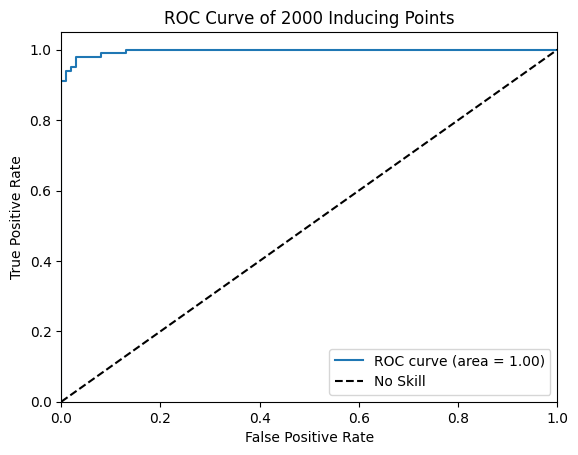

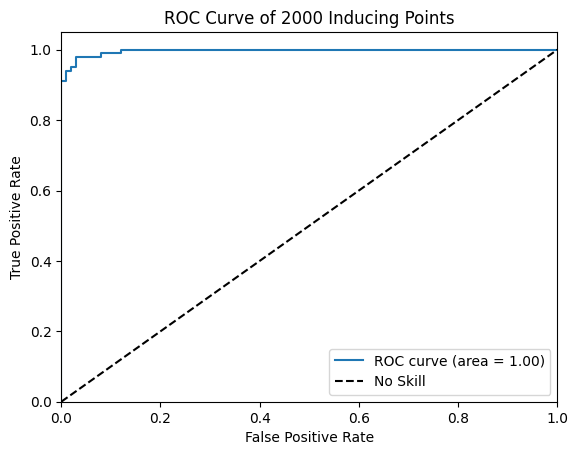

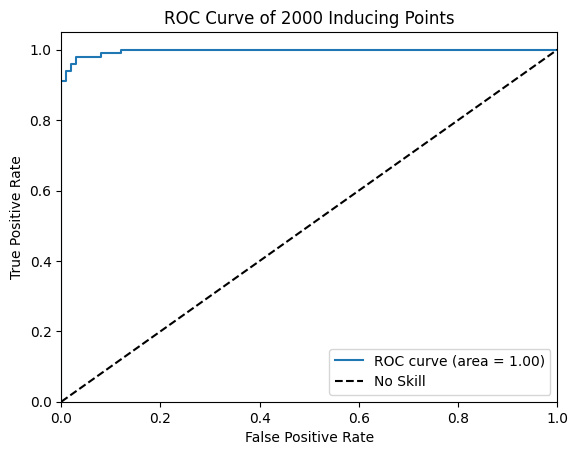

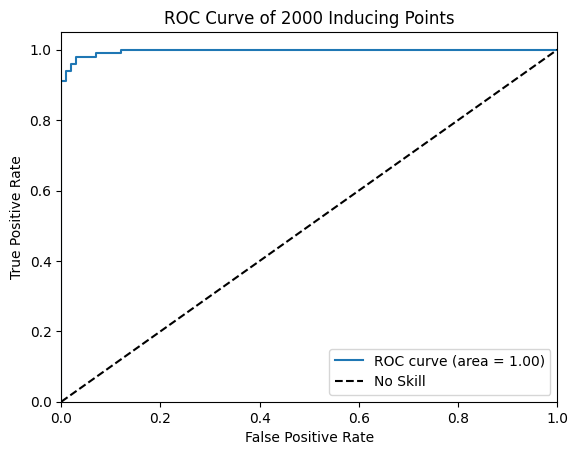

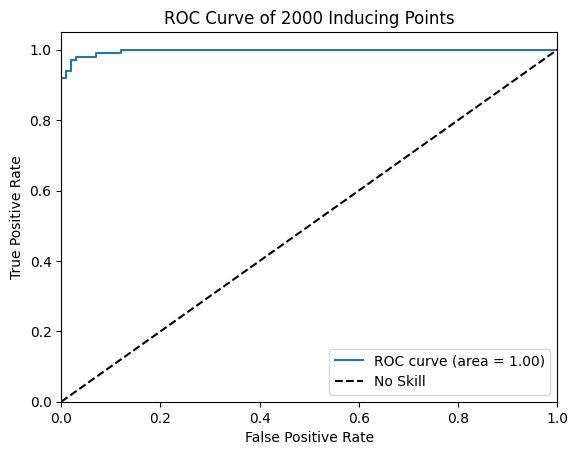

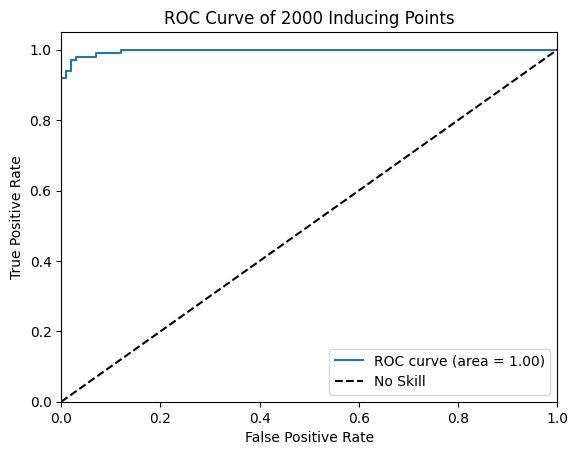

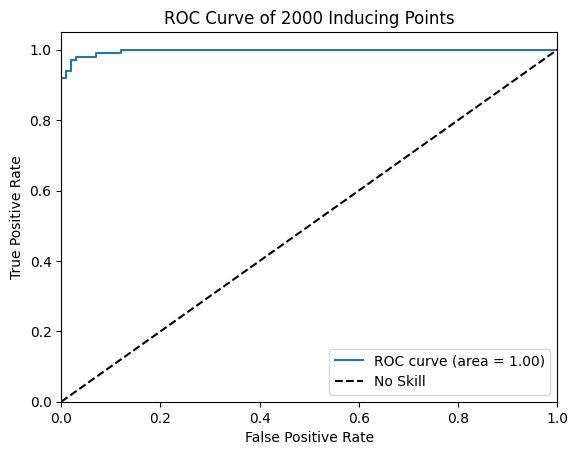

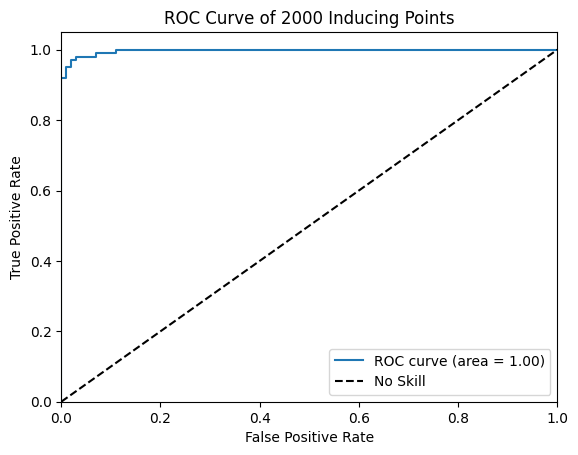

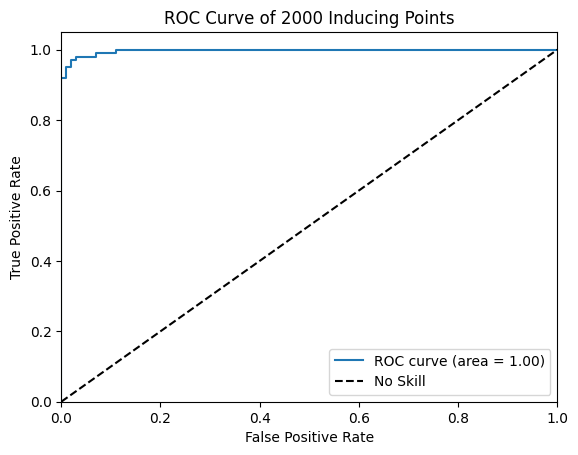

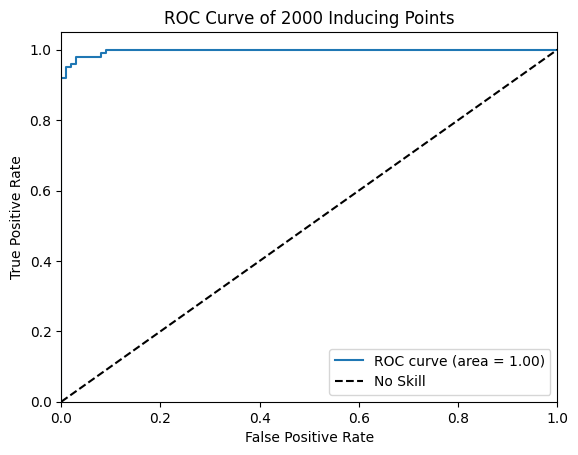

In [2]:
import scanpy as sc
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
os.chdir(os.path.expanduser('/net/scratch2/f30033yc/GPcounts'))
from GPcountsDemo.RNA_seq_GP import rna_seq_gp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

inducing_points = np.arange(80, 100, 2)
inducing_points
adata = sc.read_h5ad("/net/scratch2/f30033yc/GPcounts/demo_notebooks/sigma_0.5_alpha_0.8.h5ad")
Y = pd.DataFrame(data=adata.X.todense().astype(int).copy(), 
                        index=adata.obs_names, 
                        columns=adata.var_names)

spatial_locations = pd.DataFrame(data=adata.obsm['spatial'], 
                                    index=adata.obs_names, 
                                    columns=['x', 'y'])
spatial_locations['total_counts'] = adata.X.sum(axis=1)

scales = []
for i in range(0, len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:, i]~0+spatial_locations['total_counts']", 
                    data=Y, 
                    family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)

scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

Y = Y.T
X = spatial_locations[['x', 'y']]

aucs = {}
results = {}

for i in inducing_points:
    
    gene_name = Y.index
    gpc1 = rna_seq_gp(X,Y.loc[gene_name], sparse=True, safe_mode=False, scale=scalesdf, M=i)
    r1 = gpc1.One_sample_test()
    res = gpc1.calculate_FDR(r1)
    y_true = pd.DataFrame(adata.var['spatially_variable'])
    fpr, tpr, thresholds = roc_curve(y_true, res.log_likelihood_ratio)
    roc_auc = auc(fpr, tpr)
    aucs[M] = roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {M} Inducing Points')

    plt.legend()
    plt.savefig(f'{M} Inducing Points')
    results[M] = res

{2000: 0.9972000000000001}